In [1]:
import pandas as pd
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import seaborn as sns

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

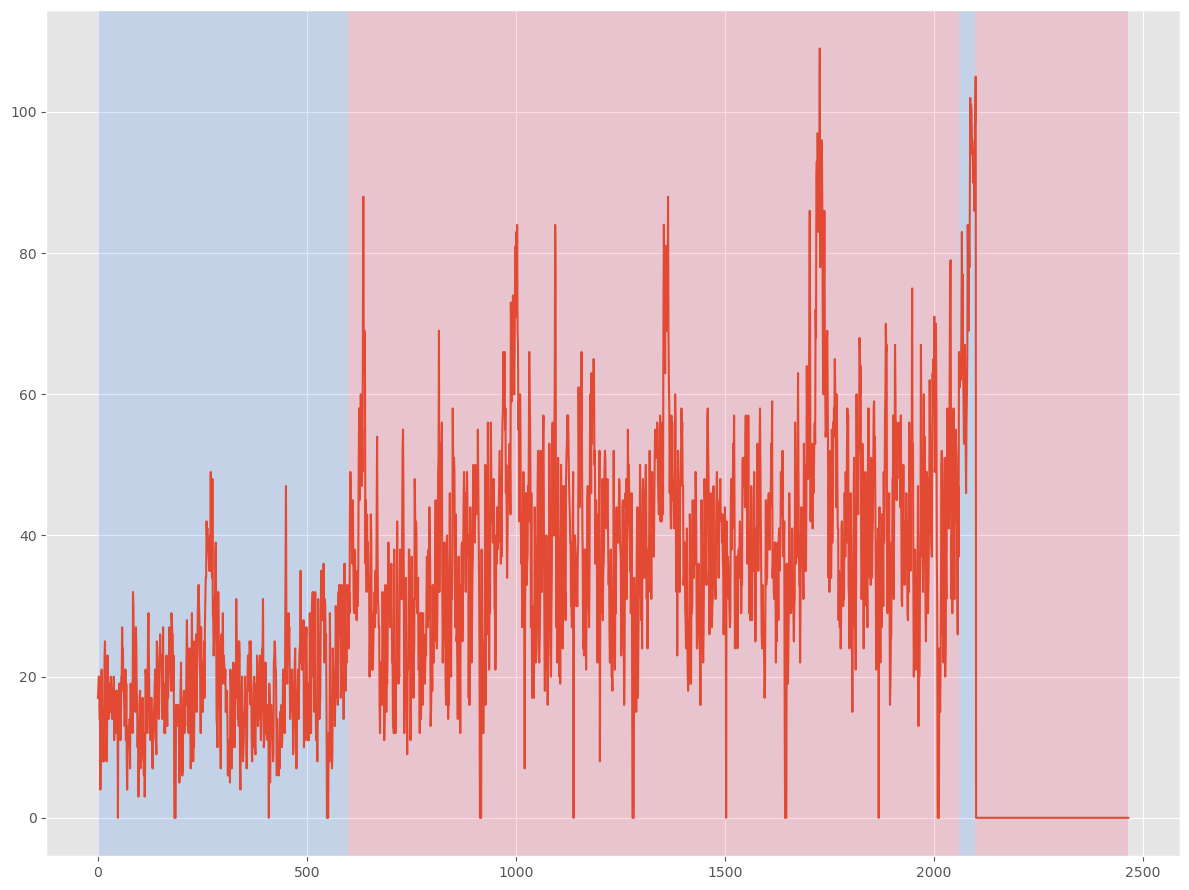

[600, 2060, 2100, 2466]


y  client  close  price_am  price_pm  price  year  month  \
datetime                                                                
2012-02-21  24       0      0       0.0       0.0    0.0  2012      2   
2012-02-22  32       0      0       0.0       0.0    0.0  2012      2   
2012-02-23  29       0      0       1.0       0.0    0.5  2012      2   
2012-02-24  43       0      0       1.0       1.0    1.0  2012      2   
2012-02-25  49       0      0       3.0       2.0    2.5  2012      2   

            weekday  y_lag_365  price_am_lag_1  price_am_lag_7  \
datetime                                                         
2012-02-21        1       26.0             1.0             0.0   
2012-02-22        2       15.0             0.0             0.0   
2012-02-23        3       21.0             0.0             0.0   
2012-02-24        4       23.0             1.0             0.0   
2012-02-25        5       29.0             1.0             2.0   

            price_am_lag_365  price_pm_lag_1  price_pm_lag_7  \
datetime                                                       
2012-02-21               0.0             0.0             0.0   
2012-02-22               1.0             0.0             0.0   
2012-02-23               1.0             0.0             0.0   
2012-02-24               1.0             0.0             0.0   
2012-02-25               2.0             1.0             1.0   

            price_pm_lag_365  price_am_moving_avg_30  price_pm_moving_avg_30  
datetime                                                                      
2012-02-21               0.0                0.600000                0.333333  
2012-02-22               0.0                0.600000                0.333333  
2012-02-23               0.0                0.633333                0.333333  
2012-02-24               1.0                0.666667                0.366667  
2012-02-25               1.0                0.766667                0.433333

client  close  price_am  price_pm  price  year  month  weekday  \
datetime                                                                     
2016-04-01       1      0       3.0       2.0    2.5  2016      4        4   
2016-04-02       0      0       5.0       5.0    5.0  2016      4        5   
2016-04-03       1      0       2.0       2.0    2.0  2016      4        6   
2016-04-04       1      0       1.0       1.0    1.0  2016      4        0   
2016-04-05       0      0       1.0       1.0    1.0  2016      4        1   

            y_lag_365  price_am_lag_1  price_am_lag_7  price_am_lag_365  \
datetime                                                                  
2016-04-01       60.0             5.0             4.0               2.0   
2016-04-02       75.0             3.0             5.0               2.0   
2016-04-03       86.0             5.0             5.0               4.0   
2016-04-04       69.0             2.0             4.0               2.0   
2016-04-05       61.0             1.0             4.0               1.0   

            price_pm_lag_1  price_pm_lag_7  price_pm_lag_365  \
datetime                                                       
2016-04-01             4.0             5.0               2.0   
2016-04-02             2.0             5.0               1.0   
2016-04-03             5.0             4.0               3.0   
2016-04-04             2.0             4.0               2.0   
2016-04-05             1.0             4.0               1.0   

            price_am_moving_avg_30  price_pm_moving_avg_30  
datetime                                                    
2016-04-01                2.400000                2.266667  
2016-04-02                2.566667                2.433333  
2016-04-03                2.600000                2.500000  
2016-04-04                2.566667                2.500000  
2016-04-05                2.566667                2.500000

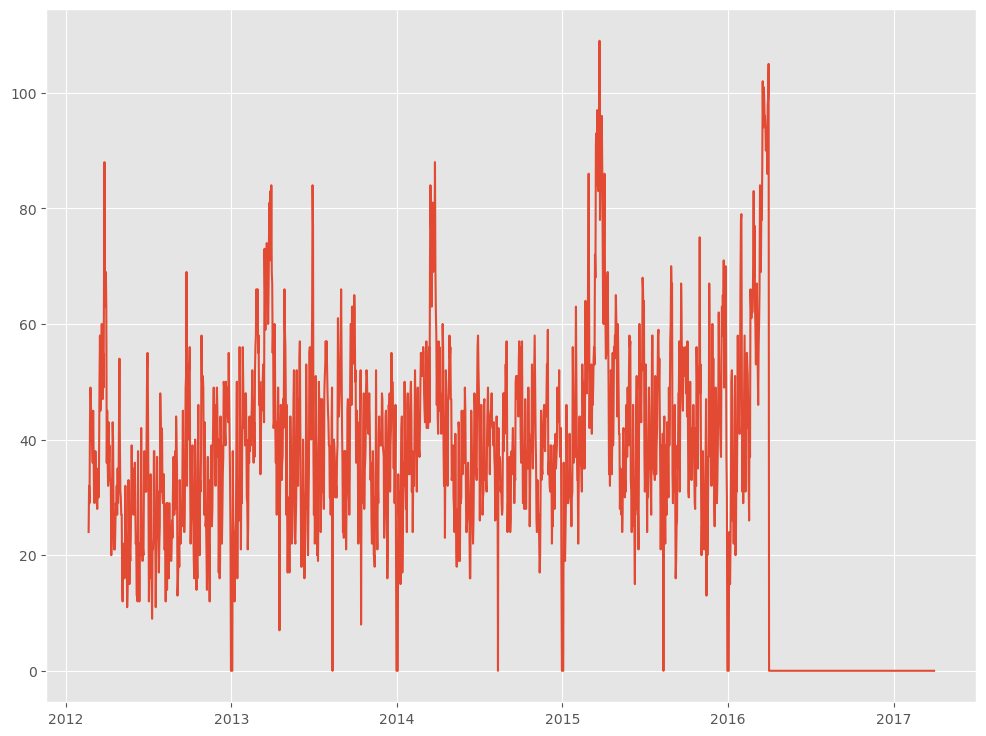

In [3]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

df.drop(['price_am_moving_avg_7', 'price_pm_moving_avg_7', 'day'], axis=1, inplace=True)

################
### 変化点検知 ###
################

# コスト関数の設定
model = "l2"
# アルゴの設定と学習
algo = rpt.Dynp(model=model).fit(df[['y']])
# 変化点の検出
my_bkps = algo.predict(n_bkps=3)
# 結果のプロット
rpt.show.display(df[['y']], my_bkps, figsize=(12, 9))
plt.show()
# 検出された変化点
print(my_bkps)

df = df[my_bkps[0]:]

# 訓練データをとる
train_data = df[df['is_train'] == 1].copy()

# テストデータをとる
test_data = df[df['is_train'] == 0].copy()

# 訓練データから不要な列（'is_train'）を削除
train_data.drop(['is_train'], axis=1, inplace=True)

# テストデータから不要な列を削除
test_data.drop(['y','is_train'], axis=1, inplace=True)

display(train_data.head(), test_data.head())


plt.plot(df['y'])

In [4]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

N = 365
X_train = train_data.drop(['y'], axis=1)[:-N]
y_train = train_data['y'][:-N]

X_test = train_data.drop(['y'], axis=1)[-N:]
y_test = train_data['y'][-N:]

# LightGBM用のデータセット
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)

# 評価基準 
params = {"objective" : "regression", 
              "metric" : "mse", 
              "num_leaves" : 5,
              "early_stopping_rounds" : 50,
              "verbosity": -1}

# 回帰モデル作成
model = lgb.train(params, lgb_train, valid_sets=lgb.test)

# 予測
test_pred = model.predict(X_test)
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_pred)], axis = 1)
pred_df.columns = ['true', 'pred']
pred_df

rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print('RMSE:',round(rmse,3))

RMSE: 9.592


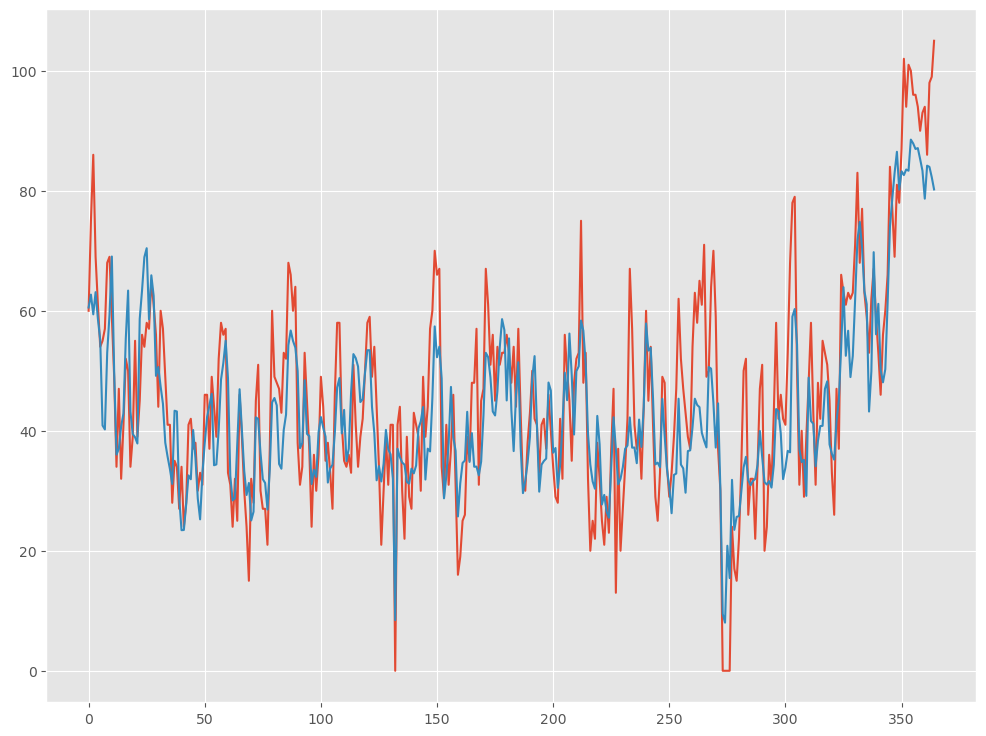

In [5]:
# 可視化
plt.plot(pred_df)

In [6]:
pred_submit = model.predict(test_data)
submit = pd.DataFrame({'date' : test_data.index, 'pred' : pred_submit})
submit.reset_index(drop=True)
submit.columns = submit.iloc[0]
#submit.to_csv('signate_ligthGBM_4.csv', index=False)

In [7]:
submit

0   2016-04-01 00:00:00  70.961541
0            2016-04-01  70.961541
1            2016-04-02  68.787517
2            2016-04-03  70.064284
3            2016-04-04  70.145450
4            2016-04-05  64.256969
..                  ...        ...
360          2017-03-27  81.897195
361          2017-03-28  82.444849
362          2017-03-29  83.447231
363          2017-03-30  85.175035
364          2017-03-31  81.801212

[365 rows x 2 columns]

In [8]:
# oputunaによるハイパーパラメータのチューニング
import optuna

In [9]:
# 固定値のハイパーパラメータ
params_base = {
    'objective' : 'regression',    # 損失関数
    'random_seed' : 123,    
    'learnig_rate' : 0.05,  # １回のブースティングで加算する重みの比率
    'min_data_in_bin' : 3,  # ヒストグラムの１つのbinに含まれる最小のレコード数
    'bagging_freq' : 0,
    'verbose' : -1,
}


# ハイパーパラメータの探索範囲
def objective(trial):
    params_turning = {
        'num_leaves' : trial.suggest_int('num_leaves', 50, 200),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 2, 30),
        'max_bins' : trial.suggest_int('max_bin', 200, 400),
        'bagging_fraction' : trial.suggest_float('bagging_fraction', 0.8, 0.95),
        'feature_fraction' : trial.suggest_float('eature_fraction', 0.35, 0.65),
        'min_gain_to_split' : trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
        'lambda_11' : trial.suggest_float('lambda_11', 0.01, 1, log=True),
        'lambda_12' : trial.suggest_float('lambda_12', 0.01, 1, log=True),
    }
    
    # 探索用ハイパーパラメータの設定
    params_turning.update(params_base)
    lgb_train = lgb.Dataset(x_tr, y_tr)
    lgb_eval = lgb.Dataset(x_va, y_va)

    #探索用ハイパーパラメータで学習
    model = lgb.train(params_turning,
                      lgb_train,
                      num_boost_round=6000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(50),
                                 lgb.log_evaluation(500)])
    y_va_pred = model.predict(x_va,
                              num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print('')
    return score

In [10]:
x_tr = X_train
x_va = X_test
y_tr = y_train
y_va = y_test

In [11]:
# ハイパーパラメータの最適化の実行
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=1500)

[I 2024-08-30 17:06:29,468] A new study created in memory with name: no-name-2e561e40-cd32-4f9c-bc14-23e8925b25cd
[I 2024-08-30 17:06:29,555] Trial 0 finished with value: 8.023239530013203 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'eature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_11': 0.07501954443620121, 'lambda_12': 0.6074996073425692}. Best is trial 0 with value: 8.023239530013203.
[I 2024-08-30 17:06:29,638] Trial 1 finished with value: 7.847475807621413 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'eature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_11': 0.013869861245357327, 'lambda_12': 0.014936835544198456}. Best is trial 1 with value: 7.847475807621413.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 27.8099	valid's l2: 100.97

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.0726	valid's l2: 95.1575

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:29,707] Trial 2 finished with value: 7.945298788055617 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'eature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_11': 0.08374496868436809, 'lambda_12': 0.36396393567863894}. Best is trial 1 with value: 7.847475807621413.
[I 2024-08-30 17:06:29,779] Trial 3 finished with value: 8.040744477645411 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'eature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_11': 0.0338151426782029, 'lambda_12': 0.35356346291488117}. Best is trial 1 with value: 7.847475807621413.
[I 2024-08-30 17:06:29,874] Trial 4 finished with value: 8.036913580202643 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'eature_fraction': 0.5336287168167264

Early stopping, best iteration is:
[65]	train's l2: 27.4458	valid's l2: 98.1815

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 21.264	valid's l2: 102.022

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 18.9416	valid's l2: 99.5888

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:29,971] Trial 5 finished with value: 7.80372883338724 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'eature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_11': 0.02634905974115613, 'lambda_12': 0.018107254066631072}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 17:06:30,060] Trial 6 finished with value: 7.823443711658806 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'eature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_11': 0.02616697456085447, 'lambda_12': 0.021019338091154416}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[58]	train's l2: 17.4508	valid's l2: 93.8944

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 13.8007	valid's l2: 97.5733

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.5191	valid's l2: 97.414



[I 2024-08-30 17:06:30,170] Trial 7 finished with value: 7.816005129196455 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'eature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_11': 0.2054277828628595, 'lambda_12': 0.018895826938026012}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 17:06:30,316] Trial 8 finished with value: 7.8289531395154075 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'eature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_11': 0.8972612866432508, 'lambda_12': 0.08655704137361815}. Best is trial 5 with value: 7.80372883338724.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 13.6647	valid's l2: 95.7244

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:30,474] Trial 9 finished with value: 7.8983755509269375 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'eature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_11': 0.0391093317225106, 'lambda_12': 0.0172764870082179}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 17:06:30,644] Trial 10 finished with value: 8.379765248197986 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 3, 'max_bin': 263, 'bagging_fraction': 0.8477755677707187, 'eature_fraction': 0.5716205741131368, 'min_gain_to_split': 0.06405752057114394, 'lambda_11': 0.012951037531993538, 'lambda_12': 0.07462777081420244}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[162]	train's l2: 10.7478	valid's l2: 98.7169

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 0.707764	valid's l2: 111.141

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:30,919] Trial 11 finished with value: 8.306250559448925 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 6, 'max_bin': 278, 'bagging_fraction': 0.8358983511690721, 'eature_fraction': 0.3702931711227331, 'min_gain_to_split': 0.03678783421330534, 'lambda_11': 0.2140417556266832, 'lambda_12': 0.04115856606244184}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[97]	train's l2: 4.36816	valid's l2: 115.106

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:31,140] Trial 12 finished with value: 8.232133124146413 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 8, 'max_bin': 284, 'bagging_fraction': 0.8296218387817492, 'eature_fraction': 0.35232819390734604, 'min_gain_to_split': 0.14061259463005202, 'lambda_11': 0.24951230977081026, 'lambda_12': 0.010059511488410782}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[97]	train's l2: 7.60391	valid's l2: 111.633

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:31,414] Trial 13 finished with value: 7.815240498033947 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.8021247046192517, 'eature_fraction': 0.41119667823808315, 'min_gain_to_split': 0.32866571087076063, 'lambda_11': 0.2100408407671935, 'lambda_12': 0.04018452885745748}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 17:06:31,498] Trial 14 finished with value: 7.8856994323429905 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 29, 'max_bin': 393, 'bagging_fraction': 0.8006046339305639, 'eature_fraction': 0.47019710147580895, 'min_gain_to_split': 0.3351642361287541, 'lambda_11': 0.1391727807734051, 'lambda_12': 0.03704301258821108}. Best is trial 5 with value: 7.80372883338724.


Early stopping, best iteration is:
[62]	train's l2: 9.95035	valid's l2: 97.7484

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 29.8044	valid's l2: 97.1514

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	train's l2: 3.80402	valid's l2: 107.032


[I 2024-08-30 17:06:31,614] Trial 15 finished with value: 8.059105924283273 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 2, 'max_bin': 395, 'bagging_fraction': 0.909858095848757, 'eature_fraction': 0.4261744581967121, 'min_gain_to_split': 0.8702469573776849, 'lambda_11': 0.3614471237089649, 'lambda_12': 0.045798522861728634}. Best is trial 5 with value: 7.80372883338724.
[I 2024-08-30 17:06:31,788] Trial 16 finished with value: 7.786732627003136 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 15, 'max_bin': 328, 'bagging_fraction': 0.8573117880182874, 'eature_fraction': 0.559531962974027, 'min_gain_to_split': 0.3876262713636515, 'lambda_11': 0.054007735383409326, 'lambda_12': 0.1502501839600174}. Best is trial 16 with value: 7.786732627003136.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	train's l2: 8.63035	valid's l2: 95.4575

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:31,929] Trial 17 finished with value: 7.81766797525298 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 15, 'max_bin': 334, 'bagging_fraction': 0.8565639236009078, 'eature_fraction': 0.5704042920791986, 'min_gain_to_split': 0.5467031890920306, 'lambda_11': 0.04921449866836417, 'lambda_12': 0.1625826899910335}. Best is trial 16 with value: 7.786732627003136.
[I 2024-08-30 17:06:32,051] Trial 18 finished with value: 7.816432739895689 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 23, 'max_bin': 310, 'bagging_fraction': 0.8248565865383581, 'eature_fraction': 0.5589086938436407, 'min_gain_to_split': 0.10535752232713108, 'lambda_11': 0.0199904262153763, 'lambda_12': 0.15426121044656652}. Best is trial 16 with value: 7.786732627003136.


Early stopping, best iteration is:
[99]	train's l2: 11.4072	valid's l2: 94.5323

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[112]	train's l2: 17.01	valid's l2: 97.1482

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:32,177] Trial 19 finished with value: 7.72391312464235 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.9047035847099243, 'eature_fraction': 0.6056136232257695, 'min_gain_to_split': 0.23675439751725777, 'lambda_11': 0.054619754725362256, 'lambda_12': 0.14385958706303073}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:32,281] Trial 20 finished with value: 7.898080945105786 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 17, 'max_bin': 256, 'bagging_fraction': 0.9091423271398142, 'eature_fraction': 0.6082031001413929, 'min_gain_to_split': 0.5130162097970419, 'lambda_11': 0.060282233079889044, 'lambda_12': 0.901404961742367}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	train's l2: 16.392	valid's l2: 94.6436

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:32,392] Trial 21 finished with value: 7.835051768809117 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 15, 'max_bin': 240, 'bagging_fraction': 0.8988849711109106, 'eature_fraction': 0.5932117954739985, 'min_gain_to_split': 0.19396255476438992, 'lambda_11': 0.11271097216899559, 'lambda_12': 0.1293134520689185}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:32,541] Trial 22 finished with value: 7.7736788609721 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 11, 'max_bin': 332, 'bagging_fraction': 0.9134410810825923, 'eature_fraction': 0.5455636675925615, 'min_gain_to_split': 0.26468564263541705, 'lambda_11': 0.022163229496969642, 'lambda_12': 0.07016810504615516}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[78]	train's l2: 14.1195	valid's l2: 95.7416

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 14.3043	valid's l2: 93.5504

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:32,645] Trial 23 finished with value: 7.88913350782144 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 11, 'max_bin': 325, 'bagging_fraction': 0.9200254932248428, 'eature_fraction': 0.6160992782836259, 'min_gain_to_split': 0.26710480459597136, 'lambda_11': 0.01977044788875162, 'lambda_12': 0.0702118726998466}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:32,753] Trial 24 finished with value: 7.934175713399797 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 5, 'max_bin': 375, 'bagging_fraction': 0.9472776172697182, 'eature_fraction': 0.5386526858115942, 'min_gain_to_split': 0.11048222244019565, 'lambda_11': 0.05027796121361993, 'lambda_12': 0.2784485320915678}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[38]	train's l2: 18.9435	valid's l2: 96.8062

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 8.17448	valid's l2: 97.64

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:32,890] Trial 25 finished with value: 7.9166534933979475 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 10, 'max_bin': 303, 'bagging_fraction': 0.8918646812355281, 'eature_fraction': 0.5827747428413604, 'min_gain_to_split': 0.4835521414789371, 'lambda_11': 0.01008469165408217, 'lambda_12': 0.1151170060680491}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:32,996] Trial 26 finished with value: 7.857617267180913 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 16, 'max_bin': 209, 'bagging_fraction': 0.8686062663471034, 'eature_fraction': 0.6273261199007761, 'min_gain_to_split': 0.9924335921254753, 'lambda_11': 0.035158193520681905, 'lambda_12': 0.19510122959825593}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[47]	train's l2: 13.7302	valid's l2: 96.9219

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 19.3868	valid's l2: 95.966

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 23.6166	valid's l2: 101.101


[I 2024-08-30 17:06:33,091] Trial 27 finished with value: 8.017812010564192 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 21, 'max_bin': 267, 'bagging_fraction': 0.9264849711803328, 'eature_fraction': 0.4739457133987566, 'min_gain_to_split': 0.06604911794705368, 'lambda_11': 0.11533780380869935, 'lambda_12': 0.059558498947115096}. Best is trial 19 with value: 7.72391312464235.



Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:33,303] Trial 28 finished with value: 7.9523137469359 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 17, 'max_bin': 291, 'bagging_fraction': 0.9068233212907436, 'eature_fraction': 0.499246434900667, 'min_gain_to_split': 0.28545675994814, 'lambda_11': 0.06373482080594682, 'lambda_12': 0.10361526165515099}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[64]	train's l2: 21.3008	valid's l2: 97.6463

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:33,530] Trial 29 finished with value: 7.875727461599515 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 24, 'max_bin': 322, 'bagging_fraction': 0.8838564316532282, 'eature_fraction': 0.4956154488118763, 'min_gain_to_split': 0.1434875952287877, 'lambda_11': 0.07498956382248513, 'lambda_12': 0.4866102592636914}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:33,628] Trial 30 finished with value: 7.781274448547671 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 13, 'max_bin': 244, 'bagging_fraction': 0.9163539259720364, 'eature_fraction': 0.5262141572666307, 'min_gain_to_split': 0.23143487998716966, 'lambda_11': 0.021022205015255997, 'lambda_12': 0.029466453789503657}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[273]	train's l2: 8.59463	valid's l2: 99.6229

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.1432	valid's l2: 93.7528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:33,810] Trial 31 finished with value: 7.8322814294790675 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 14, 'max_bin': 243, 'bagging_fraction': 0.9173894508170319, 'eature_fraction': 0.5278417819122176, 'min_gain_to_split': 0.23238865877171647, 'lambda_11': 0.02211384151002552, 'lambda_12': 0.02918037924784571}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:33,903] Trial 32 finished with value: 7.8317244163556445 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 13, 'max_bin': 219, 'bagging_fraction': 0.935354172772723, 'eature_fraction': 0.5553666013497464, 'min_gain_to_split': 0.6170684557298901, 'lambda_11': 0.016478274389158644, 'lambda_12': 0.0529375498423927}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[106]	train's l2: 9.45969	valid's l2: 94.0458

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.7235	valid's l2: 94.8041

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:34,036] Trial 33 finished with value: 7.792632778068991 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 10, 'max_bin': 243, 'bagging_fraction': 0.876309431234307, 'eature_fraction': 0.5169039653480578, 'min_gain_to_split': 0.38066831679862617, 'lambda_11': 0.030181798222662516, 'lambda_12': 0.027414018837909414}. Best is trial 19 with value: 7.72391312464235.


Early stopping, best iteration is:
[57]	train's l2: 11.789	valid's l2: 94.6914

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:34,254] Trial 34 finished with value: 7.884699710753609 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 6, 'max_bin': 231, 'bagging_fraction': 0.8991447532483002, 'eature_fraction': 0.5830183672089685, 'min_gain_to_split': 0.1723134905359227, 'lambda_11': 0.04276621041815396, 'lambda_12': 0.08860391842366229}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:34,357] Trial 35 finished with value: 7.851250325150286 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.9193822382437972, 'eature_fraction': 0.6228257569511682, 'min_gain_to_split': 0.42223522700502264, 'lambda_11': 0.014551318700678469, 'lambda_12': 0.2982859814550006}. Best is trial 19 with value: 7.72391312464235.
[I 2024-08-30 17:06:34,427] Trial 36 finished with value: 8.053303302042746 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 19, 'max_bin': 337, 'bagging_fraction': 0.8861448868816277, 'eature_fraction': 0.54383166686

Early stopping, best iteration is:
[65]	train's l2: 3.43706	valid's l2: 98.7571

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.4556	valid's l2: 98.0153

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	train's l2: 25.5143	valid's l2: 100.392

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:34,518] Trial 37 finished with value: 7.723005466654347 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 14, 'max_bin': 302, 'bagging_fraction': 0.9298618315628703, 'eature_fraction': 0.5673692508612773, 'min_gain_to_split': 0.259556969533245, 'lambda_11': 0.010602293120428133, 'lambda_12': 0.13606082700727817}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:34,616] Trial 38 finished with value: 7.797559448995824 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 13, 'max_bin': 301, 'bagging_fraction': 0.9373094138569763, 'eature_fraction': 0.516048255275104, 'min_gain_to_split': 0.1370552147976792, 'lambda_11': 0.01091558585440097, 'lambda_12': 0.027018385781102165}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:34,716] Trial 39 finished with value: 7.98740973811752 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 10, 'max_bin': 257, 'bagging_fraction': 0.9460704763434001, 'eature_fraction': 0.6352771358

Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.8504	valid's l2: 93.9187

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 13.4144	valid's l2: 100.712



[I 2024-08-30 17:06:34,854] Trial 40 finished with value: 7.877372196692697 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 8, 'max_bin': 313, 'bagging_fraction': 0.9280445042143358, 'eature_fraction': 0.4613348462703316, 'min_gain_to_split': 0.08204968937063924, 'lambda_11': 0.02511405341175509, 'lambda_12': 0.06856536554289938}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 9.97538	valid's l2: 97.641

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:34,977] Trial 41 finished with value: 7.776851538090057 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 15, 'max_bin': 351, 'bagging_fraction': 0.8542940005223382, 'eature_fraction': 0.5607750195638757, 'min_gain_to_split': 0.3159449103989791, 'lambda_11': 0.012956561809372194, 'lambda_12': 0.155154316633551}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,074] Trial 42 finished with value: 7.964121663095214 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 17, 'max_bin': 356, 'bagging_fraction': 0.900735216083316, 'eature_fraction': 0.590151995111424, 'min_gain_to_split': 0.1905405951794019, 'lambda_11': 0.012388297953664426, 'lambda_12': 0.22684480874152926}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,173] Trial 43 finished with value: 7.818706212011078 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 13, 'max_bin': 368, 'bagging_fraction': 0.9136356650832935, 'eature_fraction': 0.57125989852

Early stopping, best iteration is:
[87]	train's l2: 12.8167	valid's l2: 94.3421

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 22.6192	valid's l2: 95.9239

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 12.8161	valid's l2: 94.9959



[I 2024-08-30 17:06:35,260] Trial 44 finished with value: 8.06356946900233 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 19, 'max_bin': 346, 'bagging_fraction': 0.9250603937757288, 'eature_fraction': 0.5335338672172011, 'min_gain_to_split': 0.22728585441682575, 'lambda_11': 0.02932587606567507, 'lambda_12': 0.013220147475425935}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,367] Trial 45 finished with value: 7.951169446052564 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 11, 'max_bin': 346, 'bagging_fraction': 0.9376499775321796, 'eature_fraction': 0.49198877082671716, 'min_gain_to_split': 0.011318318128378765, 'lambda_11': 0.012777579223661082, 'lambda_12': 0.10023456840551273}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 20.6616	valid's l2: 100.225

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.5851	valid's l2: 98.0549

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:35,456] Trial 46 finished with value: 7.754290610028739 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 14, 'max_bin': 290, 'bagging_fraction': 0.8452917758831809, 'eature_fraction': 0.606337806673809, 'min_gain_to_split': 0.1460485205190396, 'lambda_11': 0.0218317133956553, 'lambda_12': 0.08182218523401995}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,605] Trial 47 finished with value: 7.904768197811833 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 16, 'max_bin': 289, 'bagging_fraction': 0.8598961455988771, 'eature_fraction': 0.6490026527441274, 'min_gain_to_split': 0.14232747241462865, 'lambda_11': 0.0100862744649853, 'lambda_12': 0.0844339333259094}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[53]	train's l2: 18.1078	valid's l2: 93.5334

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[171]	train's l2: 5.91041	valid's l2: 96.6518

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:35,691] Trial 48 finished with value: 7.823260590317943 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 14, 'max_bin': 381, 'bagging_fraction': 0.8454161809618047, 'eature_fraction': 0.6048788295373044, 'min_gain_to_split': 0.03688304114494747, 'lambda_11': 0.03751452531414939, 'lambda_12': 0.05597720115484888}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,776] Trial 49 finished with value: 7.876828951540299 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 11, 'max_bin': 307, 'bagging_fraction': 0.8472610648999779, 'eature_fraction': 0.59892441761159, 'min_gain_to_split': 0.08389808482228064, 'lambda_11': 0.02658437783166586, 'lambda_12': 0.17320237517745973}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:35,851] Trial 50 finished with value: 8.05681422909761 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 18, 'max_bin': 281, 'bagging_fraction': 0.8701488237327423, 'eature_fraction': 0.577393016368

Early stopping, best iteration is:
[51]	train's l2: 18.4894	valid's l2: 93.9936

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's l2: 21.5474	valid's l2: 97.4892

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 21.6562	valid's l2: 99.1772

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:35,957] Trial 51 finished with value: 7.729949402599349 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 12, 'max_bin': 270, 'bagging_fraction': 0.8408002015183506, 'eature_fraction': 0.5664969727090928, 'min_gain_to_split': 0.1616728374995152, 'lambda_11': 0.019442893966008123, 'lambda_12': 0.2507752086974017}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,040] Trial 52 finished with value: 7.904426954853877 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 15, 'max_bin': 268, 'bagging_fraction': 0.8218804411249546, 'eature_fraction': 0.567844867969, 'min_gain_to_split': 0.17001525441953125, 'lambda_11': 0.0138529762591122, 'lambda_12': 0.2569484661920648}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,155] Trial 53 finished with value: 7.790301293406381 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 9, 'max_bin': 298, 'bagging_fraction': 0.8386265858486475, 'eature_fraction': 0.549183028804745

Early stopping, best iteration is:
[55]	train's l2: 14.5067	valid's l2: 94.2211

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 20.0349	valid's l2: 97.1144

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 11.7599	valid's l2: 95.1745



[I 2024-08-30 17:06:36,241] Trial 54 finished with value: 7.735500760892737 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8368167035516877, 'eature_fraction': 0.6138971087496002, 'min_gain_to_split': 0.17044654493174083, 'lambda_11': 0.024064285456304332, 'lambda_12': 0.34712353849916866}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,341] Trial 55 finished with value: 7.754340229499227 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8183151612186156, 'eature_fraction': 0.6108006515072344, 'min_gain_to_split': 0.09075856133653872, 'lambda_11': 0.023248185497415592, 'lambda_12': 0.3324793842535357}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.0304	valid's l2: 94.3954

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:36,425] Trial 56 finished with value: 7.845460438547948 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8112472134564392, 'eature_fraction': 0.633877601990685, 'min_gain_to_split': 0.09111662328042221, 'lambda_11': 0.04356140768736889, 'lambda_12': 0.748990577155132}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,551] Trial 57 finished with value: 7.851298905495677 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 9, 'max_bin': 272, 'bagging_fraction': 0.8195206605084331, 'eature_fraction': 0.6116049224444591, 'min_gain_to_split': 0.10945403522884432, 'lambda_11': 0.024087419584856346, 'lambda_12': 0.34788443546995373}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[42]	train's l2: 18.0594	valid's l2: 97.9305

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 7.81854	valid's l2: 96.0356

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:36,686] Trial 58 finished with value: 7.786827392945634 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 14, 'max_bin': 260, 'bagging_fraction': 0.83285268243265, 'eature_fraction': 0.6186250133252288, 'min_gain_to_split': 0.05567755929147875, 'lambda_11': 0.031261188556290086, 'lambda_12': 0.6340696987096002}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,777] Trial 59 finished with value: 7.879810712720622 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 16, 'max_bin': 251, 'bagging_fraction': 0.8290010455173382, 'eature_fraction': 0.5893152385960604, 'min_gain_to_split': 0.052903585390889386, 'lambda_11': 0.1637100703076472, 'lambda_12': 0.22410105508522551}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[72]	train's l2: 12.6086	valid's l2: 95.4394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 17.1013	valid's l2: 95.6558

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:36,895] Trial 60 finished with value: 7.836047844627254 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 12, 'max_bin': 285, 'bagging_fraction': 0.8387377374267071, 'eature_fraction': 0.6364361035875792, 'min_gain_to_split': 0.18155301362872855, 'lambda_11': 0.018057830594876846, 'lambda_12': 0.3117764260095667}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:36,990] Trial 61 finished with value: 7.872115993660914 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 11, 'max_bin': 234, 'bagging_fraction': 0.817119481456544, 'eature_fraction': 0.6005458485153164, 'min_gain_to_split': 0.12186094903299992, 'lambda_11': 0.023586924908979498, 'lambda_12': 0.4129642686964336}. Best is trial 37 with value: 7.723005466654347.


Early stopping, best iteration is:
[84]	train's l2: 8.60545	valid's l2: 96.5466

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 13.9798	valid's l2: 97.0902

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:37,113] Trial 62 finished with value: 7.896976134677329 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 7, 'max_bin': 278, 'bagging_fraction': 0.8288795735433253, 'eature_fraction': 0.6083405265499944, 'min_gain_to_split': 0.17071738669882136, 'lambda_11': 0.036487698829497914, 'lambda_12': 0.19328369446491614}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,196] Trial 63 finished with value: 7.73148691204296 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 14, 'max_bin': 268, 'bagging_fraction': 0.8425009259788983, 'eature_fraction': 0.5835493106211485, 'min_gain_to_split': 0.26942027317022926, 'lambda_11': 0.01975793011753063, 'lambda_12': 0.08434423751381781}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,280] Trial 64 finished with value: 7.909681158558727 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 30, 'max_bin': 264, 'bagging_fraction': 0.8419998014134464, 'eature_fraction': 0.59249647

Early stopping, best iteration is:
[44]	train's l2: 8.56646	valid's l2: 98.9178

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.1079

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	train's l2: 21.8908	valid's l2: 97.5979

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:37,392] Trial 65 finished with value: 7.828989579607526 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 14, 'max_bin': 251, 'bagging_fraction': 0.8531623777750829, 'eature_fraction': 0.6260655698633513, 'min_gain_to_split': 0.15267050136244265, 'lambda_11': 0.027460169365210122, 'lambda_12': 0.512109353582111}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,473] Trial 66 finished with value: 7.841905312229179 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 12, 'max_bin': 271, 'bagging_fraction': 0.8642340204364178, 'eature_fraction': 0.5788960728120288, 'min_gain_to_split': 0.4471837148867453, 'lambda_11': 0.011789651390045114, 'lambda_12': 0.11494021315556469}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,555] Trial 67 finished with value: 7.767208240197055 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 16, 'max_bin': 219, 'bagging_fraction': 0.8505673302496682, 'eature_fraction': 0.61076235

Early stopping, best iteration is:
[98]	train's l2: 9.34974	valid's l2: 97.4026

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 17.953	valid's l2: 96.7315

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 18.1095	valid's l2: 94.6098

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:37,637] Trial 68 finished with value: 7.728135008216861 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 14, 'max_bin': 287, 'bagging_fraction': 0.8253855487228877, 'eature_fraction': 0.5974731082624175, 'min_gain_to_split': 0.1000479518501661, 'lambda_11': 0.014677342720733592, 'lambda_12': 0.14476532565102318}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,742] Trial 69 finished with value: 7.982744104724351 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 18, 'max_bin': 293, 'bagging_fraction': 0.8425393936112233, 'eature_fraction': 0.564751699742396, 'min_gain_to_split': 0.21045917971388525, 'lambda_11': 0.014579695105139274, 'lambda_12': 0.14404770552923313}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:37,834] Trial 70 finished with value: 7.795184444129299 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 13, 'max_bin': 316, 'bagging_fraction': 0.8355670330978537, 'eature_fraction': 0.5850279

Early stopping, best iteration is:
[53]	train's l2: 18.0212	valid's l2: 92.5768

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 15.8662	valid's l2: 97.5991

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.101	valid's l2: 95.0824



[I 2024-08-30 17:06:37,925] Trial 71 finished with value: 7.937369631349178 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 15, 'max_bin': 285, 'bagging_fraction': 0.8237276230474, 'eature_fraction': 0.5956462047639824, 'min_gain_to_split': 0.09662850224309089, 'lambda_11': 0.01472387594861824, 'lambda_12': 0.16966215759935274}. Best is trial 37 with value: 7.723005466654347.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 21.224	valid's l2: 96.3609

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	train's l2: 8.48661	valid's l2: 96.318



[I 2024-08-30 17:06:38,051] Trial 72 finished with value: 7.782026532701407 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 14, 'max_bin': 296, 'bagging_fraction': 0.8129089628246445, 'eature_fraction': 0.6180004342196649, 'min_gain_to_split': 0.12048380938255002, 'lambda_11': 0.011533592044756643, 'lambda_12': 0.352801191461772}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:38,140] Trial 73 finished with value: 7.777084465696211 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.8062853731090445, 'eature_fraction': 0.6031463366392584, 'min_gain_to_split': 0.15429227395974374, 'lambda_11': 0.018126052842979443, 'lambda_12': 0.09168584701590228}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:38,239] Trial 74 finished with value: 7.967473770029444 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 10, 'max_bin': 247, 'bagging_fraction': 0.8288188335767518, 'eature_fraction': 0.6413185

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 12.2361	valid's l2: 99.605

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:38,364] Trial 75 finished with value: 7.814909537429935 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 17, 'max_bin': 235, 'bagging_fraction': 0.8332074753121745, 'eature_fraction': 0.6229901571006602, 'min_gain_to_split': 0.10575245872857687, 'lambda_11': 0.06626576442749159, 'lambda_12': 0.07638575492490628}. Best is trial 37 with value: 7.723005466654347.
[I 2024-08-30 17:06:38,473] Trial 76 finished with value: 7.720194591005392 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 14, 'max_bin': 277, 'bagging_fraction': 0.8168431757573404, 'eature_fraction': 0.5721126161686418, 'min_gain_to_split': 0.059211402633084984, 'lambda_11': 0.04447737629218436, 'lambda_12': 0.13389072645025382}. Best is trial 76 with value: 7.720194591005392.


Early stopping, best iteration is:
[132]	train's l2: 9.16884	valid's l2: 94.5988

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 10.8983	valid's l2: 92.2478

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:38,570] Trial 77 finished with value: 7.796725574961766 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 13, 'max_bin': 277, 'bagging_fraction': 0.825671773981623, 'eature_fraction': 0.5726357138908272, 'min_gain_to_split': 0.03911845586378137, 'lambda_11': 0.041913925339960585, 'lambda_12': 0.13038188442969662}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 17:06:38,648] Trial 78 finished with value: 7.794542080667694 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 16, 'max_bin': 288, 'bagging_fraction': 0.8441993472446345, 'eature_fraction': 0.5814805503474771, 'min_gain_to_split': 0.027567521110135225, 'lambda_11': 0.05686826529374923, 'lambda_12': 0.06452075606908748}. Best is trial 76 with value: 7.720194591005392.


Early stopping, best iteration is:
[55]	train's l2: 15.6726	valid's l2: 94.9959

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 19.1985	valid's l2: 93.0328

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:38,786] Trial 79 finished with value: 7.855411431083024 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 304, 'bagging_fraction': 0.8916104622706982, 'eature_fraction': 0.5595594405596672, 'min_gain_to_split': 0.2731134181719145, 'lambda_11': 0.04647695186551392, 'lambda_12': 0.14031352078261108}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 17:06:38,871] Trial 80 finished with value: 7.856769839345218 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 14, 'max_bin': 266, 'bagging_fraction': 0.8505386762945537, 'eature_fraction': 0.3875060024265653, 'min_gain_to_split': 0.04672580762743678, 'lambda_11': 0.0943194024851565, 'lambda_12': 0.18643539458807293}. Best is trial 76 with value: 7.720194591005392.
[I 2024-08-30 17:06:38,967] Trial 81 finished with value: 7.729844645875698 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 12, 'max_bin': 257, 'bagging_fraction': 0.8169309108784845, 'eature_fraction': 0.59702357400

Early stopping, best iteration is:
[135]	train's l2: 7.63938	valid's l2: 96.6649

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 21.6448	valid's l2: 96.5539

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5066	valid's l2: 94.2193



[I 2024-08-30 17:06:39,067] Trial 82 finished with value: 7.7160486265318715 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8069958785695258, 'eature_fraction': 0.5887841931431919, 'min_gain_to_split': 0.15841352356787955, 'lambda_11': 0.07740471558840334, 'lambda_12': 0.21297210557216217}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,153] Trial 83 finished with value: 7.9370777376790835 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 274, 'bagging_fraction': 0.8056644094097777, 'eature_fraction': 0.5748544755419955, 'min_gain_to_split': 0.20571356651824999, 'lambda_11': 0.07431966215026332, 'lambda_12': 0.21727054916820232}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.7597	valid's l2: 93.6137

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.8204	valid's l2: 96.5864

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:39,240] Trial 84 finished with value: 7.968378790870296 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 11, 'max_bin': 259, 'bagging_fraction': 0.8152311014690727, 'eature_fraction': 0.5865986714742252, 'min_gain_to_split': 0.3653158469219849, 'lambda_11': 0.10643399125023689, 'lambda_12': 0.28002467392138675}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,362] Trial 85 finished with value: 7.79984915248474 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 10, 'max_bin': 270, 'bagging_fraction': 0.8088628003498353, 'eature_fraction': 0.5995638462886879, 'min_gain_to_split': 0.24152653803021024, 'lambda_11': 0.12638318767517015, 'lambda_12': 0.24139035563377675}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[45]	train's l2: 15.7893	valid's l2: 99.2312

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 11.5131	valid's l2: 95.4655

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:39,454] Trial 86 finished with value: 7.804224953349078 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 280, 'bagging_fraction': 0.8035764170590094, 'eature_fraction': 0.556975911675829, 'min_gain_to_split': 0.1619431728376699, 'lambda_11': 0.08265853525968202, 'lambda_12': 0.21160300712110333}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,540] Trial 87 finished with value: 7.885758601597921 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 15, 'max_bin': 239, 'bagging_fraction': 0.8221085250481237, 'eature_fraction': 0.5503900604296615, 'min_gain_to_split': 0.18152946206065587, 'lambda_11': 0.01566292927427598, 'lambda_12': 0.17609112120962292}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,639] Trial 88 finished with value: 7.794540530083405 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 11, 'max_bin': 256, 'bagging_fraction': 0.8001387615120426, 'eature_fraction': 0.5379812739

Early stopping, best iteration is:
[58]	train's l2: 15.9951	valid's l2: 94.1635

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 18.792	valid's l2: 96.5316

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 13.2199	valid's l2: 93.776



[I 2024-08-30 17:06:39,710] Trial 89 finished with value: 7.873870768064379 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 18, 'max_bin': 226, 'bagging_fraction': 0.8106196445781074, 'eature_fraction': 0.594434960286616, 'min_gain_to_split': 0.11642848829827347, 'lambda_11': 0.052013212725364, 'lambda_12': 0.11597705320466734}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,787] Trial 90 finished with value: 7.964210606268392 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 17, 'max_bin': 247, 'bagging_fraction': 0.8141892758154388, 'eature_fraction': 0.578725750560875, 'min_gain_to_split': 0.24494595434484157, 'lambda_11': 0.010994155647541774, 'lambda_12': 0.0953864059301175}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 19.9461	valid's l2: 95.5696

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 22.6049	valid's l2: 95.9254

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:39,933] Trial 91 finished with value: 7.815377065874745 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 14, 'max_bin': 282, 'bagging_fraction': 0.8404158334359112, 'eature_fraction': 0.6309388047854381, 'min_gain_to_split': 0.13610348556314647, 'lambda_11': 0.019052714566815593, 'lambda_12': 0.12201076093283729}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:39,995] Trial 92 finished with value: 7.87748968080894 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 27, 'max_bin': 295, 'bagging_fraction': 0.83226052159422, 'eature_fraction': 0.5658925534934309, 'min_gain_to_split': 0.19064510087524486, 'lambda_11': 0.013808557969066689, 'lambda_12': 0.10536513189791614}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,084] Trial 93 finished with value: 7.749928794963264 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 12, 'max_bin': 288, 'bagging_fraction': 0.8358285528470216, 'eature_fraction': 0.5874078

Early stopping, best iteration is:
[144]	train's l2: 5.68592	valid's l2: 97.6189

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 28.0225	valid's l2: 97.8914

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 14.7315	valid's l2: 93.0868

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:40,186] Trial 94 finished with value: 7.868212319894657 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 9, 'max_bin': 265, 'bagging_fraction': 0.835575528088927, 'eature_fraction': 0.5884088822074037, 'min_gain_to_split': 0.21824294920051132, 'lambda_11': 0.05930725694319717, 'lambda_12': 0.1400964006484227}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,270] Trial 95 finished with value: 7.8403743910145405 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 12, 'max_bin': 300, 'bagging_fraction': 0.8252445850451712, 'eature_fraction': 0.6133102983878794, 'min_gain_to_split': 0.12641023019277758, 'lambda_11': 0.08403743982645687, 'lambda_12': 0.20750722353607917}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,361] Trial 96 finished with value: 7.816673217531697 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 273, 'bagging_fraction': 0.8177031001398584, 'eature_fraction': 0.5712356409

Early stopping, best iteration is:
[43]	train's l2: 12.8945	valid's l2: 96.42

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.1619	valid's l2: 94.5155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 15.4199	valid's l2: 95.8466

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:40,447] Trial 97 finished with value: 7.887710866149609 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 16, 'max_bin': 287, 'bagging_fraction': 0.9043077002568175, 'eature_fraction': 0.5987167653386202, 'min_gain_to_split': 0.1580003876408614, 'lambda_11': 0.028348622339771944, 'lambda_12': 0.39973053878543297}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,542] Trial 98 finished with value: 7.9291641659562755 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 277, 'bagging_fraction': 0.9321234978924801, 'eature_fraction': 0.5524154675494237, 'min_gain_to_split': 0.02959014704183242, 'lambda_11': 0.04007125769905219, 'lambda_12': 0.15589997155050672}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,625] Trial 99 finished with value: 7.840979598178933 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 15, 'max_bin': 261, 'bagging_fraction': 0.8268647349138029, 'eature_fraction': 0.58462

Early stopping, best iteration is:
[69]	train's l2: 16.713	valid's l2: 96.9368

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.4503	valid's l2: 97.0997

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.6326	valid's l2: 95.6254

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:40,726] Trial 100 finished with value: 7.739171458426504 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 11, 'max_bin': 308, 'bagging_fraction': 0.8212092074197135, 'eature_fraction': 0.6172950788970617, 'min_gain_to_split': 0.13516248722466703, 'lambda_11': 0.01271158294533698, 'lambda_12': 0.18580384954414836}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,812] Trial 101 finished with value: 7.83301890162316 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 11, 'max_bin': 318, 'bagging_fraction': 0.8195774223667146, 'eature_fraction': 0.6181152030731062, 'min_gain_to_split': 0.1302281991617549, 'lambda_11': 0.012877972225353248, 'lambda_12': 0.18533979106482054}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:40,913] Trial 102 finished with value: 7.771642514542567 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 10, 'max_bin': 310, 'bagging_fraction': 0.8316969122616741, 'eature_fraction': 0.6039

Early stopping, best iteration is:
[55]	train's l2: 12.7557	valid's l2: 94.4486

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 15.5368	valid's l2: 96.1429

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 13.4659	valid's l2: 94.6877



[I 2024-08-30 17:06:40,999] Trial 103 finished with value: 7.754290610028739 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 269, 'bagging_fraction': 0.8800606812747505, 'eature_fraction': 0.5906203041344393, 'min_gain_to_split': 0.14626026387262359, 'lambda_11': 0.013339167135223689, 'lambda_12': 0.16120824518978713}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,092] Trial 104 finished with value: 7.862005784869928 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 13, 'max_bin': 307, 'bagging_fraction': 0.8220510682885983, 'eature_fraction': 0.5653454591580234, 'min_gain_to_split': 0.1131714408582663, 'lambda_11': 0.054410640364001436, 'lambda_12': 0.13819649242717302}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1078	valid's l2: 93.5334

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.6462	valid's l2: 96.1502

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:41,198] Trial 105 finished with value: 7.817075783581705 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 12, 'max_bin': 292, 'bagging_fraction': 0.8089720024701295, 'eature_fraction': 0.6243243337723937, 'min_gain_to_split': 0.06158191511345147, 'lambda_11': 0.01182754316150681, 'lambda_12': 0.19537518339739027}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,329] Trial 106 finished with value: 7.914946157496306 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 8, 'max_bin': 281, 'bagging_fraction': 0.9221940680908582, 'eature_fraction': 0.45712999664766263, 'min_gain_to_split': 0.19572561963270227, 'lambda_11': 0.0153764416265013, 'lambda_12': 0.16911597082996202}. Best is trial 82 with value: 7.7160486265318715.


Early stopping, best iteration is:
[72]	train's l2: 10.2312	valid's l2: 96.4438

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 9.3423	valid's l2: 98.6858

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:41,428] Trial 107 finished with value: 7.844774408777616 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 13, 'max_bin': 256, 'bagging_fraction': 0.9418993894981503, 'eature_fraction': 0.6059727129951511, 'min_gain_to_split': 0.21724279869123048, 'lambda_11': 0.017359068819626428, 'lambda_12': 0.1123306791951703}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,506] Trial 108 finished with value: 7.929242418954395 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 15, 'max_bin': 325, 'bagging_fraction': 0.8375865712624565, 'eature_fraction': 0.6418451704233833, 'min_gain_to_split': 0.26088432915090826, 'lambda_11': 0.03289499295353546, 'lambda_12': 0.23099490141886533}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,602] Trial 109 finished with value: 7.872181896513892 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 11, 'max_bin': 285, 'bagging_fraction': 0.8157043128683078, 'eature_fraction': 0.59

Early stopping, best iteration is:
[54]	train's l2: 16.2278	valid's l2: 95.6613

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.2027	valid's l2: 97.6371

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 14.1848	valid's l2: 97.0222

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:41,686] Trial 110 finished with value: 7.7530646491988495 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 249, 'bagging_fraction': 0.8126677504013224, 'eature_fraction': 0.5746386869934998, 'min_gain_to_split': 0.13732096539550823, 'lambda_11': 0.02593363057621704, 'lambda_12': 0.1512551733681972}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,774] Trial 111 finished with value: 7.7530646491988495 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 14, 'max_bin': 239, 'bagging_fraction': 0.8123163237398885, 'eature_fraction': 0.578451046877165, 'min_gain_to_split': 0.1368160348208063, 'lambda_11': 0.019696513506369362, 'lambda_12': 0.1268861727785462}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:41,871] Trial 112 finished with value: 7.729949402599349 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.8070318552992313, 'eature_fraction': 0.574

Early stopping, best iteration is:
[53]	train's l2: 18.1074	valid's l2: 93.5133

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1074	valid's l2: 93.5133

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5067	valid's l2: 94.2211



[I 2024-08-30 17:06:41,963] Trial 113 finished with value: 7.735500760892737 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 12, 'max_bin': 264, 'bagging_fraction': 0.8198598303810085, 'eature_fraction': 0.6147013193724222, 'min_gain_to_split': 0.17037080549508396, 'lambda_11': 0.07337757630884056, 'lambda_12': 0.20857515941184193}. Best is trial 82 with value: 7.7160486265318715.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 6.34708	valid's l2: 97.8661


[I 2024-08-30 17:06:42,092] Trial 114 finished with value: 7.927112675286187 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 9, 'max_bin': 264, 'bagging_fraction': 0.8062428175637412, 'eature_fraction': 0.6290527952778728, 'min_gain_to_split': 0.15955822380789145, 'lambda_11': 0.07829398096781337, 'lambda_12': 0.2828596558262514}. Best is trial 82 with value: 7.7160486265318715.
[I 2024-08-30 17:06:42,196] Trial 115 finished with value: 7.703499535089302 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8273329763920637, 'eature_fraction': 0.615172827079025, 'min_gain_to_split': 0.1888743386138107, 'lambda_11': 0.01011309807312358, 'lambda_12': 0.20612701351584006}. Best is trial 115 with value: 7.703499535089302.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:42,326] Trial 116 finished with value: 7.79513976016637 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 13, 'max_bin': 254, 'bagging_fraction': 0.8269125232728958, 'eature_fraction': 0.5099211669534126, 'min_gain_to_split': 0.18664024964875517, 'lambda_11': 0.014451403616622031, 'lambda_12': 0.20480832848721306}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 17:06:42,409] Trial 117 finished with value: 7.929230412117999 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 15, 'max_bin': 244, 'bagging_fraction': 0.8087071565035567, 'eature_fraction': 0.6124317049589045, 'min_gain_to_split': 0.2853916585897238, 'lambda_11': 0.020634788850113425, 'lambda_12': 0.25594299665334175}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 17:06:42,503] Trial 118 finished with value: 7.781274448547671 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 13, 'max_bin': 261, 'bagging_fraction': 0.9494773142399334, 'eature_fraction': 0.54

Early stopping, best iteration is:
[99]	train's l2: 9.12149	valid's l2: 94.5598

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.2026	valid's l2: 97.6369

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.1432	valid's l2: 93.7528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:42,619] Trial 119 finished with value: 7.894138923787479 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 10, 'max_bin': 267, 'bagging_fraction': 0.8019733614291962, 'eature_fraction': 0.5986543022664275, 'min_gain_to_split': 0.32548402357620176, 'lambda_11': 0.02545039424685896, 'lambda_12': 0.23078131588752707}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 17:06:42,710] Trial 120 finished with value: 7.735500760892737 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8958265199555892, 'eature_fraction': 0.6094987553968056, 'min_gain_to_split': 0.1707715775517137, 'lambda_11': 0.011689037988278916, 'lambda_12': 0.17204276852503608}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 17:06:42,807] Trial 121 finished with value: 7.751565316486819 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 12, 'max_bin': 274, 'bagging_fraction': 0.9110126708125291, 'eature_fraction': 0.60

Early stopping, best iteration is:
[61]	train's l2: 10.1462	valid's l2: 97.1831

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 14.7769	valid's l2: 94.5568



[I 2024-08-30 17:06:42,895] Trial 122 finished with value: 7.785170077895198 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 258, 'bagging_fraction': 0.8931280578208094, 'eature_fraction': 0.6221944875764346, 'min_gain_to_split': 0.16882827264052352, 'lambda_11': 0.06973766711432398, 'lambda_12': 0.21978458775304616}. Best is trial 115 with value: 7.703499535089302.
[I 2024-08-30 17:06:43,012] Trial 123 finished with value: 7.700689732892556 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 12, 'max_bin': 251, 'bagging_fraction': 0.8761834567335851, 'eature_fraction': 0.6020465010619894, 'min_gain_to_split': 0.179332548319635, 'lambda_11': 0.010083081317143715, 'lambda_12': 0.20523925602091064}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.7357	valid's l2: 95.6063

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 9.08474	valid's l2: 93.2381



[I 2024-08-30 17:06:43,098] Trial 124 finished with value: 7.854701966233208 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 249, 'bagging_fraction': 0.8851740317623742, 'eature_fraction': 0.5833642440595384, 'min_gain_to_split': 0.25273885528391593, 'lambda_11': 0.09435832128366702, 'lambda_12': 0.2604575568131153}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,201] Trial 125 finished with value: 7.733816826471743 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 11, 'max_bin': 252, 'bagging_fraction': 0.8641894755527487, 'eature_fraction': 0.5960274227000817, 'min_gain_to_split': 0.22397159404407285, 'lambda_11': 0.018002555202853515, 'lambda_12': 0.20321348113026103}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.6682	valid's l2: 95.8477

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 12.9639	valid's l2: 93.6476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:43,289] Trial 126 finished with value: 7.719326932682796 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 242, 'bagging_fraction': 0.8726455304378125, 'eature_fraction': 0.5950213278680394, 'min_gain_to_split': 0.22662010077822928, 'lambda_11': 0.010111291518770967, 'lambda_12': 0.23332652796984987}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,374] Trial 127 finished with value: 7.793021782881362 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 16, 'max_bin': 242, 'bagging_fraction': 0.8711125523414865, 'eature_fraction': 0.5938899524310687, 'min_gain_to_split': 0.22690398841327242, 'lambda_11': 0.010136038506527034, 'lambda_12': 0.2380897613346422}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,467] Trial 128 finished with value: 7.73148691204296 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 227, 'bagging_fraction': 0.8763033669712696, 'eature_fraction': 0.56

Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 16.6983	valid's l2: 94.9387

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.1079

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:43,558] Trial 129 finished with value: 7.855674329012889 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.8752209081603464, 'eature_fraction': 0.5602960542500629, 'min_gain_to_split': 0.4147192954795077, 'lambda_11': 0.014015409863434886, 'lambda_12': 0.14863526360773185}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,641] Trial 130 finished with value: 7.713902375276969 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 238, 'bagging_fraction': 0.8607388939797692, 'eature_fraction': 0.5722134388518209, 'min_gain_to_split': 0.2987553588005321, 'lambda_11': 0.015774551945219706, 'lambda_12': 0.2886243877370145}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,731] Trial 131 finished with value: 7.743208186471614 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 14, 'max_bin': 234, 'bagging_fraction': 0.8673802680159075, 'eature_fraction': 0.568

Early stopping, best iteration is:
[69]	train's l2: 16.0833	valid's l2: 95.984

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.2467	valid's l2: 92.0939

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.2251	valid's l2: 92.1914

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:43,862] Trial 132 finished with value: 7.899988206524314 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 16, 'max_bin': 238, 'bagging_fraction': 0.8578269339778856, 'eature_fraction': 0.5764316815821404, 'min_gain_to_split': 0.3585807881430773, 'lambda_11': 0.012425445206339737, 'lambda_12': 0.18037289114166855}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:43,956] Trial 133 finished with value: 7.849506966833811 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 13, 'max_bin': 231, 'bagging_fraction': 0.8778879778313338, 'eature_fraction': 0.554886107541079, 'min_gain_to_split': 0.2583601508166922, 'lambda_11': 0.01117245648611154, 'lambda_12': 0.22528725697701188}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,040] Trial 134 finished with value: 7.77847236860542 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 14, 'max_bin': 217, 'bagging_fraction': 0.887525767071136, 'eature_fraction': 0.564239

Early stopping, best iteration is:
[126]	train's l2: 9.60483	valid's l2: 96.0176

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.7151	valid's l2: 94.882

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 18.5952	valid's l2: 93.0377

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:44,125] Trial 135 finished with value: 7.73148691204296 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 236, 'bagging_fraction': 0.8731350432871524, 'eature_fraction': 0.5711151981917544, 'min_gain_to_split': 0.2722437050855005, 'lambda_11': 0.013737659602370514, 'lambda_12': 0.19367548882878255}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,227] Trial 136 finished with value: 7.703499535089302 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 245, 'bagging_fraction': 0.8594242851803887, 'eature_fraction': 0.5820559582401472, 'min_gain_to_split': 0.18960967539212392, 'lambda_11': 0.01710265817502629, 'lambda_12': 0.3807622344856404}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,313] Trial 137 finished with value: 7.933871025090712 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 15, 'max_bin': 244, 'bagging_fraction': 0.8541880240357327, 'eature_fraction': 0.5823

Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.1079

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7255



[I 2024-08-30 17:06:44,400] Trial 138 finished with value: 7.847201377252602 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 13, 'max_bin': 246, 'bagging_fraction': 0.859333202802907, 'eature_fraction': 0.5888672930165902, 'min_gain_to_split': 0.18705752491830624, 'lambda_11': 0.01916947317424472, 'lambda_12': 0.4047718225689762}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.9603	valid's l2: 95.7625

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:44,544] Trial 139 finished with value: 7.858832636070038 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 13, 'max_bin': 250, 'bagging_fraction': 0.864060669055981, 'eature_fraction': 0.6015832090603677, 'min_gain_to_split': 0.1539038775003049, 'lambda_11': 0.01275793447028899, 'lambda_12': 0.4378691559575439}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,673] Trial 140 finished with value: 7.785340588893605 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 15, 'max_bin': 259, 'bagging_fraction': 0.8482442411597163, 'eature_fraction': 0.5784638673738278, 'min_gain_to_split': 0.19771712580827255, 'lambda_11': 0.011109157382564575, 'lambda_12': 0.31862658206941563}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[114]	train's l2: 6.95872	valid's l2: 96.1888

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	train's l2: 8.97801	valid's l2: 95.2448

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:44,759] Trial 141 finished with value: 7.854701966233208 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 13, 'max_bin': 201, 'bagging_fraction': 0.8621033411899323, 'eature_fraction': 0.5844257134492457, 'min_gain_to_split': 0.24374956896811165, 'lambda_11': 0.017038281310483825, 'lambda_12': 0.26786649396355344}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,851] Trial 142 finished with value: 7.719178556753804 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.8824028043502187, 'eature_fraction': 0.5728362423273259, 'min_gain_to_split': 0.28800367541159855, 'lambda_11': 0.022418566179708208, 'lambda_12': 0.29523993396795195}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:44,933] Trial 143 finished with value: 7.838598335424061 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 14, 'max_bin': 232, 'bagging_fraction': 0.8706214077002555, 'eature_fraction': 0.

Early stopping, best iteration is:
[46]	train's l2: 18.6682	valid's l2: 95.8477

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 15.5073	valid's l2: 92.1944

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 19.3551	valid's l2: 93.8045

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:45,022] Trial 144 finished with value: 7.724591957096198 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 12, 'max_bin': 242, 'bagging_fraction': 0.8885651241964584, 'eature_fraction': 0.5912534190717114, 'min_gain_to_split': 0.2898207566619471, 'lambda_11': 0.02031972005523252, 'lambda_12': 0.3628752746464362}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,114] Trial 145 finished with value: 7.842025961740088 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 12, 'max_bin': 241, 'bagging_fraction': 0.888244613521463, 'eature_fraction': 0.5919684480178355, 'min_gain_to_split': 0.3004827401161014, 'lambda_11': 0.2643020261780624, 'lambda_12': 0.45363654994773794}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,208] Trial 146 finished with value: 7.761283038487514 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 11, 'max_bin': 247, 'bagging_fraction': 0.8795530425296227, 'eature_fraction': 0.6035658

Early stopping, best iteration is:
[45]	train's l2: 17.3656	valid's l2: 92.7959

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.1722	valid's l2: 94.7107

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 13.6159	valid's l2: 94.1792



[I 2024-08-30 17:06:45,322] Trial 147 finished with value: 7.810290859522945 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 10, 'max_bin': 213, 'bagging_fraction': 0.8840102373735054, 'eature_fraction': 0.5756537414712619, 'min_gain_to_split': 0.1475916882448875, 'lambda_11': 0.02095839329050579, 'lambda_12': 0.5504332152920245}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,409] Trial 148 finished with value: 7.816855305641318 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 12, 'max_bin': 255, 'bagging_fraction': 0.8819127860863833, 'eature_fraction': 0.5904728184325441, 'min_gain_to_split': 0.4566515388024271, 'lambda_11': 0.014622189653747945, 'lambda_12': 0.3699149987071408}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 11.4338	valid's l2: 95.9185

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3051	valid's l2: 95.9043

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:45,519] Trial 149 finished with value: 7.763821484687549 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 11, 'max_bin': 224, 'bagging_fraction': 0.8723143388116474, 'eature_fraction': 0.5986877562459522, 'min_gain_to_split': 0.1868888861094506, 'lambda_11': 0.023479205840001162, 'lambda_12': 0.3248388465562164}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,599] Trial 150 finished with value: 8.092977177980117 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 15, 'max_bin': 230, 'bagging_fraction': 0.9025572122947609, 'eature_fraction': 0.4813598733481216, 'min_gain_to_split': 0.23664398548243826, 'lambda_11': 0.012389225463351923, 'lambda_12': 0.2957685611443076}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,691] Trial 151 finished with value: 7.8540732402643 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 13, 'max_bin': 270, 'bagging_fraction': 0.8162399559844237, 'eature_fraction': 0.583252

Early stopping, best iteration is:
[55]	train's l2: 12.9279	valid's l2: 94.491

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 22.1767	valid's l2: 101.856

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3725	valid's l2: 95.3396

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:45,778] Trial 152 finished with value: 7.7359398664250785 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 14, 'max_bin': 238, 'bagging_fraction': 0.803848436735031, 'eature_fraction': 0.5647706978509036, 'min_gain_to_split': 0.3223037269492722, 'lambda_11': 0.021012174560293306, 'lambda_12': 0.11988607620095373}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,864] Trial 153 finished with value: 7.827612149240292 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 13, 'max_bin': 244, 'bagging_fraction': 0.8900899218014935, 'eature_fraction': 0.5877982616105871, 'min_gain_to_split': 0.04482834780147658, 'lambda_11': 0.015420163977556868, 'lambda_12': 0.07388328689682422}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:45,950] Trial 154 finished with value: 7.71601540530049 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8673748653839325, 'eature_fraction': 0.57

Early stopping, best iteration is:
[56]	train's l2: 17.4442	valid's l2: 91.9407

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.6256	valid's l2: 95.2994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 20.2581	valid's l2: 93.7426

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:46,046] Trial 155 finished with value: 7.740819946566194 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 251, 'bagging_fraction': 0.8673687342225108, 'eature_fraction': 0.5736005141885032, 'min_gain_to_split': 0.2437391764288882, 'lambda_11': 0.01724048885804227, 'lambda_12': 0.15808802917120657}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:46,148] Trial 156 finished with value: 7.727878749883627 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 12, 'max_bin': 256, 'bagging_fraction': 0.8612725184131356, 'eature_fraction': 0.5797566234195308, 'min_gain_to_split': 0.19937618985857272, 'lambda_11': 0.010915871008656328, 'lambda_12': 0.23624554045388274}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[58]	train's l2: 13.9482	valid's l2: 94.6482

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 12.5898	valid's l2: 94.328

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 12.9639	valid's l2: 93.6476


[I 2024-08-30 17:06:46,247] Trial 157 finished with value: 7.733816826471743 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 11, 'max_bin': 258, 'bagging_fraction': 0.8563518516024474, 'eature_fraction': 0.5950830497214225, 'min_gain_to_split': 0.21998013532744434, 'lambda_11': 0.011321334428277027, 'lambda_12': 0.2234204837467692}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:46,340] Trial 158 finished with value: 7.834968228875445 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 13, 'max_bin': 241, 'bagging_fraction': 0.861209017266328, 'eature_fraction': 0.5804821102197699, 'min_gain_to_split': 0.35013245730763004, 'lambda_11': 0.010089679543320209, 'lambda_12': 0.38023920224405444}. Best is trial 123 with value: 7.700689732892556.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.1918	valid's l2: 95.0352

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:46,463] Trial 159 finished with value: 8.09096624837607 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 12, 'max_bin': 247, 'bagging_fraction': 0.8738849488896174, 'eature_fraction': 0.3530083387568447, 'min_gain_to_split': 0.1962295961952854, 'lambda_11': 0.013415710487130328, 'lambda_12': 0.13491427759593352}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:46,559] Trial 160 finished with value: 7.726010458167635 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 14, 'max_bin': 256, 'bagging_fraction': 0.8669092170421125, 'eature_fraction': 0.6037774118405874, 'min_gain_to_split': 0.28438624077036884, 'lambda_11': 0.011893798224050912, 'lambda_12': 0.24385640108622544}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[97]	train's l2: 13.2035	valid's l2: 107.507

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1552	valid's l2: 92.2071

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:46,680] Trial 161 finished with value: 7.73148691204296 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.8665646410223343, 'eature_fraction': 0.6038609503084185, 'min_gain_to_split': 0.2787100740913443, 'lambda_11': 0.011992184603280246, 'lambda_12': 0.2315502302290667}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:46,762] Trial 162 finished with value: 7.929242418954395 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 15, 'max_bin': 260, 'bagging_fraction': 0.8699010066750836, 'eature_fraction': 0.5977602921019982, 'min_gain_to_split': 0.2532141253905254, 'lambda_11': 0.010857281216539788, 'lambda_12': 0.2741422527981489}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:46,854] Trial 163 finished with value: 7.833423280136711 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 13, 'max_bin': 264, 'bagging_fraction': 0.8637454373558916, 'eature_fraction': 0.60786

Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.1079

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 19.2027	valid's l2: 97.6371

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.2671	valid's l2: 96.2532

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:46,949] Trial 164 finished with value: 7.743208186471614 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.8806370710678211, 'eature_fraction': 0.5899903622129298, 'min_gain_to_split': 0.3136683647639816, 'lambda_11': 0.013182019831868206, 'lambda_12': 0.16621130402480405}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,033] Trial 165 finished with value: 7.752579881205162 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 12, 'max_bin': 249, 'bagging_fraction': 0.8693874259518443, 'eature_fraction': 0.5667076053308248, 'min_gain_to_split': 0.2256886070315363, 'lambda_11': 0.011978236332182224, 'lambda_12': 0.24459309764398296}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,135] Trial 166 finished with value: 7.883578222536927 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 16, 'max_bin': 262, 'bagging_fraction': 0.851356341650933, 'eature_fraction': 0.580

Early stopping, best iteration is:
[61]	train's l2: 16.2251	valid's l2: 92.1914

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 20.6291	valid's l2: 94.5931

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 13.7824	valid's l2: 96.1886



[I 2024-08-30 17:06:47,227] Trial 167 finished with value: 7.838619434146167 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 13, 'max_bin': 237, 'bagging_fraction': 0.8770360086758783, 'eature_fraction': 0.6001865023081401, 'min_gain_to_split': 0.2020202289322675, 'lambda_11': 0.6067639062950722, 'lambda_12': 0.2957681667569494}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,329] Trial 168 finished with value: 7.829684904555758 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 11, 'max_bin': 244, 'bagging_fraction': 0.8601529762960977, 'eature_fraction': 0.5544795408218144, 'min_gain_to_split': 0.2798685726487301, 'lambda_11': 0.010872553382340161, 'lambda_12': 0.21324970210198166}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3736	valid's l2: 95.2818

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 13.7515	valid's l2: 94.7557

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:47,528] Trial 169 finished with value: 8.000104405334543 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 4, 'max_bin': 279, 'bagging_fraction': 0.8976565015384219, 'eature_fraction': 0.42270663925496366, 'min_gain_to_split': 0.07253557902840613, 'lambda_11': 0.010007972178981321, 'lambda_12': 0.14950724070398386}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,614] Trial 170 finished with value: 7.836209937932048 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 13, 'max_bin': 267, 'bagging_fraction': 0.8651210087015851, 'eature_fraction': 0.5484175006535453, 'min_gain_to_split': 0.3844425115729701, 'lambda_11': 0.014143079488293171, 'lambda_12': 0.2694860142902959}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,710] Trial 171 finished with value: 7.729869746826003 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 12, 'max_bin': 253, 'bagging_fraction': 0.8821774129587445, 'eature_fraction': 0.57

Early stopping, best iteration is:
[59]	train's l2: 2.87994	valid's l2: 102.378

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.8283	valid's l2: 94.8505

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5066	valid's l2: 94.2198



[I 2024-08-30 17:06:47,798] Trial 172 finished with value: 7.777084465696211 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.8744810192903303, 'eature_fraction': 0.5708926212553074, 'min_gain_to_split': 0.15298809090550106, 'lambda_11': 0.018182052645163517, 'lambda_12': 0.18527563669202882}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:47,882] Trial 173 finished with value: 7.933807958820533 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 15, 'max_bin': 258, 'bagging_fraction': 0.8786337408540714, 'eature_fraction': 0.5854380868177199, 'min_gain_to_split': 0.24398290083618795, 'lambda_11': 0.01631079887365632, 'lambda_12': 0.21661113784905758}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7222

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:47,972] Trial 174 finished with value: 7.785082914073936 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 14, 'max_bin': 246, 'bagging_fraction': 0.856937506166641, 'eature_fraction': 0.5949344326278324, 'min_gain_to_split': 0.17399042981487145, 'lambda_11': 0.01289970128975566, 'lambda_12': 0.23737288366409046}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,063] Trial 175 finished with value: 7.805865439828177 and parameters: {'num_leaves': 155, 'min_data_in_leaf': 13, 'max_bin': 250, 'bagging_fraction': 0.8830116470245645, 'eature_fraction': 0.5611589353757795, 'min_gain_to_split': 0.12298274007026064, 'lambda_11': 0.019379765202522797, 'lambda_12': 0.17172363552196349}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,147] Trial 176 finished with value: 7.752579881205162 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 12, 'max_bin': 242, 'bagging_fraction': 0.8855103784227494, 'eature_fraction': 0.57

Early stopping, best iteration is:
[48]	train's l2: 19.5874	valid's l2: 93.4837

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 15.9945	valid's l2: 95.6856

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 20.6291	valid's l2: 94.5931

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:48,232] Trial 177 finished with value: 7.730893290048875 and parameters: {'num_leaves': 162, 'min_data_in_leaf': 14, 'max_bin': 255, 'bagging_fraction': 0.8684377712045168, 'eature_fraction': 0.60831150399939, 'min_gain_to_split': 0.19605424024256282, 'lambda_11': 0.013999772396894176, 'lambda_12': 0.010049818751220983}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,352] Trial 178 finished with value: 7.747781817831968 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 10, 'max_bin': 233, 'bagging_fraction': 0.8730225221241024, 'eature_fraction': 0.5684246724856856, 'min_gain_to_split': 0.1626934143449245, 'lambda_11': 0.14524673662423554, 'lambda_12': 0.2524630958606439}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[49]	train's l2: 19.2984	valid's l2: 92.3763

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 9.44014	valid's l2: 94.6254

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:48,476] Trial 179 finished with value: 7.863158902521125 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 11, 'max_bin': 271, 'bagging_fraction': 0.8617629792410939, 'eature_fraction': 0.6179133068287065, 'min_gain_to_split': 0.26055079972274664, 'lambda_11': 0.01565679147044701, 'lambda_12': 0.1271280531496531}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,570] Trial 180 finished with value: 7.724582888392391 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 12, 'max_bin': 263, 'bagging_fraction': 0.8819755650597784, 'eature_fraction': 0.5889827682614074, 'min_gain_to_split': 0.2981403226630711, 'lambda_11': 0.017459163915023144, 'lambda_12': 0.15944144884125333}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,663] Trial 181 finished with value: 7.840438461438414 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 12, 'max_bin': 262, 'bagging_fraction': 0.8939613701318793, 'eature_fraction': 0.58923

Early stopping, best iteration is:
[84]	train's l2: 7.3244	valid's l2: 95.701

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3578	valid's l2: 92.7963

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.4128	valid's l2: 95.3584



[I 2024-08-30 17:06:48,746] Trial 182 finished with value: 7.845509268436024 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 13, 'max_bin': 257, 'bagging_fraction': 0.8820236930964913, 'eature_fraction': 0.5808268526599714, 'min_gain_to_split': 0.300488469733487, 'lambda_11': 0.01652736315088703, 'lambda_12': 0.1911516199629136}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:48,840] Trial 183 finished with value: 7.739014937118345 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 12, 'max_bin': 303, 'bagging_fraction': 0.907494669294296, 'eature_fraction': 0.5929113555186145, 'min_gain_to_split': 0.26777217597839265, 'lambda_11': 0.017819860954636575, 'lambda_12': 0.15901011593371484}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	train's l2: 16.8828	valid's l2: 95.3393

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.1777	valid's l2: 93.2491

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:48,926] Trial 184 finished with value: 7.824619446420061 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 11, 'max_bin': 269, 'bagging_fraction': 0.8878693167399125, 'eature_fraction': 0.6025060655005846, 'min_gain_to_split': 0.2319942934245047, 'lambda_11': 0.022246342284725787, 'lambda_12': 0.13419199027987863}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,013] Trial 185 finished with value: 7.7756473375806605 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 13, 'max_bin': 265, 'bagging_fraction': 0.8764468253556319, 'eature_fraction': 0.574720128734459, 'min_gain_to_split': 0.18072895652765594, 'lambda_11': 0.012212237459520532, 'lambda_12': 0.2247326851108863}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,098] Trial 186 finished with value: 7.713902375276969 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 253, 'bagging_fraction': 0.9172623275747266, 'eature_fraction': 0.583

Early stopping, best iteration is:
[38]	train's l2: 18.7897	valid's l2: 94.7314

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.655	valid's l2: 93.9082

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.2467	valid's l2: 92.0939

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:49,190] Trial 187 finished with value: 7.817904341236352 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 15, 'max_bin': 252, 'bagging_fraction': 0.9303781943005185, 'eature_fraction': 0.5853763894344592, 'min_gain_to_split': 0.2929891402341641, 'lambda_11': 0.01463751427244064, 'lambda_12': 0.16398659408966243}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,278] Trial 188 finished with value: 7.747824701248841 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 14, 'max_bin': 247, 'bagging_fraction': 0.9114076484075292, 'eature_fraction': 0.5970608463938201, 'min_gain_to_split': 0.34280146672808176, 'lambda_11': 0.013143299239061023, 'lambda_12': 0.14649188959290627}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,368] Trial 189 finished with value: 7.723005466654347 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 14, 'max_bin': 297, 'bagging_fraction': 0.8723006462469617, 'eature_fraction': 0.587

Early stopping, best iteration is:
[72]	train's l2: 15.1608	valid's l2: 95.5609

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.145	valid's l2: 92.7155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:49,461] Trial 190 finished with value: 7.743208186471614 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 14, 'max_bin': 294, 'bagging_fraction': 0.923615023386773, 'eature_fraction': 0.6122729443741315, 'min_gain_to_split': 0.31114440396753246, 'lambda_11': 0.011008904679368903, 'lambda_12': 0.1772406344967045}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,574] Trial 191 finished with value: 7.863027215658959 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 15, 'max_bin': 299, 'bagging_fraction': 0.9152087246188192, 'eature_fraction': 0.5905448926698131, 'min_gain_to_split': 0.2575812725427542, 'lambda_11': 0.010731223889079933, 'lambda_12': 0.1904067289612398}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[61]	train's l2: 16.2251	valid's l2: 92.1914

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 12.2093	valid's l2: 96.067

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:49,675] Trial 192 finished with value: 7.8540732402643 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 259, 'bagging_fraction': 0.933870744254353, 'eature_fraction': 0.5861975907940022, 'min_gain_to_split': 0.28875605111008906, 'lambda_11': 0.01178522489262185, 'lambda_12': 0.159184454876823}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,763] Trial 193 finished with value: 7.719326932682796 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 253, 'bagging_fraction': 0.8791444905424257, 'eature_fraction': 0.5784201195473965, 'min_gain_to_split': 0.2127619465556313, 'lambda_11': 0.015244492971603308, 'lambda_12': 0.19779913202916988}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:49,853] Trial 194 finished with value: 7.814101300081016 and parameters: {'num_leaves': 186, 'min_data_in_leaf': 16, 'max_bin': 290, 'bagging_fraction': 0.8712306904335745, 'eature_fraction': 0.6034945

Early stopping, best iteration is:
[53]	train's l2: 16.3725	valid's l2: 95.3396

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 15.3534	valid's l2: 94.585

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:49,944] Trial 195 finished with value: 7.723005466654347 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 240, 'bagging_fraction': 0.8791063335593704, 'eature_fraction': 0.5794580109480316, 'min_gain_to_split': 0.24152567361244132, 'lambda_11': 0.015116386777624419, 'lambda_12': 0.14141192316366483}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,034] Trial 196 finished with value: 7.723005466654347 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 241, 'bagging_fraction': 0.8791564012892835, 'eature_fraction': 0.5785847863348658, 'min_gain_to_split': 0.24024628985582072, 'lambda_11': 0.012203876713094803, 'lambda_12': 0.11994081573324825}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,124] Trial 197 finished with value: 7.723005466654347 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 14, 'max_bin': 238, 'bagging_fraction': 0.8777905023580514, 'eature_fraction': 0.

Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:50,256] Trial 198 finished with value: 7.838159316655272 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 15, 'max_bin': 238, 'bagging_fraction': 0.9194621945275624, 'eature_fraction': 0.5788639294589181, 'min_gain_to_split': 0.24813376280888502, 'lambda_11': 0.010098501236233461, 'lambda_12': 0.10647945856328152}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,348] Trial 199 finished with value: 7.72391312464235 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.879278590107265, 'eature_fraction': 0.5848344214325529, 'min_gain_to_split': 0.23460565840217473, 'lambda_11': 0.012133622778906058, 'lambda_12': 0.11257934135102463}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,434] Trial 200 finished with value: 7.72391312464235 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 230, 'bagging_fraction': 0.8787211607372579, 'eature_fraction': 0.576

Early stopping, best iteration is:
[128]	train's l2: 8.11922	valid's l2: 95.2323

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205



[I 2024-08-30 17:06:50,526] Trial 201 finished with value: 7.72391312464235 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 229, 'bagging_fraction': 0.8795179714023288, 'eature_fraction': 0.5725798702720123, 'min_gain_to_split': 0.23548348883993583, 'lambda_11': 0.012449956686659271, 'lambda_12': 0.1145896019347812}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,615] Trial 202 finished with value: 7.933807958820533 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 220, 'bagging_fraction': 0.8788477256543633, 'eature_fraction': 0.5741553192608736, 'min_gain_to_split': 0.2249006233205872, 'lambda_11': 0.012297798297792137, 'lambda_12': 0.11011652759735}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7222

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:50,708] Trial 203 finished with value: 7.723005466654347 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 14, 'max_bin': 229, 'bagging_fraction': 0.8760849915587077, 'eature_fraction': 0.5675487191764029, 'min_gain_to_split': 0.23972072449236298, 'lambda_11': 0.013772647530096244, 'lambda_12': 0.11936693551744068}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,793] Trial 204 finished with value: 7.72391312464235 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 14, 'max_bin': 227, 'bagging_fraction': 0.8757898452631125, 'eature_fraction': 0.5651617575181479, 'min_gain_to_split': 0.2369210853600185, 'lambda_11': 0.013876242961996197, 'lambda_12': 0.11966192288182226}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:50,878] Trial 205 finished with value: 7.933807958820533 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.8788983546513336, 'eature_fraction': 0.56

Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1632	valid's l2: 92.0205

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7222

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:50,974] Trial 206 finished with value: 7.719326932682796 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 229, 'bagging_fraction': 0.8743516916532438, 'eature_fraction': 0.5708818718651651, 'min_gain_to_split': 0.20750464261198828, 'lambda_11': 0.012851686555349755, 'lambda_12': 0.12285313431046271}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,081] Trial 207 finished with value: 7.813582478251733 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 16, 'max_bin': 233, 'bagging_fraction': 0.8736303974777281, 'eature_fraction': 0.5784946949509956, 'min_gain_to_split': 0.2109863530065815, 'lambda_11': 0.011120182071786024, 'lambda_12': 0.12085223833139558}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,169] Trial 208 finished with value: 7.719326932682796 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 227, 'bagging_fraction': 0.8763095467351482, 'eature_fraction': 0.5

Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 13.7482	valid's l2: 95.4174

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962



[I 2024-08-30 17:06:51,258] Trial 209 finished with value: 7.933871025090712 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 15, 'max_bin': 235, 'bagging_fraction': 0.8754447583078055, 'eature_fraction': 0.5583680406433588, 'min_gain_to_split': 0.21239909863579012, 'lambda_11': 0.01503158130264596, 'lambda_12': 0.12964680455689082}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,346] Trial 210 finished with value: 7.730893290048875 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 14, 'max_bin': 218, 'bagging_fraction': 0.9277356926177888, 'eature_fraction': 0.5671241602927576, 'min_gain_to_split': 0.19253607437745585, 'lambda_11': 0.01378732994300423, 'lambda_12': 0.13725045399561328}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7255

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 19.2984	valid's l2: 92.3763

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:51,439] Trial 211 finished with value: 7.723005466654347 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 229, 'bagging_fraction': 0.877274793537072, 'eature_fraction': 0.5711050462973754, 'min_gain_to_split': 0.2579053989330264, 'lambda_11': 0.012609262962679663, 'lambda_12': 0.10164885751349374}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,529] Trial 212 finished with value: 7.730562381025387 and parameters: {'num_leaves': 196, 'min_data_in_leaf': 14, 'max_bin': 226, 'bagging_fraction': 0.8721712469814361, 'eature_fraction': 0.5702790549659187, 'min_gain_to_split': 0.263875651782143, 'lambda_11': 0.01185725584321576, 'lambda_12': 0.10041546571910898}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,615] Trial 213 finished with value: 7.830498933087791 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 13, 'max_bin': 222, 'bagging_fraction': 0.8763379328242957, 'eature_fraction': 0.58171

Early stopping, best iteration is:
[53]	train's l2: 18.1662	valid's l2: 91.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.1528	valid's l2: 92.0941

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.9368	valid's l2: 94.9699

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:51,708] Trial 214 finished with value: 7.933871025090712 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 15, 'max_bin': 212, 'bagging_fraction': 0.8746132310591457, 'eature_fraction': 0.5680028505367753, 'min_gain_to_split': 0.21701728521782016, 'lambda_11': 0.014831466067432011, 'lambda_12': 0.12952556770323484}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,790] Trial 215 finished with value: 7.847179705360313 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 14, 'max_bin': 228, 'bagging_fraction': 0.8692384967769847, 'eature_fraction': 0.5550794553217426, 'min_gain_to_split': 0.2513018445175861, 'lambda_11': 0.013114665696343746, 'lambda_12': 0.0880387995275149}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:51,884] Trial 216 finished with value: 7.9370777376790835 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 13, 'max_bin': 236, 'bagging_fraction': 0.8849613114260667, 'eature_fraction': 0.5

Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7255

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 22.9695	valid's l2: 95.1849

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.8204	valid's l2: 96.5864

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:52,025] Trial 217 finished with value: 7.855411431083024 and parameters: {'num_leaves': 185, 'min_data_in_leaf': 15, 'max_bin': 240, 'bagging_fraction': 0.8719046818822295, 'eature_fraction': 0.5846357867873434, 'min_gain_to_split': 0.2724172355653604, 'lambda_11': 0.014063304838053127, 'lambda_12': 0.10103014566033816}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,114] Trial 218 finished with value: 7.719326932682796 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 14, 'max_bin': 232, 'bagging_fraction': 0.9395178457139963, 'eature_fraction': 0.575080668290456, 'min_gain_to_split': 0.21885088094250932, 'lambda_11': 0.04934231275860425, 'lambda_12': 0.12466805378347534}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,201] Trial 219 finished with value: 7.785083043087409 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 14, 'max_bin': 235, 'bagging_fraction': 0.9419294350895334, 'eature_fraction': 0.574

Early stopping, best iteration is:
[135]	train's l2: 7.63938	valid's l2: 96.6649

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 19.5874	valid's l2: 93.4837

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:52,298] Trial 220 finished with value: 7.844774408777616 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 232, 'bagging_fraction': 0.9377692875712523, 'eature_fraction': 0.570568820936766, 'min_gain_to_split': 0.22014766460793006, 'lambda_11': 0.05422186128702984, 'lambda_12': 0.14289136363067373}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,392] Trial 221 finished with value: 7.719326932682796 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 226, 'bagging_fraction': 0.8781500058921505, 'eature_fraction': 0.580751174025445, 'min_gain_to_split': 0.2289382900720066, 'lambda_11': 0.050560531331181595, 'lambda_12': 0.11065274639611658}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,486] Trial 222 finished with value: 7.719326932682796 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.9451080373715871, 'eature_fraction': 0.5774

Early stopping, best iteration is:
[54]	train's l2: 16.2278	valid's l2: 95.6613

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962



[I 2024-08-30 17:06:52,580] Trial 223 finished with value: 7.719326932682796 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 224, 'bagging_fraction': 0.9403435322765583, 'eature_fraction': 0.577770357928374, 'min_gain_to_split': 0.20262596409381048, 'lambda_11': 0.04805976675766507, 'lambda_12': 0.11890781014788906}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:52,721] Trial 224 finished with value: 7.785340588893605 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.9418047179671662, 'eature_fraction': 0.5782528876426724, 'min_gain_to_split': 0.19780987204711212, 'lambda_11': 0.04456327104115433, 'lambda_12': 0.1220432476748277}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,807] Trial 225 finished with value: 7.847205109421264 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 13, 'max_bin': 225, 'bagging_fraction': 0.9447518783665834, 'eature_fraction': 0.5804445396061557, 'min_gain_to_split': 0.18486054810681765, 'lambda_11': 0.05013811496328185, 'lambda_12': 0.11508358299823744}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:52,899] Trial 226 finished with value: 7.719326932682796 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 220, 'bagging_fraction': 0.9472996605527683, 'eature_fraction': 0.564

Early stopping, best iteration is:
[120]	train's l2: 8.97801	valid's l2: 95.2448

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.9584	valid's l2: 95.7626

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962



[I 2024-08-30 17:06:52,990] Trial 227 finished with value: 7.719326932682796 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 14, 'max_bin': 213, 'bagging_fraction': 0.9421278186452018, 'eature_fraction': 0.5770022359263025, 'min_gain_to_split': 0.22414532746596144, 'lambda_11': 0.047820623317445125, 'lambda_12': 0.136971846810292}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,095] Trial 228 finished with value: 7.813587264457692 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 16, 'max_bin': 215, 'bagging_fraction': 0.949447001779508, 'eature_fraction': 0.5743788344028512, 'min_gain_to_split': 0.20728917923756046, 'lambda_11': 0.03758444004445445, 'lambda_12': 0.13519648795202108}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 13.7481	valid's l2: 95.4175

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:53,189] Trial 229 finished with value: 7.885758601597921 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 212, 'bagging_fraction': 0.9458711078778975, 'eature_fraction': 0.5847050350908006, 'min_gain_to_split': 0.1756508753759418, 'lambda_11': 0.04551230729641099, 'lambda_12': 0.14703604254294314}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,282] Trial 230 finished with value: 7.930850087243741 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 13, 'max_bin': 221, 'bagging_fraction': 0.9372221386356906, 'eature_fraction': 0.5599108449943001, 'min_gain_to_split': 0.2122833927729979, 'lambda_11': 0.05087650366551272, 'lambda_12': 0.13227690545108356}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,372] Trial 231 finished with value: 7.719326932682796 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 221, 'bagging_fraction': 0.9449692541233367, 'eature_fraction': 0.5776

Early stopping, best iteration is:
[59]	train's l2: 18.792	valid's l2: 96.5316

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.3343	valid's l2: 96.72

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962



[I 2024-08-30 17:06:53,459] Trial 232 finished with value: 7.730893290048875 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 216, 'bagging_fraction': 0.9390255815349556, 'eature_fraction': 0.5813632851058989, 'min_gain_to_split': 0.19060342967305, 'lambda_11': 0.04921127180232461, 'lambda_12': 0.10757985988031821}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,560] Trial 233 finished with value: 7.844774408777616 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 13, 'max_bin': 209, 'bagging_fraction': 0.9451953607218443, 'eature_fraction': 0.5746510494885256, 'min_gain_to_split': 0.21759291583153634, 'lambda_11': 0.04069414066594208, 'lambda_12': 0.1439299999185938}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 19.2984	valid's l2: 92.3763

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 16.2278	valid's l2: 95.6613

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:53,633] Trial 234 finished with value: 7.833764992364755 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 23, 'max_bin': 204, 'bagging_fraction': 0.9437565820686769, 'eature_fraction': 0.5671788372185955, 'min_gain_to_split': 0.19875659878441349, 'lambda_11': 0.04698961272760958, 'lambda_12': 0.12991441967412926}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,744] Trial 235 finished with value: 7.785082914073936 and parameters: {'num_leaves': 190, 'min_data_in_leaf': 14, 'max_bin': 219, 'bagging_fraction': 0.9477440479613564, 'eature_fraction': 0.5835284908360584, 'min_gain_to_split': 0.17802949690701647, 'lambda_11': 0.05527448579716169, 'lambda_12': 0.16139001825226443}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[62]	train's l2: 26.3649	valid's l2: 96.6345

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 19.5874	valid's l2: 93.4837

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:53,843] Trial 236 finished with value: 7.933807958820533 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 15, 'max_bin': 222, 'bagging_fraction': 0.9396654572161567, 'eature_fraction': 0.5776462059166441, 'min_gain_to_split': 0.2244531144043176, 'lambda_11': 0.03659666345684864, 'lambda_12': 0.11429846060242228}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:53,938] Trial 237 finished with value: 7.719326932682796 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 225, 'bagging_fraction': 0.9354796116614279, 'eature_fraction': 0.5646839838970743, 'min_gain_to_split': 0.20448919250340275, 'lambda_11': 0.0614444616677989, 'lambda_12': 0.14822767609699067}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,029] Trial 238 finished with value: 7.7631271168488105 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 208, 'bagging_fraction': 0.9348645051145066, 'eature_fraction': 0.563

Early stopping, best iteration is:
[54]	train's l2: 20.4392	valid's l2: 97.7222

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.4911	valid's l2: 94.2986



[I 2024-08-30 17:06:54,113] Trial 239 finished with value: 7.785082914073936 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 14, 'max_bin': 216, 'bagging_fraction': 0.9403213645054049, 'eature_fraction': 0.5704366790545973, 'min_gain_to_split': 0.17318799539643095, 'lambda_11': 0.06497064137817032, 'lambda_12': 0.17502596474021268}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,204] Trial 240 finished with value: 7.861929299796936 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 15, 'max_bin': 223, 'bagging_fraction': 0.9325861663695693, 'eature_fraction': 0.5608971401263231, 'min_gain_to_split': 0.20886252779977219, 'lambda_11': 0.04561337969281703, 'lambda_12': 0.15246189456102863}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 19.5874	valid's l2: 93.4837

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 17.9333	valid's l2: 96.2212

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:54,299] Trial 241 finished with value: 7.719326932682796 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 14, 'max_bin': 226, 'bagging_fraction': 0.9435624612533892, 'eature_fraction': 0.5753813898657876, 'min_gain_to_split': 0.22803949408759888, 'lambda_11': 0.05308298950219544, 'lambda_12': 0.13420004441786357}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,424] Trial 242 finished with value: 7.719326932682796 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 14, 'max_bin': 218, 'bagging_fraction': 0.9434146285210628, 'eature_fraction': 0.5719049017894251, 'min_gain_to_split': 0.20046262031105377, 'lambda_11': 0.052461841654366036, 'lambda_12': 0.13880241984956415}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.2841	valid's l2: 91.8962

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:54,530] Trial 243 finished with value: 7.703499535089302 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 13, 'max_bin': 219, 'bagging_fraction': 0.9435537799616007, 'eature_fraction': 0.5716419921781206, 'min_gain_to_split': 0.19072516573369533, 'lambda_11': 0.05408695537034456, 'lambda_12': 0.13335844560471444}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,625] Trial 244 finished with value: 7.703499535089302 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 13, 'max_bin': 225, 'bagging_fraction': 0.9441709117832349, 'eature_fraction': 0.5696487620419763, 'min_gain_to_split': 0.19035983307763865, 'lambda_11': 0.054802231527849465, 'lambda_12': 0.1318200051227428}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:54,734] Trial 245 finished with value: 7.756623532996871 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 13, 'max_bin': 220, 'bagging_fraction': 0.9437389691356147, 'eature_fraction': 0.5703403840235618, 'min_gain_to_split': 0.19398885555813872, 'lambda_11': 0.05177533037490662, 'lambda_12': 0.12736635998770543}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,821] Trial 246 finished with value: 7.847205109421264 and parameters: {'num_leaves': 192, 'min_data_in_leaf': 13, 'max_bin': 215, 'bagging_fraction': 0.9473398041591066, 'eature_fraction': 0.5640657256038781, 'min_gain_to_split': 0.18498863374589083, 'lambda_11': 0.05681067489944985, 'lambda_12': 0.13924734057319174}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:54,923] Trial 247 finished with value: 7.808452114623571 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 13, 'max_bin': 224, 'bagging_fraction': 0.9426114042742829, 'eature_fraction': 0.572

Early stopping, best iteration is:
[79]	train's l2: 11.2708	valid's l2: 94.3283

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.9584	valid's l2: 95.7626

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 13.0508	valid's l2: 95.411



[I 2024-08-30 17:06:55,012] Trial 248 finished with value: 7.8441483037463 and parameters: {'num_leaves': 198, 'min_data_in_leaf': 14, 'max_bin': 226, 'bagging_fraction': 0.9450328493473428, 'eature_fraction': 0.5545488584525815, 'min_gain_to_split': 0.2058741331332218, 'lambda_11': 0.049366566365829666, 'lambda_12': 0.11084796930840793}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:55,106] Trial 249 finished with value: 7.703499535089302 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 13, 'max_bin': 218, 'bagging_fraction': 0.9403196363114791, 'eature_fraction': 0.5662299763877886, 'min_gain_to_split': 0.1908264438792122, 'lambda_11': 0.05218259524625867, 'lambda_12': 0.1563587408557135}. Best is trial 123 with value: 7.700689732892556.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.9047	valid's l2: 94.7986

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.0755	valid's l2: 93.3999

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:55,191] Trial 250 finished with value: 7.7756473375806605 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 13, 'max_bin': 219, 'bagging_fraction': 0.9392753782274198, 'eature_fraction': 0.566771923272193, 'min_gain_to_split': 0.17999085035049392, 'lambda_11': 0.055809263410244246, 'lambda_12': 0.15903925998489912}. Best is trial 123 with value: 7.700689732892556.
[I 2024-08-30 17:06:55,278] Trial 251 finished with value: 7.7631271168488105 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 13, 'max_bin': 208, 'bagging_fraction': 0.9498420651475888, 'eature_fraction': 0.5731966487840702, 'min_gain_to_split': 0.19590567197241152, 'lambda_11': 0.054308122866202055, 'lambda_12': 0.16442717723318245}. Best is trial 123 with value: 7.700689732892556.


Early stopping, best iteration is:
[46]	train's l2: 18.655	valid's l2: 93.9082

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.4911	valid's l2: 94.2986

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:55,415] Trial 252 finished with value: 7.680339941758508 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 13, 'max_bin': 226, 'bagging_fraction': 0.9412707716810149, 'eature_fraction': 0.564884155921166, 'min_gain_to_split': 0.16709279799855603, 'lambda_11': 0.061565341609825415, 'lambda_12': 0.14293293039528635}. Best is trial 252 with value: 7.680339941758508.
[I 2024-08-30 17:06:55,528] Trial 253 finished with value: 7.676380858615015 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 13, 'max_bin': 227, 'bagging_fraction': 0.9403876391738403, 'eature_fraction': 0.5596172502148677, 'min_gain_to_split': 0.16332134822939423, 'lambda_11': 0.06917823908910614, 'lambda_12': 0.15245989034333488}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[122]	train's l2: 6.45174	valid's l2: 92.7277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 9.77778	valid's l2: 92.7685

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:55,627] Trial 254 finished with value: 7.804224953349078 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 13, 'max_bin': 231, 'bagging_fraction': 0.9379580056791146, 'eature_fraction': 0.553073737306136, 'min_gain_to_split': 0.15920214599918545, 'lambda_11': 0.0699993935426489, 'lambda_12': 0.15160830333869701}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:55,762] Trial 255 finished with value: 7.676380858615015 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 13, 'max_bin': 226, 'bagging_fraction': 0.9406539722303935, 'eature_fraction': 0.5588642732077987, 'min_gain_to_split': 0.16517609829931423, 'lambda_11': 0.06273925849635, 'lambda_12': 0.17298884115238147}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[58]	train's l2: 15.9951	valid's l2: 94.1635

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 9.77778	valid's l2: 92.7685

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:55,858] Trial 256 finished with value: 7.804224953349078 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 13, 'max_bin': 221, 'bagging_fraction': 0.9467893791365931, 'eature_fraction': 0.5475809782137201, 'min_gain_to_split': 0.14942876697601637, 'lambda_11': 0.06661955079203864, 'lambda_12': 0.1732555109919689}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:55,948] Trial 257 finished with value: 7.840876026970553 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 13, 'max_bin': 231, 'bagging_fraction': 0.9390212504263903, 'eature_fraction': 0.5573199277915258, 'min_gain_to_split': 0.16559024191187946, 'lambda_11': 0.058042276896625354, 'lambda_12': 0.16823614896606356}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,042] Trial 258 finished with value: 7.767877607648978 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 13, 'max_bin': 212, 'bagging_fraction': 0.9408878328287447, 'eature_fraction': 0.53879

Early stopping, best iteration is:
[58]	train's l2: 15.9951	valid's l2: 94.1635

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 18.2873	valid's l2: 94.5128

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.6353	valid's l2: 93.5013



[I 2024-08-30 17:06:56,135] Trial 259 finished with value: 7.760891724806571 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 12, 'max_bin': 227, 'bagging_fraction': 0.9349125721082666, 'eature_fraction': 0.5592968282473472, 'min_gain_to_split': 0.14821035925219728, 'lambda_11': 0.041611071642361205, 'lambda_12': 0.12117796181366068}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,221] Trial 260 finished with value: 7.7756473375806605 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 13, 'max_bin': 220, 'bagging_fraction': 0.9482928071422301, 'eature_fraction': 0.562052270663422, 'min_gain_to_split': 0.1785278527451318, 'lambda_11': 0.04601464240993159, 'lambda_12': 0.015851310337927898}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	train's l2: 15.797	valid's l2: 94.6075

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.655	valid's l2: 93.9082

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:56,323] Trial 261 finished with value: 7.82781457848289 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 12, 'max_bin': 233, 'bagging_fraction': 0.9461974046089353, 'eature_fraction': 0.5515838662160328, 'min_gain_to_split': 0.17927843377123234, 'lambda_11': 0.07507288564228512, 'lambda_12': 0.18624130788608267}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,418] Trial 262 finished with value: 7.710355126029612 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 12, 'max_bin': 216, 'bagging_fraction': 0.9419513975016394, 'eature_fraction': 0.5663665207700497, 'min_gain_to_split': 0.1642809550164808, 'lambda_11': 0.06131638669474357, 'lambda_12': 0.09716366570945273}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,514] Trial 263 finished with value: 7.732587976510814 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 12, 'max_bin': 216, 'bagging_fraction': 0.9405747841315525, 'eature_fraction': 0.5649373

Early stopping, best iteration is:
[59]	train's l2: 14.2394	valid's l2: 94.2797

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 14.5951	valid's l2: 93.6581

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.6659	valid's l2: 92.9735



[I 2024-08-30 17:06:56,609] Trial 264 finished with value: 7.804224953349078 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 13, 'max_bin': 226, 'bagging_fraction': 0.9370248549682759, 'eature_fraction': 0.5575873234908437, 'min_gain_to_split': 0.16124215158767247, 'lambda_11': 0.0767269105344989, 'lambda_12': 0.1015159928153314}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,696] Trial 265 finished with value: 7.777084465696211 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 230, 'bagging_fraction': 0.9406505620387821, 'eature_fraction': 0.5675668620295008, 'min_gain_to_split': 0.1526390260714329, 'lambda_11': 0.06726908312028987, 'lambda_12': 0.09293671160314634}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 15.9951	valid's l2: 94.1635

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:56,761] Trial 266 finished with value: 7.894879483879302 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 26, 'max_bin': 205, 'bagging_fraction': 0.9401870488268282, 'eature_fraction': 0.5850979388782342, 'min_gain_to_split': 0.16850121601254944, 'lambda_11': 0.05548071363178395, 'lambda_12': 0.9843637124317514}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,843] Trial 267 finished with value: 7.865629884314234 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 13, 'max_bin': 212, 'bagging_fraction': 0.9428652757847759, 'eature_fraction': 0.5676978767173672, 'min_gain_to_split': 0.7475612755086969, 'lambda_11': 0.059829203040768886, 'lambda_12': 0.17106811939613414}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:56,939] Trial 268 finished with value: 7.858555447392639 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 12, 'max_bin': 217, 'bagging_fraction': 0.9349835905488578, 'eature_fraction': 0.559668

Early stopping, best iteration is:
[64]	train's l2: 28.5031	valid's l2: 97.1855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 18.2111	valid's l2: 96.0031

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 14.8599	valid's l2: 96.2364

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:57,035] Trial 269 finished with value: 7.77793552653318 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 13, 'max_bin': 234, 'bagging_fraction': 0.9419479287482384, 'eature_fraction': 0.5465350203301401, 'min_gain_to_split': 0.18281497908602218, 'lambda_11': 0.09843643169086136, 'lambda_12': 0.19600380806555912}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:57,125] Trial 270 finished with value: 7.73654303364522 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 12, 'max_bin': 224, 'bagging_fraction': 0.9307696814706565, 'eature_fraction': 0.5751855741571605, 'min_gain_to_split': 0.14344427648166883, 'lambda_11': 0.06246459113255117, 'lambda_12': 0.11010294776210325}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[53]	train's l2: 17.5624	valid's l2: 93.8436

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.136	valid's l2: 93.6309

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:57,244] Trial 271 finished with value: 7.676380858615015 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 13, 'max_bin': 224, 'bagging_fraction': 0.9452633373838245, 'eature_fraction': 0.5896261363388403, 'min_gain_to_split': 0.1656461297017629, 'lambda_11': 0.0498374053780862, 'lambda_12': 0.16354161540140202}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:57,353] Trial 272 finished with value: 7.7160486265318715 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 13, 'max_bin': 229, 'bagging_fraction': 0.94411784374292, 'eature_fraction': 0.590966989546872, 'min_gain_to_split': 0.15835124136631162, 'lambda_11': 0.057359531500854384, 'lambda_12': 0.15970811844833582}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[86]	train's l2: 9.77778	valid's l2: 92.7685

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.7597	valid's l2: 93.6137

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:57,503] Trial 273 finished with value: 7.680339941758508 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 13, 'max_bin': 229, 'bagging_fraction': 0.937310187748068, 'eature_fraction': 0.5901712044846933, 'min_gain_to_split': 0.16668618015411502, 'lambda_11': 0.05936081030920714, 'lambda_12': 0.1766873032894017}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:57,604] Trial 274 finished with value: 7.729844645875698 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 12, 'max_bin': 229, 'bagging_fraction': 0.9378060207359336, 'eature_fraction': 0.5930518663714831, 'min_gain_to_split': 0.15641120438503991, 'lambda_11': 0.06829955262360048, 'lambda_12': 0.18140947274503783}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[122]	train's l2: 6.45174	valid's l2: 92.7277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5066	valid's l2: 94.2193

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:57,724] Trial 275 finished with value: 7.676380858615015 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 13, 'max_bin': 234, 'bagging_fraction': 0.9454169584802707, 'eature_fraction': 0.5906900950516454, 'min_gain_to_split': 0.16472616416274824, 'lambda_11': 0.07827589319315219, 'lambda_12': 0.15920383823524226}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:57,849] Trial 276 finished with value: 7.745777443688407 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 11, 'max_bin': 235, 'bagging_fraction': 0.9367764084993828, 'eature_fraction': 0.5956374115146165, 'min_gain_to_split': 0.13340802012443678, 'lambda_11': 0.0840814765567607, 'lambda_12': 0.16357897904874558}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[86]	train's l2: 9.77778	valid's l2: 92.7685

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 9.22129	valid's l2: 94.4774

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:57,947] Trial 277 finished with value: 7.769902505991823 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 12, 'max_bin': 231, 'bagging_fraction': 0.9498544049515549, 'eature_fraction': 0.5939850621659256, 'min_gain_to_split': 0.14420648177966217, 'lambda_11': 0.07845246073146843, 'lambda_12': 0.180060649040919}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:58,093] Trial 278 finished with value: 8.182007830786896 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 2, 'max_bin': 233, 'bagging_fraction': 0.9447590287978785, 'eature_fraction': 0.5895629923388046, 'min_gain_to_split': 0.16218181260042785, 'lambda_11': 0.060537688145088794, 'lambda_12': 0.2107448644453437}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[51]	train's l2: 15.46	valid's l2: 94.9559

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 1.72183	valid's l2: 106.305

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:58,213] Trial 279 finished with value: 7.676380858615015 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 13, 'max_bin': 237, 'bagging_fraction': 0.9426242654020451, 'eature_fraction': 0.5845901583213694, 'min_gain_to_split': 0.16497151050197761, 'lambda_11': 0.07177853578926556, 'lambda_12': 0.1586898204624654}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:58,305] Trial 280 finished with value: 7.822015598676412 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 13, 'max_bin': 238, 'bagging_fraction': 0.942980442974456, 'eature_fraction': 0.5900575504559512, 'min_gain_to_split': 0.1299275252281437, 'lambda_11': 0.08704962541329553, 'lambda_12': 0.012457204004253286}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:58,396] Trial 281 finished with value: 7.777084465696211 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 12, 'max_bin': 387, 'bagging_fraction': 0.9460373296406352, 'eature_fraction': 0.5868

Early stopping, best iteration is:
[86]	train's l2: 9.77778	valid's l2: 92.7685

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 17.954	valid's l2: 95.9896

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203



[I 2024-08-30 17:06:58,500] Trial 282 finished with value: 7.808452114623571 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 13, 'max_bin': 245, 'bagging_fraction': 0.9379016778545013, 'eature_fraction': 0.5984296710017769, 'min_gain_to_split': 0.17199590321584457, 'lambda_11': 0.07881276681679238, 'lambda_12': 0.19737641234249695}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 13.0508	valid's l2: 95.411

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:58,643] Trial 283 finished with value: 7.680339941758508 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 13, 'max_bin': 237, 'bagging_fraction': 0.9322154218358706, 'eature_fraction': 0.5932970601320057, 'min_gain_to_split': 0.16683051833910523, 'lambda_11': 0.06654187075851187, 'lambda_12': 0.16729826689212124}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:58,793] Trial 284 finished with value: 7.878086787218091 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 13, 'max_bin': 237, 'bagging_fraction': 0.9339636915992232, 'eature_fraction': 0.5926911510347753, 'min_gain_to_split': 0.1430872100289481, 'lambda_11': 0.06709498638659882, 'lambda_12': 0.17377669062718037}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[122]	train's l2: 6.45174	valid's l2: 92.7277

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	train's l2: 5.77613	valid's l2: 96.2711

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:58,897] Trial 285 finished with value: 7.705672212972558 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 12, 'max_bin': 243, 'bagging_fraction': 0.9418086864818775, 'eature_fraction': 0.5975254447010886, 'min_gain_to_split': 0.1650548693757143, 'lambda_11': 0.06992336376956902, 'lambda_12': 0.15823969621455064}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:58,993] Trial 286 finished with value: 7.7811944417265355 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 11, 'max_bin': 244, 'bagging_fraction': 0.9431313091227806, 'eature_fraction': 0.6012395100022844, 'min_gain_to_split': 0.1657378417734366, 'lambda_11': 0.07118561563609752, 'lambda_12': 0.19027001535985744}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:59,083] Trial 287 finished with value: 7.777084465696211 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 12, 'max_bin': 249, 'bagging_fraction': 0.9263548031298096, 'eature_fraction': 0.596

Early stopping, best iteration is:
[56]	train's l2: 14.2121	valid's l2: 92.9568

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 17.0047	valid's l2: 94.8766

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203



[I 2024-08-30 17:06:59,170] Trial 288 finished with value: 7.783996480097801 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 12, 'max_bin': 241, 'bagging_fraction': 0.946118711923439, 'eature_fraction': 0.5891464511296354, 'min_gain_to_split': 0.12262105036690762, 'lambda_11': 0.07495049534524176, 'lambda_12': 0.17418995489370806}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:59,268] Trial 289 finished with value: 7.729949402599349 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 12, 'max_bin': 244, 'bagging_fraction': 0.9332014856399955, 'eature_fraction': 0.6063373586636968, 'min_gain_to_split': 0.16373535791617108, 'lambda_11': 0.06467508112223126, 'lambda_12': 0.15569654895078455}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 20.1087	valid's l2: 94.7469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.5067	valid's l2: 94.2211

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:59,361] Trial 290 finished with value: 7.822015598676412 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 13, 'max_bin': 238, 'bagging_fraction': 0.9405043868066776, 'eature_fraction': 0.5861560281083551, 'min_gain_to_split': 0.13487716404327382, 'lambda_11': 0.061848788658307625, 'lambda_12': 0.21494267803815353}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:59,461] Trial 291 finished with value: 7.811904214837622 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 11, 'max_bin': 237, 'bagging_fraction': 0.9371839850829613, 'eature_fraction': 0.60001640553152, 'min_gain_to_split': 0.1548573773429182, 'lambda_11': 0.11794060219891088, 'lambda_12': 0.19129903328388273}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:59,556] Trial 292 finished with value: 7.735500760892737 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 12, 'max_bin': 235, 'bagging_fraction': 0.9424311664222145, 'eature_fraction': 0.59338

Early stopping, best iteration is:
[47]	train's l2: 17.954	valid's l2: 95.9896

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 15.0291	valid's l2: 95.4995

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3309	valid's l2: 94.0683



[I 2024-08-30 17:06:59,653] Trial 293 finished with value: 7.712493621150847 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 248, 'bagging_fraction': 0.9470869979853569, 'eature_fraction': 0.4441702642865568, 'min_gain_to_split': 0.17865336885899685, 'lambda_11': 0.09550398694149319, 'lambda_12': 0.17028735635664738}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.5079	valid's l2: 92.9948

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:06:59,797] Trial 294 finished with value: 7.819264440433344 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 13, 'max_bin': 248, 'bagging_fraction': 0.9482667432094414, 'eature_fraction': 0.5914194397032871, 'min_gain_to_split': 0.1494593715098344, 'lambda_11': 0.09209620142896975, 'lambda_12': 0.17453997986068673}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:06:59,908] Trial 295 finished with value: 7.800545953818804 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 12, 'max_bin': 247, 'bagging_fraction': 0.9464668109045975, 'eature_fraction': 0.460436193103299, 'min_gain_to_split': 0.17841659635033247, 'lambda_11': 0.08321741314277675, 'lambda_12': 0.2069187642984423}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[126]	train's l2: 6.03604	valid's l2: 95.7861

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 14.1204	valid's l2: 94.8987

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:00,003] Trial 296 finished with value: 7.800101793058704 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 13, 'max_bin': 242, 'bagging_fraction': 0.9436568759939409, 'eature_fraction': 0.48120253155767345, 'min_gain_to_split': 0.16384281521811153, 'lambda_11': 0.11184321181215277, 'lambda_12': 0.18274856987231403}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:00,129] Trial 297 finished with value: 7.777593088235553 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 13, 'max_bin': 250, 'bagging_fraction': 0.9479462891678776, 'eature_fraction': 0.5856587579593754, 'min_gain_to_split': 0.1407386565509214, 'lambda_11': 0.07641618269665634, 'lambda_12': 0.16362531922703388}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[53]	train's l2: 18.594	valid's l2: 93.5838

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 10.9643	valid's l2: 95.7362

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:00,228] Trial 298 finished with value: 7.9565055462139815 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 20, 'max_bin': 244, 'bagging_fraction': 0.9408513416217941, 'eature_fraction': 0.4372017305777502, 'min_gain_to_split': 0.178102492797175, 'lambda_11': 0.07067920835764807, 'lambda_12': 0.15625978990386305}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:00,343] Trial 299 finished with value: 7.810953673122282 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 12, 'max_bin': 252, 'bagging_fraction': 0.9358323588265096, 'eature_fraction': 0.4081123127113524, 'min_gain_to_split': 0.15720698432560026, 'lambda_11': 0.08251918498512012, 'lambda_12': 0.22255291801740934}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[104]	train's l2: 17.7986	valid's l2: 99.1861

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 13.8366	valid's l2: 95.8095

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:00,459] Trial 300 finished with value: 7.782910614996333 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 11, 'max_bin': 239, 'bagging_fraction': 0.9295891386956314, 'eature_fraction': 0.6083679552093154, 'min_gain_to_split': 0.17814678948474574, 'lambda_11': 0.10128543837361709, 'lambda_12': 0.1865167161872654}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:00,558] Trial 301 finished with value: 7.839954895060044 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 13, 'max_bin': 247, 'bagging_fraction': 0.9444437533325657, 'eature_fraction': 0.49150220158785063, 'min_gain_to_split': 0.16581209095651367, 'lambda_11': 0.090322358735039, 'lambda_12': 0.16717556196887157}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:00,646] Trial 302 finished with value: 7.895840349116306 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 13, 'max_bin': 242, 'bagging_fraction': 0.949674658997307, 'eature_fraction': 0.4487744

Early stopping, best iteration is:
[42]	train's l2: 17.0047	valid's l2: 94.9009

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 16.0919	valid's l2: 95.8735

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 20.1563	valid's l2: 95.878



[I 2024-08-30 17:07:00,750] Trial 303 finished with value: 7.795792316313286 and parameters: {'num_leaves': 171, 'min_data_in_leaf': 13, 'max_bin': 234, 'bagging_fraction': 0.9383116771001656, 'eature_fraction': 0.47019676488179607, 'min_gain_to_split': 0.1847195086335632, 'lambda_11': 0.0663098138113877, 'lambda_12': 0.1520443107036841}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 16.3441	valid's l2: 94.6545

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:00,884] Trial 304 finished with value: 8.170370404879828 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 11, 'max_bin': 251, 'bagging_fraction': 0.9424277276664846, 'eature_fraction': 0.3720619922530996, 'min_gain_to_split': 0.14848963175854024, 'lambda_11': 0.07268296052108504, 'lambda_12': 0.17392686254492573}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:00,986] Trial 305 finished with value: 7.837633159394403 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 12, 'max_bin': 368, 'bagging_fraction': 0.8540502277666813, 'eature_fraction': 0.5242224075802489, 'min_gain_to_split': 0.1868958805289865, 'lambda_11': 0.05799903488930226, 'lambda_12': 0.2220155680394314}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:01,078] Trial 306 finished with value: 7.777084465696211 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 12, 'max_bin': 229, 'bagging_fraction': 0.9462171184517605, 'eature_fraction': 0.6006

Early stopping, best iteration is:
[98]	train's l2: 11.6927	valid's l2: 109.145

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.0403	valid's l2: 95.3016

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.4933	valid's l2: 94.8203



[I 2024-08-30 17:07:01,168] Trial 307 finished with value: 7.79441445906602 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 13, 'max_bin': 245, 'bagging_fraction': 0.9409678491962032, 'eature_fraction': 0.5834898328797375, 'min_gain_to_split': 0.16997512066443887, 'lambda_11': 0.06308302968172452, 'lambda_12': 0.18492722309619197}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:01,276] Trial 308 finished with value: 7.7773347243696405 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 13, 'max_bin': 238, 'bagging_fraction': 0.9385681709797963, 'eature_fraction': 0.5929985483687851, 'min_gain_to_split': 0.139999745184239, 'lambda_11': 0.18775438101704858, 'lambda_12': 0.1672499382883019}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.7416	valid's l2: 94.8718

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 10.9644	valid's l2: 95.7327

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:01,373] Trial 309 finished with value: 7.786120102303162 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 12, 'max_bin': 230, 'bagging_fraction': 0.8475398818724332, 'eature_fraction': 0.5972507050425362, 'min_gain_to_split': 0.11635279552350322, 'lambda_11': 0.06873961849971862, 'lambda_12': 0.5172336904559968}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:01,470] Trial 310 finished with value: 7.695147741001496 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 11, 'max_bin': 234, 'bagging_fraction': 0.9321468104720281, 'eature_fraction': 0.38835239579926595, 'min_gain_to_split': 0.1879174763651643, 'lambda_11': 0.05506610013849431, 'lambda_12': 0.2040015605388369}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:01,562] Trial 311 finished with value: 7.840824504310499 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 10, 'max_bin': 234, 'bagging_fraction': 0.932531400561575, 'eature_fraction': 0.3971019

Early stopping, best iteration is:
[49]	train's l2: 15.912	valid's l2: 94.6855

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 16.3428	valid's l2: 94.1726

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 18.2898	valid's l2: 96.8283



[I 2024-08-30 17:07:01,721] Trial 312 finished with value: 8.072666626905681 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 11, 'max_bin': 239, 'bagging_fraction': 0.9217413881644111, 'eature_fraction': 0.382151552839857, 'min_gain_to_split': 0.1887286780382729, 'lambda_11': 0.3614702478752036, 'lambda_12': 0.21027705095702257}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[158]	train's l2: 6.93501	valid's l2: 106.225

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:01,818] Trial 313 finished with value: 7.719915594729334 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 11, 'max_bin': 233, 'bagging_fraction': 0.9284249628555442, 'eature_fraction': 0.5034986521578592, 'min_gain_to_split': 0.16231792237405757, 'lambda_11': 0.05587522496761198, 'lambda_12': 0.14965135997931667}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:01,931] Trial 314 finished with value: 7.724528282691286 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 11, 'max_bin': 229, 'bagging_fraction': 0.9364474485443849, 'eature_fraction': 0.44472862436582417, 'min_gain_to_split': 0.1877351204615114, 'lambda_11': 0.06185729341164208, 'lambda_12': 0.23621309327124654}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[46]	train's l2: 16.4802	valid's l2: 91.9032

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.0956	valid's l2: 93.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:02,045] Trial 315 finished with value: 8.125269589230635 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 12, 'max_bin': 222, 'bagging_fraction': 0.9340401028245882, 'eature_fraction': 0.3519013082209693, 'min_gain_to_split': 0.14623332710562825, 'lambda_11': 0.07308412481287331, 'lambda_12': 0.16887952879395898}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:02,143] Trial 316 finished with value: 8.08457966632807 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 13, 'max_bin': 242, 'bagging_fraction': 0.9447955814303747, 'eature_fraction': 0.35850862202629075, 'min_gain_to_split': 0.16835817901701852, 'lambda_11': 0.09732154010269276, 'lambda_12': 0.6230900951154436}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:02,241] Trial 317 finished with value: 7.822715457245234 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 12, 'max_bin': 227, 'bagging_fraction': 0.9411242764543364, 'eature_fraction': 0.40996

Early stopping, best iteration is:
[97]	train's l2: 13.4595	valid's l2: 108.696

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 18.2989	valid's l2: 104.178

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.7955	valid's l2: 96.9483



[I 2024-08-30 17:07:02,334] Trial 318 finished with value: 7.855594930602593 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 12, 'max_bin': 236, 'bagging_fraction': 0.8641733326285241, 'eature_fraction': 0.6055885943778602, 'min_gain_to_split': 0.1320148125182558, 'lambda_11': 0.05783465870358916, 'lambda_12': 0.18920107009642448}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:02,432] Trial 319 finished with value: 7.720689130880001 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 13, 'max_bin': 232, 'bagging_fraction': 0.9319584811929116, 'eature_fraction': 0.6179827465242616, 'min_gain_to_split': 0.15461243344935627, 'lambda_11': 0.052945298216701055, 'lambda_12': 0.03590818572065665}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.5927	valid's l2: 95.6607

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.441	valid's l2: 94.9017

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:02,527] Trial 320 finished with value: 7.7756473375806605 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 13, 'max_bin': 224, 'bagging_fraction': 0.9435448879028413, 'eature_fraction': 0.5889545589070881, 'min_gain_to_split': 0.17293837386100513, 'lambda_11': 0.06615529466637463, 'lambda_12': 0.43765419605530914}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:02,619] Trial 321 finished with value: 7.8812293098404425 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 10, 'max_bin': 400, 'bagging_fraction': 0.9167979336119342, 'eature_fraction': 0.6117166975847478, 'min_gain_to_split': 0.15825800207918614, 'lambda_11': 0.08972474181461475, 'lambda_12': 0.16078820113679487}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:02,715] Trial 322 finished with value: 7.832022444036377 and parameters: {'num_leaves': 172, 'min_data_in_leaf': 12, 'max_bin': 217, 'bagging_fraction': 0.9469922760028469, 'eature_fraction': 0.4

Early stopping, best iteration is:
[46]	train's l2: 18.655	valid's l2: 93.9082

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 17.4042	valid's l2: 96.379

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 18.8433	valid's l2: 97.2825



[I 2024-08-30 17:07:02,804] Trial 323 finished with value: 7.749115764755815 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 12, 'max_bin': 240, 'bagging_fraction': 0.9386528247645876, 'eature_fraction': 0.5828849993669191, 'min_gain_to_split': 0.1882065473827467, 'lambda_11': 0.059745587629819054, 'lambda_12': 0.17982887228883718}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.3121	valid's l2: 93.0535

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:02,994] Trial 324 finished with value: 7.71478234898332 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 11, 'max_bin': 247, 'bagging_fraction': 0.9496091906257024, 'eature_fraction': 0.5977167257698439, 'min_gain_to_split': 0.13722792851074728, 'lambda_11': 0.06893878351487194, 'lambda_12': 0.20351634068578925}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:03,145] Trial 325 finished with value: 7.71478234898332 and parameters: {'num_leaves': 176, 'min_data_in_leaf': 11, 'max_bin': 246, 'bagging_fraction': 0.9492198115103567, 'eature_fraction': 0.59925458704884, 'min_gain_to_split': 0.13826981904145327, 'lambda_11': 0.06852368705620035, 'lambda_12': 0.14654407936063457}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[111]	train's l2: 5.39162	valid's l2: 94.2092

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	train's l2: 5.39162	valid's l2: 94.2092

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:03,261] Trial 326 finished with value: 7.909015749586887 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 9, 'max_bin': 249, 'bagging_fraction': 0.9482275366607007, 'eature_fraction': 0.5973728645061605, 'min_gain_to_split': 0.13191150258192663, 'lambda_11': 0.06915974780092699, 'lambda_12': 0.14332886514215984}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:03,362] Trial 327 finished with value: 7.749928794963264 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 12, 'max_bin': 247, 'bagging_fraction': 0.9494617851791015, 'eature_fraction': 0.6030512299214297, 'min_gain_to_split': 0.1361722751165598, 'lambda_11': 0.0824003924001673, 'lambda_12': 0.14988676622778468}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[45]	train's l2: 12.0075	valid's l2: 96.6112

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 14.7315	valid's l2: 93.0868

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:03,474] Trial 328 finished with value: 7.83271931306781 and parameters: {'num_leaves': 179, 'min_data_in_leaf': 10, 'max_bin': 245, 'bagging_fraction': 0.9457714707969012, 'eature_fraction': 0.6121670623841876, 'min_gain_to_split': 0.14505571339773976, 'lambda_11': 0.07449501071350284, 'lambda_12': 0.1626417494373111}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:03,570] Trial 329 finished with value: 7.796669706251195 and parameters: {'num_leaves': 175, 'min_data_in_leaf': 11, 'max_bin': 252, 'bagging_fraction': 0.9475235075070281, 'eature_fraction': 0.5969837704561205, 'min_gain_to_split': 0.12619828153029064, 'lambda_11': 0.06647832815212625, 'lambda_12': 0.14483773782539766}. Best is trial 253 with value: 7.676380858615015.


Early stopping, best iteration is:
[55]	train's l2: 11.3157	valid's l2: 96.3001

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's l2: 18.8179	valid's l2: 95.516

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.1094	valid's l2: 96.0361



[I 2024-08-30 17:07:03,671] Trial 330 finished with value: 7.811998240559987 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 11, 'max_bin': 248, 'bagging_fraction': 0.9433351786084505, 'eature_fraction': 0.6279303900987714, 'min_gain_to_split': 0.14685296973739903, 'lambda_11': 0.06031922215804428, 'lambda_12': 0.20229672367690368}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:03,792] Trial 331 finished with value: 7.84224465599527 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 10, 'max_bin': 242, 'bagging_fraction': 0.9454552723332866, 'eature_fraction': 0.6019420728724293, 'min_gain_to_split': 0.11632619852429643, 'lambda_11': 0.07058779422606778, 'lambda_12': 0.1818343863970107}. Best is trial 253 with value: 7.676380858615015.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 11.6682	valid's l2: 96.0646

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.5213	valid's l2: 94.5169



[I 2024-08-30 17:07:03,895] Trial 332 finished with value: 7.744310530672839 and parameters: {'num_leaves': 167, 'min_data_in_leaf': 11, 'max_bin': 254, 'bagging_fraction': 0.9498615598735306, 'eature_fraction': 0.4286362533553639, 'min_gain_to_split': 0.1593603987576863, 'lambda_11': 0.07740380837631246, 'lambda_12': 0.15920141691932532}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:03,996] Trial 333 finished with value: 7.929594491085227 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 11, 'max_bin': 236, 'bagging_fraction': 0.9497934265397722, 'eature_fraction': 0.5911791711538026, 'min_gain_to_split': 0.17257068590235886, 'lambda_11': 0.05349578588543502, 'lambda_12': 0.17227807079794122}. Best is trial 253 with value: 7.676380858615015.
[I 2024-08-30 17:07:04,097] Trial 334 finished with value: 7.906692566528777 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 12, 'max_bin': 220, 'bagging_fraction': 0.9397742597204438, 'eature_fraction': 0.51728

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's l2: 16.0824	valid's l2: 96.9877

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.1913	valid's l2: 96.5995



[I 2024-08-30 17:07:04,200] Trial 335 finished with value: 7.66478154107555 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 11, 'max_bin': 244, 'bagging_fraction': 0.9435355810412257, 'eature_fraction': 0.39895990910074935, 'min_gain_to_split': 0.14704128962048296, 'lambda_11': 0.06420267623542436, 'lambda_12': 0.1432620130040764}. Best is trial 335 with value: 7.66478154107555.
[I 2024-08-30 17:07:04,288] Trial 336 finished with value: 7.933681415760505 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 11, 'max_bin': 245, 'bagging_fraction': 0.935754896134197, 'eature_fraction': 0.6218348700000903, 'min_gain_to_split': 0.1355853198599262, 'lambda_11': 0.06621991974380516, 'lambda_12': 0.14247641025700886}. Best is trial 335 with value: 7.66478154107555.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 16.2159	valid's l2: 93.2291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 16.4378	valid's l2: 99.0482

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:04,401] Trial 337 finished with value: 7.698599078092658 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 10, 'max_bin': 248, 'bagging_fraction': 0.9424711406304472, 'eature_fraction': 0.39153021852450887, 'min_gain_to_split': 0.1437797023108321, 'lambda_11': 0.08410654460017332, 'lambda_12': 0.144806154464162}. Best is trial 335 with value: 7.66478154107555.
[I 2024-08-30 17:07:04,563] Trial 338 finished with value: 7.829219229405084 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 9, 'max_bin': 341, 'bagging_fraction': 0.9417114160374505, 'eature_fraction': 0.40337515572386956, 'min_gain_to_split': 0.12325243719971649, 'lambda_11': 0.09012570237903088, 'lambda_12': 0.13970074852542452}. Best is trial 335 with value: 7.66478154107555.


Early stopping, best iteration is:
[64]	train's l2: 13.4022	valid's l2: 93.7114

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	train's l2: 5.01703	valid's l2: 97.1048

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:04,668] Trial 339 finished with value: 7.6497015583255035 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 249, 'bagging_fraction': 0.9420142968503737, 'eature_fraction': 0.3898211084542013, 'min_gain_to_split': 0.01426009495453722, 'lambda_11': 0.0817504421257762, 'lambda_12': 0.15039307620495204}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:04,761] Trial 340 finished with value: 7.799687532391189 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 248, 'bagging_fraction': 0.9414710081026997, 'eature_fraction': 0.390385308588246, 'min_gain_to_split': 0.5384872886181625, 'lambda_11': 0.08260799993321997, 'lambda_12': 0.14255252061002885}. Best is trial 339 with value: 7.6497015583255035.


Early stopping, best iteration is:
[55]	train's l2: 16.3118	valid's l2: 92.8061

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.728	valid's l2: 95.7983

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:04,898] Trial 341 finished with value: 7.864899070223841 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 240, 'bagging_fraction': 0.945536160019157, 'eature_fraction': 0.38344615041125096, 'min_gain_to_split': 0.11606473862640938, 'lambda_11': 0.09538790656598904, 'lambda_12': 0.15289511582471568}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:05,019] Trial 342 finished with value: 7.669978651600037 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 10, 'max_bin': 244, 'bagging_fraction': 0.9385821609939196, 'eature_fraction': 0.3864065765451289, 'min_gain_to_split': 0.09008268185104418, 'lambda_11': 0.08469882653499629, 'lambda_12': 0.1391275896514234}. Best is trial 339 with value: 7.6497015583255035.


Early stopping, best iteration is:
[104]	train's l2: 7.69602	valid's l2: 97.646

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.6701	valid's l2: 94.2234

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:05,126] Trial 343 finished with value: 7.775488767321221 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 8, 'max_bin': 241, 'bagging_fraction': 0.9366353068273465, 'eature_fraction': 0.39088593511240977, 'min_gain_to_split': 0.018938916370312607, 'lambda_11': 0.08554675138856052, 'lambda_12': 0.1345584516487324}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:05,221] Trial 344 finished with value: 7.6976636400709575 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 11, 'max_bin': 250, 'bagging_fraction': 0.9383533831651987, 'eature_fraction': 0.3977247941295019, 'min_gain_to_split': 0.17560264434922002, 'lambda_11': 0.10128635639414416, 'lambda_12': 0.16962222863147647}. Best is trial 339 with value: 7.6497015583255035.


Early stopping, best iteration is:
[62]	train's l2: 12.7236	valid's l2: 95.998

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.9003	valid's l2: 93.7145

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:05,387] Trial 345 finished with value: 8.192708141555999 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 251, 'bagging_fraction': 0.9313704123899733, 'eature_fraction': 0.38127410239709814, 'min_gain_to_split': 0.17676473582639676, 'lambda_11': 0.11915369772976489, 'lambda_12': 0.16849576272646333}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:05,500] Trial 346 finished with value: 8.155851243304754 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 243, 'bagging_fraction': 0.9380441313309303, 'eature_fraction': 0.3671028016745993, 'min_gain_to_split': 0.02088144975338516, 'lambda_11': 0.10130260691834272, 'lambda_12': 0.15555520402372242}. Best is trial 339 with value: 7.6497015583255035.


Early stopping, best iteration is:
[150]	train's l2: 7.11101	valid's l2: 109.582

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 13.2399	valid's l2: 110.567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:05,589] Trial 347 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 254, 'bagging_fraction': 0.9394378663323548, 'eature_fraction': 0.3944866798263275, 'min_gain_to_split': 0.012657436227858917, 'lambda_11': 0.09143787524478819, 'lambda_12': 0.14172357130446478}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:05,697] Trial 348 finished with value: 7.706146036570942 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 358, 'bagging_fraction': 0.9357578504451891, 'eature_fraction': 0.400283012715555, 'min_gain_to_split': 0.07832552814551375, 'lambda_11': 0.10876775281485682, 'lambda_12': 0.1761110210604573}. Best is trial 339 with value: 7.6497015583255035.


Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.8574	valid's l2: 93.6736

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:05,827] Trial 349 finished with value: 8.172081836169689 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 355, 'bagging_fraction': 0.9348217103070345, 'eature_fraction': 0.37593047872262036, 'min_gain_to_split': 0.09434363004032906, 'lambda_11': 0.10371038474013827, 'lambda_12': 0.15302332898613621}. Best is trial 339 with value: 7.6497015583255035.
[I 2024-08-30 17:07:05,924] Trial 350 finished with value: 7.598367546908708 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 10, 'max_bin': 376, 'bagging_fraction': 0.9337011860039325, 'eature_fraction': 0.38940620893024835, 'min_gain_to_split': 0.07509222877925242, 'lambda_11': 0.10126424448793743, 'lambda_12': 0.18493316704707383}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 9.90316	valid's l2: 111.883

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.6695	valid's l2: 91.9452

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:06,032] Trial 351 finished with value: 7.633790765082534 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 10, 'max_bin': 373, 'bagging_fraction': 0.9331132301255447, 'eature_fraction': 0.40164062389842703, 'min_gain_to_split': 0.07769815781453611, 'lambda_11': 0.11151292779233589, 'lambda_12': 0.18002289159641288}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,127] Trial 352 finished with value: 7.774070553574108 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9303216238439689, 'eature_fraction': 0.4020000860651329, 'min_gain_to_split': 0.08051051209444739, 'lambda_11': 0.1243443611460564, 'lambda_12': 0.18509805621560033}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,215] Trial 353 finished with value: 7.761179022802688 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 380, 'bagging_fraction': 0.927270778302433, 'eature_fraction': 0.3874896

Early stopping, best iteration is:
[64]	train's l2: 15.3048	valid's l2: 93.5979

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 16.9599	valid's l2: 96.3893

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 18.6383	valid's l2: 95.2733



[I 2024-08-30 17:07:06,308] Trial 354 finished with value: 7.787072224134569 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9346638088802076, 'eature_fraction': 0.40286951915654406, 'min_gain_to_split': 0.08507513005711731, 'lambda_11': 0.11784898736536156, 'lambda_12': 0.13854592982642225}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,405] Trial 355 finished with value: 7.64888716386514 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 10, 'max_bin': 376, 'bagging_fraction': 0.9329296751274222, 'eature_fraction': 0.38753922566702587, 'min_gain_to_split': 0.07581648670679948, 'lambda_11': 0.13284485173203778, 'lambda_12': 0.18098618160202443}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.9586	valid's l2: 97.2183

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.0694	valid's l2: 94.2457

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:06,525] Trial 356 finished with value: 7.7175696099686535 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 384, 'bagging_fraction': 0.931167526470008, 'eature_fraction': 0.39372802883041413, 'min_gain_to_split': 0.08661274763761986, 'lambda_11': 0.16268777248309807, 'lambda_12': 0.18788182983969487}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,627] Trial 357 finished with value: 7.7076020597204025 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 10, 'max_bin': 377, 'bagging_fraction': 0.9352435043785037, 'eature_fraction': 0.39725651182453536, 'min_gain_to_split': 0.06145264719252213, 'lambda_11': 0.11277900951581254, 'lambda_12': 0.17336922806178154}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[108]	train's l2: 9.04333	valid's l2: 95.4415

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 13.7223	valid's l2: 94.2538

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.935	valid's l2: 97.4032


[I 2024-08-30 17:07:06,724] Trial 358 finished with value: 7.784939996228124 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9296175258964762, 'eature_fraction': 0.38513404801005524, 'min_gain_to_split': 0.07152789628394922, 'lambda_11': 0.10406215140258006, 'lambda_12': 0.1583902821644537}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,815] Trial 359 finished with value: 7.741679443348412 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 10, 'max_bin': 380, 'bagging_fraction': 0.9260447784159948, 'eature_fraction': 0.4001882385806149, 'min_gain_to_split': 0.054578915754543385, 'lambda_11': 0.13887234617689242, 'lambda_12': 0.19176460646737323}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:06,919] Trial 360 finished with value: 7.706146036570942 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 390, 'bagging_fraction': 0.932697060180457, 'eature_fraction': 0.391190


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 17.1179	valid's l2: 95.3769

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.8574	valid's l2: 93.6736



[I 2024-08-30 17:07:07,057] Trial 361 finished with value: 8.19116625506537 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 10, 'max_bin': 367, 'bagging_fraction': 0.9383092201478742, 'eature_fraction': 0.3807257627588091, 'min_gain_to_split': 0.09714795532149563, 'lambda_11': 0.09601138211763813, 'lambda_12': 0.1757323080459734}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	train's l2: 10.3532	valid's l2: 109.573

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:07,167] Trial 362 finished with value: 8.052522997021585 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 10, 'max_bin': 372, 'bagging_fraction': 0.9330645661693542, 'eature_fraction': 0.37499147531614496, 'min_gain_to_split': 0.09130195581595042, 'lambda_11': 0.147069202307813, 'lambda_12': 0.1370593097010513}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:07,273] Trial 363 finished with value: 7.75643973619457 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 9, 'max_bin': 371, 'bagging_fraction': 0.9354768527647198, 'eature_fraction': 0.40638464845054445, 'min_gain_to_split': 0.0746907768480336, 'lambda_11': 0.1268280313055967, 'lambda_12': 0.15523816682239777}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[88]	train's l2: 13.7518	valid's l2: 107.524

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 13.5989	valid's l2: 96.1321

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:07,388] Trial 364 finished with value: 7.756009226047098 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 8, 'max_bin': 374, 'bagging_fraction': 0.9377370190603997, 'eature_fraction': 0.3865198739273079, 'min_gain_to_split': 0.028924172452331604, 'lambda_11': 0.13153862126039276, 'lambda_12': 0.1913516402616164}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:07,484] Trial 365 finished with value: 7.737781631466575 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 369, 'bagging_fraction': 0.936293946438758, 'eature_fraction': 0.4005576123467645, 'min_gain_to_split': 0.08578731021866692, 'lambda_11': 0.10796976283550516, 'lambda_12': 0.16772536312269357}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:07,581] Trial 366 finished with value: 7.728456460359425 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 382, 'bagging_fraction': 0.9243913078237648, 'eature_fraction': 0.39512505

Early stopping, best iteration is:
[62]	train's l2: 11.8585	valid's l2: 95.8706

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 14.2422	valid's l2: 94.6062

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.509	valid's l2: 94.7558



[I 2024-08-30 17:07:07,699] Trial 367 finished with value: 7.7647959869317775 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 10, 'max_bin': 377, 'bagging_fraction': 0.9337146680282133, 'eature_fraction': 0.390611888710695, 'min_gain_to_split': 0.07493882699004743, 'lambda_11': 0.0879306777504793, 'lambda_12': 0.1761455922230299}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:07,795] Trial 368 finished with value: 7.78315839861881 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 350, 'bagging_fraction': 0.9400688007970662, 'eature_fraction': 0.4119698097779063, 'min_gain_to_split': 0.07609690638327624, 'lambda_11': 0.11578711621239657, 'lambda_12': 0.13193618917613717}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.0038	valid's l2: 95.9462

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.537	valid's l2: 96.0383



[I 2024-08-30 17:07:07,900] Trial 369 finished with value: 7.672263162277264 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9313976515067626, 'eature_fraction': 0.3955063218503151, 'min_gain_to_split': 0.014175141810943466, 'lambda_11': 0.08043059994270649, 'lambda_12': 0.21610767223037736}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:08,018] Trial 370 finished with value: 8.210210591077502 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 11, 'max_bin': 361, 'bagging_fraction': 0.9284755380128261, 'eature_fraction': 0.37640401210107555, 'min_gain_to_split': 0.19010340018431263, 'lambda_11': 0.07908418810643389, 'lambda_12': 0.20514637598632443}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.2091	valid's l2: 94.3788

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 13.6733	valid's l2: 111.017



[I 2024-08-30 17:07:08,127] Trial 371 finished with value: 7.715197542300199 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 11, 'max_bin': 330, 'bagging_fraction': 0.9324770418824839, 'eature_fraction': 0.3865285398671221, 'min_gain_to_split': 0.012525419505636891, 'lambda_11': 0.08408822022063654, 'lambda_12': 0.20965375232206124}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 15.5434	valid's l2: 94.1235

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:08,248] Trial 372 finished with value: 7.855631575887926 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9401691243489088, 'eature_fraction': 0.39338841567142807, 'min_gain_to_split': 0.013849091318002141, 'lambda_11': 0.07870995432090908, 'lambda_12': 0.23206004144792902}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:08,366] Trial 373 finished with value: 8.19210836698392 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 9, 'max_bin': 379, 'bagging_fraction': 0.9389165332961544, 'eature_fraction': 0.3785456065532373, 'min_gain_to_split': 0.033278730254128266, 'lambda_11': 0.08676800157686919, 'lambda_12': 0.1904062886091846}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[66]	train's l2: 11.5871	valid's l2: 96.7088

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	train's l2: 12.7634	valid's l2: 110.973

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:08,481] Trial 374 finished with value: 8.108047329811512 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 9, 'max_bin': 366, 'bagging_fraction': 0.9300239952443895, 'eature_fraction': 0.3678837958892519, 'min_gain_to_split': 0.024538466319841808, 'lambda_11': 0.0726546964001729, 'lambda_12': 0.15162535988240325}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:08,580] Trial 375 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9429099729324208, 'eature_fraction': 0.38715725146300556, 'min_gain_to_split': 0.017165467164751216, 'lambda_11': 0.0940044254627343, 'lambda_12': 0.21738229462452582}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:08,677] Trial 376 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9430874006767364, 'eature_fraction': 0.386960

Early stopping, best iteration is:
[83]	train's l2: 12.1997	valid's l2: 110.37

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556



[I 2024-08-30 17:07:08,781] Trial 377 finished with value: 7.859237810296514 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9432599436363791, 'eature_fraction': 0.3859173286628856, 'min_gain_to_split': 0.015222718345646983, 'lambda_11': 0.09318026706368143, 'lambda_12': 0.22155743092773691}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:08,877] Trial 378 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9369491315389743, 'eature_fraction': 0.39626157060915884, 'min_gain_to_split': 0.011277144056963695, 'lambda_11': 0.09923963051561009, 'lambda_12': 0.24970055689293139}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 10.8817	valid's l2: 99.3142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:08,981] Trial 379 finished with value: 7.705272622388151 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.942613437732793, 'eature_fraction': 0.38940990924953345, 'min_gain_to_split': 0.016263807449202215, 'lambda_11': 0.08639869643419579, 'lambda_12': 0.22248934140766813}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:09,073] Trial 380 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9334777454907577, 'eature_fraction': 0.3833576665932026, 'min_gain_to_split': 0.014182709841341616, 'lambda_11': 0.0938016436442425, 'lambda_12': 0.20274773655092068}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 13.9937	valid's l2: 95.3433

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:09,199] Trial 381 finished with value: 7.7217304005516905 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9002543289411382, 'eature_fraction': 0.39467247436799424, 'min_gain_to_split': 0.013002308338172659, 'lambda_11': 0.07800466922884493, 'lambda_12': 0.2209795955682436}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:09,331] Trial 382 finished with value: 8.191288599440552 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9433236483442244, 'eature_fraction': 0.37991858647517524, 'min_gain_to_split': 0.01567470600843525, 'lambda_11': 0.08229819599408869, 'lambda_12': 0.192462210848223}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[89]	train's l2: 8.5572	valid's l2: 96.5432

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	train's l2: 8.92725	valid's l2: 112.188

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:09,443] Trial 383 finished with value: 7.736756547245013 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9379370466963223, 'eature_fraction': 0.388550972526373, 'min_gain_to_split': 0.010289941111182201, 'lambda_11': 0.09939258802056057, 'lambda_12': 0.2424412829199327}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:09,553] Trial 384 finished with value: 7.726259959323138 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9278841765444562, 'eature_fraction': 0.3985955675199006, 'min_gain_to_split': 0.014497977051913307, 'lambda_11': 0.12950546634273938, 'lambda_12': 0.20577699998962135}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 12.9423	valid's l2: 96.5327

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 11.6438	valid's l2: 95.5457

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:09,658] Trial 385 finished with value: 7.648697843091861 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9394887430842441, 'eature_fraction': 0.39102213617748255, 'min_gain_to_split': 0.018421539390154156, 'lambda_11': 0.09073066571980258, 'lambda_12': 0.25555469702928363}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:09,755] Trial 386 finished with value: 7.813173511849701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 388, 'bagging_fraction': 0.9315926758198009, 'eature_fraction': 0.3924153855915773, 'min_gain_to_split': 0.017817940842379722, 'lambda_11': 0.09007536756784826, 'lambda_12': 0.2586675377825711}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:09,848] Trial 387 finished with value: 7.8601363798393535 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 6, 'max_bin': 382, 'bagging_fraction': 0.9395431393449778, 'eature_fraction': 0.38428

Early stopping, best iteration is:
[74]	train's l2: 12.1478	valid's l2: 94.9065

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 12.4855	valid's l2: 98.4392

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.5646	valid's l2: 98.7642



[I 2024-08-30 17:07:09,970] Trial 388 finished with value: 8.110146285617926 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9357892997531734, 'eature_fraction': 0.3741432828564715, 'min_gain_to_split': 0.016779257341188517, 'lambda_11': 0.0839261462604055, 'lambda_12': 0.21278029612805757}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:10,065] Trial 389 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.940860409152414, 'eature_fraction': 0.41489519324314095, 'min_gain_to_split': 0.01493190364118458, 'lambda_11': 0.1132216692029114, 'lambda_12': 0.1925824047240618}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 10.3102	valid's l2: 110.491

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344



[I 2024-08-30 17:07:10,166] Trial 390 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9373086458720623, 'eature_fraction': 0.39925898802608467, 'min_gain_to_split': 0.01275756907475195, 'lambda_11': 0.11661154753284628, 'lambda_12': 0.24442462779552424}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:10,276] Trial 391 finished with value: 7.738379777118309 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9368864432162395, 'eature_fraction': 0.4115703479531895, 'min_gain_to_split': 0.011404815398957793, 'lambda_11': 0.973178536506791, 'lambda_12': 0.253025118519211}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 10.9224	valid's l2: 94.9107



[I 2024-08-30 17:07:10,385] Trial 392 finished with value: 7.665316747381296 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9336610892422934, 'eature_fraction': 0.40012211877996634, 'min_gain_to_split': 0.012498760088845538, 'lambda_11': 0.1279202073493221, 'lambda_12': 0.239950778672803}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:10,500] Trial 393 finished with value: 7.878278555819666 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 6, 'max_bin': 388, 'bagging_fraction': 0.9315101339415668, 'eature_fraction': 0.41455676256488, 'min_gain_to_split': 0.01381049008669313, 'lambda_11': 0.1253943308690928, 'lambda_12': 0.2687392072884269}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.5632	valid's l2: 93.8473

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 9.3753	valid's l2: 101.003



[I 2024-08-30 17:07:10,602] Trial 394 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9244504132041435, 'eature_fraction': 0.40410424988722665, 'min_gain_to_split': 0.012271656091916534, 'lambda_11': 0.11988345021089865, 'lambda_12': 0.24423225246003508}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:10,700] Trial 395 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 398, 'bagging_fraction': 0.9234462851079299, 'eature_fraction': 0.40676242342993546, 'min_gain_to_split': 0.011887949186332562, 'lambda_11': 0.13412076718183055, 'lambda_12': 0.2561954449777403}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:10,795] Trial 396 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9327635868413273, 'eature_fraction': 0.4093027315135607, 'min_gain_to_split': 0.011916811056125532, 'lambda_11': 0.1415434671698864, 'lambda_12': 0.2716849764829853}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:10,906] Trial 397 finished with value: 7.83130960413121 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9257983953788622, 'eature_fraction': 0.4060628239037157, 'min_gain_to_split': 0.011451161769540577, 'lambda_11': 0.11919352702766975, 'lambda_12': 0.24419626145867085}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 10.0065	valid's l2: 98.7897

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:11,001] Trial 398 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.920786583363283, 'eature_fraction': 0.4216323720738168, 'min_gain_to_split': 0.013619737773997909, 'lambda_11': 0.11608943683667454, 'lambda_12': 0.2599805398795394}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:11,094] Trial 399 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 399, 'bagging_fraction': 0.9253495604039256, 'eature_fraction': 0.40799428680983263, 'min_gain_to_split': 0.010405524329110441, 'lambda_11': 0.1824431882173413, 'lambda_12': 0.2798561266520408}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:11,197] Trial 400 finished with value: 7.944841205760382 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 5, 'max_bin': 389, 'bagging_fraction': 0.9250404938727864, 'eature_fraction': 0.421181284

Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.0364	valid's l2: 102.749



[I 2024-08-30 17:07:11,334] Trial 401 finished with value: 7.712791982194158 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9255146045669422, 'eature_fraction': 0.40772652696488376, 'min_gain_to_split': 0.01325489662357235, 'lambda_11': 0.19181852382176062, 'lambda_12': 0.24618748763490897}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	train's l2: 6.29365	valid's l2: 94.9275

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:11,437] Trial 402 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 398, 'bagging_fraction': 0.9208154259799876, 'eature_fraction': 0.41556233969220796, 'min_gain_to_split': 0.010901379577025883, 'lambda_11': 0.16148503666416078, 'lambda_12': 0.2842568106791578}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:11,538] Trial 403 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9179331788036634, 'eature_fraction': 0.4043408408260259, 'min_gain_to_split': 0.014748201341766007, 'lambda_11': 0.13240919817636107, 'lambda_12': 0.2965774188668279}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:11,643] Trial 404 finished with value: 7.840940838464171 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9221579993718936, 'eature_fraction': 0.42116004534995644, 'min_gain_to_split': 0.010601469355401415, 'lambda_11': 0.2519524965922412, 'lambda_12': 0.26063057649271126}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:11,739] Trial 405 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.92178566713936, 'eature_fraction': 0.4025245102983387, 'min_gain_to_split': 0.012109857709179049, 'lambda_11': 0.28376491748487137, 'lambda_12': 0.23631884642169856}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[54]	train's l2: 12.6809	valid's l2: 99.8084

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 13.9559	valid's l2: 96.6478



[I 2024-08-30 17:07:11,841] Trial 406 finished with value: 7.800021138031582 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9186857132824424, 'eature_fraction': 0.39809846504649843, 'min_gain_to_split': 0.012921207505600829, 'lambda_11': 0.6239396372328352, 'lambda_12': 0.24697633236177713}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:11,936] Trial 407 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9283301711470848, 'eature_fraction': 0.40117011241208733, 'min_gain_to_split': 0.01675954884979663, 'lambda_11': 0.37265857999480523, 'lambda_12': 0.23139083183715808}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:12,034] Trial 408 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.928652363880446, 'eature_fraction': 0.404535

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:12,141] Trial 409 finished with value: 7.789472125029962 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9226057434065045, 'eature_fraction': 0.4284160251025795, 'min_gain_to_split': 0.015374186120662294, 'lambda_11': 0.11055811385194966, 'lambda_12': 0.3007842620615663}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:12,267] Trial 410 finished with value: 7.7035560584843195 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9233209270256998, 'eature_fraction': 0.415051244913486, 'min_gain_to_split': 0.012059011552008407, 'lambda_11': 0.12728396419805113, 'lambda_12': 0.23025981636434523}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 12.8926	valid's l2: 96.5843

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 8.35301	valid's l2: 95.3653

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:12,421] Trial 411 finished with value: 7.856727856390481 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9203694139367944, 'eature_fraction': 0.40059243142181805, 'min_gain_to_split': 0.012996411563556055, 'lambda_11': 0.11959093193085843, 'lambda_12': 0.257629128310202}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:12,515] Trial 412 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9297636364905163, 'eature_fraction': 0.3952941495387154, 'min_gain_to_split': 0.013837050244559472, 'lambda_11': 0.10921750550942817, 'lambda_12': 0.2257449686676629}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:12,614] Trial 413 finished with value: 7.649106775831431 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 378, 'bagging_fraction': 0.929259600603388, 'eature_fraction': 0.394723881

Early stopping, best iteration is:
[133]	train's l2: 4.42833	valid's l2: 100.219

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.4957	valid's l2: 92.9198



[I 2024-08-30 17:07:12,707] Trial 414 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 378, 'bagging_fraction': 0.9296313142292726, 'eature_fraction': 0.39122660729215963, 'min_gain_to_split': 0.015952844459085094, 'lambda_11': 0.1502684580667854, 'lambda_12': 0.3072553853354924}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:12,809] Trial 415 finished with value: 7.702858256842923 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9297545474588557, 'eature_fraction': 0.3949200917621242, 'min_gain_to_split': 0.01460631198472762, 'lambda_11': 0.1517903378135918, 'lambda_12': 0.30777020399880717}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.7039	valid's l2: 94.0888

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:12,903] Trial 416 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9293500350170889, 'eature_fraction': 0.3906143513366799, 'min_gain_to_split': 0.017195477355355836, 'lambda_11': 0.14768359227626443, 'lambda_12': 0.22207112648464541}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:13,009] Trial 417 finished with value: 8.240707350701308 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9339691364331222, 'eature_fraction': 0.3812096843593503, 'min_gain_to_split': 0.022232516626446878, 'lambda_11': 0.16495093125451127, 'lambda_12': 0.22023037571443002}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 12.6574	valid's l2: 111.563

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:13,107] Trial 418 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9285517411751799, 'eature_fraction': 0.3911645966498644, 'min_gain_to_split': 0.01730309651139488, 'lambda_11': 0.1741059410249921, 'lambda_12': 0.21787117560680472}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:13,232] Trial 419 finished with value: 7.659077658013512 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9282163280742171, 'eature_fraction': 0.38691249391365967, 'min_gain_to_split': 0.019746146332579758, 'lambda_11': 0.17509916436930809, 'lambda_12': 0.22293490728945936}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 9.64523	valid's l2: 93.1659

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:13,373] Trial 420 finished with value: 7.753381620423754 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9301133711565998, 'eature_fraction': 0.38609431257532234, 'min_gain_to_split': 0.01759754263138011, 'lambda_11': 0.15890069638802481, 'lambda_12': 0.326104690280834}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:13,473] Trial 421 finished with value: 7.787156088925465 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 371, 'bagging_fraction': 0.9284584805137395, 'eature_fraction': 0.3899412276998919, 'min_gain_to_split': 0.018828715321252822, 'lambda_11': 0.13184761980063664, 'lambda_12': 0.22020782240510203}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 8.13895	valid's l2: 95.5169

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.2092	valid's l2: 96.4706

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:13,591] Trial 422 finished with value: 8.361887820746844 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9275564632237568, 'eature_fraction': 0.37856569438916093, 'min_gain_to_split': 0.01628903014665506, 'lambda_11': 0.21200924831930554, 'lambda_12': 0.21657737852993203}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:13,707] Trial 423 finished with value: 8.224357214253738 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 374, 'bagging_fraction': 0.930111241082717, 'eature_fraction': 0.36424226842472107, 'min_gain_to_split': 0.02070619983646351, 'lambda_11': 0.17574835043517995, 'lambda_12': 0.3448168736750672}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[100]	train's l2: 11.12	valid's l2: 114.249

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	train's l2: 11.8402	valid's l2: 111.545

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:13,810] Trial 424 finished with value: 7.712696471488125 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 8, 'max_bin': 363, 'bagging_fraction': 0.9339050755909774, 'eature_fraction': 0.3846482708162747, 'min_gain_to_split': 0.01777801229264404, 'lambda_11': 0.17434874358014704, 'lambda_12': 0.2148868304014697}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:13,915] Trial 425 finished with value: 7.7884596474393915 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 377, 'bagging_fraction': 0.9308415198760506, 'eature_fraction': 0.392239935592679, 'min_gain_to_split': 0.014468450417493358, 'lambda_11': 0.22545169518439379, 'lambda_12': 0.20205206722621666}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[67]	train's l2: 14.0607	valid's l2: 94.4401

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 13.3105	valid's l2: 96.6136

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556


[I 2024-08-30 17:07:14,011] Trial 426 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9274975326213646, 'eature_fraction': 0.3879106641490882, 'min_gain_to_split': 0.015990982687968447, 'lambda_11': 0.14689929616505965, 'lambda_12': 0.28340624717271484}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:14,115] Trial 427 finished with value: 7.702858256842923 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 380, 'bagging_fraction': 0.9270289610497432, 'eature_fraction': 0.3891113415020114, 'min_gain_to_split': 0.016419152210560204, 'lambda_11': 0.19127439421974146, 'lambda_12': 0.2926356869404224}. Best is trial 350 with value: 7.598367546908708.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.7039	valid's l2: 94.0888

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:14,230] Trial 428 finished with value: 8.23739414559476 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9274266038775011, 'eature_fraction': 0.38055801116372745, 'min_gain_to_split': 0.024010462041262764, 'lambda_11': 0.13972164444843982, 'lambda_12': 0.27136945764580245}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:14,351] Trial 429 finished with value: 8.155063697542897 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 368, 'bagging_fraction': 0.9338060555701893, 'eature_fraction': 0.3765042878769943, 'min_gain_to_split': 0.047591343951485406, 'lambda_11': 0.1435932669164241, 'lambda_12': 0.29443061906008405}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[79]	train's l2: 12.7845	valid's l2: 112.902

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 11.433	valid's l2: 110.096

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:14,476] Trial 430 finished with value: 7.708382642219619 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.929976321991252, 'eature_fraction': 0.5310332831130294, 'min_gain_to_split': 0.01779829797363749, 'lambda_11': 0.169218444359854, 'lambda_12': 0.22928496053917719}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:14,597] Trial 431 finished with value: 8.195443062917144 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 373, 'bagging_fraction': 0.9347123108062165, 'eature_fraction': 0.37145642337846685, 'min_gain_to_split': 0.01636527437600954, 'lambda_11': 0.1369089492347564, 'lambda_12': 0.32638934645035045}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[107]	train's l2: 6.9292	valid's l2: 93.448

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	train's l2: 11.7829	valid's l2: 111.157

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:14,694] Trial 432 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9269659632769531, 'eature_fraction': 0.39421148040633036, 'min_gain_to_split': 0.015505630525218916, 'lambda_11': 0.15256625955880493, 'lambda_12': 0.21718817547589808}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:14,787] Trial 433 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9273775055790594, 'eature_fraction': 0.39465107142605454, 'min_gain_to_split': 0.0157508925157467, 'lambda_11': 0.15031665043674128, 'lambda_12': 0.2793914304855138}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:14,884] Trial 434 finished with value: 7.6914559872682355 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9261948566902878, 'eature_fraction': 0.393969

Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.4565	valid's l2: 95.02



[I 2024-08-30 17:07:14,988] Trial 435 finished with value: 7.721112493316744 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 370, 'bagging_fraction': 0.9319365599563421, 'eature_fraction': 0.39498659576099937, 'min_gain_to_split': 0.015409796044380922, 'lambda_11': 0.16842997402151005, 'lambda_12': 0.35437147101984634}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:15,084] Trial 436 finished with value: 7.676049204125957 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.927146140742344, 'eature_fraction': 0.3863343007879526, 'min_gain_to_split': 0.0174482761822942, 'lambda_11': 0.1566558560058857, 'lambda_12': 0.3060247382070171}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 12.9127	valid's l2: 95.4394

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.5917	valid's l2: 93.4789

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:15,178] Trial 437 finished with value: 7.676049204125957 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9262221418747864, 'eature_fraction': 0.3849687668077077, 'min_gain_to_split': 0.01723750261353692, 'lambda_11': 0.15977946327845144, 'lambda_12': 0.29965785394666306}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:15,310] Trial 438 finished with value: 7.753381620423754 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.9266612084446831, 'eature_fraction': 0.38597790556713746, 'min_gain_to_split': 0.017959534173734422, 'lambda_11': 0.1527782830088154, 'lambda_12': 0.3160242251289998}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 14.5917	valid's l2: 93.4789

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	train's l2: 8.13895	valid's l2: 95.5169

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:15,438] Trial 439 finished with value: 8.209942568507815 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9238981014731106, 'eature_fraction': 0.3806101379510206, 'min_gain_to_split': 0.020115399197916214, 'lambda_11': 0.19670908009506052, 'lambda_12': 0.30812343003712245}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:15,526] Trial 440 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9280383207541097, 'eature_fraction': 0.38788390098110553, 'min_gain_to_split': 0.01622109766608376, 'lambda_11': 0.15437961628845434, 'lambda_12': 0.2885270225527057}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:15,624] Trial 441 finished with value: 7.742989720010327 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.9304262487617251, 'eature_fraction': 0.3937888

Early stopping, best iteration is:
[126]	train's l2: 9.26369	valid's l2: 110.453

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.8231	valid's l2: 96.7534



[I 2024-08-30 17:07:15,757] Trial 442 finished with value: 7.7884596474393915 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 378, 'bagging_fraction': 0.925920985381198, 'eature_fraction': 0.3855442111337879, 'min_gain_to_split': 0.015272890353259927, 'lambda_11': 0.14626950476015985, 'lambda_12': 0.27742045477034605}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 13.3105	valid's l2: 96.6136

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:15,893] Trial 443 finished with value: 8.346984836726914 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 371, 'bagging_fraction': 0.9290425133753288, 'eature_fraction': 0.3737793612989301, 'min_gain_to_split': 0.022858520347940385, 'lambda_11': 0.1562618634952971, 'lambda_12': 0.3256670983074038}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:15,986] Trial 444 finished with value: 7.817002462560959 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9258218548032324, 'eature_fraction': 0.39067406819315476, 'min_gain_to_split': 0.01913663183906557, 'lambda_11': 0.21558287307690954, 'lambda_12': 0.39451488903124665}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[97]	train's l2: 11.4674	valid's l2: 112.962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.5431	valid's l2: 96.9691

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:16,102] Trial 445 finished with value: 8.200146085925558 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 374, 'bagging_fraction': 0.9247884551734694, 'eature_fraction': 0.38054430206369944, 'min_gain_to_split': 0.016210100435217464, 'lambda_11': 0.18779536305919292, 'lambda_12': 0.28540818350424874}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:16,238] Trial 446 finished with value: 7.685819826592329 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.929363115704058, 'eature_fraction': 0.39574200826445727, 'min_gain_to_split': 0.013708060918343314, 'lambda_11': 0.17760754507267443, 'lambda_12': 0.2557281564581431}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[73]	train's l2: 14.1888	valid's l2: 111.81

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 11.3551	valid's l2: 94.382

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:16,328] Trial 447 finished with value: 7.644551498758076 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 378, 'bagging_fraction': 0.9312550096151221, 'eature_fraction': 0.3852313351339007, 'min_gain_to_split': 0.01562261826397016, 'lambda_11': 0.14257339330721253, 'lambda_12': 0.3144335653349098}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:16,426] Trial 448 finished with value: 7.852747051758559 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 379, 'bagging_fraction': 0.9314642039271381, 'eature_fraction': 0.38386768913751723, 'min_gain_to_split': 0.021105182996553725, 'lambda_11': 0.14404253894833352, 'lambda_12': 0.3600618737394667}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:16,526] Trial 449 finished with value: 7.692487954483004 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9276793876780836, 'eature_fraction': 0.38954138

Early stopping, best iteration is:
[44]	train's l2: 20.3115	valid's l2: 93.4014

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 17.0405	valid's l2: 97.9699

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 14.1648	valid's l2: 93.8868



[I 2024-08-30 17:07:16,623] Trial 450 finished with value: 7.841468763129967 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 385, 'bagging_fraction': 0.9235716000036338, 'eature_fraction': 0.3969162482919855, 'min_gain_to_split': 0.015208961217044455, 'lambda_11': 0.13948196858378423, 'lambda_12': 0.32676701664803304}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.2068	valid's l2: 98.5893

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:16,813] Trial 451 finished with value: 8.100021933205635 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 376, 'bagging_fraction': 0.9314729316970843, 'eature_fraction': 0.3769143989338613, 'min_gain_to_split': 0.013937190411116901, 'lambda_11': 0.14853298655226654, 'lambda_12': 0.2971966944064629}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:16,923] Trial 452 finished with value: 7.676049204125957 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9282804621702576, 'eature_fraction': 0.38419036496962794, 'min_gain_to_split': 0.01833320552080111, 'lambda_11': 0.17152266938837502, 'lambda_12': 0.2656412698969315}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[163]	train's l2: 4.93977	valid's l2: 110.365

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.5917	valid's l2: 93.4789

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:17,041] Trial 453 finished with value: 8.384121958341467 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 380, 'bagging_fraction': 0.927672848159244, 'eature_fraction': 0.36417923036528416, 'min_gain_to_split': 0.01846363584215053, 'lambda_11': 0.18125012243775468, 'lambda_12': 0.26554127420497736}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:17,148] Trial 454 finished with value: 8.19337317125253 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9233354144012613, 'eature_fraction': 0.3703982064039876, 'min_gain_to_split': 0.016615927263051652, 'lambda_11': 0.16536021339529883, 'lambda_12': 0.27337530638311464}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[95]	train's l2: 11.925	valid's l2: 114.047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	train's l2: 12.3585	valid's l2: 110.452

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:17,245] Trial 455 finished with value: 7.7320370999630725 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 376, 'bagging_fraction': 0.9297288967147191, 'eature_fraction': 0.38550967659761426, 'min_gain_to_split': 0.015571628041715016, 'lambda_11': 0.13160436116657004, 'lambda_12': 0.24335074962007733}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:17,356] Trial 456 finished with value: 7.817002462560959 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 386, 'bagging_fraction': 0.9326699798423731, 'eature_fraction': 0.3909007096627434, 'min_gain_to_split': 0.019192893297836293, 'lambda_11': 0.15168590811810592, 'lambda_12': 0.3079225876340417}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 13.4938	valid's l2: 95.5574

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.5431	valid's l2: 96.9691

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:17,526] Trial 457 finished with value: 8.181431875742438 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9261783142900989, 'eature_fraction': 0.38027992327763405, 'min_gain_to_split': 0.017270507195786388, 'lambda_11': 0.1967350139231782, 'lambda_12': 0.36344637120905404}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:17,638] Trial 458 finished with value: 7.6754613622931265 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 372, 'bagging_fraction': 0.9299791860548818, 'eature_fraction': 0.3977712105561146, 'min_gain_to_split': 0.02591663248212638, 'lambda_11': 0.1689171519960739, 'lambda_12': 0.26111150084302026}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[95]	train's l2: 11.0209	valid's l2: 110.322

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.9349	valid's l2: 95.1502

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:17,738] Trial 459 finished with value: 7.6754613622931265 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 368, 'bagging_fraction': 0.92915016991863, 'eature_fraction': 0.39519393486473375, 'min_gain_to_split': 0.02177607637332553, 'lambda_11': 0.17125227384010994, 'lambda_12': 0.2629967563858728}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:17,875] Trial 460 finished with value: 7.669132244554447 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 364, 'bagging_fraction': 0.930768281518701, 'eature_fraction': 0.39880040479771817, 'min_gain_to_split': 0.022108186764723814, 'lambda_11': 0.1628415218710894, 'lambda_12': 0.23863427294886153}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[63]	train's l2: 13.9349	valid's l2: 95.1502

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	train's l2: 7.9553	valid's l2: 94.8225

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:18,087] Trial 461 finished with value: 7.856864720726697 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 361, 'bagging_fraction': 0.9317462651736637, 'eature_fraction': 0.3991414276099288, 'min_gain_to_split': 0.024744727559968482, 'lambda_11': 0.201510272102099, 'lambda_12': 0.24424581415424101}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:18,237] Trial 462 finished with value: 7.658164633886477 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 7, 'max_bin': 365, 'bagging_fraction': 0.9336024211138692, 'eature_fraction': 0.3979672888008848, 'min_gain_to_split': 0.025940515853542952, 'lambda_11': 0.13817837887905374, 'lambda_12': 0.23329460145791356}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 7.38243	valid's l2: 99.4833

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 12.7762	valid's l2: 93.5538

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:18,439] Trial 463 finished with value: 7.779288440527255 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 355, 'bagging_fraction': 0.9342049619176573, 'eature_fraction': 0.4009446329639707, 'min_gain_to_split': 0.02228010462974505, 'lambda_11': 0.13853567412341683, 'lambda_12': 0.23416004527323578}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:18,555] Trial 464 finished with value: 7.70234632612439 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 364, 'bagging_fraction': 0.9331448270963765, 'eature_fraction': 0.39569979371807024, 'min_gain_to_split': 0.026840185315443674, 'lambda_11': 0.22429058897361243, 'lambda_12': 0.23377603441498626}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[137]	train's l2: 5.76077	valid's l2: 98.459

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.4497	valid's l2: 94.6919

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:18,656] Trial 465 finished with value: 7.731685421394194 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 366, 'bagging_fraction': 0.9301436437799359, 'eature_fraction': 0.3999121833930721, 'min_gain_to_split': 0.022012724583523036, 'lambda_11': 0.13195176836320546, 'lambda_12': 0.24828877037689598}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:18,794] Trial 466 finished with value: 7.707249125192258 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 367, 'bagging_fraction': 0.9308101319766414, 'eature_fraction': 0.393126336918992, 'min_gain_to_split': 0.026164249511878554, 'lambda_11': 0.12794802281349707, 'lambda_12': 0.26533785185434505}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 15.0309	valid's l2: 95.1966

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.6905	valid's l2: 94.9908

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:18,928] Trial 467 finished with value: 7.949791328378107 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 361, 'bagging_fraction': 0.9340592705898999, 'eature_fraction': 0.40617764043497995, 'min_gain_to_split': 0.0249783401333618, 'lambda_11': 0.17523807511048398, 'lambda_12': 0.21722381076106273}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:19,065] Trial 468 finished with value: 7.698881053453276 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.934810935185463, 'eature_fraction': 0.39613338009853016, 'min_gain_to_split': 0.03083982897401924, 'lambda_11': 0.1445098060136491, 'lambda_12': 0.2346495662937303}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[50]	train's l2: 15.1153	valid's l2: 101.185

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 14.05	valid's l2: 96.0653

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:19,203] Trial 469 finished with value: 7.908721902709918 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 5, 'max_bin': 371, 'bagging_fraction': 0.9299820386809928, 'eature_fraction': 0.3914712522340811, 'min_gain_to_split': 0.01982305815887141, 'lambda_11': 0.12248471221250232, 'lambda_12': 0.22134535819028278}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:19,361] Trial 470 finished with value: 7.627155764635759 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 369, 'bagging_fraction': 0.9318745951942802, 'eature_fraction': 0.40347940750148614, 'min_gain_to_split': 0.02120747617859659, 'lambda_11': 0.14866049503093812, 'lambda_12': 0.25762780766673055}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[63]	train's l2: 11.0902	valid's l2: 102.164

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 8.9473	valid's l2: 93.2897

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:19,497] Trial 471 finished with value: 7.859237810296514 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 373, 'bagging_fraction': 0.9331009442639427, 'eature_fraction': 0.4036308198490262, 'min_gain_to_split': 0.013946959884259895, 'lambda_11': 0.14510388354603324, 'lambda_12': 0.24948963222362436}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:19,661] Trial 472 finished with value: 7.688318722608611 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 365, 'bagging_fraction': 0.913480385947034, 'eature_fraction': 0.4003746720924348, 'min_gain_to_split': 0.03980096048170053, 'lambda_11': 0.12835107909789492, 'lambda_12': 0.22143813339804014}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[69]	train's l2: 10.8817	valid's l2: 99.3142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 12.3185	valid's l2: 95.0742

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:19,782] Trial 473 finished with value: 7.667997403941664 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9351064179454825, 'eature_fraction': 0.3906467219438428, 'min_gain_to_split': 0.02044249511151181, 'lambda_11': 0.10864634497174423, 'lambda_12': 0.2731255761988392}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:19,901] Trial 474 finished with value: 7.7632898774460095 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 358, 'bagging_fraction': 0.9351155595073973, 'eature_fraction': 0.39327677464466576, 'min_gain_to_split': 0.0196228467562204, 'lambda_11': 0.10556361293488131, 'lambda_12': 0.277963671062185}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[46]	train's l2: 18.4643	valid's l2: 94.4552

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.7844	valid's l2: 95.7799

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:20,036] Trial 475 finished with value: 7.667997403941664 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 376, 'bagging_fraction': 0.9356918607231182, 'eature_fraction': 0.3896154946685316, 'min_gain_to_split': 0.015181442544194002, 'lambda_11': 0.10759526515602336, 'lambda_12': 0.2304250536273645}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:20,159] Trial 476 finished with value: 7.758302342703171 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 376, 'bagging_fraction': 0.9356613344632816, 'eature_fraction': 0.3888272687629545, 'min_gain_to_split': 0.02076884861093412, 'lambda_11': 0.11373657751680563, 'lambda_12': 0.2336073435845083}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[46]	train's l2: 18.4643	valid's l2: 94.4552

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.7004	valid's l2: 95.5372

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:20,423] Trial 477 finished with value: 8.163039585549221 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 376, 'bagging_fraction': 0.9360405015578305, 'eature_fraction': 0.3781305950531256, 'min_gain_to_split': 0.015127406733038069, 'lambda_11': 0.10728368363883174, 'lambda_12': 0.28280919514726244}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:20,546] Trial 478 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9330724798209072, 'eature_fraction': 0.38830372028070675, 'min_gain_to_split': 0.015570317640784192, 'lambda_11': 0.12254092756031826, 'lambda_12': 0.2554572519222654}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[164]	train's l2: 5.52237	valid's l2: 111.391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:20,688] Trial 479 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9329049303873784, 'eature_fraction': 0.40616674843860406, 'min_gain_to_split': 0.015692178253360587, 'lambda_11': 0.12925062576267526, 'lambda_12': 0.24658012885906377}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:20,808] Trial 480 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9335264791491305, 'eature_fraction': 0.40908688391304765, 'min_gain_to_split': 0.016076517615724182, 'lambda_11': 0.12494525519467717, 'lambda_12': 0.2530387985077216}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:20,917] Trial 481 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.932310680830247, 'eature_fraction': 0.40991520744882626, 'min_gain_to_split': 0.015384868471389599, 'lambda_11': 0.12625750260393065, 'lambda_12': 0.2811871976774305}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:21,057] Trial 482 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 371, 'bagging_fraction': 0.9328405897383889, 'eature_fraction': 0.4080435707652355, 'min_gain_to_split': 0.015560256015304141, 'lambda_11': 0.12976908071124216, 'lambda_12': 0.28830058926410185}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:21,176] Trial 483 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 321, 'bagging_fraction': 0.9237593951398655, 'eature_fraction': 0.40857734319359923, 'min_gain_to_split': 0.015991380017818514, 'lambda_11': 0.1243664679508171, 'lambda_12': 0.28925618385625024}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:21,293] Trial 484 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9231923947815014, 'eature_fraction': 0.4130291200090379, 'min_gain_to_split': 0.016253400553182758, 'lambda_11': 0.12726741329206206, 'lambda_12': 0.33672644895271325}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:21,432] Trial 485 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 369, 'bagging_fraction': 0.9254671352834194, 'eature_fraction': 0.4056061547727907, 'min_gain_to_split': 0.01567887147938388, 'lambda_11': 0.1384450242155537, 'lambda_12': 0.292004329323972}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:21,569] Trial 486 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9190062260241916, 'eature_fraction': 0.4088784188090054, 'min_gain_to_split': 0.01562771654746682, 'lambda_11': 0.13563039536759217, 'lambda_12': 0.3303466061416824}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:21,705] Trial 487 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9189740636211149, 'eature_fraction': 0.4094659318010145, 'min_gain_to_split': 0.015312218005747972, 'lambda_11': 0.12065455737705703, 'lambda_12': 0.3961105860946368}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:21,856] Trial 488 finished with value: 7.6921278737451955 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.918391770359545, 'eature_fraction': 0.4036652383712854, 'min_gain_to_split': 0.013915284548204824, 'lambda_11': 0.11671444557855394, 'lambda_12': 0.330972674261302}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 12.0906	valid's l2: 94.0758

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:21,986] Trial 489 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 371, 'bagging_fraction': 0.9154088874511941, 'eature_fraction': 0.411596103113807, 'min_gain_to_split': 0.015264817261781192, 'lambda_11': 0.12247847974648231, 'lambda_12': 0.3421854415126076}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:22,124] Trial 490 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 369, 'bagging_fraction': 0.9150599403590144, 'eature_fraction': 0.41779900231369793, 'min_gain_to_split': 0.01363444412281661, 'lambda_11': 0.11914576831789063, 'lambda_12': 0.4623757753448652}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:22,261] Trial 491 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 373, 'bagging_fraction': 0.9223124762575864, 'eature_fraction': 0.4121584877120404, 'min_gain_to_split': 0.015004149531689524, 'lambda_11': 0.12150075842068071, 'lambda_12': 0.4083829785833739}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:22,473] Trial 492 finished with value: 7.688320148392737 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 374, 'bagging_fraction': 0.9167432218493855, 'eature_fraction': 0.41454485558212467, 'min_gain_to_split': 0.014278434339431066, 'lambda_11': 0.12306346006501469, 'lambda_12': 0.4267190680417735}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:22,612] Trial 493 finished with value: 7.676031794714769 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9197672675134743, 'eature_fraction': 0.41091293021465497, 'min_gain_to_split': 0.01678315028113524, 'lambda_11': 0.14495476150881184, 'lambda_12': 0.3956469391253666}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[113]	train's l2: 6.87081	valid's l2: 94.1446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.5917	valid's l2: 93.4788

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:22,751] Trial 494 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 368, 'bagging_fraction': 0.9068850077315224, 'eature_fraction': 0.42544061142993433, 'min_gain_to_split': 0.014811062212250554, 'lambda_11': 0.13474339538061939, 'lambda_12': 0.38464980268765303}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:22,868] Trial 495 finished with value: 7.649106775831431 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9197842377917927, 'eature_fraction': 0.41130463115145116, 'min_gain_to_split': 0.01318150682786256, 'lambda_11': 0.11215976193606089, 'lambda_12': 0.4164991132396765}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.4957	valid's l2: 92.9198

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:22,976] Trial 496 finished with value: 7.748006004912026 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 9, 'max_bin': 385, 'bagging_fraction': 0.9126641733395677, 'eature_fraction': 0.41723550988967745, 'min_gain_to_split': 0.013432817434935872, 'lambda_11': 0.1085697922804599, 'lambda_12': 0.44078202904908037}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:23,082] Trial 497 finished with value: 7.742989720010327 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9192733963377124, 'eature_fraction': 0.4211373249449361, 'min_gain_to_split': 0.01290192034423414, 'lambda_11': 0.0997172713762579, 'lambda_12': 0.5178849653326913}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 15.0135	valid's l2: 96.2473

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.8231	valid's l2: 96.7534

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:23,182] Trial 498 finished with value: 7.731685421394194 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9207320607593817, 'eature_fraction': 0.41137312011450594, 'min_gain_to_split': 0.017936567417810172, 'lambda_11': 0.11438710945994227, 'lambda_12': 0.4128419926421113}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:23,285] Trial 499 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 383, 'bagging_fraction': 0.916957151173298, 'eature_fraction': 0.4127029351322231, 'min_gain_to_split': 0.014610902463454672, 'lambda_11': 0.14446402177765877, 'lambda_12': 0.39544716290569515}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 15.0309	valid's l2: 95.1966

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:23,435] Trial 500 finished with value: 7.702858256842923 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9087850743188153, 'eature_fraction': 0.4091687596311803, 'min_gain_to_split': 0.01646073724076573, 'lambda_11': 0.1333456580549014, 'lambda_12': 0.39070589465213507}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:23,557] Trial 501 finished with value: 7.9201827217134015 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9197757179085226, 'eature_fraction': 0.4060062235644835, 'min_gain_to_split': 0.0136192659279798, 'lambda_11': 0.12239544623066871, 'lambda_12': 0.3567762546548582}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[71]	train's l2: 12.7039	valid's l2: 94.0888

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.0322	valid's l2: 101.39

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:23,700] Trial 502 finished with value: 7.762546136985776 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 374, 'bagging_fraction': 0.9171230941512415, 'eature_fraction': 0.4270537274832144, 'min_gain_to_split': 0.014679853960821974, 'lambda_11': 0.09920826576966942, 'lambda_12': 0.4880369672511614}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:23,861] Trial 503 finished with value: 7.676049204125957 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9141895375733613, 'eature_fraction': 0.4154409284798196, 'min_gain_to_split': 0.018213362780327973, 'lambda_11': 0.11311187090109498, 'lambda_12': 0.3658577828628975}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 13.3398	valid's l2: 95.9041

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.5917	valid's l2: 93.4789

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:23,964] Trial 504 finished with value: 7.920606385193098 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 29, 'max_bin': 369, 'bagging_fraction': 0.9217652488663909, 'eature_fraction': 0.4191222032707994, 'min_gain_to_split': 0.013132188245087216, 'lambda_11': 0.15081688858303757, 'lambda_12': 0.44275289907788135}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[68]	train's l2: 32.4717	valid's l2: 96.8823

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:24,183] Trial 505 finished with value: 7.745155843014493 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 382, 'bagging_fraction': 0.9240434773949799, 'eature_fraction': 0.4091619450181211, 'min_gain_to_split': 0.016699317140581607, 'lambda_11': 0.13455568409377236, 'lambda_12': 0.34476053287760383}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:24,327] Trial 506 finished with value: 7.7320370999630725 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9210831834325022, 'eature_fraction': 0.40371976611522825, 'min_gain_to_split': 0.015354388097418115, 'lambda_11': 0.10605399301978312, 'lambda_12': 0.37359526339492316}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[136]	train's l2: 6.69449	valid's l2: 95.012

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.4938	valid's l2: 95.5574

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:24,499] Trial 507 finished with value: 7.690629063157202 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 374, 'bagging_fraction': 0.9226206088084005, 'eature_fraction': 0.40502660699160353, 'min_gain_to_split': 0.01213031240582732, 'lambda_11': 0.15116082742597398, 'lambda_12': 0.4110694539950668}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:24,682] Trial 508 finished with value: 7.748616262955324 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 378, 'bagging_fraction': 0.9150659620437812, 'eature_fraction': 0.4143971754338525, 'min_gain_to_split': 0.017099668688886963, 'lambda_11': 0.12261626809002277, 'lambda_12': 0.324590167739128}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[73]	train's l2: 11.9456	valid's l2: 94.9834

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	train's l2: 6.46894	valid's l2: 95.2129



[I 2024-08-30 17:07:24,779] Trial 509 finished with value: 7.685673379237031 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 335, 'bagging_fraction': 0.9110270353442248, 'eature_fraction': 0.4100340542422299, 'min_gain_to_split': 0.014549675895628306, 'lambda_11': 0.13777645078879477, 'lambda_12': 0.3397275339115547}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 14.7925	valid's l2: 93.7133

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:24,963] Trial 510 finished with value: 7.712791982194158 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 368, 'bagging_fraction': 0.9189211095020043, 'eature_fraction': 0.4032577987293387, 'min_gain_to_split': 0.013052398090186629, 'lambda_11': 0.11600696152114295, 'lambda_12': 0.4613751999551247}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:25,109] Trial 511 finished with value: 7.705272622388151 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.926210502958542, 'eature_fraction': 0.404822049065385, 'min_gain_to_split': 0.01607160871751236, 'lambda_11': 0.09590926043358285, 'lambda_12': 0.3742866373128839}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[107]	train's l2: 6.29365	valid's l2: 94.9275

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.9937	valid's l2: 95.3433

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:25,249] Trial 512 finished with value: 7.924347331476488 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 360, 'bagging_fraction': 0.9217493650941212, 'eature_fraction': 0.3987374561915231, 'min_gain_to_split': 0.018048366142601753, 'lambda_11': 0.1293580518940677, 'lambda_12': 0.3258419609247117}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:25,392] Trial 513 finished with value: 7.7884596474393915 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 382, 'bagging_fraction': 0.9247988841092797, 'eature_fraction': 0.40989295221041816, 'min_gain_to_split': 0.014435075587977957, 'lambda_11': 0.15433889844644175, 'lambda_12': 0.41807814173188823}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 13.6957	valid's l2: 100.192

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 13.3105	valid's l2: 96.6136

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:25,517] Trial 514 finished with value: 7.934341435599222 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 3, 'max_bin': 388, 'bagging_fraction': 0.9252088909316688, 'eature_fraction': 0.4221069449176058, 'min_gain_to_split': 0.015908891635349743, 'lambda_11': 0.10982815308708993, 'lambda_12': 0.35764877943203127}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:25,637] Trial 515 finished with value: 8.233549747776374 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 377, 'bagging_fraction': 0.9278708414931616, 'eature_fraction': 0.3754764255632622, 'min_gain_to_split': 0.011250414839395475, 'lambda_11': 0.14050794446163276, 'lambda_12': 0.31100371045718134}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[48]	train's l2: 12.7314	valid's l2: 102.371

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	train's l2: 13.1461	valid's l2: 111.036

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:25,763] Trial 516 finished with value: 7.685819826592329 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 313, 'bagging_fraction': 0.9230762824154586, 'eature_fraction': 0.39340994300939774, 'min_gain_to_split': 0.013407978028169398, 'lambda_11': 0.09747067405282372, 'lambda_12': 0.32480225499523613}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:25,885] Trial 517 finished with value: 8.38578981564829 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 366, 'bagging_fraction': 0.9278270014357053, 'eature_fraction': 0.38160644549244094, 'min_gain_to_split': 0.0185865402592882, 'lambda_11': 0.12529695901373084, 'lambda_12': 0.4939994382862043}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[73]	train's l2: 11.3551	valid's l2: 94.382

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	train's l2: 11.3403	valid's l2: 115.039

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:26,015] Trial 518 finished with value: 7.7117984820632595 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 373, 'bagging_fraction': 0.920421699948879, 'eature_fraction': 0.40240237199374584, 'min_gain_to_split': 0.016873835943907046, 'lambda_11': 0.14515470721119017, 'lambda_12': 0.30922828958454907}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:26,109] Trial 519 finished with value: 7.675943033345261 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.9167978421815509, 'eature_fraction': 0.4182500929961458, 'min_gain_to_split': 0.05972223517569546, 'lambda_11': 0.11525990135468966, 'lambda_12': 0.37713347547971887}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:26,208] Trial 520 finished with value: 8.044840467571905 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 22, 'max_bin': 377, 'bagging_fraction': 0.9277534134647566, 'eature_fraction': 0.39250

Early stopping, best iteration is:
[105]	train's l2: 9.68626	valid's l2: 94.7292

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 17.7786	valid's l2: 95.2559

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	train's l2: 22.5059	valid's l2: 100.61



[I 2024-08-30 17:07:26,337] Trial 521 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 369, 'bagging_fraction': 0.9303672003502207, 'eature_fraction': 0.43205978877622486, 'min_gain_to_split': 0.013636939942303238, 'lambda_11': 0.13388106570262798, 'lambda_12': 0.28926972010992985}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:26,434] Trial 522 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 367, 'bagging_fraction': 0.930426819196945, 'eature_fraction': 0.4263282503810134, 'min_gain_to_split': 0.011735074256581903, 'lambda_11': 0.1287249714582595, 'lambda_12': 0.29255246697811693}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741



[I 2024-08-30 17:07:26,556] Trial 523 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 362, 'bagging_fraction': 0.9238421068349597, 'eature_fraction': 0.41503716540656777, 'min_gain_to_split': 0.013116766732801367, 'lambda_11': 0.13688241344275096, 'lambda_12': 0.34312024074352754}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:26,652] Trial 524 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.9311748005504938, 'eature_fraction': 0.4100558938115764, 'min_gain_to_split': 0.0141559194771503, 'lambda_11': 0.11714662378491443, 'lambda_12': 0.3042444836140361}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693



[I 2024-08-30 17:07:26,755] Trial 525 finished with value: 7.888665543208238 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 388, 'bagging_fraction': 0.92540755955616, 'eature_fraction': 0.40103711911274365, 'min_gain_to_split': 0.012205897976928223, 'lambda_11': 0.15054402979742074, 'lambda_12': 0.2778714711134269}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:26,868] Trial 526 finished with value: 7.741542753443773 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9185772179928123, 'eature_fraction': 0.4383124848576256, 'min_gain_to_split': 0.014847632432570278, 'lambda_11': 0.12456573391121332, 'lambda_12': 0.3192031043760824}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.695	valid's l2: 100.057

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 10.1867	valid's l2: 96.4352



[I 2024-08-30 17:07:26,967] Trial 527 finished with value: 7.755729775436119 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9294640575545585, 'eature_fraction': 0.4355396347611507, 'min_gain_to_split': 0.013939675293267272, 'lambda_11': 0.10883482131627069, 'lambda_12': 0.3518101230811648}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,064] Trial 528 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9221763362246533, 'eature_fraction': 0.40733730781750654, 'min_gain_to_split': 0.016074780199183323, 'lambda_11': 0.13707247522964897, 'lambda_12': 0.26641288892679227}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.928	valid's l2: 96.2962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:27,166] Trial 529 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9209527884712426, 'eature_fraction': 0.41184563196550883, 'min_gain_to_split': 0.015625995561120057, 'lambda_11': 0.09618782292076117, 'lambda_12': 0.2765665182638855}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,253] Trial 530 finished with value: 7.707254302550931 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9156150200308457, 'eature_fraction': 0.42350099418713943, 'min_gain_to_split': 0.012924159896251184, 'lambda_11': 0.1267876602083065, 'lambda_12': 0.30202285425890163}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,351] Trial 531 finished with value: 7.764575254939363 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 383, 'bagging_fraction': 0.9221568425307825, 'eature_fraction': 0.43129204

Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.3857	valid's l2: 94.3097

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 18.022	valid's l2: 96.1582



[I 2024-08-30 17:07:27,449] Trial 532 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 369, 'bagging_fraction': 0.9133725749371874, 'eature_fraction': 0.4067144374982793, 'min_gain_to_split': 0.01173923272690691, 'lambda_11': 0.1386848087074959, 'lambda_12': 0.4165638405128729}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,538] Trial 533 finished with value: 7.644551498758076 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 340, 'bagging_fraction': 0.9261923174997851, 'eature_fraction': 0.4150971490924549, 'min_gain_to_split': 0.014015425812556138, 'lambda_11': 0.119696036483192, 'lambda_12': 0.05007190982588541}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's l2: 20.3115	valid's l2: 93.4014

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:27,632] Trial 534 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 350, 'bagging_fraction': 0.9184327095552864, 'eature_fraction': 0.416679454491966, 'min_gain_to_split': 0.010663735394425281, 'lambda_11': 0.11966700082024104, 'lambda_12': 0.043656208653822644}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,749] Trial 535 finished with value: 7.655401989111187 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9244632733016288, 'eature_fraction': 0.4169270971040876, 'min_gain_to_split': 0.013606814741068216, 'lambda_11': 0.10097880926517804, 'lambda_12': 0.023714200882453202}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 12.4309	valid's l2: 93.4622

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:27,865] Trial 536 finished with value: 7.891434854960717 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 363, 'bagging_fraction': 0.9205639652975109, 'eature_fraction': 0.4206085191705504, 'min_gain_to_split': 0.014456155564397477, 'lambda_11': 0.10800937706703967, 'lambda_12': 0.2666145791058734}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:27,986] Trial 537 finished with value: 7.953961484369475 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 5, 'max_bin': 366, 'bagging_fraction': 0.9268050815573329, 'eature_fraction': 0.41010273216651244, 'min_gain_to_split': 0.013070307027293405, 'lambda_11': 0.12152964566385656, 'lambda_12': 0.06138119816587079}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 13.893	valid's l2: 99.6573

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 12.3245	valid's l2: 102.883

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:28,097] Trial 538 finished with value: 8.117241330618768 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 19, 'max_bin': 355, 'bagging_fraction': 0.9232175812737968, 'eature_fraction': 0.4055735780292347, 'min_gain_to_split': 0.015216487137560408, 'lambda_11': 0.13394956487039564, 'lambda_12': 0.3821684673154293}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:28,224] Trial 539 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 373, 'bagging_fraction': 0.915989847597932, 'eature_fraction': 0.4122399914290232, 'min_gain_to_split': 0.01241772266377623, 'lambda_11': 0.09875000474226084, 'lambda_12': 0.4420627341671847}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[100]	train's l2: 20.1842	valid's l2: 103.018

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:28,347] Trial 540 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 340, 'bagging_fraction': 0.9265393149172858, 'eature_fraction': 0.4024495675126418, 'min_gain_to_split': 0.014290168606361049, 'lambda_11': 0.11022644083111684, 'lambda_12': 0.049948228507979975}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:28,482] Trial 541 finished with value: 7.6914559872682355 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9185995524163445, 'eature_fraction': 0.42408222268326723, 'min_gain_to_split': 0.01867457787602116, 'lambda_11': 0.09125873531572247, 'lambda_12': 0.06920608568906268}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.4565	valid's l2: 95.02

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:28,651] Trial 542 finished with value: 7.713677594092921 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 358, 'bagging_fraction': 0.9219392508831837, 'eature_fraction': 0.4101701627681339, 'min_gain_to_split': 0.016064328504602036, 'lambda_11': 0.12512944831797188, 'lambda_12': 0.2619956669903975}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:28,781] Trial 543 finished with value: 7.9058425555035035 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 4, 'max_bin': 371, 'bagging_fraction': 0.9316827204677188, 'eature_fraction': 0.40126524307421746, 'min_gain_to_split': 0.011835122819018289, 'lambda_11': 0.13299183722191305, 'lambda_12': 0.28989089268585505}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 8.41691	valid's l2: 96.7452

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 17.2174	valid's l2: 99.7145

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:28,917] Trial 544 finished with value: 7.736949845656594 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 344, 'bagging_fraction': 0.9098254600893863, 'eature_fraction': 0.398417914041191, 'min_gain_to_split': 0.013513707872934645, 'lambda_11': 0.11522116522761373, 'lambda_12': 0.33667246045130145}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:29,035] Trial 545 finished with value: 7.784457242638459 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 386, 'bagging_fraction': 0.9361767146738204, 'eature_fraction': 0.46887446078542294, 'min_gain_to_split': 0.01694364186760639, 'lambda_11': 0.10378449886879122, 'lambda_12': 0.011999474965052643}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 15.6103	valid's l2: 95.8208

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's l2: 18.4825	valid's l2: 95.5774

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:29,182] Trial 546 finished with value: 7.798044905672284 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 374, 'bagging_fraction': 0.9266658866848747, 'eature_fraction': 0.41586068488624234, 'min_gain_to_split': 0.051925451117033575, 'lambda_11': 0.13777450192975854, 'lambda_12': 0.25540728385196754}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:29,310] Trial 547 finished with value: 7.735792412486874 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 10, 'max_bin': 380, 'bagging_fraction': 0.9324392680512265, 'eature_fraction': 0.4055456779690676, 'min_gain_to_split': 0.014995518540028122, 'lambda_11': 0.09317922186507305, 'lambda_12': 0.05589053602659303}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 12.2875	valid's l2: 97.6256

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.4447	valid's l2: 95.5622

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:29,434] Trial 548 finished with value: 7.716963925109725 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9248378337913303, 'eature_fraction': 0.43087376844151776, 'min_gain_to_split': 0.018387112663246212, 'lambda_11': 0.12187999462868547, 'lambda_12': 0.28044081537917015}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:29,588] Trial 549 finished with value: 7.835627529240805 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9324269470388272, 'eature_fraction': 0.42066577248302783, 'min_gain_to_split': 0.011124713207302532, 'lambda_11': 0.11213023222989303, 'lambda_12': 0.03481604883621232}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[70]	train's l2: 13.1556	valid's l2: 94.175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.5277	valid's l2: 99.0215

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:29,726] Trial 550 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9360290836527656, 'eature_fraction': 0.39780384538715796, 'min_gain_to_split': 0.01607450964992288, 'lambda_11': 0.15315010913589333, 'lambda_12': 0.04067896040421214}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:29,874] Trial 551 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9226717930611089, 'eature_fraction': 0.40809918298212, 'min_gain_to_split': 0.012956594028250652, 'lambda_11': 0.13164698734240005, 'lambda_12': 0.40283073397026115}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:29,999] Trial 552 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 370, 'bagging_fraction': 0.9281553061566051, 'eature_fraction': 0.41185946532996437, 'min_gain_to_split': 0.014619634609843743, 'lambda_11': 0.10257584618477472, 'lambda_12': 0.3487929655857097}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:30,127] Trial 553 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9193829977771707, 'eature_fraction': 0.39756080639907926, 'min_gain_to_split': 0.01394395741427346, 'lambda_11': 0.1407465022833327, 'lambda_12': 0.25205711418488497}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:30,258] Trial 554 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 365, 'bagging_fraction': 0.9122024649469169, 'eature_fraction': 0.4039955865330142, 'min_gain_to_split': 0.013562550781956341, 'lambda_11': 0.1578738897926201, 'lambda_12': 0.46806283086763983}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:30,396] Trial 555 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9187782898005308, 'eature_fraction': 0.3983067357425078, 'min_gain_to_split': 0.012039517047646718, 'lambda_11': 0.14141097406609368, 'lambda_12': 0.25642237795346895}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:30,563] Trial 556 finished with value: 7.68744397550094 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 371, 'bagging_fraction': 0.9192415489830126, 'eature_fraction': 0.4147346426106608, 'min_gain_to_split': 0.014853899380355756, 'lambda_11': 0.12518739404544538, 'lambda_12': 0.032968904504446}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:30,714] Trial 557 finished with value: 7.709496069247163 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 360, 'bagging_fraction': 0.9158414439694177, 'eature_fraction': 0.4058310921524637, 'min_gain_to_split': 0.012680859182974501, 'lambda_11': 0.13973004274610276, 'lambda_12': 0.026711512051519986}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[89]	train's l2: 9.48634	valid's l2: 94.3335

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 13.402	valid's l2: 93.7542

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:30,856] Trial 558 finished with value: 7.65767710822466 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 378, 'bagging_fraction': 0.9213962881605832, 'eature_fraction': 0.3997054691253867, 'min_gain_to_split': 0.01388748424436195, 'lambda_11': 0.15870195040660007, 'lambda_12': 0.30396374627396106}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:30,998] Trial 559 finished with value: 8.028394725731008 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 25, 'max_bin': 374, 'bagging_fraction': 0.9245382863886329, 'eature_fraction': 0.3956015777629062, 'min_gain_to_split': 0.015759493437998606, 'lambda_11': 0.11838109340026708, 'lambda_12': 0.28895995662956725}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[62]	train's l2: 14.6088	valid's l2: 92.5156

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	train's l2: 19.1008	valid's l2: 101.638

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:31,126] Trial 560 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 368, 'bagging_fraction': 0.9133132675862068, 'eature_fraction': 0.40869154928605655, 'min_gain_to_split': 0.010170157705143183, 'lambda_11': 0.13493570031650867, 'lambda_12': 0.5738863302605474}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:31,240] Trial 561 finished with value: 7.904728615794766 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 378, 'bagging_fraction': 0.9166062900349281, 'eature_fraction': 0.4545762092627761, 'min_gain_to_split': 0.6312281156218007, 'lambda_11': 0.14679110933216274, 'lambda_12': 0.2539318630123324}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.8342	valid's l2: 98.9902

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:31,369] Trial 562 finished with value: 7.95719561900722 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 364, 'bagging_fraction': 0.9042566298946265, 'eature_fraction': 0.41864300205559807, 'min_gain_to_split': 0.06419641478033024, 'lambda_11': 0.1258887395067093, 'lambda_12': 0.3241095469770574}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:31,482] Trial 563 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9211766108730282, 'eature_fraction': 0.39496349870900593, 'min_gain_to_split': 0.011426214344907221, 'lambda_11': 0.11127799016939774, 'lambda_12': 0.27734999390475196}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[48]	train's l2: 15.1366	valid's l2: 102.242

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:31,586] Trial 564 finished with value: 7.841468763129967 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 327, 'bagging_fraction': 0.9280169420683253, 'eature_fraction': 0.40399889178888626, 'min_gain_to_split': 0.013690128887163651, 'lambda_11': 0.13239999027948263, 'lambda_12': 0.017485791023153854}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:31,777] Trial 565 finished with value: 7.687950032187249 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.925039768130524, 'eature_fraction': 0.4110165485576859, 'min_gain_to_split': 0.01542370461343495, 'lambda_11': 0.15970060868662636, 'lambda_12': 0.373260364872396}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[53]	train's l2: 17.2068	valid's l2: 98.5893

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	train's l2: 6.87081	valid's l2: 94.1393



[I 2024-08-30 17:07:31,901] Trial 566 finished with value: 7.726172708737266 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 373, 'bagging_fraction': 0.9310653051764323, 'eature_fraction': 0.38321212772917224, 'min_gain_to_split': 0.0164201414512207, 'lambda_11': 0.144398749250598, 'lambda_12': 0.2508304210303069}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 11.9244	valid's l2: 95.7992

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:32,053] Trial 567 finished with value: 8.13164758862865 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 18, 'max_bin': 385, 'bagging_fraction': 0.9267265892575937, 'eature_fraction': 0.40165197570718136, 'min_gain_to_split': 0.01246541582983355, 'lambda_11': 0.11902510349025111, 'lambda_12': 0.3170286710456091}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:32,171] Trial 568 finished with value: 7.769830597371561 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 10, 'max_bin': 376, 'bagging_fraction': 0.9230341925861911, 'eature_fraction': 0.3944804944987831, 'min_gain_to_split': 0.014634825328540841, 'lambda_11': 0.12602010623845536, 'lambda_12': 0.27426516600826023}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[173]	train's l2: 11.8315	valid's l2: 101.515

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.9365	valid's l2: 95.8112

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:32,274] Trial 569 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.9193528777353673, 'eature_fraction': 0.423642278958041, 'min_gain_to_split': 0.017588849557089906, 'lambda_11': 0.14286739222534395, 'lambda_12': 0.2444981278832101}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:32,419] Trial 570 finished with value: 7.788167262972521 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 306, 'bagging_fraction': 0.9301050096414772, 'eature_fraction': 0.4133250221261049, 'min_gain_to_split': 0.013751928150152307, 'lambda_11': 0.10935457958794331, 'lambda_12': 0.36332827706126586}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 10.1408	valid's l2: 95.7786

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:32,598] Trial 571 finished with value: 8.1901108181738 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 9, 'max_bin': 370, 'bagging_fraction': 0.9332327846732366, 'eature_fraction': 0.3707174217171013, 'min_gain_to_split': 0.01894473399614994, 'lambda_11': 0.15591076075972254, 'lambda_12': 0.29151372617976345}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:32,717] Trial 572 finished with value: 7.71021430108296 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 380, 'bagging_fraction': 0.9354766807829132, 'eature_fraction': 0.4040828003583912, 'min_gain_to_split': 0.9362140721126662, 'lambda_11': 0.11880173623730512, 'lambda_12': 0.0197934069536645}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[135]	train's l2: 8.11655	valid's l2: 111.059

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	train's l2: 9.65219	valid's l2: 94.8277

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:32,876] Trial 573 finished with value: 8.23055092955965 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 318, 'bagging_fraction': 0.928623500468676, 'eature_fraction': 0.3802015637602371, 'min_gain_to_split': 0.01587139924718175, 'lambda_11': 0.13176935791181274, 'lambda_12': 0.34212753507181953}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:33,026] Trial 574 finished with value: 7.903856223692676 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9251591641263911, 'eature_fraction': 0.49424771777726817, 'min_gain_to_split': 0.012865364517781369, 'lambda_11': 0.10408217848110665, 'lambda_12': 0.4155161393534492}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[111]	train's l2: 9.39427	valid's l2: 111.203

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 15.7355	valid's l2: 98.0341

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:33,209] Trial 575 finished with value: 7.697132548132283 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.93229245037793, 'eature_fraction': 0.39560346486917564, 'min_gain_to_split': 0.014421565073708923, 'lambda_11': 0.13716157058373019, 'lambda_12': 0.2426115421445751}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:33,346] Trial 576 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.915241524473579, 'eature_fraction': 0.416479866478725, 'min_gain_to_split': 0.017302142527186277, 'lambda_11': 0.11591767696663796, 'lambda_12': 0.2705911346384155}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[71]	train's l2: 10.6401	valid's l2: 94.7926

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:33,470] Trial 577 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.9146924338628168, 'eature_fraction': 0.41979404819023547, 'min_gain_to_split': 0.01844456424105584, 'lambda_11': 0.1168459956207523, 'lambda_12': 0.30393008360789975}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:33,624] Trial 578 finished with value: 7.731685421394194 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.912728168398242, 'eature_fraction': 0.4302415247817417, 'min_gain_to_split': 0.01990811333775583, 'lambda_11': 0.12123151115582527, 'lambda_12': 0.2878843582275279}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.0309	valid's l2: 95.1966

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:33,738] Trial 579 finished with value: 7.716963925109725 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.9091011867362404, 'eature_fraction': 0.42023854735746086, 'min_gain_to_split': 0.018055766403489295, 'lambda_11': 0.12997113257298437, 'lambda_12': 0.3104693221042266}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:33,844] Trial 580 finished with value: 7.731685421394194 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9151671254520265, 'eature_fraction': 0.42771958907441365, 'min_gain_to_split': 0.018930819869989412, 'lambda_11': 0.14609524062766224, 'lambda_12': 0.2690450195263711}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[70]	train's l2: 13.1556	valid's l2: 94.175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.0309	valid's l2: 95.1966

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:33,981] Trial 581 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9150909662796871, 'eature_fraction': 0.41821494110557317, 'min_gain_to_split': 0.0171700413059374, 'lambda_11': 0.11742992684839004, 'lambda_12': 0.31010313746614854}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:34,104] Trial 582 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9086655085284158, 'eature_fraction': 0.41866705227745327, 'min_gain_to_split': 0.020725174520681088, 'lambda_11': 0.1132066358718647, 'lambda_12': 0.3325464822947066}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:34,245] Trial 583 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9094011736914809, 'eature_fraction': 0.4332264798227567, 'min_gain_to_split': 0.02070446783293273, 'lambda_11': 0.10384502718453881, 'lambda_12': 0.3287608261925892}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:34,431] Trial 584 finished with value: 7.677476107455847 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9114528212209891, 'eature_fraction': 0.4391133454953974, 'min_gain_to_split': 0.022408786377137203, 'lambda_11': 0.10472322306304105, 'lambda_12': 0.33333506759488796}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	train's l2: 8.19083	valid's l2: 93.8667



[I 2024-08-30 17:07:34,541] Trial 585 finished with value: 7.639230153702701 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9194927962043298, 'eature_fraction': 0.43324151698431457, 'min_gain_to_split': 0.02095401439678093, 'lambda_11': 0.11296036327397083, 'lambda_12': 0.3436469059405195}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:34,656] Trial 586 finished with value: 7.698606040974681 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9108938569985433, 'eature_fraction': 0.43757988365249256, 'min_gain_to_split': 0.02310121192360791, 'lambda_11': 0.1095323517068054, 'lambda_12': 0.34396949425317447}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 14.2682	valid's l2: 93.4859

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 13.5519	valid's l2: 94.8111



[I 2024-08-30 17:07:34,793] Trial 587 finished with value: 7.782746158246512 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 393, 'bagging_fraction': 0.906081651558727, 'eature_fraction': 0.4401532675689321, 'min_gain_to_split': 0.021731966229052907, 'lambda_11': 0.10036850896399935, 'lambda_12': 0.3657830839994763}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.3457	valid's l2: 96.1428

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:34,982] Trial 588 finished with value: 7.682265345172666 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9088225324788561, 'eature_fraction': 0.43310180117214525, 'min_gain_to_split': 0.021451714711614292, 'lambda_11': 0.11565582384146753, 'lambda_12': 0.3233897218804923}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 8.35157	valid's l2: 94.2077

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:35,340] Trial 589 finished with value: 7.820467415820456 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9147844158382997, 'eature_fraction': 0.4467892922619735, 'min_gain_to_split': 0.019610412219034902, 'lambda_11': 0.10613103829806013, 'lambda_12': 0.3293784551139887}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:35,531] Trial 590 finished with value: 7.677476107455847 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9047963883813234, 'eature_fraction': 0.43170597335150157, 'min_gain_to_split': 0.020420552861664373, 'lambda_11': 0.11933587264844658, 'lambda_12': 0.37279053543549917}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[129]	train's l2: 5.99444	valid's l2: 95.3861

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	train's l2: 8.19083	valid's l2: 93.8667



[I 2024-08-30 17:07:35,690] Trial 591 finished with value: 7.722619416862414 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9149396654291514, 'eature_fraction': 0.4229319606849102, 'min_gain_to_split': 0.019524328729451264, 'lambda_11': 0.09868700206951318, 'lambda_12': 0.30788618067462586}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.6276	valid's l2: 94.9069

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:35,892] Trial 592 finished with value: 7.697063702567538 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9104827067507365, 'eature_fraction': 0.42243013492485787, 'min_gain_to_split': 0.023750669797631265, 'lambda_11': 0.11155421918697561, 'lambda_12': 0.34600111974190817}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:35,998] Trial 593 finished with value: 7.751387734183287 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 394, 'bagging_fraction': 0.9128821409642054, 'eature_fraction': 0.42591695187305945, 'min_gain_to_split': 0.01736155112038499, 'lambda_11': 0.1185364465416232, 'lambda_12': 0.300193564735088}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[89]	train's l2: 9.58692	valid's l2: 94.1152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 18.4243	valid's l2: 96.3234

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:36,114] Trial 594 finished with value: 7.652110844823333 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9166517197991889, 'eature_fraction': 0.434022834523459, 'min_gain_to_split': 0.020781088222112668, 'lambda_11': 0.1089332834848167, 'lambda_12': 0.3831368967938996}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:36,294] Trial 595 finished with value: 7.96168623675617 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 20, 'max_bin': 393, 'bagging_fraction': 0.9075950161383985, 'eature_fraction': 0.428015096855476, 'min_gain_to_split': 0.017654322928452027, 'lambda_11': 0.16214327869949202, 'lambda_12': 0.32012515801275776}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 14.266	valid's l2: 94.3762

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	train's l2: 12.8431	valid's l2: 100.243



[I 2024-08-30 17:07:36,434] Trial 596 finished with value: 7.6914559872682355 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9121676609361522, 'eature_fraction': 0.4189619095737186, 'min_gain_to_split': 0.0197200697467727, 'lambda_11': 0.1262268914579619, 'lambda_12': 0.3471238537106473}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.4565	valid's l2: 95.02

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:36,571] Trial 597 finished with value: 7.822440243920303 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 399, 'bagging_fraction': 0.9141039761443083, 'eature_fraction': 0.441823795469015, 'min_gain_to_split': 0.016983124601296515, 'lambda_11': 0.0995997598897521, 'lambda_12': 0.3012044452828291}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:36,720] Trial 598 finished with value: 7.833795974845532 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9087311988629809, 'eature_fraction': 0.43136197063430154, 'min_gain_to_split': 0.0169508818161769, 'lambda_11': 0.13805534579996936, 'lambda_12': 0.2918615449737565}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[56]	train's l2: 15.8178	valid's l2: 96.1005

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.3455	valid's l2: 99.5583

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:36,877] Trial 599 finished with value: 7.757813796700372 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9146023090064929, 'eature_fraction': 0.4238277069300413, 'min_gain_to_split': 0.0186691003213289, 'lambda_11': 0.11345850165207437, 'lambda_12': 0.31756488096474705}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:37,022] Trial 600 finished with value: 7.7033752399579285 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.9166139756811723, 'eature_fraction': 0.4156603403962674, 'min_gain_to_split': 0.020987921794238112, 'lambda_11': 0.14973130194942702, 'lambda_12': 0.37467562174207025}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[68]	train's l2: 11.3026	valid's l2: 96.377

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 14.6952	valid's l2: 94.5223

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:37,201] Trial 601 finished with value: 7.852592162942871 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9039127705395102, 'eature_fraction': 0.42599910378929046, 'min_gain_to_split': 0.01630827073868997, 'lambda_11': 0.12595762873503336, 'lambda_12': 0.3411182265945417}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:37,338] Trial 602 finished with value: 7.731830104920636 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9001198971052227, 'eature_fraction': 0.41538653129998865, 'min_gain_to_split': 0.03854516330489818, 'lambda_11': 0.10291185329498863, 'lambda_12': 0.27722052283420073}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[47]	train's l2: 13.1044	valid's l2: 99.4578

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.5237	valid's l2: 95.6648

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:37,497] Trial 603 finished with value: 7.7117984820632595 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 391, 'bagging_fraction': 0.9172639119815525, 'eature_fraction': 0.41850514122747307, 'min_gain_to_split': 0.01816265739347556, 'lambda_11': 0.09407980462481791, 'lambda_12': 0.3101116258964291}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:37,631] Trial 604 finished with value: 7.741747046843149 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.910873914007565, 'eature_fraction': 0.43277694261026034, 'min_gain_to_split': 0.016220867523286175, 'lambda_11': 0.13946997534128355, 'lambda_12': 0.3896952988593112}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[105]	train's l2: 9.68626	valid's l2: 94.7292

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 8.83376	valid's l2: 96.7009

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:37,788] Trial 605 finished with value: 7.787156088925465 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 388, 'bagging_fraction': 0.9165714530298187, 'eature_fraction': 0.42190615796971437, 'min_gain_to_split': 0.020169834353423642, 'lambda_11': 0.11905480614684204, 'lambda_12': 0.28727273363463945}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:37,930] Trial 606 finished with value: 7.6754613622931265 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9182397748679255, 'eature_fraction': 0.410820919321283, 'min_gain_to_split': 0.022725662787062756, 'lambda_11': 0.12901046080425513, 'lambda_12': 0.3356840535436339}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[61]	train's l2: 15.2092	valid's l2: 96.4706

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.9349	valid's l2: 95.1502

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:38,075] Trial 607 finished with value: 7.833253896074976 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9131069078969677, 'eature_fraction': 0.4474268878942128, 'min_gain_to_split': 0.018356733560582702, 'lambda_11': 0.1631901961367616, 'lambda_12': 0.27680669078612746}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:38,257] Trial 608 finished with value: 7.741747046843149 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 369, 'bagging_fraction': 0.9181469940524574, 'eature_fraction': 0.41832696386550916, 'min_gain_to_split': 0.01582381670992294, 'lambda_11': 0.11310742296765522, 'lambda_12': 0.3560689792565011}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[46]	train's l2: 15.7292	valid's l2: 96.4926

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 8.83376	valid's l2: 96.7009



[I 2024-08-30 17:07:38,391] Trial 609 finished with value: 7.857482817986927 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9166160307469436, 'eature_fraction': 0.409004878880063, 'min_gain_to_split': 0.017327269969049694, 'lambda_11': 0.14364563008632544, 'lambda_12': 0.30560701565266934}. Best is trial 350 with value: 7.598367546908708.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 11.0807	valid's l2: 99.3724

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:38,529] Trial 610 finished with value: 7.652906362718154 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9076301577303602, 'eature_fraction': 0.4255607150734463, 'min_gain_to_split': 0.03180559320990189, 'lambda_11': 0.12805635390187217, 'lambda_12': 0.3995422562056367}. Best is trial 350 with value: 7.598367546908708.
[I 2024-08-30 17:07:38,664] Trial 611 finished with value: 7.7222700668461774 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 362, 'bagging_fraction': 0.9118162918450484, 'eature_fraction': 0.4147134434061441, 'min_gain_to_split': 0.015887261318880262, 'lambda_11': 0.10037303517998925, 'lambda_12': 0.2672268081011201}. Best is trial 350 with value: 7.598367546908708.


Early stopping, best iteration is:
[107]	train's l2: 8.20437	valid's l2: 94.6809

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 15.0497	valid's l2: 95.3624

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:38,802] Trial 612 finished with value: 7.59257296781057 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.9185110372276544, 'eature_fraction': 0.4195577575077827, 'min_gain_to_split': 0.019189984760812337, 'lambda_11': 0.15435681446344407, 'lambda_12': 0.3159983610581126}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:38,917] Trial 613 finished with value: 7.881428571258011 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 394, 'bagging_fraction': 0.9198790594179221, 'eature_fraction': 0.4544539589235775, 'min_gain_to_split': 0.023159386168309173, 'lambda_11': 0.16205564892187085, 'lambda_12': 0.24790143215036026}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.426	valid's l2: 93.3899

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.131	valid's l2: 97.4841

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:39,065] Trial 614 finished with value: 7.738780875186035 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9141772835626458, 'eature_fraction': 0.4196759697851677, 'min_gain_to_split': 0.02041436054987992, 'lambda_11': 0.18209308000032642, 'lambda_12': 0.2888034831726795}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:39,208] Trial 615 finished with value: 7.769497828603478 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9187894602898722, 'eature_fraction': 0.42849268220532744, 'min_gain_to_split': 0.018364112540622885, 'lambda_11': 0.11162093625004287, 'lambda_12': 0.3464994387039348}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.167	valid's l2: 96.7576

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 11.5153	valid's l2: 96.3701

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:39,344] Trial 616 finished with value: 7.843863773461194 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.8963954405149189, 'eature_fraction': 0.5114685974587038, 'min_gain_to_split': 0.042995975330510874, 'lambda_11': 0.15196177713513961, 'lambda_12': 0.32089156588754153}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:39,516] Trial 617 finished with value: 7.867824509440107 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.920858933485584, 'eature_fraction': 0.4173731714507494, 'min_gain_to_split': 0.019652391914907676, 'lambda_11': 0.09439518687421022, 'lambda_12': 0.26753586990364625}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 11.2337	valid's l2: 94.4405

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.1176	valid's l2: 98.7451



[I 2024-08-30 17:07:39,636] Trial 618 finished with value: 7.796382873816745 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 392, 'bagging_fraction': 0.9157996243787474, 'eature_fraction': 0.40820236164279716, 'min_gain_to_split': 0.021882041503117934, 'lambda_11': 0.41059687384354726, 'lambda_12': 0.440273260752503}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:39,740] Trial 619 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 395, 'bagging_fraction': 0.9104644702327187, 'eature_fraction': 0.4364331632724553, 'min_gain_to_split': 0.017124653292835395, 'lambda_11': 0.12160283555434243, 'lambda_12': 0.2898242318198134}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.7481	valid's l2: 95.6966

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556



[I 2024-08-30 17:07:39,874] Trial 620 finished with value: 7.753927584814181 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9091797482410975, 'eature_fraction': 0.42553441172956213, 'min_gain_to_split': 0.016585999093062066, 'lambda_11': 0.1358855164437157, 'lambda_12': 0.2472816446448755}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	train's l2: 9.97356	valid's l2: 95.8982

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:39,977] Trial 621 finished with value: 7.710385452680787 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 9, 'max_bin': 382, 'bagging_fraction': 0.9044293907519152, 'eature_fraction': 0.4159677317419501, 'min_gain_to_split': 0.0178183575947048, 'lambda_11': 0.12228428374314541, 'lambda_12': 0.27662892814167445}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:40,098] Trial 622 finished with value: 7.882717990854361 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9103648480960457, 'eature_fraction': 0.40979258636291455, 'min_gain_to_split': 0.015307662984389958, 'lambda_11': 0.17491060104070544, 'lambda_12': 0.29964364474182054}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[45]	train's l2: 18.4342	valid's l2: 95.5327

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.0087	valid's l2: 99.4987

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:40,218] Trial 623 finished with value: 7.857482817986927 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 367, 'bagging_fraction': 0.9136764685683293, 'eature_fraction': 0.43627621435700886, 'min_gain_to_split': 0.01722090939418735, 'lambda_11': 0.15120021580786158, 'lambda_12': 0.25625174210752494}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:40,334] Trial 624 finished with value: 7.668016297234471 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.9086755292062839, 'eature_fraction': 0.4121395068415961, 'min_gain_to_split': 0.01869018341815193, 'lambda_11': 0.12451373757064009, 'lambda_12': 0.2789445571171788}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[68]	train's l2: 11.0807	valid's l2: 99.3724

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 15.4448	valid's l2: 93.3531

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:40,452] Trial 625 finished with value: 7.729073965418488 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 7, 'max_bin': 372, 'bagging_fraction': 0.9080212877555566, 'eature_fraction': 0.42115761080436226, 'min_gain_to_split': 0.01525000783244904, 'lambda_11': 0.13774646419888953, 'lambda_12': 0.23415682675583285}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:40,628] Trial 626 finished with value: 7.9087565028136835 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 5, 'max_bin': 384, 'bagging_fraction': 0.9129184406530025, 'eature_fraction': 0.40595742524622364, 'min_gain_to_split': 0.017227071441390046, 'lambda_11': 0.1053382025317826, 'lambda_12': 0.29862420866602596}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 13.2648	valid's l2: 96.6036

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 11.0927	valid's l2: 102.164



[I 2024-08-30 17:07:40,761] Trial 627 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 364, 'bagging_fraction': 0.9123829479161226, 'eature_fraction': 0.42852170122778827, 'min_gain_to_split': 0.01496264412055512, 'lambda_11': 0.1619641097354202, 'lambda_12': 0.2581463332208203}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:40,905] Trial 628 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 389, 'bagging_fraction': 0.9159678930772961, 'eature_fraction': 0.41413718799124455, 'min_gain_to_split': 0.016172825364232687, 'lambda_11': 0.13071493533716078, 'lambda_12': 0.3194551690354996}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:41,012] Trial 629 finished with value: 7.746697749371743 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 374, 'bagging_fraction': 0.9107786902358963, 'eature_fraction': 0.42281644555556513, 'min_gain_to_split': 0.10244799442848028, 'lambda_11': 0.11772493985743147, 'lambda_12': 0.23509395106362757}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 14.9303	valid's l2: 96.4174

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:41,152] Trial 630 finished with value: 7.697063702567538 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9218398570556917, 'eature_fraction': 0.40593787646742147, 'min_gain_to_split': 0.01926297162168404, 'lambda_11': 0.14937801577437834, 'lambda_12': 0.2843004112820211}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:41,253] Trial 631 finished with value: 7.841468763129967 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 392, 'bagging_fraction': 0.9059663810940376, 'eature_fraction': 0.4186962239269443, 'min_gain_to_split': 0.014815939000517529, 'lambda_11': 0.10501744341708362, 'lambda_12': 0.3648333687761885}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 9.58692	valid's l2: 94.1152

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.2068	valid's l2: 98.5893

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's l2: 17.4455	valid's l2: 99.249


[I 2024-08-30 17:07:41,350] Trial 632 finished with value: 7.984764995925282 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 370, 'bagging_fraction': 0.9172199376577785, 'eature_fraction': 0.4422397167409311, 'min_gain_to_split': 0.017084678103071557, 'lambda_11': 0.1332712004556297, 'lambda_12': 0.25683064580223997}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:41,475] Trial 633 finished with value: 7.769497828603478 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9220145779060585, 'eature_fraction': 0.4110390608289658, 'min_gain_to_split': 0.01880256599514306, 'lambda_11': 0.18718753199065524, 'lambda_12': 0.3170096324987773}. Best is trial 612 with value: 7.59257296781057.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 11.5153	valid's l2: 96.3701

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:41,655] Trial 634 finished with value: 7.726571943779788 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9144008910073514, 'eature_fraction': 0.4036075920468031, 'min_gain_to_split': 0.016255476706275453, 'lambda_11': 0.09124347147635396, 'lambda_12': 0.2897397287989914}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:41,807] Trial 635 finished with value: 7.610860551992226 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.9185335417599026, 'eature_fraction': 0.4128273479765933, 'min_gain_to_split': 0.014853225641545988, 'lambda_11': 0.12162307688398691, 'lambda_12': 0.23324566415578704}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 9.64437	valid's l2: 95.6906

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 13.2315	valid's l2: 93.793

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:41,959] Trial 636 finished with value: 7.861470241599684 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 359, 'bagging_fraction': 0.9193446592541789, 'eature_fraction': 0.41295998165484643, 'min_gain_to_split': 0.7436595093143762, 'lambda_11': 0.14377231514013838, 'lambda_12': 0.21050541750382806}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:42,082] Trial 637 finished with value: 7.71288162714727 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 365, 'bagging_fraction': 0.9183726229919112, 'eature_fraction': 0.40648742913485114, 'min_gain_to_split': 0.014803085209284986, 'lambda_11': 0.12213281625600654, 'lambda_12': 0.24512172581188363}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[66]	train's l2: 14.1469	valid's l2: 97.093

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.1291	valid's l2: 95.5166

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:42,230] Trial 638 finished with value: 7.610860551992226 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 368, 'bagging_fraction': 0.9222908658097225, 'eature_fraction': 0.4018909860607668, 'min_gain_to_split': 0.01411365262891572, 'lambda_11': 0.1326427275406642, 'lambda_12': 0.2269582528608989}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:42,393] Trial 639 finished with value: 7.750249456252386 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 10, 'max_bin': 353, 'bagging_fraction': 0.9202027884258368, 'eature_fraction': 0.39990804031826915, 'min_gain_to_split': 0.012467685824467308, 'lambda_11': 0.1665671970856437, 'lambda_12': 0.21793312673808754}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[67]	train's l2: 13.2315	valid's l2: 93.793

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 9.48557	valid's l2: 94.5286

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:42,506] Trial 640 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 361, 'bagging_fraction': 0.9228481934007392, 'eature_fraction': 0.4023938670520453, 'min_gain_to_split': 0.013749478680639178, 'lambda_11': 0.14829530480822933, 'lambda_12': 0.2283913025277164}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:42,620] Trial 641 finished with value: 7.7172388511778465 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 10, 'max_bin': 368, 'bagging_fraction': 0.9222664031106981, 'eature_fraction': 0.4073108292998618, 'min_gain_to_split': 0.01142003241630165, 'lambda_11': 0.13207490793411916, 'lambda_12': 0.20127679558755074}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 15.0873	valid's l2: 94.8554

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:42,746] Trial 642 finished with value: 7.836138675393416 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.9213559635604326, 'eature_fraction': 0.40341489623366544, 'min_gain_to_split': 0.014613009154482182, 'lambda_11': 0.1586956158690362, 'lambda_12': 0.2281865432676577}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:42,861] Trial 643 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 371, 'bagging_fraction': 0.9237660245223231, 'eature_fraction': 0.4119966462720651, 'min_gain_to_split': 0.013128256690682093, 'lambda_11': 0.13424447654648994, 'lambda_12': 0.2376447180537128}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.9705	valid's l2: 98.015

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:42,996] Trial 644 finished with value: 7.705095387924888 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 363, 'bagging_fraction': 0.9180325124809042, 'eature_fraction': 0.40212270933064476, 'min_gain_to_split': 0.015137690567171265, 'lambda_11': 0.14285808848741532, 'lambda_12': 0.2567080982645026}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:43,089] Trial 645 finished with value: 7.759966131683055 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 28, 'max_bin': 358, 'bagging_fraction': 0.9182388033655323, 'eature_fraction': 0.4086224853615465, 'min_gain_to_split': 0.013882918603733276, 'lambda_11': 0.12760633923766573, 'lambda_12': 0.20717947562684622}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.3252	valid's l2: 93.4482

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	train's l2: 26.3017	valid's l2: 94.2512

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:43,214] Trial 646 finished with value: 7.74283716211802 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 372, 'bagging_fraction': 0.9200102738195454, 'eature_fraction': 0.39921936420259135, 'min_gain_to_split': 0.015785274735770124, 'lambda_11': 0.12128429713631203, 'lambda_12': 0.22817143749059016}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:43,395] Trial 647 finished with value: 7.915653511318814 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 17, 'max_bin': 367, 'bagging_fraction': 0.9247682886353148, 'eature_fraction': 0.41347318801641403, 'min_gain_to_split': 0.012501375662888205, 'lambda_11': 0.1543019937728675, 'lambda_12': 0.25350258480508997}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 16.2943	valid's l2: 96.2927

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	train's l2: 15.4285	valid's l2: 97.3441



[I 2024-08-30 17:07:43,509] Trial 648 finished with value: 7.7884596474393915 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9162665796030007, 'eature_fraction': 0.4073130923185296, 'min_gain_to_split': 0.01482078993329799, 'lambda_11': 0.1728373675527228, 'lambda_12': 0.2076113820262564}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 13.3105	valid's l2: 96.6136

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:43,670] Trial 649 finished with value: 7.667997403941664 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 370, 'bagging_fraction': 0.9222327880807064, 'eature_fraction': 0.40014468694380323, 'min_gain_to_split': 0.016897846194755445, 'lambda_11': 0.13360813686526982, 'lambda_12': 0.2668205925630279}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:43,822] Trial 650 finished with value: 7.801323568714071 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9239238814866833, 'eature_fraction': 0.4178267504000416, 'min_gain_to_split': 0.03505532050957001, 'lambda_11': 0.1445909881313737, 'lambda_12': 0.23543408235569233}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.4643	valid's l2: 94.4552

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 10.2199	valid's l2: 96.6916

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:43,957] Trial 651 finished with value: 7.685819826592329 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 365, 'bagging_fraction': 0.9150054849517711, 'eature_fraction': 0.4125997095673306, 'min_gain_to_split': 0.013626245279311727, 'lambda_11': 0.1236901095443417, 'lambda_12': 0.2719354698937554}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:44,068] Trial 652 finished with value: 7.717075416340937 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 10, 'max_bin': 361, 'bagging_fraction': 0.9203427033768771, 'eature_fraction': 0.4068719896698871, 'min_gain_to_split': 0.01640612011027968, 'lambda_11': 0.11649952438751712, 'lambda_12': 0.2399490894486091}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[73]	train's l2: 11.3551	valid's l2: 94.382

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 15.8014	valid's l2: 94.6705

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:44,173] Trial 653 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 372, 'bagging_fraction': 0.9177806077002958, 'eature_fraction': 0.3976813951417613, 'min_gain_to_split': 0.011169716498052231, 'lambda_11': 0.13597473053355696, 'lambda_12': 0.2115637875971462}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:44,303] Trial 654 finished with value: 7.755729775436119 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 9, 'max_bin': 378, 'bagging_fraction': 0.9241103512502714, 'eature_fraction': 0.4036397614639449, 'min_gain_to_split': 0.014869755271205496, 'lambda_11': 0.1614110947812617, 'lambda_12': 0.2536662060534591}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.928	valid's l2: 96.2962

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:44,464] Trial 655 finished with value: 7.792302048544651 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.920825505081171, 'eature_fraction': 0.41720684319174745, 'min_gain_to_split': 0.013436596364459213, 'lambda_11': 0.1449624333382064, 'lambda_12': 0.2763554317355779}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:44,583] Trial 656 finished with value: 7.785019935474712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 375, 'bagging_fraction': 0.9265167760418908, 'eature_fraction': 0.397172413347502, 'min_gain_to_split': 0.01605415662096552, 'lambda_11': 0.11765994516773924, 'lambda_12': 0.20372175711820478}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.833	valid's l2: 96.6622

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.7558	valid's l2: 96.2095

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:44,715] Trial 657 finished with value: 7.667681357763945 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9159302700732362, 'eature_fraction': 0.4236273276597024, 'min_gain_to_split': 0.0521810828126683, 'lambda_11': 0.1869307341652334, 'lambda_12': 0.22453318598059224}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:44,823] Trial 658 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 375, 'bagging_fraction': 0.9229773135037258, 'eature_fraction': 0.41047312621945514, 'min_gain_to_split': 0.012558245583390424, 'lambda_11': 0.128132539510743, 'lambda_12': 0.24450341418612442}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 12.2994	valid's l2: 94.097

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:44,927] Trial 659 finished with value: 7.717075416340937 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 10, 'max_bin': 363, 'bagging_fraction': 0.9186490137494553, 'eature_fraction': 0.40430608694674885, 'min_gain_to_split': 0.014403874570987662, 'lambda_11': 0.1135349147987346, 'lambda_12': 0.29019692714880485}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:45,046] Trial 660 finished with value: 7.736756547245013 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9247229241267411, 'eature_fraction': 0.4139956307038864, 'min_gain_to_split': 0.010009291424039089, 'lambda_11': 0.1535071045605695, 'lambda_12': 0.26211617166890105}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 15.8014	valid's l2: 94.6705

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.9423	valid's l2: 96.5327

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:45,249] Trial 661 finished with value: 7.798285172812493 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.9148037477858352, 'eature_fraction': 0.3972692697949205, 'min_gain_to_split': 0.016907649333603954, 'lambda_11': 0.1381682037078213, 'lambda_12': 0.7884703755544953}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:45,358] Trial 662 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 373, 'bagging_fraction': 0.9271162385649819, 'eature_fraction': 0.41960148396894903, 'min_gain_to_split': 0.015453372458261122, 'lambda_11': 0.12689899551791012, 'lambda_12': 0.22229672244669343}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[146]	train's l2: 4.32366	valid's l2: 96.8999

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:45,507] Trial 663 finished with value: 7.842921409198056 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9218018540858051, 'eature_fraction': 0.40641213045947966, 'min_gain_to_split': 0.01787966493162937, 'lambda_11': 0.10740391252471544, 'lambda_12': 0.29304941298920006}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:45,624] Trial 664 finished with value: 7.68744397550094 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 380, 'bagging_fraction': 0.9186915369592054, 'eature_fraction': 0.3997058949350752, 'min_gain_to_split': 0.013997387213850425, 'lambda_11': 0.16712831900332384, 'lambda_12': 0.24386494395713826}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 9.28867	valid's l2: 98.9645

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 9.48634	valid's l2: 94.3335

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:45,725] Trial 665 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 370, 'bagging_fraction': 0.9262693167686148, 'eature_fraction': 0.41069024644969354, 'min_gain_to_split': 0.01218557270457367, 'lambda_11': 0.11907736923582406, 'lambda_12': 0.2670231377204876}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:45,835] Trial 666 finished with value: 7.789472125029962 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.9156741366206619, 'eature_fraction': 0.42568145166511695, 'min_gain_to_split': 0.015330409240605266, 'lambda_11': 0.14023309589230007, 'lambda_12': 0.19696932734462425}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.8926	valid's l2: 96.5843

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:45,944] Trial 667 finished with value: 7.935395137436822 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 6, 'max_bin': 374, 'bagging_fraction': 0.9224084533017606, 'eature_fraction': 0.3948221270880107, 'min_gain_to_split': 0.017540962989859545, 'lambda_11': 0.1268839065985373, 'lambda_12': 0.2932757881081749}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:46,070] Trial 668 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9133111010446061, 'eature_fraction': 0.4154834544911525, 'min_gain_to_split': 0.013169506030411358, 'lambda_11': 0.15112776371914838, 'lambda_12': 0.22213263570414132}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.5677	valid's l2: 100.283

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:46,196] Trial 669 finished with value: 7.704912849369549 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 371, 'bagging_fraction': 0.9282511263952465, 'eature_fraction': 0.4029012659357599, 'min_gain_to_split': 0.016207606906020522, 'lambda_11': 0.10959773102389746, 'lambda_12': 0.2640982773299409}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:46,342] Trial 670 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 356, 'bagging_fraction': 0.9193658565083807, 'eature_fraction': 0.40890294604157995, 'min_gain_to_split': 0.014626549781532643, 'lambda_11': 0.09860510796337, 'lambda_12': 0.3055685098251108}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.3326	valid's l2: 93.4362

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:46,473] Trial 671 finished with value: 7.804339558675498 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 355, 'bagging_fraction': 0.9246910445497631, 'eature_fraction': 0.4052707378387777, 'min_gain_to_split': 0.011440407699943114, 'lambda_11': 0.0923592873953348, 'lambda_12': 0.2427442955928194}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:46,582] Trial 672 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 360, 'bagging_fraction': 0.9206522307813061, 'eature_fraction': 0.3936492954662784, 'min_gain_to_split': 0.014003458117328872, 'lambda_11': 0.09731617756431105, 'lambda_12': 0.279819955392596}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 11.223	valid's l2: 99.1481

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:46,697] Trial 673 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 364, 'bagging_fraction': 0.9269727971625641, 'eature_fraction': 0.40821890651938014, 'min_gain_to_split': 0.012643823156348743, 'lambda_11': 0.10133653841433268, 'lambda_12': 0.47169874977750986}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:46,821] Trial 674 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 368, 'bagging_fraction': 0.9194187269929286, 'eature_fraction': 0.40034378777194307, 'min_gain_to_split': 0.01408269760634546, 'lambda_11': 0.1706619813817795, 'lambda_12': 0.2068792838421378}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:46,950] Trial 675 finished with value: 7.8010063890263215 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 359, 'bagging_fraction': 0.890899548489675, 'eature_fraction': 0.39269492863426836, 'min_gain_to_split': 0.015008482826255736, 'lambda_11': 0.20390689343665494, 'lambda_12': 0.2406877874959806}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:47,048] Trial 676 finished with value: 7.8955750030609275 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 374, 'bagging_fraction': 0.9236865491131078, 'eature_fraction': 0.4817069786034264, 'min_gain_to_split': 0.011740761735829157, 'lambda_11': 0.10654043626417639, 'lambda_12': 0.3015165318697343}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 11.7157	valid's l2: 96.6901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 17.218	valid's l2: 97.596

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:47,164] Trial 677 finished with value: 7.633030047976735 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9295566019198688, 'eature_fraction': 0.41053860241237494, 'min_gain_to_split': 0.01313991708429583, 'lambda_11': 0.08986694429322703, 'lambda_12': 0.2710936085231975}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:47,279] Trial 678 finished with value: 7.721641987888217 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 10, 'max_bin': 362, 'bagging_fraction': 0.9295038262791729, 'eature_fraction': 0.4008234340249559, 'min_gain_to_split': 0.012254246472233953, 'lambda_11': 0.08976398815600921, 'lambda_12': 0.2226042900750559}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.2979	valid's l2: 93.0344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	train's l2: 14.407	valid's l2: 94.3903

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:47,495] Trial 679 finished with value: 7.705183969954519 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9308809552803922, 'eature_fraction': 0.40990873099897635, 'min_gain_to_split': 0.010813887118044348, 'lambda_11': 0.08671565769465518, 'lambda_12': 0.2575354905063293}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:47,618] Trial 680 finished with value: 7.632952549101233 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.928909940594262, 'eature_fraction': 0.4068655646583207, 'min_gain_to_split': 0.0136032663897638, 'lambda_11': 0.09158461711228462, 'lambda_12': 0.274577836627618}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[131]	train's l2: 5.16272	valid's l2: 95.1131

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.2993	valid's l2: 93.0328

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:47,772] Trial 681 finished with value: 7.74303759213243 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 358, 'bagging_fraction': 0.9278743739017118, 'eature_fraction': 0.4005408550070669, 'min_gain_to_split': 0.013155799532755212, 'lambda_11': 0.09024306531215703, 'lambda_12': 0.1979386370329137}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:47,910] Trial 682 finished with value: 7.763153698124046 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 10, 'max_bin': 355, 'bagging_fraction': 0.9299111701897367, 'eature_fraction': 0.39631686538149224, 'min_gain_to_split': 0.011698105930985322, 'lambda_11': 0.08614568397211832, 'lambda_12': 0.23888704049406298}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.3797	valid's l2: 95.166

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.1832	valid's l2: 94.7893

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:48,024] Trial 683 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 366, 'bagging_fraction': 0.9329081980248412, 'eature_fraction': 0.40547970151113305, 'min_gain_to_split': 0.012922498225657398, 'lambda_11': 0.09680725403866611, 'lambda_12': 0.280060825448531}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:48,167] Trial 684 finished with value: 7.749865329579762 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.9268274325057304, 'eature_fraction': 0.3906112203755483, 'min_gain_to_split': 0.013787789241101543, 'lambda_11': 0.09226450259389427, 'lambda_12': 0.2565875114194811}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.7043	valid's l2: 96.0437

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:48,299] Trial 685 finished with value: 7.616963282600947 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.9295225143352585, 'eature_fraction': 0.4081038756309463, 'min_gain_to_split': 0.012587869414582103, 'lambda_11': 0.09863517957959246, 'lambda_12': 0.21582187303591405}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:48,450] Trial 686 finished with value: 7.781836678664838 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 9, 'max_bin': 357, 'bagging_fraction': 0.9259216096231151, 'eature_fraction': 0.40875492156944493, 'min_gain_to_split': 0.011502502821466894, 'lambda_11': 0.08941936761531186, 'lambda_12': 0.2198615779309456}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 15.7333	valid's l2: 93.6243

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 11.7264	valid's l2: 95.2027

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:48,579] Trial 687 finished with value: 7.726137838202899 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 9, 'max_bin': 361, 'bagging_fraction': 0.9290995375594074, 'eature_fraction': 0.4099949591997712, 'min_gain_to_split': 0.012318971158235643, 'lambda_11': 0.09673507941378894, 'lambda_12': 0.2343195970508686}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:48,695] Trial 688 finished with value: 7.850319122630481 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 9, 'max_bin': 347, 'bagging_fraction': 0.9250922262796881, 'eature_fraction': 0.4039655514819703, 'min_gain_to_split': 0.4913688036711228, 'lambda_11': 0.09872588937022878, 'lambda_12': 0.25775159980122453}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.2239	valid's l2: 95.5092

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.8509	valid's l2: 96.6367

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:48,812] Trial 689 finished with value: 7.725399417018658 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9305364860827733, 'eature_fraction': 0.4121386015848277, 'min_gain_to_split': 0.011266055895315525, 'lambda_11': 0.08464734181837945, 'lambda_12': 0.21762046551291528}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:48,921] Trial 690 finished with value: 7.616963282600947 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 363, 'bagging_fraction': 0.9270720190571828, 'eature_fraction': 0.39566049702260186, 'min_gain_to_split': 0.010645862603480771, 'lambda_11': 0.1831442746480997, 'lambda_12': 0.27883867892524894}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 12.4979	valid's l2: 96.6302

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.7333	valid's l2: 93.6243

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:49,105] Trial 691 finished with value: 7.833662135628722 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 8, 'max_bin': 361, 'bagging_fraction': 0.9237493743015768, 'eature_fraction': 0.39409397025468657, 'min_gain_to_split': 0.011138957397385844, 'lambda_11': 0.19405096292146673, 'lambda_12': 0.3746699659667241}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:49,272] Trial 692 finished with value: 7.73576162493208 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 9, 'max_bin': 368, 'bagging_fraction': 0.9264122961760839, 'eature_fraction': 0.3885571245711544, 'min_gain_to_split': 0.010051372103409874, 'lambda_11': 0.19080399113720312, 'lambda_12': 0.3002911010367948}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 9.7975	valid's l2: 98.7298

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 8.72921	valid's l2: 94.7761

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:49,435] Trial 693 finished with value: 7.725399417018658 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9228397412991369, 'eature_fraction': 0.3987892895420388, 'min_gain_to_split': 0.0119262271081351, 'lambda_11': 0.17752220334577487, 'lambda_12': 0.40907857909949397}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:49,605] Trial 694 finished with value: 7.782000193977839 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 9, 'max_bin': 365, 'bagging_fraction': 0.9277703221501706, 'eature_fraction': 0.3938523822275642, 'min_gain_to_split': 0.01065238456281931, 'lambda_11': 0.18070212702561897, 'lambda_12': 0.23674288243660876}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 12.4979	valid's l2: 96.6302

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 11.7261	valid's l2: 95.2008



[I 2024-08-30 17:07:49,721] Trial 695 finished with value: 7.800021138031582 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9250094337205256, 'eature_fraction': 0.3847405741980605, 'min_gain_to_split': 0.01272218309336959, 'lambda_11': 0.2310078327490807, 'lambda_12': 0.28394070100668545}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 13.9559	valid's l2: 96.6478

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:49,870] Trial 696 finished with value: 7.691007072504957 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 352, 'bagging_fraction': 0.922091858768346, 'eature_fraction': 0.39804073654671274, 'min_gain_to_split': 0.010211582812109456, 'lambda_11': 0.1589829605041042, 'lambda_12': 0.3234756781312403}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:49,992] Trial 697 finished with value: 7.785395838726503 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 6, 'max_bin': 361, 'bagging_fraction': 0.9325666346081881, 'eature_fraction': 0.40310816384213105, 'min_gain_to_split': 0.01460544113931543, 'lambda_11': 0.21352252589008158, 'lambda_12': 0.2508407178365869}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[105]	train's l2: 6.52611	valid's l2: 94.1471

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 9.90081	valid's l2: 98.21

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:50,134] Trial 698 finished with value: 7.882717990854361 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 367, 'bagging_fraction': 0.9282273392213662, 'eature_fraction': 0.3890114225747791, 'min_gain_to_split': 0.013592941427117894, 'lambda_11': 0.16771868301393708, 'lambda_12': 0.20619829204701817}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:50,277] Trial 699 finished with value: 7.704286028530546 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 372, 'bagging_fraction': 0.934906830919794, 'eature_fraction': 0.3962655602572843, 'min_gain_to_split': 0.011126855060359826, 'lambda_11': 0.1555423908638919, 'lambda_12': 0.2806339430711662}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.0087	valid's l2: 99.4987

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 9.3822	valid's l2: 94.7898

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:50,434] Trial 700 finished with value: 7.765520797115546 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 366, 'bagging_fraction': 0.9245042805412031, 'eature_fraction': 0.40477852334853276, 'min_gain_to_split': 0.01437922958043386, 'lambda_11': 0.14516082950196219, 'lambda_12': 0.34928921589371653}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:50,566] Trial 701 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 356, 'bagging_fraction': 0.9303846652762542, 'eature_fraction': 0.3921621291460257, 'min_gain_to_split': 0.012563518185738243, 'lambda_11': 0.16089665783748783, 'lambda_12': 0.23130606949128327}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[105]	train's l2: 6.3414	valid's l2: 95.5746

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:50,733] Trial 702 finished with value: 8.298711496628643 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 3, 'max_bin': 371, 'bagging_fraction': 0.9213490706695968, 'eature_fraction': 0.38102158059315044, 'min_gain_to_split': 0.015028426035836715, 'lambda_11': 0.14409731716982152, 'lambda_12': 0.3154677472634855}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:50,841] Trial 703 finished with value: 7.754402223855557 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 363, 'bagging_fraction': 0.9272072718774245, 'eature_fraction': 0.40187745077983883, 'min_gain_to_split': 0.01347832983413234, 'lambda_11': 0.18602683288221003, 'lambda_12': 0.2622494693556008}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[108]	train's l2: 5.41692	valid's l2: 112.037

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7459	valid's l2: 94.4983

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:50,938] Trial 704 finished with value: 7.886527527761973 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 23, 'max_bin': 368, 'bagging_fraction': 0.932663441163542, 'eature_fraction': 0.406430910021154, 'min_gain_to_split': 0.015310138751033465, 'lambda_11': 0.20652188801891613, 'lambda_12': 0.21609488027939314}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:51,079] Trial 705 finished with value: 7.729975461476851 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 7, 'max_bin': 374, 'bagging_fraction': 0.922006246458043, 'eature_fraction': 0.4130844888872079, 'min_gain_to_split': 0.012207561661161789, 'lambda_11': 0.1388206417950055, 'lambda_12': 0.24369358900192675}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[94]	train's l2: 22.1354	valid's l2: 96.6741

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 11.753	valid's l2: 95.4891

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:51,209] Trial 706 finished with value: 7.610860551992226 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 360, 'bagging_fraction': 0.9252093774075497, 'eature_fraction': 0.39748312859430435, 'min_gain_to_split': 0.014250655755373707, 'lambda_11': 0.1750385723491581, 'lambda_12': 0.29137795089379537}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:51,331] Trial 707 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 352, 'bagging_fraction': 0.9205159301303328, 'eature_fraction': 0.38739739998958334, 'min_gain_to_split': 0.01579237803670356, 'lambda_11': 0.2018230276071736, 'lambda_12': 0.38308494082814243}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[67]	train's l2: 13.2315	valid's l2: 93.793

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:51,461] Trial 708 finished with value: 8.169380903713533 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 358, 'bagging_fraction': 0.9203852792263773, 'eature_fraction': 0.3756824286028489, 'min_gain_to_split': 0.014636486188887682, 'lambda_11': 0.20131183502662942, 'lambda_12': 0.3721158613744233}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:51,594] Trial 709 finished with value: 7.741747046843149 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 353, 'bagging_fraction': 0.9197499933467406, 'eature_fraction': 0.38236434434333016, 'min_gain_to_split': 0.01564092344990873, 'lambda_11': 0.17278542720110773, 'lambda_12': 0.40151207594349725}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[95]	train's l2: 12.0529	valid's l2: 110.499

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 8.83376	valid's l2: 96.7009

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:51,700] Trial 710 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 359, 'bagging_fraction': 0.9222948148230691, 'eature_fraction': 0.3855299535025055, 'min_gain_to_split': 0.014280564245546246, 'lambda_11': 0.20169152608143046, 'lambda_12': 0.42690604991898146}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:51,799] Trial 711 finished with value: 7.785019935474712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 357, 'bagging_fraction': 0.9236100655363404, 'eature_fraction': 0.3929498571850539, 'min_gain_to_split': 0.015972515800007768, 'lambda_11': 0.18761028542560335, 'lambda_12': 0.4516966455578303}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.7558	valid's l2: 96.2095

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:51,915] Trial 712 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 346, 'bagging_fraction': 0.919078001170391, 'eature_fraction': 0.3883043281269712, 'min_gain_to_split': 0.010001643104277187, 'lambda_11': 0.22567578995804763, 'lambda_12': 0.5027613018391577}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:52,085] Trial 713 finished with value: 8.21198157639097 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 10, 'max_bin': 350, 'bagging_fraction': 0.9249412277293786, 'eature_fraction': 0.37963470372467095, 'min_gain_to_split': 0.012083677527233537, 'lambda_11': 0.18966603970547732, 'lambda_12': 0.34860894985541735}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	train's l2: 9.20365	valid's l2: 110.915



[I 2024-08-30 17:07:52,203] Trial 714 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 361, 'bagging_fraction': 0.9178460357628766, 'eature_fraction': 0.3880089732204899, 'min_gain_to_split': 0.013464019837344703, 'lambda_11': 0.17131975916359524, 'lambda_12': 0.3928978406939299}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:52,336] Trial 715 finished with value: 7.901754930253641 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 30, 'max_bin': 355, 'bagging_fraction': 0.9199633746724405, 'eature_fraction': 0.3944777131284915, 'min_gain_to_split': 0.01537398011770482, 'lambda_11': 0.23333523565892728, 'lambda_12': 0.3598151670041458}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:52,462] Trial 716 finished with value: 8.30033314380738 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 352, 'bagging_fraction': 0.9242700346725587, 'eature_fraction': 0.36135939047078636, 'min_gain_to_split': 0.016066804516972195, 'lambda_11': 0.21987475613077714, 'lambda_12': 0.44621799818432006}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[195]	train's l2: 20.0264	valid's l2: 97.267

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	train's l2: 12.0488	valid's l2: 112.885

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:52,612] Trial 717 finished with value: 8.203113330801349 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 9, 'max_bin': 361, 'bagging_fraction': 0.9206158673711543, 'eature_fraction': 0.374577879234607, 'min_gain_to_split': 0.014073903256246299, 'lambda_11': 0.21129880130353604, 'lambda_12': 0.40019073535943644}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:52,777] Trial 718 finished with value: 7.717336001747793 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 352, 'bagging_fraction': 0.9261746456251285, 'eature_fraction': 0.3847721267133819, 'min_gain_to_split': 0.011091668531405474, 'lambda_11': 0.16748144409634386, 'lambda_12': 0.33269824909292484}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[97]	train's l2: 10.3274	valid's l2: 110.785

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	train's l2: 5.34472	valid's l2: 95.8472

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:52,887] Trial 719 finished with value: 7.736949845656594 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 356, 'bagging_fraction': 0.9233481430512593, 'eature_fraction': 0.3973555615906622, 'min_gain_to_split': 0.012902325727340803, 'lambda_11': 0.4787812182000319, 'lambda_12': 0.3122806525377482}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:53,007] Trial 720 finished with value: 7.687710193222857 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 363, 'bagging_fraction': 0.918345127065504, 'eature_fraction': 0.38989564150212325, 'min_gain_to_split': 0.01485154271747481, 'lambda_11': 0.19236032934465042, 'lambda_12': 0.3702844567539761}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.6103	valid's l2: 95.8208

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.8423	valid's l2: 93.0766

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:53,154] Trial 721 finished with value: 7.852592162942871 and parameters: {'num_leaves': 122, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9227716125175376, 'eature_fraction': 0.39762185306804243, 'min_gain_to_split': 0.01601156163858141, 'lambda_11': 0.1768461814276065, 'lambda_12': 0.33010217565225797}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:53,288] Trial 722 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 372, 'bagging_fraction': 0.9271645978372773, 'eature_fraction': 0.39315007504486793, 'min_gain_to_split': 0.012630910112805722, 'lambda_11': 0.2371061676799781, 'lambda_12': 0.30678175792671597}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 13.1044	valid's l2: 99.4578

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:53,427] Trial 723 finished with value: 8.152075068208493 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 364, 'bagging_fraction': 0.918010689848554, 'eature_fraction': 0.3815408766856746, 'min_gain_to_split': 0.014220058617716176, 'lambda_11': 0.15305329237655022, 'lambda_12': 0.3540072942865884}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:53,552] Trial 724 finished with value: 7.839535790725971 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 359, 'bagging_fraction': 0.9215906615312772, 'eature_fraction': 0.40067465322795087, 'min_gain_to_split': 0.01653522478235337, 'lambda_11': 0.1325472165167225, 'lambda_12': 0.287540061286978}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[104]	train's l2: 10.7831	valid's l2: 110.497

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 11.1855	valid's l2: 98.2534

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:53,678] Trial 725 finished with value: 8.251148115924286 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9258654235353163, 'eature_fraction': 0.36912734896465665, 'min_gain_to_split': 0.01196677780255766, 'lambda_11': 0.16019607524952845, 'lambda_12': 0.3231981254459558}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:53,801] Trial 726 finished with value: 7.788167262972521 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.9209454636364742, 'eature_fraction': 0.38896717431654004, 'min_gain_to_split': 0.013459108574973606, 'lambda_11': 0.17642791741137978, 'lambda_12': 0.42641345267002123}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[82]	train's l2: 12.4771	valid's l2: 112.75

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 10.1408	valid's l2: 95.7786

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:53,923] Trial 727 finished with value: 7.897230634412845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9250504065705362, 'eature_fraction': 0.46677738863099394, 'min_gain_to_split': 0.01479429180266407, 'lambda_11': 0.13712749656402026, 'lambda_12': 0.1972077740425821}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:54,038] Trial 728 finished with value: 7.763955658735992 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 365, 'bagging_fraction': 0.9171174355909998, 'eature_fraction': 0.39939535368096596, 'min_gain_to_split': 0.016132752032541112, 'lambda_11': 0.2709444128976554, 'lambda_12': 0.2952763033535469}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 14.5089	valid's l2: 97.2796

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 16.5732	valid's l2: 97.0806

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:54,165] Trial 729 finished with value: 7.675488279123103 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 7, 'max_bin': 372, 'bagging_fraction': 0.9285520119362054, 'eature_fraction': 0.3930704465938379, 'min_gain_to_split': 0.01099815152798455, 'lambda_11': 0.1545364319478024, 'lambda_12': 0.3974416482596028}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:54,267] Trial 730 finished with value: 7.681857676031356 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9237487904140925, 'eature_fraction': 0.40966551513333194, 'min_gain_to_split': 0.01308126675279074, 'lambda_11': 0.1292495043723801, 'lambda_12': 0.4744617448105598}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 11.5076	valid's l2: 94.003

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 15.4042	valid's l2: 93.6612

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:54,445] Trial 731 finished with value: 7.6497015583255035 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 367, 'bagging_fraction': 0.920223919135175, 'eature_fraction': 0.38479388089624883, 'min_gain_to_split': 0.01476520270764897, 'lambda_11': 0.2105824622782359, 'lambda_12': 0.33962424623260373}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:54,585] Trial 732 finished with value: 7.7871447527697555 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 9, 'max_bin': 348, 'bagging_fraction': 0.9281151331732435, 'eature_fraction': 0.39989128783819866, 'min_gain_to_split': 0.016943524050650926, 'lambda_11': 0.14654809846681527, 'lambda_12': 0.22552621109474652}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 16.3118	valid's l2: 92.8061

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 11.7028	valid's l2: 96.0714

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:54,718] Trial 733 finished with value: 8.284632326210103 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 5, 'max_bin': 362, 'bagging_fraction': 0.9175655573537025, 'eature_fraction': 0.3771079058418342, 'min_gain_to_split': 0.014013408510880147, 'lambda_11': 0.1819119051509109, 'lambda_12': 0.28635355579132254}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:54,831] Trial 734 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 372, 'bagging_fraction': 0.9308825205631686, 'eature_fraction': 0.41577314604453053, 'min_gain_to_split': 0.015752139589629597, 'lambda_11': 0.1274355861182485, 'lambda_12': 0.24947743087988597}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[86]	train's l2: 9.36387	valid's l2: 112.833

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:54,949] Trial 735 finished with value: 7.726137838202899 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 9, 'max_bin': 358, 'bagging_fraction': 0.9250737494686756, 'eature_fraction': 0.40644566032459367, 'min_gain_to_split': 0.011939684644269264, 'lambda_11': 0.1601782698873434, 'lambda_12': 0.30678913679482794}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:55,083] Trial 736 finished with value: 7.795663208060096 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9213473717980547, 'eature_fraction': 0.3929422445134107, 'min_gain_to_split': 0.013162448576146676, 'lambda_11': 0.1078448327690656, 'lambda_12': 0.3606277368198892}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.2239	valid's l2: 95.5092

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 9.54238	valid's l2: 96.6005

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:55,208] Trial 737 finished with value: 7.680560284396117 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 369, 'bagging_fraction': 0.9270236690573158, 'eature_fraction': 0.41309037655517894, 'min_gain_to_split': 0.01525341447798565, 'lambda_11': 0.13773586160615664, 'lambda_12': 0.2099458842476453}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:55,352] Trial 738 finished with value: 7.884175107068431 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 375, 'bagging_fraction': 0.9361956197503593, 'eature_fraction': 0.40115926121324263, 'min_gain_to_split': 0.01740779335673236, 'lambda_11': 0.12417562560719898, 'lambda_12': 0.27477493828031335}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 14.175	valid's l2: 94.1773

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	train's l2: 8.89413	valid's l2: 98.7033

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:55,460] Trial 739 finished with value: 7.762546136985776 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 365, 'bagging_fraction': 0.9178232683781674, 'eature_fraction': 0.3891960407364835, 'min_gain_to_split': 0.01416705367440033, 'lambda_11': 0.1512044417224227, 'lambda_12': 0.2443038620980392}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:55,617] Trial 740 finished with value: 7.841129852526557 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 8, 'max_bin': 371, 'bagging_fraction': 0.9297542643407902, 'eature_fraction': 0.4069156398673271, 'min_gain_to_split': 0.012025960459018119, 'lambda_11': 0.10543245903447325, 'lambda_12': 0.325207027884876}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.3398	valid's l2: 95.9041

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 8.99726	valid's l2: 98.7235

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:55,742] Trial 741 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 377, 'bagging_fraction': 0.9232343823907182, 'eature_fraction': 0.3973322317009753, 'min_gain_to_split': 0.01651527526419489, 'lambda_11': 0.13618426931672248, 'lambda_12': 0.196075693798405}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:55,870] Trial 742 finished with value: 7.977539065520996 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 22, 'max_bin': 361, 'bagging_fraction': 0.934732542885949, 'eature_fraction': 0.47711032604849624, 'min_gain_to_split': 0.014929052240697585, 'lambda_11': 0.12089163901595089, 'lambda_12': 0.38741298555604714}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	train's l2: 15.6019	valid's l2: 100.897

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:56,014] Trial 743 finished with value: 7.8437581357528785 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 8, 'max_bin': 354, 'bagging_fraction': 0.9211171115719591, 'eature_fraction': 0.42032820255609565, 'min_gain_to_split': 0.013454847307220404, 'lambda_11': 0.16454006840724636, 'lambda_12': 0.27126006474781966}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:56,129] Trial 744 finished with value: 7.8600150826925725 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 380, 'bagging_fraction': 0.9257746424216203, 'eature_fraction': 0.38294114429088444, 'min_gain_to_split': 0.018032924791897196, 'lambda_11': 0.1888074806052075, 'lambda_12': 0.23152615105349753}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[85]	train's l2: 8.4871	valid's l2: 97.8809

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 10.5171	valid's l2: 99.31

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:56,268] Trial 745 finished with value: 7.7117984820632595 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 367, 'bagging_fraction': 0.930441093194791, 'eature_fraction': 0.412494112938612, 'min_gain_to_split': 0.01585355769576688, 'lambda_11': 0.145886409126885, 'lambda_12': 0.30695950450793685}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:56,388] Trial 746 finished with value: 7.880837819800273 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 373, 'bagging_fraction': 0.9172169510845153, 'eature_fraction': 0.45143432277270035, 'min_gain_to_split': 0.010730297316993322, 'lambda_11': 0.12912902185598454, 'lambda_12': 0.2605713878557449}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[105]	train's l2: 9.68626	valid's l2: 94.7292

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 11.7634	valid's l2: 97.1603

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:56,495] Trial 747 finished with value: 7.681857676031356 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 8, 'max_bin': 370, 'bagging_fraction': 0.9239620539830613, 'eature_fraction': 0.4053869439194668, 'min_gain_to_split': 0.012847244783186624, 'lambda_11': 0.11190002163163576, 'lambda_12': 0.21649313334923276}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:56,609] Trial 748 finished with value: 7.6497015583255035 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 364, 'bagging_fraction': 0.9271340877334419, 'eature_fraction': 0.39692624273555194, 'min_gain_to_split': 0.014317068220838558, 'lambda_11': 0.2616398902987486, 'lambda_12': 0.570270474738123}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[58]	train's l2: 15.4042	valid's l2: 93.6612

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.3118	valid's l2: 92.8061

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:56,709] Trial 749 finished with value: 7.8225917729106635 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 333, 'bagging_fraction': 0.9326578933746058, 'eature_fraction': 0.38955386758367583, 'min_gain_to_split': 0.01710149905518907, 'lambda_11': 0.10327458353120718, 'lambda_12': 0.3452421781783901}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:56,837] Trial 750 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 377, 'bagging_fraction': 0.9199451627453742, 'eature_fraction': 0.4031288674602003, 'min_gain_to_split': 0.011796662651287029, 'lambda_11': 0.17025472963471563, 'lambda_12': 0.29250314248728365}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 18.6978	valid's l2: 97.7501

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:56,972] Trial 751 finished with value: 7.713650989288128 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 358, 'bagging_fraction': 0.9285025865426003, 'eature_fraction': 0.4151343560991867, 'min_gain_to_split': 0.015686294731576123, 'lambda_11': 0.20071627485285595, 'lambda_12': 0.4246001288579538}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:57,070] Trial 752 finished with value: 7.726467469798315 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 373, 'bagging_fraction': 0.9233842262685608, 'eature_fraction': 0.42340179977193604, 'min_gain_to_split': 0.01395299610464347, 'lambda_11': 0.12174604872490903, 'lambda_12': 0.24636609953372487}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 13.7886	valid's l2: 94.4323

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.8234	valid's l2: 94.5496

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:57,205] Trial 753 finished with value: 7.857316947629464 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9167466387549474, 'eature_fraction': 0.3956062055840922, 'min_gain_to_split': 0.018363370108245892, 'lambda_11': 0.1406573606477967, 'lambda_12': 0.2856940788074491}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:57,325] Trial 754 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9364339321940389, 'eature_fraction': 0.40883894537059795, 'min_gain_to_split': 0.012722354123071518, 'lambda_11': 0.15237654186548388, 'lambda_12': 0.3275783745966402}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 13.2239	valid's l2: 99.3641

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:57,469] Trial 755 finished with value: 8.328500108160634 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 2, 'max_bin': 363, 'bagging_fraction': 0.9211745890529176, 'eature_fraction': 0.3791449343101624, 'min_gain_to_split': 0.01501506038870327, 'lambda_11': 0.13168751908038107, 'lambda_12': 0.3697238525310751}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:57,597] Trial 756 finished with value: 7.683531718688723 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 324, 'bagging_fraction': 0.9314452069668248, 'eature_fraction': 0.4021398969569738, 'min_gain_to_split': 0.016617424300117884, 'lambda_11': 0.11188946695302021, 'lambda_12': 0.2293114790556501}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 7.5585	valid's l2: 112.994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.4869	valid's l2: 94.8363

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:57,739] Trial 757 finished with value: 7.755729775436119 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 9, 'max_bin': 376, 'bagging_fraction': 0.9258747893925219, 'eature_fraction': 0.38803316511660146, 'min_gain_to_split': 0.013882237957626352, 'lambda_11': 0.13884193958134058, 'lambda_12': 0.26426852685949626}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:57,896] Trial 758 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9192587763174744, 'eature_fraction': 0.414478514788895, 'min_gain_to_split': 0.010831190052163844, 'lambda_11': 0.17718037278343082, 'lambda_12': 0.20191458578431823}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.928	valid's l2: 96.2962

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:58,030] Trial 759 finished with value: 7.670021777630058 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 369, 'bagging_fraction': 0.934174967058512, 'eature_fraction': 0.3944235730657529, 'min_gain_to_split': 0.4313065942783342, 'lambda_11': 0.12043597620723781, 'lambda_12': 0.29138017239118214}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:58,147] Trial 760 finished with value: 7.785019935474712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 381, 'bagging_fraction': 0.9138290105212853, 'eature_fraction': 0.407922326727901, 'min_gain_to_split': 0.015529349760404156, 'lambda_11': 0.10116232446012047, 'lambda_12': 0.24831969277261878}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[67]	train's l2: 14.9488	valid's l2: 94.9599

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.7558	valid's l2: 96.2095

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:58,279] Trial 761 finished with value: 7.848330604499731 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 6, 'max_bin': 373, 'bagging_fraction': 0.929030722980897, 'eature_fraction': 0.485962368356447, 'min_gain_to_split': 0.012640355298422029, 'lambda_11': 0.8166628268760647, 'lambda_12': 0.3136662375376148}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:58,402] Trial 762 finished with value: 7.81487901938464 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 363, 'bagging_fraction': 0.9226318381877908, 'eature_fraction': 0.5005151256814016, 'min_gain_to_split': 0.017975143866805834, 'lambda_11': 0.15682394693740323, 'lambda_12': 0.5073896317239633}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 8.95723	valid's l2: 97.2134

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 9.31336	valid's l2: 95.2908

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:58,508] Trial 763 finished with value: 7.6501101878468205 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 367, 'bagging_fraction': 0.9261195431446297, 'eature_fraction': 0.3994410750346012, 'min_gain_to_split': 0.014889039992961437, 'lambda_11': 0.12689069868912295, 'lambda_12': 0.2143299187651467}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:58,616] Trial 764 finished with value: 7.722620876782707 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 349, 'bagging_fraction': 0.9176479337558152, 'eature_fraction': 0.4186836640773477, 'min_gain_to_split': 0.01660518890353553, 'lambda_11': 0.11314304249930869, 'lambda_12': 0.2648453698220441}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[57]	train's l2: 15.3709	valid's l2: 93.0465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.8537	valid's l2: 95.7526

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:58,790] Trial 765 finished with value: 8.20984801367108 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 376, 'bagging_fraction': 0.9310976056452922, 'eature_fraction': 0.37274640788352126, 'min_gain_to_split': 0.01370537407381947, 'lambda_11': 0.14418492828416923, 'lambda_12': 0.384511881438598}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:58,909] Trial 766 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 371, 'bagging_fraction': 0.9219984851316784, 'eature_fraction': 0.38438036228151046, 'min_gain_to_split': 0.011643728911613912, 'lambda_11': 0.16669756693409893, 'lambda_12': 0.23217885483244158}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[106]	train's l2: 8.61476	valid's l2: 111.683

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:59,062] Trial 767 finished with value: 7.765520797115546 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 359, 'bagging_fraction': 0.9285247195832792, 'eature_fraction': 0.4100189071261848, 'min_gain_to_split': 0.014849555820907879, 'lambda_11': 0.13423053952031724, 'lambda_12': 0.3380176306820639}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:59,159] Trial 768 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 380, 'bagging_fraction': 0.9252451537020682, 'eature_fraction': 0.4277080388149613, 'min_gain_to_split': 0.013103220460244756, 'lambda_11': 0.10323345803420125, 'lambda_12': 0.297202209450416}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[105]	train's l2: 6.3414	valid's l2: 95.5746

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:59,274] Trial 769 finished with value: 7.705272622388151 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 354, 'bagging_fraction': 0.9371339744560011, 'eature_fraction': 0.4033214979851679, 'min_gain_to_split': 0.01677406760716697, 'lambda_11': 0.12476312547326956, 'lambda_12': 0.19440694155390506}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:59,395] Trial 770 finished with value: 7.8600150826925725 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9165768395733899, 'eature_fraction': 0.39168053992202423, 'min_gain_to_split': 0.018218802805378218, 'lambda_11': 0.11498517440994618, 'lambda_12': 0.27349043950308033}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.9937	valid's l2: 95.3433

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 10.5171	valid's l2: 99.31

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:59,501] Trial 771 finished with value: 7.667997403941664 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 312, 'bagging_fraction': 0.9331568043219904, 'eature_fraction': 0.39840429029444463, 'min_gain_to_split': 0.015479787580306253, 'lambda_11': 0.15110457713614156, 'lambda_12': 0.2369068159306047}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:59,612] Trial 772 finished with value: 7.680560284396117 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 365, 'bagging_fraction': 0.9194973211157943, 'eature_fraction': 0.4216057024578024, 'min_gain_to_split': 0.013780943442549348, 'lambda_11': 0.20855137730539808, 'lambda_12': 0.35016443196079444}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.4643	valid's l2: 94.4552

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 14.175	valid's l2: 94.1773

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:59,738] Trial 773 finished with value: 7.73689981594622 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 8, 'max_bin': 374, 'bagging_fraction': 0.9227237938992481, 'eature_fraction': 0.41264809154686816, 'min_gain_to_split': 0.012378968331606387, 'lambda_11': 0.18243104208779518, 'lambda_12': 0.3104835943305983}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:07:59,845] Trial 774 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9272878648962152, 'eature_fraction': 0.4053434951354552, 'min_gain_to_split': 0.01635207622141511, 'lambda_11': 0.13456634714853533, 'lambda_12': 0.26379529487043535}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.528	valid's l2: 95.1523

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:07:59,953] Trial 775 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 369, 'bagging_fraction': 0.9137966603549962, 'eature_fraction': 0.38996276969889554, 'min_gain_to_split': 0.010923985536162324, 'lambda_11': 0.10738838700751678, 'lambda_12': 0.223393506331797}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:00,064] Trial 776 finished with value: 8.158167726597187 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 20, 'max_bin': 378, 'bagging_fraction': 0.9308672635199468, 'eature_fraction': 0.39477063287340725, 'min_gain_to_split': 0.014475385804386431, 'lambda_11': 0.2521791563896089, 'lambda_12': 0.015165465197439863}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[92]	train's l2: 22.6057	valid's l2: 103.162

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:00,202] Trial 777 finished with value: 7.723928255794566 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 10, 'max_bin': 361, 'bagging_fraction': 0.9201501201178025, 'eature_fraction': 0.3827617069903751, 'min_gain_to_split': 0.018099285438686507, 'lambda_11': 0.1597991330706515, 'lambda_12': 0.463489386215382}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:00,326] Trial 778 finished with value: 7.903272540496088 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 373, 'bagging_fraction': 0.9241521163863707, 'eature_fraction': 0.4622339156259935, 'min_gain_to_split': 0.01301753526068639, 'lambda_11': 0.11904160524482993, 'lambda_12': 0.42157174252188934}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[90]	train's l2: 9.73269	valid's l2: 93.5457

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 11.9347	valid's l2: 97.9887

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:00,497] Trial 779 finished with value: 7.720142140224801 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 366, 'bagging_fraction': 0.935153621106183, 'eature_fraction': 0.40111413099850013, 'min_gain_to_split': 0.015558029391913003, 'lambda_11': 0.09878856039741164, 'lambda_12': 0.24823022169888748}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:00,606] Trial 780 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9161742642276723, 'eature_fraction': 0.4162838145898914, 'min_gain_to_split': 0.011887373795132525, 'lambda_11': 0.6650566056266272, 'lambda_12': 0.28557518643608026}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[95]	train's l2: 7.81239	valid's l2: 96.0384

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:00,718] Trial 781 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9117574224984026, 'eature_fraction': 0.425750989459101, 'min_gain_to_split': 0.011509621289136605, 'lambda_11': 0.12448095431217003, 'lambda_12': 0.2840637117474961}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:00,816] Trial 782 finished with value: 7.726467469798315 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 397, 'bagging_fraction': 0.9136602039560108, 'eature_fraction': 0.4252734597161902, 'min_gain_to_split': 0.010820023348197786, 'lambda_11': 0.4830230622132872, 'lambda_12': 0.2784554859309639}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.8234	valid's l2: 94.5496

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:00,925] Trial 783 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 399, 'bagging_fraction': 0.9170199925704863, 'eature_fraction': 0.4183433500053464, 'min_gain_to_split': 0.010191398079421607, 'lambda_11': 0.7629898564834279, 'lambda_12': 0.2538892671385963}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:01,024] Trial 784 finished with value: 7.726467469798315 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 386, 'bagging_fraction': 0.9125735204028654, 'eature_fraction': 0.42002555212065945, 'min_gain_to_split': 0.01159451047642345, 'lambda_11': 0.6312891340744833, 'lambda_12': 0.27961862212951305}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.8234	valid's l2: 94.5496

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:01,127] Trial 785 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9156842782369898, 'eature_fraction': 0.4138376628850921, 'min_gain_to_split': 0.010019527236810578, 'lambda_11': 0.39400827764267843, 'lambda_12': 0.20889677258723402}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:01,264] Trial 786 finished with value: 7.86522654281218 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 4, 'max_bin': 400, 'bagging_fraction': 0.929618856277372, 'eature_fraction': 0.42671489209483476, 'min_gain_to_split': 0.011500673766054067, 'lambda_11': 0.5269589507698338, 'lambda_12': 0.30848900359875997}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	train's l2: 6.16391	valid's l2: 99.3161

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:01,390] Trial 787 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9325870167057154, 'eature_fraction': 0.4168690907601881, 'min_gain_to_split': 0.011597597427202953, 'lambda_11': 0.13171832009127035, 'lambda_12': 0.236136989373967}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:01,492] Trial 788 finished with value: 7.878294062036904 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.926968581332043, 'eature_fraction': 0.5233715031193228, 'min_gain_to_split': 0.011954350173066078, 'lambda_11': 0.35030691310068696, 'lambda_12': 0.2547120661598659}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 13.9663	valid's l2: 95.6895

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:01,609] Trial 789 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9371087928643157, 'eature_fraction': 0.41108019626949516, 'min_gain_to_split': 0.010874744022871629, 'lambda_11': 0.46783700651230303, 'lambda_12': 0.2784960768104183}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:01,752] Trial 790 finished with value: 7.769470446264148 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9349594074998057, 'eature_fraction': 0.4237779924107306, 'min_gain_to_split': 0.011328431729687989, 'lambda_11': 0.3647674701717144, 'lambda_12': 0.3106900235545282}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	train's l2: 6.63059	valid's l2: 97.8423

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:01,875] Trial 791 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9392434924235423, 'eature_fraction': 0.4149875020115443, 'min_gain_to_split': 0.01111833804620438, 'lambda_11': 0.6713724103485131, 'lambda_12': 0.27593523400200876}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:01,981] Trial 792 finished with value: 7.872627233866087 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 396, 'bagging_fraction': 0.9361101224288034, 'eature_fraction': 0.41161925072076755, 'min_gain_to_split': 0.010631712688886423, 'lambda_11': 0.6070788028499888, 'lambda_12': 0.3268659012490531}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.0079	valid's l2: 99.8275

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:02,100] Trial 793 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.938128239558191, 'eature_fraction': 0.4213661467848507, 'min_gain_to_split': 0.010691271943999546, 'lambda_11': 0.669536191122732, 'lambda_12': 0.2840137657878335}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:02,232] Trial 794 finished with value: 7.927806234145631 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 397, 'bagging_fraction': 0.9383278471305564, 'eature_fraction': 0.4306893677773601, 'min_gain_to_split': 0.011099031924109245, 'lambda_11': 0.6593690734963433, 'lambda_12': 0.2923974253358681}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	train's l2: 7.25932	valid's l2: 100.951

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:02,328] Trial 795 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9395310265418444, 'eature_fraction': 0.42326746113164454, 'min_gain_to_split': 0.01042068737838022, 'lambda_11': 0.5443955941107905, 'lambda_12': 0.3209756311249285}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:02,437] Trial 796 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9377344648914584, 'eature_fraction': 0.42613913452598945, 'min_gain_to_split': 0.010565124152109563, 'lambda_11': 0.7088726465759622, 'lambda_12': 0.30005860405089113}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:02,563] Trial 797 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.938446895409128, 'eature_fraction': 0.42089739917967983, 'min_gain_to_split': 0.01067581020855282, 'lambda_11': 0.7928992376691341, 'lambda_12': 0.33849498380199766}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:02,678] Trial 798 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9371702843350819, 'eature_fraction': 0.42894138650210817, 'min_gain_to_split': 0.010336708263700246, 'lambda_11': 0.5006983290312926, 'lambda_12': 0.2843773485990963}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:02,771] Trial 799 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9345565650344606, 'eature_fraction': 0.4342994872827003, 'min_gain_to_split': 0.010764941639222925, 'lambda_11': 0.5431942139790877, 'lambda_12': 0.2826779876469856}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:02,893] Trial 800 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9375776826382487, 'eature_fraction': 0.43071689041866124, 'min_gain_to_split': 0.01087074182000971, 'lambda_11': 0.43408484821309135, 'lambda_12': 0.2676701153028589}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:02,995] Trial 801 finished with value: 7.89910160444881 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9390382324480964, 'eature_fraction': 0.4436156838124172, 'min_gain_to_split': 0.010144842774002606, 'lambda_11': 0.44573748212060516, 'lambda_12': 0.25696324798228243}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:03,104] Trial 802 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9372946015491445, 'eature_fraction': 0.43526872301754055, 'min_gain_to_split': 0.010199640182712725, 'lambda_11': 0.5017136197875597, 'lambda_12': 0.26886569128567384}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.9261	valid's l2: 97.7735

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:03,199] Trial 803 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9383045287960821, 'eature_fraction': 0.4311982839177472, 'min_gain_to_split': 0.010438098439862096, 'lambda_11': 0.46321020369374155, 'lambda_12': 0.23144056525761947}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:03,303] Trial 804 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9407701467178383, 'eature_fraction': 0.4378198247669779, 'min_gain_to_split': 0.010214009677019617, 'lambda_11': 0.7139697425250979, 'lambda_12': 0.2851229576011051}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:03,437] Trial 805 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.936956954216539, 'eature_fraction': 0.42819801792928286, 'min_gain_to_split': 0.011494875947517082, 'lambda_11': 0.4169115389999127, 'lambda_12': 0.24702506186193698}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:03,534] Trial 806 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.935690137738329, 'eature_fraction': 0.4340805896047227, 'min_gain_to_split': 0.011726405917832791, 'lambda_11': 0.32165173434489913, 'lambda_12': 0.22205776520036277}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:03,662] Trial 807 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9406987414031248, 'eature_fraction': 0.43303335558249234, 'min_gain_to_split': 0.011912314499555668, 'lambda_11': 0.5927981173424492, 'lambda_12': 0.26851063031043637}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:03,781] Trial 808 finished with value: 7.797664907956936 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 392, 'bagging_fraction': 0.9348935870764933, 'eature_fraction': 0.42888602819829463, 'min_gain_to_split': 0.010161890884296036, 'lambda_11': 0.8948617823261266, 'lambda_12': 0.2957257992483885}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.7592	valid's l2: 98.1779

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:03,916] Trial 809 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9378702191924357, 'eature_fraction': 0.4291153353642999, 'min_gain_to_split': 0.011240002185942292, 'lambda_11': 0.6921188581184176, 'lambda_12': 0.2438399766635087}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:04,078] Trial 810 finished with value: 7.769470446264148 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9355057797145248, 'eature_fraction': 0.4232916219736498, 'min_gain_to_split': 0.011287051604325174, 'lambda_11': 0.5510862867262141, 'lambda_12': 0.26651941340162294}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	train's l2: 6.63059	valid's l2: 97.8423

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:04,183] Trial 811 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9336387393428615, 'eature_fraction': 0.4381545934403758, 'min_gain_to_split': 0.011840776318584871, 'lambda_11': 0.4586332958929458, 'lambda_12': 0.21249025916442113}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:04,282] Trial 812 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9402147624775081, 'eature_fraction': 0.42300494604744643, 'min_gain_to_split': 0.012028763695722738, 'lambda_11': 0.35783601120471226, 'lambda_12': 0.19104391463742637}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:04,405] Trial 813 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9384330983822639, 'eature_fraction': 0.42714010894146304, 'min_gain_to_split': 0.012159796371733703, 'lambda_11': 0.5906025198131961, 'lambda_12': 0.28748525156436217}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:04,522] Trial 814 finished with value: 7.690175079912753 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9339294755561613, 'eature_fraction': 0.44000175901518823, 'min_gain_to_split': 0.010014451701490177, 'lambda_11': 0.9846387018051446, 'lambda_12': 0.23645259017421982}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 9.76315	valid's l2: 94.2465

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:04,626] Trial 815 finished with value: 7.8267746209579645 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9373661974392334, 'eature_fraction': 0.41906070795913625, 'min_gain_to_split': 0.010171114921206342, 'lambda_11': 0.4417922810218289, 'lambda_12': 0.2639348511416167}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:04,780] Trial 816 finished with value: 7.736377695249442 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9325673573076788, 'eature_fraction': 0.4266035597631748, 'min_gain_to_split': 0.011231977711231645, 'lambda_11': 0.7369079023810057, 'lambda_12': 0.30248315154922145}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.1557	valid's l2: 99.0367

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 7.99692	valid's l2: 97.0603

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:04,866] Trial 817 finished with value: 7.892416654335325 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9417783584887064, 'eature_fraction': 0.6485147354909804, 'min_gain_to_split': 0.010034097360665604, 'lambda_11': 0.49057822480399443, 'lambda_12': 0.22997636277497602}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:04,969] Trial 818 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.933522262924878, 'eature_fraction': 0.4229390732756875, 'min_gain_to_split': 0.012270200706441031, 'lambda_11': 0.5271450457714235, 'lambda_12': 0.27885510660825785}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:05,060] Trial 819 finished with value: 7.87313529219697 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 25, 'max_bin': 394, 'bagging_fraction': 0.9368888905916033, 'eature_fraction': 0.4430370177

Early stopping, best iteration is:
[49]	train's l2: 14.6145	valid's l2: 98.1623

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	train's l2: 23.77	valid's l2: 97.0216



[I 2024-08-30 17:08:05,176] Trial 820 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.93281985270236, 'eature_fraction': 0.4188065944551037, 'min_gain_to_split': 0.012411088878677328, 'lambda_11': 0.31022610218601526, 'lambda_12': 0.308994021437459}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:05,267] Trial 821 finished with value: 7.973234733884574 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 19, 'max_bin': 390, 'bagging_fraction': 0.9332235472021404, 'eature_fraction': 0.43070906947568754, 'min_gain_to_split': 0.012230385766176697, 'lambda_11': 0.38431760254302433, 'lambda_12': 0.3036141697350743}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 21.4193	valid's l2: 99.6175



[I 2024-08-30 17:08:05,393] Trial 822 finished with value: 7.927806234145631 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 387, 'bagging_fraction': 0.9363010831964893, 'eature_fraction': 0.4207645860501934, 'min_gain_to_split': 0.011344443300310272, 'lambda_11': 0.4554810606044863, 'lambda_12': 0.303313697533486}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:05,498] Trial 823 finished with value: 7.891434854960717 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9317827254462154, 'eature_fraction': 0.43006729578491165, 'min_gain_to_split': 0.01273426380560925, 'lambda_11': 0.4160121420747765, 'lambda_12': 0.26944884694687504}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	train's l2: 7.25932	valid's l2: 100.951

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.893	valid's l2: 99.6573



[I 2024-08-30 17:08:05,611] Trial 824 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9406074658283285, 'eature_fraction': 0.418144329776018, 'min_gain_to_split': 0.011063859767303088, 'lambda_11': 0.32582832976527637, 'lambda_12': 0.31651697670155726}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:05,793] Trial 825 finished with value: 8.065794502810068 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 5, 'max_bin': 389, 'bagging_fraction': 0.9396816813579064, 'eature_fraction': 0.4201042146174012, 'min_gain_to_split': 0.010090361112689442, 'lambda_11': 0.43207244588898086, 'lambda_12': 0.2850787975867886}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:05,933] Trial 826 finished with value: 7.769470446264148 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9430291903492327, 'eature_fraction': 0.4273189301467653, 'min_gain_to_split': 0.011275365784116432, 'lambda_11': 0.8818083911539973, 'lambda_12': 0.24670977968714256}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 7.10307	valid's l2: 105.642

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[124]	train's l2: 6.63059	valid's l2: 97.8423

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:06,037] Trial 827 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9414104175377702, 'eature_fraction': 0.43587279347090435, 'min_gain_to_split': 0.01074901665034165, 'lambda_11': 0.5610524323857414, 'lambda_12': 0.21334696398519679}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:06,138] Trial 828 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9396025525768035, 'eature_fraction': 0.4174050685191895, 'min_gain_to_split': 0.011171062771746345, 'lambda_11': 0.4005990510435506, 'lambda_12': 0.30263548194570067}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:06,262] Trial 829 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9447595000047266, 'eature_fraction': 0.4227372648176028, 'min_gain_to_split': 0.01196382310265538, 'lambda_11': 0.30135018269143965, 'lambda_12': 0.2755905395260557}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:06,362] Trial 830 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9447079823457767, 'eature_fraction': 0.43025916122005264, 'min_gain_to_split': 0.011954550948151881, 'lambda_11': 0.3239274418549155, 'lambda_12': 0.19697037845156656}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:06,537] Trial 831 finished with value: 7.899997562986637 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 18, 'max_bin': 389, 'bagging_fraction': 0.9460629382857082, 'eature_fraction': 0.42279172812006494, 'min_gain_to_split': 0.01092541991167371, 'lambda_11': 0.31176218304055625, 'lambda_12': 0.24870068420910865}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:06,653] Trial 832 finished with value: 7.935381084444438 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9458708598202571, 'eature_fraction': 0.42745305086995344, 'min_gain_to_split': 0.012038930214538338, 'lambda_11': 0.3282486139471528, 'lambda_12': 0.2208783611158193}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[193]	train's l2: 8.13293	valid's l2: 98.7595

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.5676	valid's l2: 100.285

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:06,759] Trial 833 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9416573433850255, 'eature_fraction': 0.43708356367149453, 'min_gain_to_split': 0.01138089069740667, 'lambda_11': 0.296252644000971, 'lambda_12': 0.266049625342053}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:06,874] Trial 834 finished with value: 7.914918285952488 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 389, 'bagging_fraction': 0.9427020489624982, 'eature_fraction': 0.432757770768034, 'min_gain_to_split': 0.010005200277685125, 'lambda_11': 0.34304802988454053, 'lambda_12': 0.3036329174796293}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 10.7441	valid's l2: 100.841

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:06,998] Trial 835 finished with value: 7.904657056423971 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9471161278651932, 'eature_fraction': 0.4235029169973642, 'min_gain_to_split': 0.8370449051500505, 'lambda_11': 0.3090526496014517, 'lambda_12': 0.24417710159129694}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:07,109] Trial 836 finished with value: 7.788572092419225 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9436565626456472, 'eature_fraction': 0.4489152263048125, 'min_gain_to_split': 0.012336653997410895, 'lambda_11': 0.29021529808883595, 'lambda_12': 0.2742800209671415}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[81]	train's l2: 10.8529	valid's l2: 99.8359

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.8975	valid's l2: 94.6056

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:07,224] Trial 837 finished with value: 7.927037645692224 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 4, 'max_bin': 387, 'bagging_fraction': 0.9373237125842878, 'eature_fraction': 0.41907028075008346, 'min_gain_to_split': 0.01094586680326421, 'lambda_11': 0.2804035030284444, 'lambda_12': 0.31933319916707825}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:07,355] Trial 838 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9414661442257912, 'eature_fraction': 0.44278620493644516, 'min_gain_to_split': 0.012524272464831203, 'lambda_11': 0.36975022807887786, 'lambda_12': 0.22859289163080393}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[57]	train's l2: 12.5204	valid's l2: 101.169

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:07,472] Trial 839 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9448086629325955, 'eature_fraction': 0.42604322456244664, 'min_gain_to_split': 0.012167591400755885, 'lambda_11': 0.3376702688575898, 'lambda_12': 0.28455228774512803}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:07,587] Trial 840 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.9404755942556566, 'eature_fraction': 0.4200723574680054, 'min_gain_to_split': 0.010104793256706155, 'lambda_11': 0.6601538772991692, 'lambda_12': 0.2544007242017681}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:07,708] Trial 841 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9380079835568647, 'eature_fraction': 0.4317646074763009, 'min_gain_to_split': 0.011166819296871633, 'lambda_11': 0.4836354883042128, 'lambda_12': 0.20463593469635977}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:07,843] Trial 842 finished with value: 7.798010747766435 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9362917431840189, 'eature_fraction': 0.41724619946746744, 'min_gain_to_split': 0.012158458795749595, 'lambda_11': 0.40147190631012275, 'lambda_12': 0.3103524524915813}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 10.5934	valid's l2: 97.7777

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:07,972] Trial 843 finished with value: 8.204722447068505 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9400909635533009, 'eature_fraction': 0.3562459128698688, 'min_gain_to_split': 0.010034341811061378, 'lambda_11': 0.5220161588715981, 'lambda_12': 0.2357310396871192}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:08,081] Trial 844 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.935333504333861, 'eature_fraction': 0.41738101199293476, 'min_gain_to_split': 0.012607283559824448, 'lambda_11': 0.6096245277721646, 'lambda_12': 0.19130666710962738}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[75]	train's l2: 12.5652	valid's l2: 112.282

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:08,189] Trial 845 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9385429331526303, 'eature_fraction': 0.42548630740101273, 'min_gain_to_split': 0.012724620118918385, 'lambda_11': 0.7518249422328724, 'lambda_12': 0.2688424541990883}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:08,296] Trial 846 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9439282670036537, 'eature_fraction': 0.4158830222740718, 'min_gain_to_split': 0.010984335664479764, 'lambda_11': 0.36835304538386315, 'lambda_12': 0.3243110581792726}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:08,477] Trial 847 finished with value: 7.957184867281428 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9352562146590929, 'eature_fraction': 0.6355432789446995, 'min_gain_to_split': 0.011206345617540369, 'lambda_11': 0.2979392411278318, 'lambda_12': 0.22014729953150242}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:08,648] Trial 848 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.93221229245443, 'eature_fraction': 0.432212700367024, 'min_gain_to_split': 0.012870532284332976, 'lambda_11': 0.4994089166854349, 'lambda_12': 0.2531827512375088}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[95]	train's l2: 5.44977	valid's l2: 99.2446

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684



[I 2024-08-30 17:08:08,797] Trial 849 finished with value: 7.927806234145631 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 386, 'bagging_fraction': 0.931329491884546, 'eature_fraction': 0.43656962783351, 'min_gain_to_split': 0.01190377897927605, 'lambda_11': 0.49155337706628116, 'lambda_12': 0.29253618400970116}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[97]	train's l2: 7.25932	valid's l2: 100.951

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:08,959] Trial 850 finished with value: 8.042164221000105 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 21, 'max_bin': 390, 'bagging_fraction': 0.8943744137869272, 'eature_fraction': 0.43438689677987774, 'min_gain_to_split': 0.01001320200133959, 'lambda_11': 0.566612715071081, 'lambda_12': 0.2695649948479506}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:09,102] Trial 851 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.9313803418331885, 'eature_fraction': 0.4324682832351187, 'min_gain_to_split': 0.013052026714988278, 'lambda_11': 0.4427070697431838, 'lambda_12': 0.23769912453714861}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[130]	train's l2: 15.459	valid's l2: 102.725

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:09,226] Trial 852 finished with value: 7.8955750030609275 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9423511882212551, 'eature_fraction': 0.4445061970527646, 'min_gain_to_split': 0.011179784787702743, 'lambda_11': 0.26126537529065597, 'lambda_12': 0.2868364169912676}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:09,386] Trial 853 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9337916865933082, 'eature_fraction': 0.4278906710412912, 'min_gain_to_split': 0.012850169794913336, 'lambda_11': 0.5517290045609443, 'lambda_12': 0.32081406622877995}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[43]	train's l2: 17.218	valid's l2: 97.596

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:09,513] Trial 854 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9461307127919734, 'eature_fraction': 0.4269198515147055, 'min_gain_to_split': 0.01187299731555436, 'lambda_11': 0.4253241284056478, 'lambda_12': 0.2520887120905434}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:09,697] Trial 855 finished with value: 7.87370860465326 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9401102395731791, 'eature_fraction': 0.44352497233232113, 'min_gain_to_split': 0.012721206128412354, 'lambda_11': 0.4047269231478712, 'lambda_12': 0.2093144251854207}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	train's l2: 4.14274	valid's l2: 97.6



[I 2024-08-30 17:08:09,826] Trial 856 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9383673146348749, 'eature_fraction': 0.4239028171656619, 'min_gain_to_split': 0.010974196852958073, 'lambda_11': 0.489199356555422, 'lambda_12': 0.287449485740235}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:10,043] Trial 857 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.947469038373391, 'eature_fraction': 0.43643455500884065, 'min_gain_to_split': 0.01099164248973006, 'lambda_11': 0.5554408986941778, 'lambda_12': 0.326846492583733}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:10,192] Trial 858 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 395, 'bagging_fraction': 0.9428845201931092, 'eature_fraction': 0.4361758896971687, 'min_gain_to_split': 0.010732735267557712, 'lambda_11': 0.5114470165415537, 'lambda_12': 0.29987975379737747}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:10,353] Trial 859 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9388398842727689, 'eature_fraction': 0.4289479025450397, 'min_gain_to_split': 0.010805353568254473, 'lambda_11': 0.45500263552296294, 'lambda_12': 0.2857511389115063}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:10,532] Trial 860 finished with value: 8.045635606517333 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9392675978066862, 'eature_fraction': 0.43157921947158534, 'min_gain_to_split': 0.010021781211717571, 'lambda_11': 0.4514312427049091, 'lambda_12': 0.3264455160972288}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 7.70203	valid's l2: 103.993



[I 2024-08-30 17:08:10,627] Trial 861 finished with value: 7.876958321473618 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9437274937380564, 'eature_fraction': 0.4419545622745442, 'min_gain_to_split': 0.01090185168719692, 'lambda_11': 0.6410835649081841, 'lambda_12': 0.2944788176978492}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:10,731] Trial 862 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.938970724838285, 'eature_fraction': 0.4292290831991086, 'min_gain_to_split': 0.011148953088529924, 'lambda_11': 0.447314810553145, 'lambda_12': 0.3435152565757024}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 18.0611	valid's l2: 97.4909

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:10,851] Trial 863 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9373732118099599, 'eature_fraction': 0.4406164891096859, 'min_gain_to_split': 0.011687985399666213, 'lambda_11': 0.38730646771386446, 'lambda_12': 0.08565042514704348}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:10,959] Trial 864 finished with value: 7.790196036106417 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 396, 'bagging_fraction': 0.9416447007958154, 'eature_fraction': 0.4499649471738408, 'min_gain_to_split': 0.011592079033667093, 'lambda_11': 0.4831059161387765, 'lambda_12': 0.31215456986470247}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.2015	valid's l2: 94.1511

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:11,071] Trial 865 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9384520644091116, 'eature_fraction': 0.4407205326997725, 'min_gain_to_split': 0.011021534916732462, 'lambda_11': 0.3704053064733267, 'lambda_12': 0.2743893310815636}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:11,184] Trial 866 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9410571079088422, 'eature_fraction': 0.4315947779349699, 'min_gain_to_split': 0.010018111628216777, 'lambda_11': 0.40361373563100167, 'lambda_12': 0.08180957611368478}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:11,276] Trial 867 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9367309942979036, 'eature_fraction': 0.43988408264043166, 'min_gain_to_split': 0.01002648886087966, 'lambda_11': 0.3315923646488746, 'lambda_12': 0.3009810171607145}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:11,407] Trial 868 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9465507755994743, 'eature_fraction': 0.4350268495343002, 'min_gain_to_split': 0.0119068737493894, 'lambda_11': 0.38238737592471833, 'lambda_12': 0.083746917354042}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:11,553] Trial 869 finished with value: 7.927806234145631 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9480266449593427, 'eature_fraction': 0.43921148414793076, 'min_gain_to_split': 0.011797227714148975, 'lambda_11': 0.36361301318998923, 'lambda_12': 0.0708013541026421}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[97]	train's l2: 7.25932	valid's l2: 100.951

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:11,762] Trial 870 finished with value: 7.874373815388204 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.948573956207891, 'eature_fraction': 0.44881739739591603, 'min_gain_to_split': 0.011758539768959353, 'lambda_11': 0.4042054453003769, 'lambda_12': 0.3430162567688234}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:11,872] Trial 871 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9453689831352501, 'eature_fraction': 0.43210955720043454, 'min_gain_to_split': 0.010857278243574568, 'lambda_11': 0.4889795974299632, 'lambda_12': 0.08202229170457051}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[163]	train's l2: 4.14274	valid's l2: 97.6118

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:12,002] Trial 872 finished with value: 7.788572092419225 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9460681064676775, 'eature_fraction': 0.4563225794739085, 'min_gain_to_split': 0.012212904430401182, 'lambda_11': 0.3934657281412401, 'lambda_12': 0.10925149697564868}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:12,196] Trial 873 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9443140839916556, 'eature_fraction': 0.43873279502106644, 'min_gain_to_split': 0.01084707734140297, 'lambda_11': 0.43805702764505317, 'lambda_12': 0.06293546395152771}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.8975	valid's l2: 94.6056

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824



[I 2024-08-30 17:08:12,334] Trial 874 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9421012528560002, 'eature_fraction': 0.43427266160193323, 'min_gain_to_split': 0.011937191990498667, 'lambda_11': 0.3742400026908413, 'lambda_12': 0.0848100520600805}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:12,456] Trial 875 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9493897636649837, 'eature_fraction': 0.42647596438260843, 'min_gain_to_split': 0.010982075264614515, 'lambda_11': 0.49931736560393214, 'lambda_12': 0.0845147194218339}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:12,572] Trial 876 finished with value: 7.918381209048237 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 17, 'max_bin': 387, 'bagging_fraction': 0.9478308421871061, 'eature_fraction': 0.42530592514100773, 'min_gain_to_split': 0.01076599105264528, 'lambda_11': 0.5052609315684283, 'lambda_12': 0.07564871111259854}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 18.3507	valid's l2: 97.0332

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:12,680] Trial 877 finished with value: 7.8955750030609275 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9491818638917353, 'eature_fraction': 0.44526394162684524, 'min_gain_to_split': 0.011029911037056825, 'lambda_11': 0.46523975505597664, 'lambda_12': 0.09051826598369411}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:12,780] Trial 878 finished with value: 7.94197639511427 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9496306557453335, 'eature_fraction': 0.43081436168972687, 'min_gain_to_split': 0.010041253088286475, 'lambda_11': 0.4313033480313107, 'lambda_12': 0.0927271488250121}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[43]	train's l2: 17.218	valid's l2: 97.596

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 16.7649	valid's l2: 101.252

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:12,923] Trial 879 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9408997969810631, 'eature_fraction': 0.42618572203589367, 'min_gain_to_split': 0.011751500787043562, 'lambda_11': 0.5176315633401117, 'lambda_12': 0.07793296962815902}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:13,115] Trial 880 finished with value: 7.8059994450802686 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9457533878661918, 'eature_fraction': 0.43335124499234445, 'min_gain_to_split': 0.01102396348356362, 'lambda_11': 0.33704819090600185, 'lambda_12': 0.08959450353697879}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 12.2428	valid's l2: 97.9678



[I 2024-08-30 17:08:13,261] Trial 881 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9461496205269955, 'eature_fraction': 0.43870129519290707, 'min_gain_to_split': 0.012047056718036126, 'lambda_11': 0.465802777652486, 'lambda_12': 0.08743230212402654}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:13,385] Trial 882 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.948998967347985, 'eature_fraction': 0.4260705666788523, 'min_gain_to_split': 0.010932429242337949, 'lambda_11': 0.5752585800479242, 'lambda_12': 0.08460875041324638}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:13,497] Trial 883 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9442694541355022, 'eature_fraction': 0.4244816507069086, 'min_gain_to_split': 0.010014229047122949, 'lambda_11': 0.5138147728014688, 'lambda_12': 0.09662898966685823}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:13,602] Trial 884 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9493387151851953, 'eature_fraction': 0.431729315148163, 'min_gain_to_split': 0.010020443521620757, 'lambda_11': 0.37946735593062303, 'lambda_12': 0.07777505969963751}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:13,716] Trial 885 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9438255220535203, 'eature_fraction': 0.437589162868407, 'min_gain_to_split': 0.012507972781458989, 'lambda_11': 0.42176813540556174, 'lambda_12': 0.07927027467504891}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:13,822] Trial 886 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9499668755542885, 'eature_fraction': 0.4223989521487921, 'min_gain_to_split': 0.011767085297500259, 'lambda_11': 0.48744593099385575, 'lambda_12': 0.09799881540148452}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:13,932] Trial 887 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9457229691840994, 'eature_fraction': 0.4296228486686846, 'min_gain_to_split': 0.01282953777969362, 'lambda_11': 0.30149605095383064, 'lambda_12': 0.09336698030247127}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:14,040] Trial 888 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 394, 'bagging_fraction': 0.9426581784716165, 'eature_fraction': 0.4268218691785638, 'min_gain_to_split': 0.011087828001133624, 'lambda_11': 0.3482079225788636, 'lambda_12': 0.06428358619218458}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:14,143] Trial 889 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9464599186061844, 'eature_fraction': 0.4225964302808678, 'min_gain_to_split': 0.01246722103917398, 'lambda_11': 0.3951474995911324, 'lambda_12': 0.06865772840994974}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:14,255] Trial 890 finished with value: 7.835951656152708 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9402448458114874, 'eature_fraction': 0.44478721646206676, 'min_gain_to_split': 0.010021548982018035, 'lambda_11': 0.44599800329698575, 'lambda_12': 0.09865645208816329}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:14,379] Trial 891 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9433191769363457, 'eature_fraction': 0.4338851342544997, 'min_gain_to_split': 0.011453985137815018, 'lambda_11': 0.5343779522596668, 'lambda_12': 0.08231698951605124}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[44]	train's l2: 16.7092	valid's l2: 96.8183

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:14,483] Trial 892 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9393817703359616, 'eature_fraction': 0.4392237907941364, 'min_gain_to_split': 0.012795731168838245, 'lambda_11': 0.5859927676760394, 'lambda_12': 0.3298807280433347}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:14,586] Trial 893 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 395, 'bagging_fraction': 0.9384639128450819, 'eature_fraction': 0.4220105497221065, 'min_gain_to_split': 0.011342267658766107, 'lambda_11': 0.4281050257478236, 'lambda_12': 0.07758529639016405}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:14,754] Trial 894 finished with value: 7.800662297097865 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9436097792436564, 'eature_fraction': 0.4274660615804757, 'min_gain_to_split': 0.01088260274463133, 'lambda_11': 0.3418696640615341, 'lambda_12': 0.09891018216859536}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:14,864] Trial 895 finished with value: 7.888665543208238 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9499793951963414, 'eature_fraction': 0.42224500419588096, 'min_gain_to_split': 0.012669198985488314, 'lambda_11': 0.4717291653715051, 'lambda_12': 0.09428208542381758}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 7.83636	valid's l2: 98.7178

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.695	valid's l2: 100.057

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:14,968] Trial 896 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9370944097406612, 'eature_fraction': 0.4337863922387144, 'min_gain_to_split': 0.011821347113934294, 'lambda_11': 0.2865239083178258, 'lambda_12': 0.07306870899664433}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:15,078] Trial 897 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9436702375687853, 'eature_fraction': 0.427608657750432, 'min_gain_to_split': 0.010851692306584565, 'lambda_11': 0.399877418196259, 'lambda_12': 0.07240656637174003}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:15,181] Trial 898 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9462195301814225, 'eature_fraction': 0.4228423861005992, 'min_gain_to_split': 0.012637865074085949, 'lambda_11': 0.5199013980528566, 'lambda_12': 0.0855727694516499}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:15,340] Trial 899 finished with value: 7.839987235849848 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.94154423672623, 'eature_fraction': 0.4475786131627132, 'min_gain_to_split': 0.011773953234962038, 'lambda_11': 0.6451816056076565, 'lambda_12': 0.10689524039480709}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	train's l2: 4.77422	valid's l2: 95.4427

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:15,444] Trial 900 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9374993699544898, 'eature_fraction': 0.4358084212805749, 'min_gain_to_split': 0.012903646155578976, 'lambda_11': 0.3775955225213668, 'lambda_12': 0.060344144083946345}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:15,548] Trial 901 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9399991641412129, 'eature_fraction': 0.41921215245476645, 'min_gain_to_split': 0.010685358422301961, 'lambda_11': 0.32976788105988086, 'lambda_12': 0.08498188480221767}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:15,677] Trial 902 finished with value: 7.893724822399656 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 385, 'bagging_fraction': 0.9368738028880264, 'eature_fraction': 0.43041677848597115, 'min_gain_to_split': 0.011778269928686176, 'lambda_11': 0.4475083968966699, 'lambda_12': 0.09595064470847019}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:15,788] Trial 903 finished with value: 7.9287983870888326 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9471619689154772, 'eature_fraction': 0.44169042596514624, 'min_gain_to_split': 0.04648515992221909, 'lambda_11': 0.5151468578368003, 'lambda_12': 0.09147475350653375}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.23835	valid's l2: 100.445

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.7182	valid's l2: 98.4909

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:15,896] Trial 904 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9404713157743676, 'eature_fraction': 0.42247621781078526, 'min_gain_to_split': 0.012958695816150856, 'lambda_11': 0.5864478048975937, 'lambda_12': 0.06873687494797516}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:16,011] Trial 905 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9443453739487142, 'eature_fraction': 0.4281284948084252, 'min_gain_to_split': 0.010058941577947704, 'lambda_11': 0.41826570039362615, 'lambda_12': 0.07847666946144581}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:16,169] Trial 906 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9447856364976356, 'eature_fraction': 0.4316673991348936, 'min_gain_to_split': 0.01001488569055023, 'lambda_11': 0.40168310588272105, 'lambda_12': 0.07932762318785361}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:16,271] Trial 907 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9465248922338758, 'eature_fraction': 0.43702431760241084, 'min_gain_to_split': 0.010797979295456494, 'lambda_11': 0.4718466539420742, 'lambda_12': 0.07625011840498133}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:16,379] Trial 908 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 400, 'bagging_fraction': 0.9365243101464227, 'eature_fraction': 0.4275935549651272, 'min_gain_to_split': 0.010687610838845044, 'lambda_11': 0.4228363155264084, 'lambda_12': 0.09013724086185224}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:16,493] Trial 909 finished with value: 7.694556954384992 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9434635048182054, 'eature_fraction': 0.4197160178796697, 'min_gain_to_split': 0.010025247011677936, 'lambda_11': 0.3603125697857503, 'lambda_12': 0.0680821268726405}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.9954	valid's l2: 94.9556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:16,647] Trial 910 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9408160973069122, 'eature_fraction': 0.42941141920360604, 'min_gain_to_split': 0.010055216557538655, 'lambda_11': 0.32046854784803336, 'lambda_12': 0.05576465344207835}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:16,772] Trial 911 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9382499135942659, 'eature_fraction': 0.44000741075058153, 'min_gain_to_split': 0.011481787814585736, 'lambda_11': 0.4300921374741494, 'lambda_12': 0.07282269040193842}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:16,904] Trial 912 finished with value: 7.7871467751924 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9377078203081557, 'eature_fraction': 0.4487873664586846, 'min_gain_to_split': 0.011218303780739874, 'lambda_11': 0.4533417700504724, 'lambda_12': 0.068964784130053}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:17,021] Trial 913 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9395435763677623, 'eature_fraction': 0.4394868471346168, 'min_gain_to_split': 0.010820843524661986, 'lambda_11': 0.3832792787103254, 'lambda_12': 0.09255446680110707}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[98]	train's l2: 6.92814	valid's l2: 96.3776

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:17,136] Trial 914 finished with value: 7.959975574381232 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 4, 'max_bin': 385, 'bagging_fraction': 0.9409399445382125, 'eature_fraction': 0.4490875048360208, 'min_gain_to_split': 0.010023344427885016, 'lambda_11': 0.3736524892540273, 'lambda_12': 0.07350482652336807}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:17,234] Trial 915 finished with value: 7.761921629383506 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 384, 'bagging_fraction': 0.9360433798784307, 'eature_fraction': 0.4468446605160941, 'min_gain_to_split': 0.010683356244089639, 'lambda_11': 0.42118421373679493, 'lambda_12': 0.08647074464359544}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 9.85136	valid's l2: 98.4608

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	train's l2: 13.4651	valid's l2: 93.6594

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 14.9603	valid's l2: 99.2931


[I 2024-08-30 17:08:17,337] Trial 916 finished with value: 7.960651044864007 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9390927768469843, 'eature_fraction': 0.44362094110116135, 'min_gain_to_split': 0.010029983713434755, 'lambda_11': 0.38941574536331813, 'lambda_12': 0.06570354577803472}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:17,510] Trial 917 finished with value: 7.715467705234765 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 27, 'max_bin': 388, 'bagging_fraction': 0.9420309621257452, 'eature_fraction': 0.44147290183731913, 'min_gain_to_split': 0.010978057006077006, 'lambda_11': 0.3455883145491737, 'lambda_12': 0.08171016240588456}. Best is trial 612 with value: 7.59257296781057.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[307]	train's l2: 10.2257	valid's l2: 94.3353



[I 2024-08-30 17:08:17,610] Trial 918 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 384, 'bagging_fraction': 0.9358116822500812, 'eature_fraction': 0.4408407476925476, 'min_gain_to_split': 0.011831415434978313, 'lambda_11': 0.4062767112154878, 'lambda_12': 0.08251279680738627}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:17,759] Trial 919 finished with value: 7.849321553476206 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9381225895130318, 'eature_fraction': 0.455965921737725, 'min_gain_to_split': 0.01110050940543662, 'lambda_11': 0.4748036299206179, 'lambda_12': 0.07606816628711438}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:17,864] Trial 920 finished with value: 7.788572092419225 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9451555992954483, 'eature_fraction': 0.4553515504031281, 'min_gain_to_split': 0.011975395539129106, 'lambda_11': 0.43368283164293603, 'lambda_12': 0.07412912033364295}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[106]	train's l2: 6.10738	valid's l2: 95.5142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.8975	valid's l2: 94.6056

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:17,965] Trial 921 finished with value: 7.89910160444881 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.939354841399122, 'eature_fraction': 0.45266444732633926, 'min_gain_to_split': 0.010962994626398473, 'lambda_11': 0.3196720122203801, 'lambda_12': 0.1022780769488711}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:18,069] Trial 922 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9423656895857283, 'eature_fraction': 0.4380225126676044, 'min_gain_to_split': 0.012705854895214978, 'lambda_11': 0.377432447207956, 'lambda_12': 0.08104168976745976}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.9261	valid's l2: 97.7735

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:18,180] Trial 923 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9461252262098518, 'eature_fraction': 0.4407129249953717, 'min_gain_to_split': 0.011029700218872656, 'lambda_11': 0.3509820803635417, 'lambda_12': 0.08810510374822914}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:18,282] Trial 924 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 300, 'bagging_fraction': 0.9354614073229861, 'eature_fraction': 0.44036088045998545, 'min_gain_to_split': 0.010025697526236168, 'lambda_11': 0.49244488645339657, 'lambda_12': 0.07151816172967858}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:18,398] Trial 925 finished with value: 7.916617434822681 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 5, 'max_bin': 388, 'bagging_fraction': 0.9410033182654157, 'eature_fraction': 0.4346708785266785, 'min_gain_to_split': 0.010000796337335806, 'lambda_11': 0.28470267303595787, 'lambda_12': 0.09117731679024799}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:18,504] Trial 926 finished with value: 7.8489772002299665 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9381635162143248, 'eature_fraction': 0.44570600421609613, 'min_gain_to_split': 0.011939583884325708, 'lambda_11': 0.42638309848626527, 'lambda_12': 0.062026421131381605}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 10.4896	valid's l2: 100.797

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.585	valid's l2: 95.8498

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:18,604] Trial 927 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9355494473760328, 'eature_fraction': 0.43666033169135043, 'min_gain_to_split': 0.012792963366772424, 'lambda_11': 0.47638077479610785, 'lambda_12': 0.1059627644640226}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:18,709] Trial 928 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9470909162194148, 'eature_fraction': 0.4311238253018846, 'min_gain_to_split': 0.011728608187980502, 'lambda_11': 0.40686379861671695, 'lambda_12': 0.07667813822980604}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:18,825] Trial 929 finished with value: 7.662740361860984 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9431152713600297, 'eature_fraction': 0.4342145198523157, 'min_gain_to_split': 0.035159341008107324, 'lambda_11': 0.37746023820849733, 'lambda_12': 0.08214833046288604}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:18,925] Trial 930 finished with value: 7.771529409552992 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9390587918710754, 'eature_fraction': 0.4455601974311921, 'min_gain_to_split': 0.010955534458798993, 'lambda_11': 0.30612471325575974, 'lambda_12': 0.08778139251512007}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.5905	valid's l2: 94.6299

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.4716	valid's l2: 94.528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:19,089] Trial 931 finished with value: 7.856727856390481 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9341914881481447, 'eature_fraction': 0.4330797883863978, 'min_gain_to_split': 0.013013054468369357, 'lambda_11': 0.5432466502408608, 'lambda_12': 0.07458690898233963}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:19,192] Trial 932 finished with value: 7.788572092419225 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.8307421809297129, 'eature_fraction': 0.45235596058102256, 'min_gain_to_split': 0.011856902019686625, 'lambda_11': 0.43991099667813294, 'lambda_12': 0.06402400020489131}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[133]	train's l2: 4.42833	valid's l2: 100.219

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.8975	valid's l2: 94.6056

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:19,293] Trial 933 finished with value: 7.850426698771861 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 384, 'bagging_fraction': 0.9437252790758166, 'eature_fraction': 0.43660482056131017, 'min_gain_to_split': 0.029490680923940134, 'lambda_11': 0.3497822684793513, 'lambda_12': 0.09890296865396934}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:19,402] Trial 934 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.8417268273748032, 'eature_fraction': 0.4290160634619763, 'min_gain_to_split': 0.013042297670715037, 'lambda_11': 0.26509055736999276, 'lambda_12': 0.09067900128842062}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.795	valid's l2: 98.9779

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:19,532] Trial 935 finished with value: 7.927806234145631 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 387, 'bagging_fraction': 0.934431270715255, 'eature_fraction': 0.42404383807371976, 'min_gain_to_split': 0.011058254994807924, 'lambda_11': 0.46707554715418553, 'lambda_12': 0.06943779122514156}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:19,646] Trial 936 finished with value: 7.927868570274359 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9497522024366143, 'eature_fraction': 0.4404644116016929, 'min_gain_to_split': 0.5516329877138146, 'lambda_11': 0.39017887519669486, 'lambda_12': 0.08306699500863841}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[97]	train's l2: 7.25932	valid's l2: 100.951

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 11.3271	valid's l2: 101.339

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:19,752] Trial 937 finished with value: 7.899246458752813 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9402921788634001, 'eature_fraction': 0.4591542186533744, 'min_gain_to_split': 0.011910752483653003, 'lambda_11': 0.5145676774787454, 'lambda_12': 0.1015186185365419}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:19,848] Trial 938 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 283, 'bagging_fraction': 0.9369006346672338, 'eature_fraction': 0.42840989890480785, 'min_gain_to_split': 0.01089300744202224, 'lambda_11': 0.43284589612696733, 'lambda_12': 0.08782630579826031}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 15.3173	valid's l2: 97.4819

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:19,959] Trial 939 finished with value: 7.905652882600502 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.941562746841176, 'eature_fraction': 0.431761716333535, 'min_gain_to_split': 0.040502675344082265, 'lambda_11': 0.34557213064102105, 'lambda_12': 0.06541890860262521}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:20,081] Trial 940 finished with value: 7.795663208060096 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9472188570996496, 'eature_fraction': 0.42072912135932167, 'min_gain_to_split': 0.012823898820252404, 'lambda_11': 0.47970982226271397, 'lambda_12': 0.07394901526078934}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 11.7994	valid's l2: 99.6662

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 9.54238	valid's l2: 96.6005

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:20,181] Trial 941 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9380405079675542, 'eature_fraction': 0.4473299870842548, 'min_gain_to_split': 0.010762899876289006, 'lambda_11': 0.31115110365931914, 'lambda_12': 0.09249435205492779}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:20,288] Trial 942 finished with value: 7.878720647636554 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9345234283685316, 'eature_fraction': 0.43566353991133017, 'min_gain_to_split': 0.010038334686664143, 'lambda_11': 0.40803556300014654, 'lambda_12': 0.10165919196984745}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 15.2044	valid's l2: 98.9705

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:20,395] Trial 943 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.8503651137287458, 'eature_fraction': 0.4239411764224254, 'min_gain_to_split': 0.011950861004872205, 'lambda_11': 0.52058052824839, 'lambda_12': 0.07745820822057091}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:20,492] Trial 944 finished with value: 7.771529409552992 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9446981204273212, 'eature_fraction': 0.44267481711181456, 'min_gain_to_split': 0.012982570367865454, 'lambda_11': 0.3749007226812149, 'lambda_12': 0.08309796586290229}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.4716	valid's l2: 94.528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:20,599] Trial 945 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9414088417576846, 'eature_fraction': 0.41929861168674926, 'min_gain_to_split': 0.011729825557783766, 'lambda_11': 0.4492949047127279, 'lambda_12': 0.06998307088088798}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:20,709] Trial 946 finished with value: 7.819590713161334 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9348687335402964, 'eature_fraction': 0.426965602800619, 'min_gain_to_split': 0.01000600604168879, 'lambda_11': 0.4185428440356983, 'lambda_12': 0.08076720635189567}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.4316	valid's l2: 97.1753

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:20,816] Trial 947 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9383572226358439, 'eature_fraction': 0.4343519913325065, 'min_gain_to_split': 0.013170796459837954, 'lambda_11': 0.4981953233039548, 'lambda_12': 0.1136096342595415}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:20,924] Trial 948 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.944293435381473, 'eature_fraction': 0.41726309875974216, 'min_gain_to_split': 0.010938810256457062, 'lambda_11': 0.3746776963041196, 'lambda_12': 0.09298606087675466}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:21,093] Trial 949 finished with value: 7.995761542467882 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 5, 'max_bin': 391, 'bagging_fraction': 0.9344888961096531, 'eature_fraction': 0.4295571222150166, 'min_gain_to_split': 0.011669692049878824, 'lambda_11': 0.5467822748637493, 'lambda_12': 0.0855236557750603}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:21,260] Trial 950 finished with value: 7.856727856390481 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9497459278354704, 'eature_fraction': 0.4252096176353009, 'min_gain_to_split': 0.013059721679633386, 'lambda_11': 0.3429542806340655, 'lambda_12': 0.07320303597364354}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[45]	train's l2: 7.53379	valid's l2: 103.465

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[133]	train's l2: 4.42833	valid's l2: 100.219



[I 2024-08-30 17:08:21,367] Trial 951 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.9397279449829714, 'eature_fraction': 0.43677534326855316, 'min_gain_to_split': 0.010944069801726507, 'lambda_11': 0.27537371175048286, 'lambda_12': 0.05933749749673243}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:21,480] Trial 952 finished with value: 7.71648774900996 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.937714775851199, 'eature_fraction': 0.41715853681770937, 'min_gain_to_split': 0.010013208677637733, 'lambda_11': 0.4487271176872567, 'lambda_12': 0.07859069931717998}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.8211	valid's l2: 94.939



[I 2024-08-30 17:08:21,580] Trial 953 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.942156746691912, 'eature_fraction': 0.44273869251963777, 'min_gain_to_split': 0.012099699795475169, 'lambda_11': 0.4011052722200964, 'lambda_12': 0.01098749789688055}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:21,683] Trial 954 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9461701183477816, 'eature_fraction': 0.4249532105359199, 'min_gain_to_split': 0.01312532446425957, 'lambda_11': 0.5708343603898062, 'lambda_12': 0.10610223674866773}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476



[I 2024-08-30 17:08:21,795] Trial 955 finished with value: 7.73632234908049 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9331427640238764, 'eature_fraction': 0.42937094976988177, 'min_gain_to_split': 0.0109769127185183, 'lambda_11': 0.31511434864573046, 'lambda_12': 0.08958214249065144}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:21,898] Trial 956 finished with value: 8.023443686671833 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 24, 'max_bin': 294, 'bagging_fraction': 0.9365106263440601, 'eature_fraction': 0.4207769373417726, 'min_gain_to_split': 0.01203926054651872, 'lambda_11': 0.49610062127730975, 'lambda_12': 0.09813505628539372}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.3395	valid's l2: 96.0519

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's l2: 22.7516	valid's l2: 99.7711



[I 2024-08-30 17:08:22,006] Trial 957 finished with value: 7.820978075212629 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 3, 'max_bin': 397, 'bagging_fraction': 0.9384887779016937, 'eature_fraction': 0.4378064001526776, 'min_gain_to_split': 0.010921214968874698, 'lambda_11': 0.4539317025729598, 'lambda_12': 0.07452833057004059}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 12.6418	valid's l2: 98.2838

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:22,155] Trial 958 finished with value: 7.881549809864096 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9435021387163062, 'eature_fraction': 0.4636436519538959, 'min_gain_to_split': 0.010000264725531324, 'lambda_11': 0.35710144389195886, 'lambda_12': 0.08719871157806064}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:22,263] Trial 959 finished with value: 7.817801758640618 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9408177338409419, 'eature_fraction': 0.4498255239595746, 'min_gain_to_split': 0.013066421478846667, 'lambda_11': 0.4086774915478811, 'lambda_12': 0.06754570031752828}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 5.30445	valid's l2: 97.9347

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 13.5072	valid's l2: 95.8499

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:22,381] Trial 960 finished with value: 7.893830788344985 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9334135553851733, 'eature_fraction': 0.4313347466655052, 'min_gain_to_split': 0.011878876323399458, 'lambda_11': 0.4784841623185441, 'lambda_12': 0.08158712368965092}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:22,491] Trial 961 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9461921678620295, 'eature_fraction': 0.41685373526251474, 'min_gain_to_split': 0.013436258139370954, 'lambda_11': 0.5704774463673179, 'lambda_12': 0.0659965926694263}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.5618	valid's l2: 101.209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:22,593] Trial 962 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.935558399047775, 'eature_fraction': 0.42258226960771883, 'min_gain_to_split': 0.011483039509316976, 'lambda_11': 0.359890783867512, 'lambda_12': 0.05718985642702883}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:22,705] Trial 963 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.941454257314606, 'eature_fraction': 0.43425545885240274, 'min_gain_to_split': 0.012054561979952468, 'lambda_11': 0.44972136492036857, 'lambda_12': 0.07676082696761444}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:22,827] Trial 964 finished with value: 7.738379777118309 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9368035491981493, 'eature_fraction': 0.42560125141290334, 'min_gain_to_split': 0.010998366366279086, 'lambda_11': 0.29683645332499825, 'lambda_12': 0.09126762100485211}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:22,938] Trial 965 finished with value: 7.981735017890339 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 400, 'bagging_fraction': 0.944006476701356, 'eature_fraction': 0.44318658903003255, 'min_gain_to_split': 0.012540648486564304, 'lambda_11': 0.39058828695207604, 'lambda_12': 0.10446741671056271}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[68]	train's l2: 10.9224	valid's l2: 94.9107

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.3644	valid's l2: 100.06

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:23,068] Trial 966 finished with value: 7.826282437411771 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9320984110394951, 'eature_fraction': 0.41625956595096114, 'min_gain_to_split': 0.013581446607480866, 'lambda_11': 0.5290774149377049, 'lambda_12': 0.07405981164723796}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:23,171] Trial 967 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 389, 'bagging_fraction': 0.9390968830749966, 'eature_fraction': 0.43077410676775457, 'min_gain_to_split': 0.011036521347409584, 'lambda_11': 0.33384922396917277, 'lambda_12': 0.0526124259042012}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.45505	valid's l2: 99.7704

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:23,279] Trial 968 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9473700311065842, 'eature_fraction': 0.4164794963229668, 'min_gain_to_split': 0.010893351032813336, 'lambda_11': 0.24897666330180387, 'lambda_12': 0.09459958942476253}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:23,394] Trial 969 finished with value: 7.9091114300430325 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 4, 'max_bin': 396, 'bagging_fraction': 0.935054885377119, 'eature_fraction': 0.5114691012988026, 'min_gain_to_split': 0.012107397682446343, 'lambda_11': 0.43101483228569226, 'lambda_12': 0.08462524414661424}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 9.34943	valid's l2: 96.817

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:23,488] Trial 970 finished with value: 7.707254302550931 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.940739459989157, 'eature_fraction': 0.43831613570222927, 'min_gain_to_split': 0.012941919478047003, 'lambda_11': 0.48563951446098974, 'lambda_12': 0.32714689713947415}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:23,605] Trial 971 finished with value: 7.667867567514358 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.9324279250221267, 'eature_fraction': 0.4223197288584827, 'min_gain_to_split': 0.05788477416981447, 'lambda_11': 0.4129281920750177, 'lambda_12': 0.8730191196408638}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.3857	valid's l2: 94.3097

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.2694	valid's l2: 93.6456

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:23,827] Trial 972 finished with value: 7.97539711817168 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9372307123002778, 'eature_fraction': 0.4301141600195975, 'min_gain_to_split': 0.010810722112457049, 'lambda_11': 0.3752827363916256, 'lambda_12': 0.3558563262379129}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:23,952] Trial 973 finished with value: 7.71648774900996 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9435291732995941, 'eature_fraction': 0.4160770975926035, 'min_gain_to_split': 0.0100150743097527, 'lambda_11': 0.6030863989284496, 'lambda_12': 0.30518665518221166}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[96]	train's l2: 2.71295	valid's l2: 102.621

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 12.8211	valid's l2: 94.939

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:24,097] Trial 974 finished with value: 7.889209604054287 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9390161209251585, 'eature_fraction': 0.423641853203828, 'min_gain_to_split': 0.0135698169057638, 'lambda_11': 0.5322389185680146, 'lambda_12': 0.07785630692749088}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:24,203] Trial 975 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9499709592710665, 'eature_fraction': 0.4357037535486739, 'min_gain_to_split': 0.011819165048590546, 'lambda_11': 0.31272454568352054, 'lambda_12': 0.06447706595841314}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[42]	train's l2: 12.6019	valid's l2: 99.8663

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:24,365] Trial 976 finished with value: 7.8310142758762735 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9344284428669236, 'eature_fraction': 0.452407824337382, 'min_gain_to_split': 0.01180817451077337, 'lambda_11': 0.4617775536578752, 'lambda_12': 0.07062209922626712}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:24,496] Trial 977 finished with value: 7.795663208060096 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9462470851717377, 'eature_fraction': 0.4277367560998643, 'min_gain_to_split': 0.01315833934191393, 'lambda_11': 0.4156506536357125, 'lambda_12': 0.31573669699919515}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[65]	train's l2: 13.8409	valid's l2: 96.877

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 9.54238	valid's l2: 96.6005

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:24,606] Trial 978 finished with value: 7.882340034504538 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 395, 'bagging_fraction': 0.9317600684690425, 'eature_fraction': 0.4441038182000052, 'min_gain_to_split': 0.010793771886919861, 'lambda_11': 0.3544861442893373, 'lambda_12': 0.09671600277633156}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:24,731] Trial 979 finished with value: 7.725399417018658 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9428006171369396, 'eature_fraction': 0.4137739687290981, 'min_gain_to_split': 0.011983840191011164, 'lambda_11': 0.3827216781339326, 'lambda_12': 0.2723232249452444}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 11.5582	valid's l2: 96.0731

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 12.4979	valid's l2: 96.6302

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:24,839] Trial 980 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.937270722569455, 'eature_fraction': 0.4199063402271536, 'min_gain_to_split': 0.010894515468581284, 'lambda_11': 0.2827062318153857, 'lambda_12': 0.7103060216856495}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:24,959] Trial 981 finished with value: 7.754402223855557 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 396, 'bagging_fraction': 0.9401122494073808, 'eature_fraction': 0.4334038836824264, 'min_gain_to_split': 0.013423653547234838, 'lambda_11': 0.5193765690278486, 'lambda_12': 0.3464661235575528}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7459	valid's l2: 94.4983

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:25,053] Trial 982 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9334053704416091, 'eature_fraction': 0.42429581421233376, 'min_gain_to_split': 0.010024822669549228, 'lambda_11': 0.4775846043783541, 'lambda_12': 0.08253984717883757}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:25,167] Trial 983 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9447026812698143, 'eature_fraction': 0.4397238350428573, 'min_gain_to_split': 0.012501797106660363, 'lambda_11': 0.43104955216374635, 'lambda_12': 0.11240987581812553}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:25,279] Trial 984 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.936138949739616, 'eature_fraction': 0.41469506771658243, 'min_gain_to_split': 0.011665602802817684, 'lambda_11': 0.3232861982466092, 'lambda_12': 0.2999197042762142}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:25,388] Trial 985 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 384, 'bagging_fraction': 0.9420640789289524, 'eature_fraction': 0.4284417342791201, 'min_gain_to_split': 0.013680293629375452, 'lambda_11': 0.39191263733290305, 'lambda_12': 0.2714938215760174}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:25,500] Trial 986 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9476495805586854, 'eature_fraction': 0.4202795893664946, 'min_gain_to_split': 0.01091786191423813, 'lambda_11': 0.5066515407024603, 'lambda_12': 0.31217464073649254}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:25,655] Trial 987 finished with value: 7.874577726959819 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9388326455475203, 'eature_fraction': 0.5349721420972804, 'min_gain_to_split': 0.011919696906794577, 'lambda_11': 0.5632767650784434, 'lambda_12': 0.26507934623164264}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 8.22912	valid's l2: 96.3388

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:25,763] Trial 988 finished with value: 7.740788183839456 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9319406843122262, 'eature_fraction': 0.4347527885360954, 'min_gain_to_split': 0.013428257224209518, 'lambda_11': 0.24864276751188172, 'lambda_12': 0.34738899679791224}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:25,855] Trial 989 finished with value: 7.876958321473618 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 383, 'bagging_fraction': 0.9342236906051629, 'eature_fraction': 0.44692121205487567, 'min_gain_to_split': 0.010731405190353814, 'lambda_11': 0.4580114937102788, 'lambda_12': 0.29762181593977777}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:25,960] Trial 990 finished with value: 7.730227135812504 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9391823797364506, 'eature_fraction': 0.41437114

Early stopping, best iteration is:
[55]	train's l2: 14.9777	valid's l2: 95.6704

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 18.0611	valid's l2: 97.4909

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.6685	valid's l2: 95.1259



[I 2024-08-30 17:08:26,067] Trial 991 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.943116518504779, 'eature_fraction': 0.4289730779136151, 'min_gain_to_split': 0.010875043686276335, 'lambda_11': 0.8597815647901124, 'lambda_12': 0.08936927424710167}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:26,181] Trial 992 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9362594746440949, 'eature_fraction': 0.4213901451511695, 'min_gain_to_split': 0.010068895888449215, 'lambda_11': 0.4245947427441608, 'lambda_12': 0.2580866402800099}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311



[I 2024-08-30 17:08:26,292] Trial 993 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9313474820838265, 'eature_fraction': 0.43839676539147404, 'min_gain_to_split': 0.011697047992051658, 'lambda_11': 0.6126344963194345, 'lambda_12': 0.07044812281440047}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:26,409] Trial 994 finished with value: 7.657747263307825 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 389, 'bagging_fraction': 0.9471492192351104, 'eature_fraction': 0.4313592626045561, 'min_gain_to_split': 0.013625777634394804, 'lambda_11': 0.37388973629924505, 'lambda_12': 0.29195302905317727}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 14.3122	valid's l2: 92.4809



[I 2024-08-30 17:08:26,526] Trial 995 finished with value: 7.694556954384992 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 320, 'bagging_fraction': 0.941571864165517, 'eature_fraction': 0.4260465792497823, 'min_gain_to_split': 0.01004211573129167, 'lambda_11': 0.4910732519818166, 'lambda_12': 0.08043347979390343}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.9954	valid's l2: 94.9556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:26,652] Trial 996 finished with value: 7.913910235161497 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 5, 'max_bin': 396, 'bagging_fraction': 0.9361714502267796, 'eature_fraction': 0.4885617206227556, 'min_gain_to_split': 0.012424399546255334, 'lambda_11': 0.4414889936081163, 'lambda_12': 0.059947820504609915}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:26,758] Trial 997 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.930697324108044, 'eature_fraction': 0.41362780419454953, 'min_gain_to_split': 0.01150211862206918, 'lambda_11': 0.39115197667119384, 'lambda_12': 0.3546344340063}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 8.88248	valid's l2: 98.1385

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:26,895] Trial 998 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9498686947703139, 'eature_fraction': 0.4192220395195384, 'min_gain_to_split': 0.013577635021882943, 'lambda_11': 0.2860837074653923, 'lambda_12': 0.102603674437975}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:26,999] Trial 999 finished with value: 7.8550300766044066 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9497114584803995, 'eature_fraction': 0.42101134259341677, 'min_gain_to_split': 0.013702413622716557, 'lambda_11': 0.273889349354443, 'lambda_12': 0.09799083299952331}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.9013	valid's l2: 98.6746

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:27,119] Trial 1000 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9493776464241532, 'eature_fraction': 0.42027611016781957, 'min_gain_to_split': 0.013772408759015121, 'lambda_11': 0.29155709186053935, 'lambda_12': 0.10873620689561077}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:27,220] Trial 1001 finished with value: 7.8550300766044066 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9465078742220477, 'eature_fraction': 0.4243517738479126, 'min_gain_to_split': 0.013077661811743241, 'lambda_11': 0.30156312344944197, 'lambda_12': 0.09725497698094769}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.9013	valid's l2: 98.6746

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:27,346] Trial 1002 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9470548430842205, 'eature_fraction': 0.4207155396942388, 'min_gain_to_split': 0.013478287390946357, 'lambda_11': 0.25302028628288525, 'lambda_12': 0.11340266454230931}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:27,450] Trial 1003 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9497457375068362, 'eature_fraction': 0.4281912013278971, 'min_gain_to_split': 0.014236354726347291, 'lambda_11': 0.2880362297107634, 'lambda_12': 0.04612585969216332}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:27,560] Trial 1004 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9496536818000677, 'eature_fraction': 0.43296174788350766, 'min_gain_to_split': 0.013701198239079608, 'lambda_11': 0.3080544945733998, 'lambda_12': 0.11349299293459875}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:27,663] Trial 1005 finished with value: 7.726424549241092 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9496682250545051, 'eature_fraction': 0.41849713309288683, 'min_gain_to_split': 0.012270904082705833, 'lambda_11': 0.27877896481969017, 'lambda_12': 0.103537403529963}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.3599	valid's l2: 96.8676

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:27,769] Trial 1006 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9470267937508264, 'eature_fraction': 0.4241164093506333, 'min_gain_to_split': 0.013909157608505002, 'lambda_11': 0.3377478372136213, 'lambda_12': 0.10746765071306835}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:27,881] Trial 1007 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9496508719107989, 'eature_fraction': 0.4402900592328496, 'min_gain_to_split': 0.013636169311917676, 'lambda_11': 0.29995470496091514, 'lambda_12': 0.11837701494908896}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:28,002] Trial 1008 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9467406358770759, 'eature_fraction': 0.4313713218907627, 'min_gain_to_split': 0.012390849549317037, 'lambda_11': 0.2729533792608145, 'lambda_12': 0.10497536274694753}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:28,192] Trial 1009 finished with value: 7.820192271439799 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9498678265739156, 'eature_fraction': 0.4190149651433243, 'min_gain_to_split': 0.012413285641967127, 'lambda_11': 0.2380217041096786, 'lambda_12': 0.10033046221190205}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 7.86873	valid's l2: 98.4954



[I 2024-08-30 17:08:28,360] Trial 1010 finished with value: 7.902973066166801 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 397, 'bagging_fraction': 0.9469380128242972, 'eature_fraction': 0.42792020731886, 'min_gain_to_split': 0.013712243900464634, 'lambda_11': 0.33996781242712076, 'lambda_12': 0.09015407729186292}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 10.5397	valid's l2: 100.637

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:28,524] Trial 1011 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 329, 'bagging_fraction': 0.9458269957048392, 'eature_fraction': 0.4171332063468275, 'min_gain_to_split': 0.011664241413239863, 'lambda_11': 0.3087884689144803, 'lambda_12': 0.1183281187322117}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:28,744] Trial 1012 finished with value: 7.859478030767694 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9450846971055555, 'eature_fraction': 0.4237709791183777, 'min_gain_to_split': 0.013995866740738465, 'lambda_11': 0.3317675187961489, 'lambda_12': 0.10858526568888803}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:28,873] Trial 1013 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9454789489337614, 'eature_fraction': 0.4358895556381016, 'min_gain_to_split': 0.011359206288194297, 'lambda_11': 0.27038126588930994, 'lambda_12': 0.0965076914392752}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[94]	train's l2: 4.60951	valid's l2: 100.365

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:28,981] Trial 1014 finished with value: 7.761921629383506 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 385, 'bagging_fraction': 0.94596860719508, 'eature_fraction': 0.451070046791301, 'min_gain_to_split': 0.01101360800746415, 'lambda_11': 0.26852742405453295, 'lambda_12': 0.08682487241581208}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:29,110] Trial 1015 finished with value: 7.771529409552992 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.944171182075183, 'eature_fraction': 0.4423781579963758, 'min_gain_to_split': 0.010928280728073262, 'lambda_11': 0.2671488933391019, 'lambda_12': 0.08978874369497662}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[58]	train's l2: 13.4651	valid's l2: 93.6594

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.4716	valid's l2: 94.528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:29,298] Trial 1016 finished with value: 7.7871467751924 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9436256506264554, 'eature_fraction': 0.44585736806327486, 'min_gain_to_split': 0.011401542775103423, 'lambda_11': 0.35304629511611796, 'lambda_12': 0.08067161299476443}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:29,470] Trial 1017 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9437772928483731, 'eature_fraction': 0.43803799968813345, 'min_gain_to_split': 0.011776968100726207, 'lambda_11': 0.3216604964440741, 'lambda_12': 0.09409915843287242}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[98]	train's l2: 6.92814	valid's l2: 96.3776

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684



[I 2024-08-30 17:08:29,576] Trial 1018 finished with value: 7.928362769689464 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9422648152827728, 'eature_fraction': 0.4429125596871033, 'min_gain_to_split': 0.010001240997598053, 'lambda_11': 0.23944711560571458, 'lambda_12': 0.07565280377033494}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.0043	valid's l2: 97.7896

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:29,727] Trial 1019 finished with value: 7.826282437411771 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9410064065363368, 'eature_fraction': 0.43580185243726044, 'min_gain_to_split': 0.012431322874881932, 'lambda_11': 0.4003419075355548, 'lambda_12': 0.08480472069216576}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:29,851] Trial 1020 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9438377263615312, 'eature_fraction': 0.4311575541687099, 'min_gain_to_split': 0.010973901570317903, 'lambda_11': 0.3567491836173509, 'lambda_12': 0.06892537640955351}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.45505	valid's l2: 99.7704

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:29,996] Trial 1021 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9407363817055874, 'eature_fraction': 0.43450585499279903, 'min_gain_to_split': 0.011430781928082228, 'lambda_11': 0.30473066954579375, 'lambda_12': 0.09365909115818465}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:30,174] Trial 1022 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9444080633267936, 'eature_fraction': 0.4405459212730277, 'min_gain_to_split': 0.012373004394527546, 'lambda_11': 0.37680928240425254, 'lambda_12': 0.0755421491627546}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684



[I 2024-08-30 17:08:30,296] Trial 1023 finished with value: 7.828495443992465 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9405083536866535, 'eature_fraction': 0.4564830876944377, 'min_gain_to_split': 0.01058362996963884, 'lambda_11': 0.5637273770576301, 'lambda_12': 0.06518616062259842}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:30,384] Trial 1024 finished with value: 7.920606385193098 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 29, 'max_bin': 393, 'bagging_fraction': 0.9453634458381626, 'eature_fraction': 0.4493076001799823, 'min_gain_to_split': 0.012323965340927393, 'lambda_11': 0.4301003065260674, 'lambda_12': 0.08025327145205303}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 17.6698	valid's l2: 95.5467

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 32.4717	valid's l2: 96.8823



[I 2024-08-30 17:08:30,530] Trial 1025 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9390202059686417, 'eature_fraction': 0.43507340492376273, 'min_gain_to_split': 0.011104027001617722, 'lambda_11': 0.49719878195630673, 'lambda_12': 0.0919044932996675}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:30,702] Trial 1026 finished with value: 7.826282437411771 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9421204138878739, 'eature_fraction': 0.42860625819975495, 'min_gain_to_split': 0.012768326088938721, 'lambda_11': 0.32767303019720523, 'lambda_12': 0.05701934296721055}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:30,853] Trial 1027 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9441329485545289, 'eature_fraction': 0.4342209654100627, 'min_gain_to_split': 0.010885347868397984, 'lambda_11': 0.251958466886327, 'lambda_12': 0.08075776801272194}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.45505	valid's l2: 99.7704

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:31,007] Trial 1028 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9393579790792684, 'eature_fraction': 0.428034101857058, 'min_gain_to_split': 0.011735348240567677, 'lambda_11': 0.4603092297526964, 'lambda_12': 0.10135515032497619}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:31,150] Trial 1029 finished with value: 7.8584128118636905 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.946398165283815, 'eature_fraction': 0.44482218262205914, 'min_gain_to_split': 0.012723383492305633, 'lambda_11': 0.4138360115295303, 'lambda_12': 0.08890706051711955}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 15.5072	valid's l2: 96.5034

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:31,318] Trial 1030 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.947125869404059, 'eature_fraction': 0.43676215032360555, 'min_gain_to_split': 0.010147619501028545, 'lambda_11': 0.03220134868933812, 'lambda_12': 0.08551813650335563}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:31,460] Trial 1031 finished with value: 7.872627233866087 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9499692588491072, 'eature_fraction': 0.4254483241532438, 'min_gain_to_split': 0.010032045959999748, 'lambda_11': 0.374003113114709, 'lambda_12': 0.073688630158958}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.0079	valid's l2: 99.8275

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:31,595] Trial 1032 finished with value: 7.714675325009 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.9414708211607806, 'eature_fraction': 0.41457321505568945, 'min_gain_to_split': 0.38281778658178783, 'lambda_11': 0.29005795311654936, 'lambda_12': 0.09982049062341705}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:31,740] Trial 1033 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9378927869823934, 'eature_fraction': 0.43991526163549055, 'min_gain_to_split': 0.011494477907246108, 'lambda_11': 0.5030705193953194, 'lambda_12': 0.323955851780514}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.4861	valid's l2: 95.1747

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:31,857] Trial 1034 finished with value: 7.880773545479454 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9438513625630097, 'eature_fraction': 0.4314625228095173, 'min_gain_to_split': 0.04860587131549309, 'lambda_11': 0.3499006502898119, 'lambda_12': 0.06993189900160852}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:32,017] Trial 1035 finished with value: 7.655401989111187 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.8881706605494938, 'eature_fraction': 0.42375689364774716, 'min_gain_to_split': 0.01388172681751039, 'lambda_11': 0.4479362612253233, 'lambda_12': 0.03729132215722012}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[43]	train's l2: 19.5517	valid's l2: 99.0017

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 12.4309	valid's l2: 93.4622

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:32,205] Trial 1036 finished with value: 7.795663208060096 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9384165981236404, 'eature_fraction': 0.4289014624074518, 'min_gain_to_split': 0.012634853141478084, 'lambda_11': 0.5439171857040669, 'lambda_12': 0.335330058718865}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:32,350] Trial 1037 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9416475057509379, 'eature_fraction': 0.4138924004116795, 'min_gain_to_split': 0.010906270254369436, 'lambda_11': 0.3874510030468613, 'lambda_12': 0.2943945103959272}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 9.54238	valid's l2: 96.6005

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:32,487] Trial 1038 finished with value: 7.788572092419225 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9471220706349432, 'eature_fraction': 0.44646232918418866, 'min_gain_to_split': 0.011955861422875597, 'lambda_11': 0.6175479765741199, 'lambda_12': 0.0301798109656643}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:32,616] Trial 1039 finished with value: 7.835627529240805 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9370606040235089, 'eature_fraction': 0.43752055731857853, 'min_gain_to_split': 0.01005820037017198, 'lambda_11': 0.32230791866740266, 'lambda_12': 0.023909447364454953}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.8975	valid's l2: 94.6056

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.5277	valid's l2: 99.0215

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:32,768] Trial 1040 finished with value: 7.77625089145914 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9417896084760526, 'eature_fraction': 0.42318909787860653, 'min_gain_to_split': 0.013909942036391527, 'lambda_11': 0.42484522591794655, 'lambda_12': 0.08371994276462354}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:32,896] Trial 1041 finished with value: 7.724835416791152 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9474227502224883, 'eature_fraction': 0.41878273787643117, 'min_gain_to_split': 0.6802381456034049, 'lambda_11': 0.25853649265120643, 'lambda_12': 0.31754576802661466}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 9.9908	valid's l2: 96.9339

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	train's l2: 9.56583	valid's l2: 95.3326

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:33,004] Trial 1042 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9389694210219471, 'eature_fraction': 0.43096874036431887, 'min_gain_to_split': 0.011566115230214736, 'lambda_11': 0.45879961336769826, 'lambda_12': 0.28247266804682}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:33,119] Trial 1043 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9443604339056703, 'eature_fraction': 0.42595290783167855, 'min_gain_to_split': 0.01276968530989465, 'lambda_11': 0.35543947122705294, 'lambda_12': 0.0972790651724502}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:33,246] Trial 1044 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9357213315953348, 'eature_fraction': 0.4131378161715597, 'min_gain_to_split': 0.01103741287306751, 'lambda_11': 0.5082442641770383, 'lambda_12': 0.06153059899815019}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 8.11604	valid's l2: 101.429



[I 2024-08-30 17:08:33,444] Trial 1045 finished with value: 7.9634521502479005 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 4, 'max_bin': 400, 'bagging_fraction': 0.9350341051346601, 'eature_fraction': 0.4126322937945991, 'min_gain_to_split': 0.011091629903879843, 'lambda_11': 0.5053674074796489, 'lambda_12': 0.06875374390323923}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:33,585] Trial 1046 finished with value: 7.771529409552992 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.937321455950706, 'eature_fraction': 0.46094839457248804, 'min_gain_to_split': 0.010064775804356874, 'lambda_11': 0.5601099709443609, 'lambda_12': 0.053307391928131664}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 16.4716	valid's l2: 94.528

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:33,745] Trial 1047 finished with value: 7.876076251104443 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 395, 'bagging_fraction': 0.9348194740885165, 'eature_fraction': 0.4404310528640406, 'min_gain_to_split': 0.01083909618611995, 'lambda_11': 0.5248592571638436, 'lambda_12': 0.07220752831028898}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:33,885] Trial 1048 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 338, 'bagging_fraction': 0.9346687092407339, 'eature_fraction': 0.4128713171785073, 'min_gain_to_split': 0.010975401574793023, 'lambda_11': 0.6061543027136855, 'lambda_12': 0.06736661883745403}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.96373	valid's l2: 100.655

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:34,097] Trial 1049 finished with value: 7.717321236771513 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 344, 'bagging_fraction': 0.937302011515096, 'eature_fraction': 0.43539989798604045, 'min_gain_to_split': 0.011689351898029285, 'lambda_11': 0.4813096725100729, 'lambda_12': 0.06193661220510958}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:34,238] Trial 1050 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9346659206424904, 'eature_fraction': 0.4140098846065118, 'min_gain_to_split': 0.010692430313831502, 'lambda_11': 0.5409696250653934, 'lambda_12': 0.06684100881736994}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[132]	train's l2: 5.34472	valid's l2: 95.8468

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:34,353] Trial 1051 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 398, 'bagging_fraction': 0.9329417007429208, 'eature_fraction': 0.4136163571675144, 'min_gain_to_split': 0.01074662312607078, 'lambda_11': 0.5796280741051556, 'lambda_12': 0.06946228539952215}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:34,466] Trial 1052 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9345251607131646, 'eature_fraction': 0.4106419818679668, 'min_gain_to_split': 0.010007061590747891, 'lambda_11': 0.5550113335465359, 'lambda_12': 0.06027492936779344}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:34,577] Trial 1053 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.93569838297527, 'eature_fraction': 0.41366608216567213, 'min_gain_to_split': 0.010774629292799038, 'lambda_11': 0.6959474816445046, 'lambda_12': 0.05920969956744893}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:34,693] Trial 1054 finished with value: 7.694556954384992 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9330604411445473, 'eature_fraction': 0.4176350488455861, 'min_gain_to_split': 0.010100870311954923, 'lambda_11': 0.6616966349034166, 'lambda_12': 0.049953922054943374}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.9954	valid's l2: 94.9556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:34,864] Trial 1055 finished with value: 7.717321236771513 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9371319804456344, 'eature_fraction': 0.41220938140030583, 'min_gain_to_split': 0.011507812431792616, 'lambda_11': 0.6354585726236363, 'lambda_12': 0.06256890408149422}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:34,991] Trial 1056 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9333138184526242, 'eature_fraction': 0.419102868498338, 'min_gain_to_split': 0.010085484847513171, 'lambda_11': 0.5225589890254865, 'lambda_12': 0.052913573907689464}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[132]	train's l2: 5.34472	valid's l2: 95.8468

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:35,114] Trial 1057 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9384607625862369, 'eature_fraction': 0.41146720132800535, 'min_gain_to_split': 0.010877917717913292, 'lambda_11': 0.7500969819311758, 'lambda_12': 0.05612558282581809}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:35,233] Trial 1058 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 396, 'bagging_fraction': 0.9358092677007531, 'eature_fraction': 0.42229396856189977, 'min_gain_to_split': 0.011795818358937843, 'lambda_11': 0.5780500957878344, 'lambda_12': 0.06292204733706859}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:35,350] Trial 1059 finished with value: 7.8310142758762735 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.823913458638013, 'eature_fraction': 0.4728229758566252, 'min_gain_to_split': 0.012374665953249545, 'lambda_11': 0.5050957414713861, 'lambda_12': 0.059770616139947386}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:35,465] Trial 1060 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9317216230836592, 'eature_fraction': 0.41653189221483017, 'min_gain_to_split': 0.010819980424547848, 'lambda_11': 0.4753151689430689, 'lambda_12': 0.0668828191777974}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[65]	train's l2: 13.8409	valid's l2: 96.877

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:35,569] Trial 1061 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 288, 'bagging_fraction': 0.9384774777977409, 'eature_fraction': 0.4239925051276791, 'min_gain_to_split': 0.01155281818391385, 'lambda_11': 0.5308499971580525, 'lambda_12': 0.05872052984814146}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:35,685] Trial 1062 finished with value: 7.6241486642793435 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.8352982270264507, 'eature_fraction': 0.41587519775339565, 'min_gain_to_split': 0.043230124757318224, 'lambda_11': 0.47382604798526984, 'lambda_12': 0.056705330121960995}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 13.0225	valid's l2: 92.471

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:35,802] Trial 1063 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9350906473358459, 'eature_fraction': 0.40870892840182355, 'min_gain_to_split': 0.012600964284024763, 'lambda_11': 0.6164781151491641, 'lambda_12': 0.3689009843576586}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:35,958] Trial 1064 finished with value: 7.890661638073042 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.939682093622517, 'eature_fraction': 0.4247574061396303, 'min_gain_to_split': 0.011158782481173893, 'lambda_11': 0.5477411329691558, 'lambda_12': 0.061306359558428246}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 10.956	valid's l2: 98.6671

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:36,068] Trial 1065 finished with value: 7.954933020842145 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9318860462821301, 'eature_fraction': 0.41998545341704885, 'min_gain_to_split': 0.01010461135558159, 'lambda_11': 0.46354143047454743, 'lambda_12': 0.04973241685329145}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:36,177] Trial 1066 finished with value: 7.707254302550931 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9356612852912799, 'eature_fraction': 0.4116369766284845, 'min_gain_to_split': 0.012539115788291954, 'lambda_11': 0.6709440720887972, 'lambda_12': 0.062259016891146594}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 16.1074	valid's l2: 101.784

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.3857	valid's l2: 94.3097

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:36,277] Trial 1067 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9366172786855039, 'eature_fraction': 0.4279197455704081, 'min_gain_to_split': 0.0109422112556024, 'lambda_11': 0.5146536661707094, 'lambda_12': 0.0661948794923886}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:36,395] Trial 1068 finished with value: 7.836225203492783 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9390056925290552, 'eature_fraction': 0.41824485534661204, 'min_gain_to_split': 0.03321137794298238, 'lambda_11': 0.4428571965573816, 'lambda_12': 0.04601556425982657}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.9642	valid's l2: 97.9755

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:36,516] Trial 1069 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.9308764321051205, 'eature_fraction': 0.4249400515343384, 'min_gain_to_split': 0.010025020562345548, 'lambda_11': 0.5747390182303573, 'lambda_12': 0.07433571362414719}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:36,628] Trial 1070 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9334484488326825, 'eature_fraction': 0.43018378559535086, 'min_gain_to_split': 0.011919268912995893, 'lambda_11': 0.5098978876812261, 'lambda_12': 0.05205851359836418}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:36,743] Trial 1071 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9407216215763912, 'eature_fraction': 0.41019970083971874, 'min_gain_to_split': 0.010002079362686728, 'lambda_11': 0.4670686715754843, 'lambda_12': 0.30690759592160416}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:36,859] Trial 1072 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 307, 'bagging_fraction': 0.9400445966929202, 'eature_fraction': 0.4199701681343808, 'min_gain_to_split': 0.012587820745600324, 'lambda_11': 0.4127383571682685, 'lambda_12': 0.3560768226072878}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:36,978] Trial 1073 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9349605028386831, 'eature_fraction': 0.41418025028256245, 'min_gain_to_split': 0.01164753847419683, 'lambda_11': 0.43087743416380225, 'lambda_12': 0.27337499830514594}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:37,082] Trial 1074 finished with value: 7.762839261348825 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9369569359450887, 'eature_fraction': 0.4294365985580818, 'min_gain_to_split': 0.5871563594261258, 'lambda_11': 0.5649647723185277, 'lambda_12': 0.2999965097665381}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's l2: 19.898	valid's l2: 96.7117

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:37,257] Trial 1075 finished with value: 7.856727856390481 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.8978811426197143, 'eature_fraction': 0.4222988286184014, 'min_gain_to_split': 0.013119187686061764, 'lambda_11': 0.4813195536061655, 'lambda_12': 0.2547126755807024}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:37,368] Trial 1076 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9307195985863433, 'eature_fraction': 0.41103264075854706, 'min_gain_to_split': 0.011127664945739451, 'lambda_11': 0.6069465315055733, 'lambda_12': 0.013441885829635314}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[133]	train's l2: 4.42833	valid's l2: 100.219

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:37,478] Trial 1077 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 386, 'bagging_fraction': 0.9392131496309182, 'eature_fraction': 0.4310460994931158, 'min_gain_to_split': 0.010999881213798177, 'lambda_11': 0.5262344804172926, 'lambda_12': 0.3333148336211692}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:37,596] Trial 1078 finished with value: 7.944841205760382 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 5, 'max_bin': 400, 'bagging_fraction': 0.9340234328460967, 'eature_fraction': 0.41864180652270666, 'min_gain_to_split': 0.012740262768872728, 'lambda_11': 0.4229867966985646, 'lambda_12': 0.27883053790885903}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.0364	valid's l2: 102.749

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:37,714] Trial 1079 finished with value: 7.93058115306562 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 2, 'max_bin': 391, 'bagging_fraction': 0.9409977104613066, 'eature_fraction': 0.496595074270566, 'min_gain_to_split': 0.014008875273811814, 'lambda_11': 0.456128875324945, 'lambda_12': 0.06463274089148799}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:37,824] Trial 1080 finished with value: 7.782502401958386 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9376058292394558, 'eature_fraction': 0.4518241036678788, 'min_gain_to_split': 0.01149580376784445, 'lambda_11': 0.7104063557976122, 'lambda_12': 0.05526969029217261}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 7.83114	valid's l2: 99.1274

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 12.9628	valid's l2: 95.0463

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:37,947] Trial 1081 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 382, 'bagging_fraction': 0.931176979761683, 'eature_fraction': 0.42548838969757763, 'min_gain_to_split': 0.010848318309354028, 'lambda_11': 0.4982709823953321, 'lambda_12': 0.26109252255069676}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:38,048] Trial 1082 finished with value: 7.828495443992465 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.934262650970296, 'eature_fraction': 0.44266129807195115, 'min_gain_to_split': 0.01249656942397251, 'lambda_11': 0.41400799940115046, 'lambda_12': 0.2912737283452436}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 17.6698	valid's l2: 95.5467

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:38,169] Trial 1083 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9413265279731347, 'eature_fraction': 0.40720158924996597, 'min_gain_to_split': 0.013929906468910276, 'lambda_11': 0.548964374996736, 'lambda_12': 0.3231656975630035}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:38,317] Trial 1084 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9367069117909991, 'eature_fraction': 0.43350476773715185, 'min_gain_to_split': 0.010044954168721714, 'lambda_11': 0.46661430840791146, 'lambda_12': 0.0722963703117216}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:38,426] Trial 1085 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9323971414719706, 'eature_fraction': 0.414423855474614, 'min_gain_to_split': 0.011752383503255286, 'lambda_11': 0.6071729236548525, 'lambda_12': 0.2657557549162639}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:38,543] Trial 1086 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.9387236759824472, 'eature_fraction': 0.4237034462921064, 'min_gain_to_split': 0.011655217549540678, 'lambda_11': 0.44096691330628485, 'lambda_12': 0.36851617692875377}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:38,689] Trial 1087 finished with value: 7.846875627684393 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9362903884475162, 'eature_fraction': 0.40813658568467137, 'min_gain_to_split': 0.010801114757812178, 'lambda_11': 0.398185720682243, 'lambda_12': 0.32618023787565614}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:38,796] Trial 1088 finished with value: 7.740788183839456 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9414688379910142, 'eature_fraction': 0.4165833839425267, 'min_gain_to_split': 0.013006082291274784, 'lambda_11': 0.8156880832059324, 'lambda_12': 0.29702706771260035}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[87]	train's l2: 7.63795	valid's l2: 100.206

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 14.9777	valid's l2: 95.6704

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:38,910] Trial 1089 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 382, 'bagging_fraction': 0.9312946196435234, 'eature_fraction': 0.4389174915602292, 'min_gain_to_split': 0.01082551318777847, 'lambda_11': 0.5315401721108471, 'lambda_12': 0.25988584378495366}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:39,030] Trial 1090 finished with value: 7.742989720010327 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 386, 'bagging_fraction': 0.9344120919086538, 'eature_fraction': 0.42910431227700024, 'min_gain_to_split': 0.012435588309373753, 'lambda_11': 0.4915453244999661, 'lambda_12': 0.07684389930926074}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 14.8231	valid's l2: 96.7534

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:39,132] Trial 1091 finished with value: 7.926001930622548 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9395037190749917, 'eature_fraction': 0.4208394005147959, 'min_gain_to_split': 0.10303479012350826, 'lambda_11': 0.4024260437212874, 'lambda_12': 0.28694755605972916}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:39,242] Trial 1092 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9422226195130282, 'eature_fraction': 0.42676397673230676, 'min_gain_to_split': 0.010014167093847476, 'lambda_11': 0.4409265797360429, 'lambda_12': 0.31076002857004065}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 15.5512	valid's l2: 99.9561

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:39,366] Trial 1093 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9298828885923277, 'eature_fraction': 0.4334472057078312, 'min_gain_to_split': 0.014323295758440505, 'lambda_11': 0.4892630381351387, 'lambda_12': 0.34897372702076057}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:39,471] Trial 1094 finished with value: 8.085584895276412 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 21, 'max_bin': 393, 'bagging_fraction': 0.9364845816176525, 'eature_fraction': 0.4466506981302302, 'min_gain_to_split': 0.011945352525559646, 'lambda_11': 0.5662197549470843, 'lambda_12': 0.2580459657841705}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	train's l2: 20.1808	valid's l2: 103.313

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:39,591] Trial 1095 finished with value: 7.832652798802975 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 315, 'bagging_fraction': 0.9337180652174102, 'eature_fraction': 0.40943055929818684, 'min_gain_to_split': 0.013604215189154329, 'lambda_11': 0.4533287990902801, 'lambda_12': 0.0704110545628627}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:39,701] Trial 1096 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.9383670420990754, 'eature_fraction': 0.4166380379378972, 'min_gain_to_split': 0.011669362125090831, 'lambda_11': 0.37706845467141464, 'lambda_12': 0.2806146366725493}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.4574	valid's l2: 99.6638

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:39,829] Trial 1097 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.942293253759956, 'eature_fraction': 0.4230977891449764, 'min_gain_to_split': 0.013054875014499706, 'lambda_11': 0.629846117081821, 'lambda_12': 0.24771845535017278}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:39,934] Trial 1098 finished with value: 7.851165273760136 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9309564214753626, 'eature_fraction': 0.5433655221824636, 'min_gain_to_split': 0.027889736926124797, 'lambda_11': 0.5222998445692606, 'lambda_12': 0.31842718402084935}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's l2: 16.5885	valid's l2: 97.293

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:40,053] Trial 1099 finished with value: 7.8289851493776155 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 381, 'bagging_fraction': 0.9398435028927524, 'eature_fraction': 0.43429232272315427, 'min_gain_to_split': 0.010863682199200544, 'lambda_11': 0.3994069608341571, 'lambda_12': 0.2992552581282254}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:40,172] Trial 1100 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 395, 'bagging_fraction': 0.9367765386383594, 'eature_fraction': 0.43872415193939684, 'min_gain_to_split': 0.011779893137102693, 'lambda_11': 0.43190034985856257, 'lambda_12': 0.0776180426157362}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.7276	valid's l2: 99.0052

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:40,294] Trial 1101 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9334741966694196, 'eature_fraction': 0.4138481926277245, 'min_gain_to_split': 0.010719874044638977, 'lambda_11': 0.6606488588361603, 'lambda_12': 0.06605550535151739}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:40,413] Trial 1102 finished with value: 7.694556954384992 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9303705177026258, 'eature_fraction': 0.4110777041575158, 'min_gain_to_split': 0.010674433668580917, 'lambda_11': 0.708557740686047, 'lambda_12': 0.05886147770111528}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.9954	valid's l2: 94.9556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:40,577] Trial 1103 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9332045298810612, 'eature_fraction': 0.4140501160911415, 'min_gain_to_split': 0.010795589262503359, 'lambda_11': 0.7811185696547497, 'lambda_12': 0.06477427256719638}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:40,691] Trial 1104 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9297272335937069, 'eature_fraction': 0.4074093057300765, 'min_gain_to_split': 0.010101003697139226, 'lambda_11': 0.6764641815059903, 'lambda_12': 0.05747274567844781}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:40,790] Trial 1105 finished with value: 7.94197639511427 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 387, 'bagging_fraction': 0.933560286950493, 'eature_fraction': 0.4164296986630336, 'min_gain_to_split': 0.010106493678977483, 'lambda_11': 0.5887601039330201, 'lambda_12': 0.0728119819310186}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:40,910] Trial 1106 finished with value: 7.73632234908049 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9296383637973332, 'eature_fraction': 0.40822004170531107, 'min_gain_to_split': 0.01111603847688952, 'lambda_11': 0.7321779171466958, 'lambda_12': 0.06946067255001671}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 16.7649	valid's l2: 101.252

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.3395	valid's l2: 96.0519

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:41,021] Trial 1107 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9335855481437155, 'eature_fraction': 0.4195357485666362, 'min_gain_to_split': 0.012596411746712766, 'lambda_11': 0.7209784656635626, 'lambda_12': 0.0632009967618453}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:41,127] Trial 1108 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9358656248501918, 'eature_fraction': 0.4061078555406538, 'min_gain_to_split': 0.014231358163256947, 'lambda_11': 0.6477429251643796, 'lambda_12': 0.05025320235902154}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:41,226] Trial 1109 finished with value: 7.973234733884574 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 19, 'max_bin': 384, 'bagging_fraction': 0.8439233421091964, 'eature_fraction': 0.41149765349606515, 'min_gain_to_split': 0.010787297432209743, 'lambda_11': 0.5984348970726139, 'lambda_12': 0.05693664688040244}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:41,346] Trial 1110 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9320182549174937, 'eature_fraction': 0.4144144857598165, 'min_gain_to_split': 0.012278250725645158, 'lambda_11': 0.6774520677416306, 'lambda_12': 0.055331862885692605}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[74]	train's l2: 21.4193	valid's l2: 99.6175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:41,506] Trial 1111 finished with value: 7.833662135628722 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 8, 'max_bin': 386, 'bagging_fraction': 0.9417249208586391, 'eature_fraction': 0.4206541248939106, 'min_gain_to_split': 0.010076115895589434, 'lambda_11': 0.5434109699002019, 'lambda_12': 0.04154717164831157}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:41,629] Trial 1112 finished with value: 8.297727481624117 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9293654314183941, 'eature_fraction': 0.3501305208483055, 'min_gain_to_split': 0.011594169338144333, 'lambda_11': 0.6006156120314132, 'lambda_12': 0.06387946553662685}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 9.7975	valid's l2: 98.7298

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 12.5509	valid's l2: 113.648

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:41,769] Trial 1113 finished with value: 7.633567494722383 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.8574004830945745, 'eature_fraction': 0.42267202514941205, 'min_gain_to_split': 0.012774114862320819, 'lambda_11': 0.6653203330309272, 'lambda_12': 0.33405685928156803}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:41,879] Trial 1114 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9354313401781787, 'eature_fraction': 0.40683401524676455, 'min_gain_to_split': 0.010937644623689654, 'lambda_11': 0.6343285289084083, 'lambda_12': 0.06683993179665965}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 7.80282	valid's l2: 93.3916

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:41,987] Trial 1115 finished with value: 7.626275556091934 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9390626932155639, 'eature_fraction': 0.41844505744021954, 'min_gain_to_split': 0.014056287009652384, 'lambda_11': 0.8232825675146791, 'lambda_12': 0.24138613124189412}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:42,089] Trial 1116 finished with value: 7.690069513473673 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9430855335934426, 'eature_fraction': 0.41438563904493647, 'min_gain_to_split': 0.4572332408841931, 'lambda_11': 0.5519644496806445, 'lambda_12': 0.2691511711207581}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 16.3579	valid's l2: 92.6556

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.4193	valid's l2: 95.8622

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:42,193] Trial 1117 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9322802622285702, 'eature_fraction': 0.42591257744884353, 'min_gain_to_split': 0.011664213207213425, 'lambda_11': 0.5106611772591412, 'lambda_12': 0.3686308340029856}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:42,291] Trial 1118 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 201, 'bagging_fraction': 0.9378467441456974, 'eature_fraction': 0.41491762127660703, 'min_gain_to_split': 0.010092689193640812, 'lambda_11': 0.48988921122609336, 'lambda_12': 0.06518412463759503}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:42,410] Trial 1119 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9348865230689667, 'eature_fraction': 0.4254805594042291, 'min_gain_to_split': 0.013220953400477683, 'lambda_11': 0.567591589075932, 'lambda_12': 0.28907603811498744}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:42,568] Trial 1120 finished with value: 7.983068230753047 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9418440657252034, 'eature_fraction': 0.4069115774346951, 'min_gain_to_split': 0.011714261072954422, 'lambda_11': 0.47171785744517897, 'lambda_12': 0.2565728944387334}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 7.34549	valid's l2: 104.454

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:42,675] Trial 1121 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9300861196014601, 'eature_fraction': 0.41961963677891395, 'min_gain_to_split': 0.010785509413716834, 'lambda_11': 0.7358720143952817, 'lambda_12': 0.31639265186543436}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:42,771] Trial 1122 finished with value: 7.707254302550931 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 380, 'bagging_fraction': 0.9386099757217851, 'eature_fraction': 0.42658669631621887, 'min_gain_to_split': 0.012819504827239031, 'lambda_11': 0.5338862577214882, 'lambda_12': 0.34583408232355256}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.3857	valid's l2: 94.3097

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:42,889] Trial 1123 finished with value: 7.74840123223767 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 275, 'bagging_fraction': 0.9336443978900826, 'eature_fraction': 0.4098958217307129, 'min_gain_to_split': 0.010074018055602974, 'lambda_11': 0.6363563347084397, 'lambda_12': 0.05326652012070137}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:42,996] Trial 1124 finished with value: 7.813072908404504 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9443237709495736, 'eature_fraction': 0.41998248303388414, 'min_gain_to_split': 0.011725024315931844, 'lambda_11': 0.525864090649718, 'lambda_12': 0.2766795386299125}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 13.9346	valid's l2: 96.4103

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 12.1149	valid's l2: 97.572

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:43,146] Trial 1125 finished with value: 7.889156043607433 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9398061360316625, 'eature_fraction': 0.40450253511129086, 'min_gain_to_split': 0.013692963114338439, 'lambda_11': 0.584335817567859, 'lambda_12': 0.060034659386745994}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:43,260] Trial 1126 finished with value: 7.703027274664703 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9367165656491236, 'eature_fraction': 0.4271901562081188, 'min_gain_to_split': 0.010910834998846378, 'lambda_11': 0.4860941502354034, 'lambda_12': 0.29922056154737214}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[42]	train's l2: 12.602	valid's l2: 99.8627

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 14.801	valid's l2: 95.1142

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:43,379] Trial 1127 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9297172289078519, 'eature_fraction': 0.4156115842212953, 'min_gain_to_split': 0.012694006158595806, 'lambda_11': 0.48067139503766004, 'lambda_12': 0.2468464524723544}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:43,532] Trial 1128 finished with value: 7.82461020533631 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9434077467934742, 'eature_fraction': 0.43180551741736445, 'min_gain_to_split': 0.014165548855368774, 'lambda_11': 0.7804606291220872, 'lambda_12': 0.2792286028272416}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 10.954	valid's l2: 99.2783

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:43,640] Trial 1129 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.933641429196905, 'eature_fraction': 0.41259794886814705, 'min_gain_to_split': 0.01186493899542516, 'lambda_11': 0.43854816277636616, 'lambda_12': 0.31435865850504585}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:43,753] Trial 1130 finished with value: 7.662740361860984 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9362171166824066, 'eature_fraction': 0.4224157543397286, 'min_gain_to_split': 0.036347776443153415, 'lambda_11': 0.6605112508003329, 'lambda_12': 0.2391341457295958}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.5905	valid's l2: 94.6299

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:43,886] Trial 1131 finished with value: 7.821951349468205 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 389, 'bagging_fraction': 0.940409598681211, 'eature_fraction': 0.40562091318455046, 'min_gain_to_split': 0.052017945092020935, 'lambda_11': 0.5786618955825487, 'lambda_12': 0.3624593007748499}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:44,009] Trial 1132 finished with value: 7.672268947829545 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.9320670378253061, 'eature_fraction': 0.429080131208641, 'min_gain_to_split': 0.010006485033657605, 'lambda_11': 0.4610454729029237, 'lambda_12': 0.06816973750305413}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 12.0815	valid's l2: 97.8759

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	train's l2: 10.4511	valid's l2: 93.422

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:44,113] Trial 1133 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9438814587868053, 'eature_fraction': 0.41910641697345546, 'min_gain_to_split': 0.011040841542813292, 'lambda_11': 0.520687277892391, 'lambda_12': 0.27303009337282064}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:44,230] Trial 1134 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 380, 'bagging_fraction': 0.939260355830019, 'eature_fraction': 0.41174566612228425, 'min_gain_to_split': 0.01244115647614097, 'lambda_11': 0.42806645435859764, 'lambda_12': 0.2986482645005885}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:44,348] Trial 1135 finished with value: 7.792899954292493 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9353834963124696, 'eature_fraction': 0.5051289026910686, 'min_gain_to_split': 0.01431426597922604, 'lambda_11': 0.31471647278314874, 'lambda_12': 0.3385436359249242}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:44,463] Trial 1136 finished with value: 7.899638215624267 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 5, 'max_bin': 389, 'bagging_fraction': 0.8127059978717665, 'eature_fraction': 0.42302483418867826, 'min_gain_to_split': 0.011491240155413782, 'lambda_11': 0.3436520306905893, 'lambda_12': 0.25606123588276036}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[67]	train's l2: 12.5382	valid's l2: 94.8824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.189	valid's l2: 100.468

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:44,588] Trial 1137 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9290276243866153, 'eature_fraction': 0.4298715251445324, 'min_gain_to_split': 0.010044180816883616, 'lambda_11': 0.9077196575266032, 'lambda_12': 0.3047532761463718}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:44,696] Trial 1138 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9281423787603493, 'eature_fraction': 0.4155470932085191, 'min_gain_to_split': 0.010085125313753558, 'lambda_11': 0.3642090189434761, 'lambda_12': 0.32810173429312395}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:44,809] Trial 1139 finished with value: 7.74840123223767 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9285685838592668, 'eature_fraction': 0.40430093160100694, 'min_gain_to_split': 0.010824791530173558, 'lambda_11': 0.9177088240448233, 'lambda_12': 0.36997000007003933}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:44,920] Trial 1140 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9418645756167738, 'eature_fraction': 0.4267851280976487, 'min_gain_to_split': 0.01002494675690893, 'lambda_11': 0.9307310417479352, 'lambda_12': 0.34694722867951006}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 13.9346	valid's l2: 96.4103

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:45,035] Trial 1141 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.8842963573911214, 'eature_fraction': 0.42009632235869726, 'min_gain_to_split': 0.0100101911419729, 'lambda_11': 0.8012606313764808, 'lambda_12': 0.3287216367987069}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:45,140] Trial 1142 finished with value: 7.730820431032725 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9447417599309517, 'eature_fraction': 0.4108205864265939, 'min_gain_to_split': 0.011001829246659456, 'lambda_11': 0.29278929751058824, 'lambda_12': 0.3056543686348956}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 14.9667	valid's l2: 97.2236

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:45,301] Trial 1143 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9292562552959731, 'eature_fraction': 0.430924153152925, 'min_gain_to_split': 0.010924444079214102, 'lambda_11': 0.8913183145396119, 'lambda_12': 0.07374610954458148}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:45,414] Trial 1144 finished with value: 7.819590713161334 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9375146221053756, 'eature_fraction': 0.4244896616618377, 'min_gain_to_split': 0.010069150502344403, 'lambda_11': 0.9409802591165838, 'lambda_12': 0.3755070782607021}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.4316	valid's l2: 97.1753

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:45,545] Trial 1145 finished with value: 7.792298671432723 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9413632883728179, 'eature_fraction': 0.4186084697683016, 'min_gain_to_split': 0.011309004969484187, 'lambda_11': 0.7607823942957486, 'lambda_12': 0.30404740258018637}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:45,652] Trial 1146 finished with value: 7.780101054545073 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9327899115949027, 'eature_fraction': 0.4119172883523095, 'min_gain_to_split': 0.010905986741490903, 'lambda_11': 0.9963791027854821, 'lambda_12': 0.2885248159648782}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.8285	valid's l2: 96.6585

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 16.3213	valid's l2: 96.358

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:45,769] Trial 1147 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9396332926921117, 'eature_fraction': 0.42797096626371056, 'min_gain_to_split': 0.010028526034914206, 'lambda_11': 0.8859358822908274, 'lambda_12': 0.34943829746673766}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:45,870] Trial 1148 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9300895546477325, 'eature_fraction': 0.40756343493989283, 'min_gain_to_split': 0.011712403932281927, 'lambda_11': 0.8033660216461477, 'lambda_12': 0.3025162843882383}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:45,982] Trial 1149 finished with value: 7.926027204587893 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9444120006635002, 'eature_fraction': 0.40346078007439595, 'min_gain_to_split': 0.8135399337053575, 'lambda_11': 0.8980719074467782, 'lambda_12': 0.3228701775012557}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:46,107] Trial 1150 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9363333559872828, 'eature_fraction': 0.4177662706646415, 'min_gain_to_split': 0.011734023784142835, 'lambda_11': 0.873604394575791, 'lambda_12': 0.06559021605290102}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 9.04919	valid's l2: 101.372

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:46,218] Trial 1151 finished with value: 7.711218584678928 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 28, 'max_bin': 394, 'bagging_fraction': 0.9283390154380516, 'eature_fraction': 0.43427448663176943, 'min_gain_to_split': 0.010037802784223287, 'lambda_11': 0.24008127741724403, 'lambda_12': 0.06147764471857299}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:46,320] Trial 1152 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9343887243863622, 'eature_fraction': 0.4243018833137191, 'min_gain_to_split': 0.010934582147941782, 'lambda_11': 0.7239190180757124, 'lambda_12': 0.277759937899761}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[137]	train's l2: 20.4831	valid's l2: 93.7015

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:46,448] Trial 1153 finished with value: 7.665316747381296 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9402021066425209, 'eature_fraction': 0.41490998935350776, 'min_gain_to_split': 0.012112681154972181, 'lambda_11': 0.4051685720545708, 'lambda_12': 0.32782812372941617}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:46,561] Trial 1154 finished with value: 7.74840123223767 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9020427045672905, 'eature_fraction': 0.4304471567504984, 'min_gain_to_split': 0.010012329061896528, 'lambda_11': 0.2692279231630807, 'lambda_12': 0.07595197621733171}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.5632	valid's l2: 93.8473

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 13.9346	valid's l2: 96.4103

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:46,678] Trial 1155 finished with value: 7.899638215624267 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 5, 'max_bin': 384, 'bagging_fraction': 0.943193260790788, 'eature_fraction': 0.4225716428780893, 'min_gain_to_split': 0.010999367163849971, 'lambda_11': 0.33726129429204654, 'lambda_12': 0.28586690666959486}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:46,784] Trial 1156 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9374037070272336, 'eature_fraction': 0.41078415666740775, 'min_gain_to_split': 0.012011862101553604, 'lambda_11': 0.8311472887006459, 'lambda_12': 0.35236812639112325}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.189	valid's l2: 100.468

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:46,903] Trial 1157 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.935521215873265, 'eature_fraction': 0.403382686608483, 'min_gain_to_split': 0.010998057162102103, 'lambda_11': 0.6938409541326546, 'lambda_12': 0.04727204778226033}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:47,006] Trial 1158 finished with value: 7.707254302550931 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9331651161905099, 'eature_fraction': 0.41762780211828077, 'min_gain_to_split': 0.012829984145979008, 'lambda_11': 0.3638660740464571, 'lambda_12': 0.3148798629281216}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.3857	valid's l2: 94.3097

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:47,127] Trial 1159 finished with value: 7.89921224092063 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 380, 'bagging_fraction': 0.8920398253818583, 'eature_fraction': 0.4357089702889895, 'min_gain_to_split': 0.06328198316820367, 'lambda_11': 0.4346211104924119, 'lambda_12': 0.27781853987519817}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:47,242] Trial 1160 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9453461260237495, 'eature_fraction': 0.42694491812488755, 'min_gain_to_split': 0.010008971163676494, 'lambda_11': 0.6392381410008027, 'lambda_12': 0.07284994114050636}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.5584	valid's l2: 101.372

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:47,416] Trial 1161 finished with value: 7.832864743343657 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9311892076819908, 'eature_fraction': 0.42341642250137773, 'min_gain_to_split': 0.011810947819131695, 'lambda_11': 0.9814364794075078, 'lambda_12': 0.3027170252198974}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:47,613] Trial 1162 finished with value: 7.986886084611326 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9398722546278664, 'eature_fraction': 0.411658934004637, 'min_gain_to_split': 0.010969178059779655, 'lambda_11': 0.4612336732015235, 'lambda_12': 0.05795864305967736}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 7.45991	valid's l2: 98.56

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 5.95541	valid's l2: 102.688



[I 2024-08-30 17:08:47,718] Trial 1163 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 394, 'bagging_fraction': 0.9284794846423081, 'eature_fraction': 0.43203133267659005, 'min_gain_to_split': 0.01284563511582568, 'lambda_11': 0.31730770499030164, 'lambda_12': 0.38817967276069604}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:47,840] Trial 1164 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9379092198586962, 'eature_fraction': 0.4184563193125873, 'min_gain_to_split': 0.010003041059782818, 'lambda_11': 0.4092421574979781, 'lambda_12': 0.26783063958173503}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872



[I 2024-08-30 17:08:47,969] Trial 1165 finished with value: 7.807336096533558 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9360199075262543, 'eature_fraction': 0.518671751936207, 'min_gain_to_split': 0.010026524209828408, 'lambda_11': 0.4110600076060611, 'lambda_12': 0.2409714836896574}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 8.79288	valid's l2: 94.7821

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291


[I 2024-08-30 17:08:48,082] Trial 1166 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9326279026748986, 'eature_fraction': 0.40457744697034637, 'min_gain_to_split': 0.010044360728191449, 'lambda_11': 0.43708706453341173, 'lambda_12': 0.053377441370658446}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:48,197] Trial 1167 finished with value: 7.881798384836694 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 17, 'max_bin': 382, 'bagging_fraction': 0.9369227678306599, 'eature_fraction': 0.41577313993321346, 'min_gain_to_split': 0.010927419782933458, 'lambda_11': 0.3914898758876209, 'lambda_12': 0.0785290293185272}. Best is trial 612 with value: 7.59257296781057.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	train's l2: 18.9925	valid's l2: 96.2218

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:48,316] Trial 1168 finished with value: 7.835627529240805 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 302, 'bagging_fraction': 0.9341999248409416, 'eature_fraction': 0.4111329574662174, 'min_gain_to_split': 0.011080439154443723, 'lambda_11': 0.48015004837215747, 'lambda_12': 0.26039675953399666}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:48,423] Trial 1169 finished with value: 7.850355795433309 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 4, 'max_bin': 379, 'bagging_fraction': 0.800254349826708, 'eature_fraction': 0.4059534585409762, 'min_gain_to_split': 0.010023726461697443, 'lambda_11': 0.41214806747235383, 'lambda_12': 0.06800717588957046}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.5277	valid's l2: 99.0215

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	train's l2: 11.4179	valid's l2: 98.8623

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:48,552] Trial 1170 finished with value: 7.642511374065044 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9314216421350133, 'eature_fraction': 0.41667911500863275, 'min_gain_to_split': 0.010846554923388162, 'lambda_11': 0.4512142359394649, 'lambda_12': 0.3359861835252786}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:48,662] Trial 1171 finished with value: 7.7802957817738685 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9368855584589113, 'eature_fraction': 0.6418844427358836, 'min_gain_to_split': 0.01003264391590884, 'lambda_11': 0.5026085894660967, 'lambda_12': 0.270829487124752}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 13.2616	valid's l2: 93.7986

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 11.1627	valid's l2: 96.0859

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:48,779] Trial 1172 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 382, 'bagging_fraction': 0.9393126256371132, 'eature_fraction': 0.4218812850410123, 'min_gain_to_split': 0.010877844672589074, 'lambda_11': 0.5303966954461947, 'lambda_12': 0.2956204706712403}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:48,920] Trial 1173 finished with value: 7.937298579600504 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9284064049435466, 'eature_fraction': 0.4076619115408849, 'min_gain_to_split': 0.11320170807859349, 'lambda_11': 0.39431727486198054, 'lambda_12': 0.2421717298476309}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 6.74394	valid's l2: 102.508

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:49,037] Trial 1174 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 357, 'bagging_fraction': 0.9341435947842368, 'eature_fraction': 0.41504129126627826, 'min_gain_to_split': 0.011812626410557144, 'lambda_11': 0.3673922291466231, 'lambda_12': 0.06295666537105843}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:49,139] Trial 1175 finished with value: 7.726467469798315 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 380, 'bagging_fraction': 0.9379685817956093, 'eature_fraction': 0.4024662463450888, 'min_gain_to_split': 0.011017137338624996, 'lambda_11': 0.5807458292489388, 'lambda_12': 0.3119775796548917}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.8234	valid's l2: 94.5496

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:49,257] Trial 1176 finished with value: 7.9201827217134015 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9307123932412219, 'eature_fraction': 0.4199406195318132, 'min_gain_to_split': 0.011742839656328614, 'lambda_11': 0.4498689775538972, 'lambda_12': 0.36450177842621456}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:49,374] Trial 1177 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.934218919000571, 'eature_fraction': 0.4287236599085204, 'min_gain_to_split': 0.010949080511509201, 'lambda_11': 0.41989378380685816, 'lambda_12': 0.274907384653368}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.0322	valid's l2: 101.39

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:49,496] Trial 1178 finished with value: 7.709945491263396 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 389, 'bagging_fraction': 0.9382463779370374, 'eature_fraction': 0.4366485175628813, 'min_gain_to_split': 0.012513416879224592, 'lambda_11': 0.4821510596112559, 'lambda_12': 0.2557334165888657}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:49,601] Trial 1179 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.926891854834939, 'eature_fraction': 0.4273225719321156, 'min_gain_to_split': 0.011031328808397595, 'lambda_11': 0.37740607126185527, 'lambda_12': 0.07810055812771129}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[77]	train's l2: 12.1948	valid's l2: 93.953

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:49,718] Trial 1180 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9319353542882702, 'eature_fraction': 0.4098151527460173, 'min_gain_to_split': 0.012946274638666813, 'lambda_11': 0.4654347279743292, 'lambda_12': 0.2964179517100425}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:49,843] Trial 1181 finished with value: 7.865012397696199 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.941426787971605, 'eature_fraction': 0.4160423435457772, 'min_gain_to_split': 0.011806149978336839, 'lambda_11': 0.5382827530676519, 'lambda_12': 0.3323645062797105}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.9115	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 14.1589	valid's l2: 98.0805

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:49,957] Trial 1182 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9364045468433301, 'eature_fraction': 0.4226229801146118, 'min_gain_to_split': 0.010788397917601202, 'lambda_11': 0.6159119348276046, 'lambda_12': 0.06885624771462487}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:50,073] Trial 1183 finished with value: 7.864308798060294 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9398338711576029, 'eature_fraction': 0.40351621308218566, 'min_gain_to_split': 0.010016517373121108, 'lambda_11': 0.4067928362241464, 'lambda_12': 0.2348774972923754}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.705	valid's l2: 100.638

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:50,184] Trial 1184 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 393, 'bagging_fraction': 0.9337036821699477, 'eature_fraction': 0.4319633141185078, 'min_gain_to_split': 0.014074650821985089, 'lambda_11': 0.5055413024464055, 'lambda_12': 0.28385993431170586}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:50,279] Trial 1185 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9288896956877672, 'eature_fraction': 0.439927515885387, 'min_gain_to_split': 0.010017138814291287, 'lambda_11': 0.7866749181004339, 'lambda_12': 0.26459177010186097}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:50,400] Trial 1186 finished with value: 7.792298671432723 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9383459651493699, 'eature_fraction': 0.41186193238005214, 'min_gain_to_split': 0.011982098139779565, 'lambda_11': 0.4447065401453352, 'lambda_12': 0.31905387034681865}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:50,515] Trial 1187 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.93532271962789, 'eature_fraction': 0.42159170325159856, 'min_gain_to_split': 0.012923256095584933, 'lambda_11': 0.5563960484477969, 'lambda_12': 0.3531787487867725}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.8285	valid's l2: 96.6585

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:50,647] Trial 1188 finished with value: 7.770030173126295 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 10, 'max_bin': 381, 'bagging_fraction': 0.9418095634788937, 'eature_fraction': 0.43049785474805063, 'min_gain_to_split': 0.010879988341566092, 'lambda_11': 0.5139750480920905, 'lambda_12': 0.07242790450287956}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:50,757] Trial 1189 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.932409611119356, 'eature_fraction': 0.4151627320938354, 'min_gain_to_split': 0.011487436653968511, 'lambda_11': 0.3786105665032618, 'lambda_12': 0.2957703282455267}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.6368	valid's l2: 96.0575

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:50,898] Trial 1190 finished with value: 7.7217304005516905 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9367087580061456, 'eature_fraction': 0.4029179091360314, 'min_gain_to_split': 0.013627031565363164, 'lambda_11': 0.4344726060466808, 'lambda_12': 0.261025079641001}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:51,012] Trial 1191 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.8053292599789147, 'eature_fraction': 0.4257055192291782, 'min_gain_to_split': 0.012181117516897462, 'lambda_11': 0.4779713080436179, 'lambda_12': 0.08264127558330457}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 8.5572	valid's l2: 96.5432

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:51,137] Trial 1192 finished with value: 7.717545907156797 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 325, 'bagging_fraction': 0.9298181761635944, 'eature_fraction': 0.4371400494117386, 'min_gain_to_split': 0.010031793802298298, 'lambda_11': 0.35397528208953283, 'lambda_12': 0.22882516338357112}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:51,243] Trial 1193 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9405564244556721, 'eature_fraction': 0.4185055023214272, 'min_gain_to_split': 0.01095224149624087, 'lambda_11': 0.6744802056542436, 'lambda_12': 0.3257455977359012}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 11.6285	valid's l2: 95.3828

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:51,401] Trial 1194 finished with value: 8.040926932434825 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 5, 'max_bin': 393, 'bagging_fraction': 0.9262038806856328, 'eature_fraction': 0.4087744580466033, 'min_gain_to_split': 0.09172391576847072, 'lambda_11': 0.411591428583855, 'lambda_12': 0.37889052371329257}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:51,505] Trial 1195 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 355, 'bagging_fraction': 0.9356965556931139, 'eature_fraction': 0.4278367429627997, 'min_gain_to_split': 0.011901240975960552, 'lambda_11': 0.5823411246062199, 'lambda_12': 0.2858483749213199}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 8.62663	valid's l2: 104.815

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:51,613] Trial 1196 finished with value: 7.968493503713463 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 24, 'max_bin': 379, 'bagging_fraction': 0.9385267695122004, 'eature_fraction': 0.44293961570417417, 'min_gain_to_split': 0.01439210759882164, 'lambda_11': 0.4892099318769763, 'lambda_12': 0.05558831538607094}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:51,781] Trial 1197 finished with value: 7.849304919009349 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 3, 'max_bin': 388, 'bagging_fraction': 0.9316185048108958, 'eature_fraction': 0.4215678873951366, 'min_gain_to_split': 0.011054515808275295, 'lambda_11': 0.8401449613415284, 'lambda_12': 0.2444224857586622}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[95]	train's l2: 22.5966	valid's l2: 98.7188

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	train's l2: 3.20941	valid's l2: 100.43



[I 2024-08-30 17:08:51,895] Trial 1198 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9422290072531502, 'eature_fraction': 0.4340291811263068, 'min_gain_to_split': 0.011845730626197103, 'lambda_11': 0.5490790331898853, 'lambda_12': 0.3051107282665425}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:52,050] Trial 1199 finished with value: 7.7234581490243555 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9343110158022789, 'eature_fraction': 0.41327170807718094, 'min_gain_to_split': 0.010010971296368689, 'lambda_11': 0.3961065340917632, 'lambda_12': 0.06102265186379752}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:52,163] Trial 1200 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9284905700426159, 'eature_fraction': 0.4097022756799298, 'min_gain_to_split': 0.012526500537721488, 'lambda_11': 0.45247960374798096, 'lambda_12': 0.26529755430788093}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[98]	train's l2: 6.39789	valid's l2: 96.2197

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:52,271] Trial 1201 finished with value: 7.8550300766044066 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9393476103787641, 'eature_fraction': 0.4189071897031578, 'min_gain_to_split': 0.013290232435195877, 'lambda_11': 0.9851497729309452, 'lambda_12': 0.07544761191241267}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:52,391] Trial 1202 finished with value: 7.713764217143329 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 389, 'bagging_fraction': 0.9421709646321317, 'eature_fraction': 0.4013787389219737, 'min_gain_to_split': 0.01089928988968713, 'lambda_11': 0.3596237232326842, 'lambda_12': 0.06562026926998585}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 15.9013	valid's l2: 98.6746

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.8237	valid's l2: 97.8304

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:52,510] Trial 1203 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9368159316573309, 'eature_fraction': 0.4245531812072378, 'min_gain_to_split': 0.012630169440097672, 'lambda_11': 0.6313184358371257, 'lambda_12': 0.3447315194814363}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:52,633] Trial 1204 finished with value: 7.906563088914305 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 16, 'max_bin': 359, 'bagging_fraction': 0.9316362111453786, 'eature_fraction': 0.4318904025150651, 'min_gain_to_split': 0.011514073071513992, 'lambda_11': 0.7244396782889345, 'lambda_12': 0.31098500572564347}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	train's l2: 17.3268	valid's l2: 97.1061

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:52,777] Trial 1205 finished with value: 7.686154210644273 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 332, 'bagging_fraction': 0.934747059320775, 'eature_fraction': 0.4158686307255711, 'min_gain_to_split': 0.010019143081706117, 'lambda_11': 0.42454244205174535, 'lambda_12': 0.28072772485139097}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:52,898] Trial 1206 finished with value: 7.6921278737451955 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 343, 'bagging_fraction': 0.8180083570773431, 'eature_fraction': 0.43832499875224695, 'min_gain_to_split': 0.013900251027321406, 'lambda_11': 0.5110221745614519, 'lambda_12': 0.08658853602738721}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[85]	train's l2: 8.18271	valid's l2: 94.2505

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 12.0906	valid's l2: 94.0758

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:53,010] Trial 1207 finished with value: 7.850426698771861 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.9263771067754057, 'eature_fraction': 0.4078007751638441, 'min_gain_to_split': 0.03037787710737029, 'lambda_11': 0.46572377132252935, 'lambda_12': 0.26314913852522925}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:53,120] Trial 1208 finished with value: 7.711410592826013 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 385, 'bagging_fraction': 0.9377849215586737, 'eature_fraction': 0.4260844256846422, 'min_gain_to_split': 0.011024777764005995, 'lambda_11': 0.5366256965146315, 'lambda_12': 0.22831297472446813}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 14.795	valid's l2: 98.9779

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 16.2209	valid's l2: 94.7538

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:53,241] Trial 1209 finished with value: 7.764329262025758 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.9414447608233343, 'eature_fraction': 0.4193896683616716, 'min_gain_to_split': 0.012424716903044376, 'lambda_11': 0.39516010954324443, 'lambda_12': 0.07994361008922889}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:53,365] Trial 1210 finished with value: 7.880837819800273 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9307983945635766, 'eature_fraction': 0.44432853811975487, 'min_gain_to_split': 0.011045274683783878, 'lambda_11': 0.585125837490992, 'lambda_12': 0.24827278521701376}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 13.5908	valid's l2: 96.0645

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 11.7634	valid's l2: 97.1603

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:53,493] Trial 1211 finished with value: 7.886442473090121 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 388, 'bagging_fraction': 0.9441468087979116, 'eature_fraction': 0.400531605333232, 'min_gain_to_split': 0.014199746316752556, 'lambda_11': 0.3532732515184757, 'lambda_12': 0.30949630453776017}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:53,605] Trial 1212 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 397, 'bagging_fraction': 0.9342561068615244, 'eature_fraction': 0.43011431397062266, 'min_gain_to_split': 0.011815113479365244, 'lambda_11': 0.029391270127825945, 'lambda_12': 0.3906599471185939}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[76]	train's l2: 9.91664	valid's l2: 100.194

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:53,716] Trial 1213 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9376484990630455, 'eature_fraction': 0.4125968037843937, 'min_gain_to_split': 0.013022947195228538, 'lambda_11': 0.4313519262775191, 'lambda_12': 0.33845424175080896}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:53,816] Trial 1214 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9406195472087258, 'eature_fraction': 0.4233603568295749, 'min_gain_to_split': 0.010798917911374432, 'lambda_11': 0.49912238218259974, 'lambda_12': 0.09264047167270376}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:53,947] Trial 1215 finished with value: 7.841803681846586 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.9290494432164601, 'eature_fraction': 0.43611799843432697, 'min_gain_to_split': 0.010783696343531405, 'lambda_11': 0.4602447505366016, 'lambda_12': 0.06960753102254603}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:54,063] Trial 1216 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.932548679362116, 'eature_fraction': 0.41766692561202784, 'min_gain_to_split': 0.011916942382554543, 'lambda_11': 0.3801401214479811, 'lambda_12': 0.2755965620102493}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.428	valid's l2: 99.7849

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:54,182] Trial 1217 finished with value: 7.817801758640618 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9392347294472103, 'eature_fraction': 0.4764579465081417, 'min_gain_to_split': 0.01326206622845548, 'lambda_11': 0.6866442590768869, 'lambda_12': 0.29451930123440245}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:54,288] Trial 1218 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.9442493601992089, 'eature_fraction': 0.4075384269575096, 'min_gain_to_split': 0.010866289507106585, 'lambda_11': 0.6117847119253885, 'lambda_12': 0.2389218629417764}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 13.5072	valid's l2: 95.8499

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:54,574] Trial 1219 finished with value: 7.691007072504957 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9265560719739225, 'eature_fraction': 0.4268568445860036, 'min_gain_to_split': 0.01001491833991024, 'lambda_11': 0.42815395014274277, 'lambda_12': 0.06227591430438338}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:54,690] Trial 1220 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 391, 'bagging_fraction': 0.9329336613816844, 'eature_fraction': 0.4335600684530795, 'min_gain_to_split': 0.01456860234167271, 'lambda_11': 0.5399589948604079, 'lambda_12': 0.35229077556219207}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[105]	train's l2: 6.52611	valid's l2: 94.1471

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:54,810] Trial 1221 finished with value: 7.71648774900996 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.936104056106462, 'eature_fraction': 0.4118984497929317, 'min_gain_to_split': 0.010028091919445262, 'lambda_11': 0.7512831874261215, 'lambda_12': 0.3186740151143037}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:54,936] Trial 1222 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.8537282199438806, 'eature_fraction': 0.4209650593060536, 'min_gain_to_split': 0.012134156909424472, 'lambda_11': 0.4758946081859639, 'lambda_12': 0.26059756791040994}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[68]	train's l2: 12.8211	valid's l2: 94.939

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:55,042] Trial 1223 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9392231625729004, 'eature_fraction': 0.4281118088319885, 'min_gain_to_split': 0.013068446739632445, 'lambda_11': 0.35404837195769434, 'lambda_12': 0.28965919873025037}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:55,169] Trial 1224 finished with value: 7.830616519278972 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9423243268419805, 'eature_fraction': 0.45226210309224046, 'min_gain_to_split': 0.01000096543477746, 'lambda_11': 0.33309639626351023, 'lambda_12': 0.07524239914881822}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 10.6418	valid's l2: 95.8057

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:55,278] Trial 1225 finished with value: 7.868097141207272 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 8, 'max_bin': 361, 'bagging_fraction': 0.9354582142837974, 'eature_fraction': 0.40361497583133543, 'min_gain_to_split': 0.05765910773509411, 'lambda_11': 0.4041267391281494, 'lambda_12': 0.23061508037506967}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:55,389] Trial 1226 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9462556083562912, 'eature_fraction': 0.4141202280311975, 'min_gain_to_split': 0.011644170046696729, 'lambda_11': 0.503861984124637, 'lambda_12': 0.05114977953928646}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[45]	train's l2: 17.1065	valid's l2: 98.8851

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:55,516] Trial 1227 finished with value: 7.859237810296514 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9290537129345726, 'eature_fraction': 0.4407741826906366, 'min_gain_to_split': 0.01427110010647268, 'lambda_11': 0.42561518669349563, 'lambda_12': 0.28418484487474}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:55,617] Trial 1228 finished with value: 7.785928507511042 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 350, 'bagging_fraction': 0.9372756392813923, 'eature_fraction': 0.5312672427768046, 'min_gain_to_split': 0.039016282627102356, 'lambda_11': 0.5719724455496206, 'lambda_12': 0.32308551011395825}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 10.8817	valid's l2: 99.3142

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 16.3727	valid's l2: 94.3595

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:55,738] Trial 1229 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9314295759471458, 'eature_fraction': 0.4219144097821706, 'min_gain_to_split': 0.011460234434591118, 'lambda_11': 0.38099419722352995, 'lambda_12': 0.08143001836663737}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:55,856] Trial 1230 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 392, 'bagging_fraction': 0.9255191860884018, 'eature_fraction': 0.4335731855814305, 'min_gain_to_split': 0.010004581898315403, 'lambda_11': 0.4958302622512729, 'lambda_12': 0.2586831241540565}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:55,976] Trial 1231 finished with value: 7.893830788344985 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9430833948407545, 'eature_fraction': 0.40063130137789404, 'min_gain_to_split': 0.01253513243932722, 'lambda_11': 0.45168996360566577, 'lambda_12': 0.38230151574094273}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:56,093] Trial 1232 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9348611049046018, 'eature_fraction': 0.41705994236613725, 'min_gain_to_split': 0.010972094450751568, 'lambda_11': 0.22452792555832793, 'lambda_12': 0.05862968171587767}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.5618	valid's l2: 101.209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:56,213] Trial 1233 finished with value: 7.852276908605085 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 281, 'bagging_fraction': 0.8093372606859373, 'eature_fraction': 0.466877497351697, 'min_gain_to_split': 0.013248603095950582, 'lambda_11': 0.6439860749815252, 'lambda_12': 0.06866891823082716}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:56,334] Trial 1234 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.94041327125088, 'eature_fraction': 0.4254852067976098, 'min_gain_to_split': 0.011713320255188045, 'lambda_11': 0.5475830383676079, 'lambda_12': 0.08905399953192615}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.2784	valid's l2: 96.0186

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:56,494] Trial 1235 finished with value: 7.818438141968757 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9384248759794629, 'eature_fraction': 0.4089401786214103, 'min_gain_to_split': 0.01457348209116653, 'lambda_11': 0.3285370479404428, 'lambda_12': 0.12165492323438577}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:56,607] Trial 1236 finished with value: 7.8596001911192825 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 390, 'bagging_fraction': 0.9335034526089808, 'eature_fraction': 0.44457829023527135, 'min_gain_to_split': 0.98344617588868, 'lambda_11': 0.46919806218140303, 'lambda_12': 0.30177439970426057}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[114]	train's l2: 5.44303	valid's l2: 100.056

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	train's l2: 13.4213	valid's l2: 96.4409

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:56,757] Trial 1237 finished with value: 7.72492740240414 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 10, 'max_bin': 400, 'bagging_fraction': 0.94662945247062, 'eature_fraction': 0.4300005259932584, 'min_gain_to_split': 0.010859846450913382, 'lambda_11': 0.40841870267455416, 'lambda_12': 0.3390965053220966}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:56,871] Trial 1238 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9298270659192038, 'eature_fraction': 0.4187781192478149, 'min_gain_to_split': 0.010003586043105764, 'lambda_11': 0.3685990732138781, 'lambda_12': 0.2729047693406648}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[85]	train's l2: 9.57819	valid's l2: 95.1592

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:57,056] Trial 1239 finished with value: 7.930430451509295 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 18, 'max_bin': 393, 'bagging_fraction': 0.9416782614424642, 'eature_fraction': 0.4369420608995238, 'min_gain_to_split': 0.012565367979538116, 'lambda_11': 0.6044297183747099, 'lambda_12': 0.24433500851830842}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:57,174] Trial 1240 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9360164235220901, 'eature_fraction': 0.4119457931120651, 'min_gain_to_split': 0.011680057818685021, 'lambda_11': 0.4404585364210251, 'lambda_12': 0.3139711903289692}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[214]	train's l2: 7.14995	valid's l2: 99.493

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:57,308] Trial 1241 finished with value: 7.91530426721145 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9263256085971145, 'eature_fraction': 0.4058615528173946, 'min_gain_to_split': 0.010873360219000483, 'lambda_11': 0.8286093998572261, 'lambda_12': 0.0189615874867735}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:57,413] Trial 1242 finished with value: 7.726424549241092 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 7, 'max_bin': 357, 'bagging_fraction': 0.847453392769618, 'eature_fraction': 0.422996015114441, 'min_gain_to_split': 0.013282515723536076, 'lambda_11': 0.5240888830146067, 'lambda_12': 0.09611420697013554}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 11.0965	valid's l2: 100.673

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.3599	valid's l2: 96.8676

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:57,521] Trial 1243 finished with value: 7.730227135812504 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.938499326040516, 'eature_fraction': 0.43033568618529994, 'min_gain_to_split': 0.012056572224261876, 'lambda_11': 0.4896890693548954, 'lambda_12': 0.2789675308765227}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:57,628] Trial 1244 finished with value: 7.8550300766044066 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 396, 'bagging_fraction': 0.9443435214973178, 'eature_fraction': 0.4146788046994317, 'min_gain_to_split': 0.014630697967186504, 'lambda_11': 0.3938001730226427, 'lambda_12': 0.3495206895148145}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[45]	train's l2: 18.6685	valid's l2: 95.1259

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.9013	valid's l2: 98.6746

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:57,748] Trial 1245 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9325295452929063, 'eature_fraction': 0.4003669781367455, 'min_gain_to_split': 0.010931170833461488, 'lambda_11': 0.9998588843619026, 'lambda_12': 0.2255286597147036}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:57,860] Trial 1246 finished with value: 7.736949845656594 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 380, 'bagging_fraction': 0.9348098239648404, 'eature_fraction': 0.424197086666574, 'min_gain_to_split': 0.01251418504775858, 'lambda_11': 0.32886237690087133, 'lambda_12': 0.2520431666714783}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.6103	valid's l2: 95.8208

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:57,989] Trial 1247 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 297, 'bagging_fraction': 0.9408582873826259, 'eature_fraction': 0.43635941355035024, 'min_gain_to_split': 0.010842046995603403, 'lambda_11': 0.5531935440100859, 'lambda_12': 0.07908223037777667}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:58,101] Trial 1248 finished with value: 7.828302612176313 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9458953496488384, 'eature_fraction': 0.45418302917082115, 'min_gain_to_split': 0.010791317516755097, 'lambda_11': 0.6486424313485759, 'lambda_12': 0.07876375319217997}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's l2: 15.2227	valid's l2: 96.4361

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:58,230] Trial 1249 finished with value: 7.765440998612944 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 298, 'bagging_fraction': 0.9429158153213272, 'eature_fraction': 0.43991820302125106, 'min_gain_to_split': 0.010815128179294232, 'lambda_11': 0.5656248890816921, 'lambda_12': 0.08233525458249975}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:58,340] Trial 1250 finished with value: 7.865300734333993 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 301, 'bagging_fraction': 0.9426086052487402, 'eature_fraction': 0.4470647190385994, 'min_gain_to_split': 0.010994359811675618, 'lambda_11': 0.6002692107075401, 'lambda_12': 0.0719961770081019}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 11.0798	valid's l2: 96.3717

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.9626	valid's l2: 97.2592

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:58,500] Trial 1251 finished with value: 7.887089406688264 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 7, 'max_bin': 289, 'bagging_fraction': 0.9468747948022463, 'eature_fraction': 0.4450646850900341, 'min_gain_to_split': 0.010803040305362362, 'lambda_11': 0.6877101971136594, 'lambda_12': 0.08368174507459265}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:58,613] Trial 1252 finished with value: 7.790196036106417 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 5, 'max_bin': 303, 'bagging_fraction': 0.9406581629329857, 'eature_fraction': 0.44895394651516285, 'min_gain_to_split': 0.011821577183446747, 'lambda_11': 0.6020084996090859, 'lambda_12': 0.07446557915746878}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 9.70543	valid's l2: 97.9526

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.2015	valid's l2: 94.1511

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:58,731] Trial 1253 finished with value: 7.653714278387855 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 10, 'max_bin': 295, 'bagging_fraction': 0.9442716443067964, 'eature_fraction': 0.4393940567487024, 'min_gain_to_split': 0.010791088636733392, 'lambda_11': 0.5176809986297738, 'lambda_12': 0.09515383055406458}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:58,843] Trial 1254 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 294, 'bagging_fraction': 0.9406708131788598, 'eature_fraction': 0.43463964657279935, 'min_gain_to_split': 0.011665722871941968, 'lambda_11': 0.5772488495115013, 'lambda_12': 0.06594716302707887}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 15.7312	valid's l2: 94.2106

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:58,979] Trial 1255 finished with value: 7.865643700298495 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 295, 'bagging_fraction': 0.9445325684645002, 'eature_fraction': 0.4417510830708632, 'min_gain_to_split': 0.01005739863696987, 'lambda_11': 0.5577723976969625, 'lambda_12': 0.08546491795683958}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:59,092] Trial 1256 finished with value: 8.008360085565174 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 20, 'max_bin': 292, 'bagging_fraction': 0.939496481883784, 'eature_fraction': 0.43553249005499944, 'min_gain_to_split': 0.06813236792639447, 'lambda_11': 0.6432550556173268, 'lambda_12': 0.07239694289701913}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 10.2928	valid's l2: 97.8891

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's l2: 19.1751	valid's l2: 99.6623

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:59,197] Trial 1257 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 289, 'bagging_fraction': 0.9472626378081346, 'eature_fraction': 0.4371614648323387, 'min_gain_to_split': 0.010800197356184753, 'lambda_11': 0.5445973633816028, 'lambda_12': 0.08745827366386222}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:59,312] Trial 1258 finished with value: 7.798096811294414 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 26, 'max_bin': 362, 'bagging_fraction': 0.8664950444382779, 'eature_fraction': 0.4491303627760103, 'min_gain_to_split': 0.010063982103295, 'lambda_11': 0.7035019095916477, 'lambda_12': 0.07787162108286297}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	train's l2: 19.1809	valid's l2: 95.6023

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:59,427] Trial 1259 finished with value: 7.819590713161334 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9419066201492959, 'eature_fraction': 0.43157519190252414, 'min_gain_to_split': 0.010010059545456475, 'lambda_11': 0.4973988635850588, 'lambda_12': 0.10745969574799727}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:59,542] Trial 1260 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 308, 'bagging_fraction': 0.9389264094056375, 'eature_fraction': 0.43264745115083597, 'min_gain_to_split': 0.011834042938570181, 'lambda_11': 0.5202849910075055, 'lambda_12': 0.6608661849690872}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.4316	valid's l2: 97.1753

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:59,640] Trial 1261 finished with value: 7.876394250230675 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 295, 'bagging_fraction': 0.937632242638753, 'eature_fraction': 0.45970510643060375, 'min_gain_to_split': 0.011741361911381587, 'lambda_11': 0.47329765403339424, 'lambda_12': 0.06364926477501599}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:08:59,769] Trial 1262 finished with value: 7.782502401958386 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 302, 'bagging_fraction': 0.9424758775694729, 'eature_fraction': 0.44491353403885747, 'min_gain_to_split': 0.011549083878655308, 'lambda_11': 0.6157345227455442, 'lambda_12': 0.1004690613944805}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[39]	train's l2: 22.2942	valid's l2: 97.0569

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 12.9628	valid's l2: 95.0463

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:08:59,953] Trial 1263 finished with value: 7.770624447028976 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 30, 'max_bin': 300, 'bagging_fraction': 0.9445771214662803, 'eature_fraction': 0.4392085837420244, 'min_gain_to_split': 0.013474912951811715, 'lambda_11': 0.5500066987287524, 'lambda_12': 0.07630222256349078}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:00,084] Trial 1264 finished with value: 7.808867379063433 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 4, 'max_bin': 296, 'bagging_fraction': 0.9391963710943467, 'eature_fraction': 0.4289955734122263, 'min_gain_to_split': 0.010891473615878701, 'lambda_11': 0.44859114039298903, 'lambda_12': 0.0888869624893996}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[342]	train's l2: 10.6314	valid's l2: 96.0665

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 11.987	valid's l2: 97.4472

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:00,208] Trial 1265 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 288, 'bagging_fraction': 0.9371017114208547, 'eature_fraction': 0.43592858693873515, 'min_gain_to_split': 0.010008744192066155, 'lambda_11': 0.5050546883144075, 'lambda_12': 0.0683553566377885}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:00,339] Trial 1266 finished with value: 7.722854220586186 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 360, 'bagging_fraction': 0.8626224323443158, 'eature_fraction': 0.4294396311514033, 'min_gain_to_split': 0.010013435857282852, 'lambda_11': 0.4587772265835991, 'lambda_12': 0.058265020189089564}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.3255	valid's l2: 94.7557

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:00,475] Trial 1267 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9410447567623126, 'eature_fraction': 0.4276550963609771, 'min_gain_to_split': 0.012734319764427784, 'lambda_11': 0.7425029526258378, 'lambda_12': 0.07976822538882967}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:00,594] Trial 1268 finished with value: 7.882340034504538 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 294, 'bagging_fraction': 0.9461009543950808, 'eature_fraction': 0.4420738652320453, 'min_gain_to_split': 0.011654211379456393, 'lambda_11': 0.5334812413249991, 'lambda_12': 0.0689681573917113}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 11.5582	valid's l2: 96.0731

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:00,716] Trial 1269 finished with value: 7.888665543208238 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9371962743865219, 'eature_fraction': 0.4328676193910986, 'min_gain_to_split': 0.01311107862985776, 'lambda_11': 0.02628200632956218, 'lambda_12': 0.09453739723190402}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:00,830] Trial 1270 finished with value: 7.671958884381693 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 353, 'bagging_fraction': 0.9475034500298262, 'eature_fraction': 0.4254715615138764, 'min_gain_to_split': 0.3348694969616558, 'lambda_11': 0.5963192519863438, 'lambda_12': 0.07237494409221235}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.695	valid's l2: 100.057

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 14.0381	valid's l2: 95.1708

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:00,948] Trial 1271 finished with value: 7.76214873551423 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 9, 'max_bin': 297, 'bagging_fraction': 0.9426282786487171, 'eature_fraction': 0.40056535749845923, 'min_gain_to_split': 0.010896371732624702, 'lambda_11': 0.4697247600787094, 'lambda_12': 0.08657072586175811}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:01,064] Trial 1272 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 286, 'bagging_fraction': 0.9394733612712898, 'eature_fraction': 0.43760348282443934, 'min_gain_to_split': 0.010013875338324457, 'lambda_11': 0.42643263083781396, 'lambda_12': 0.07941159580012568}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[54]	train's l2: 16.036	valid's l2: 95.7175

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:01,172] Trial 1273 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 310, 'bagging_fraction': 0.9355204520331712, 'eature_fraction': 0.42257359699270447, 'min_gain_to_split': 0.012223623125016026, 'lambda_11': 0.5658927634809617, 'lambda_12': 0.11534431615421685}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:01,296] Trial 1274 finished with value: 7.87926455721711 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 363, 'bagging_fraction': 0.9403887155628532, 'eature_fraction': 0.44323499767248425, 'min_gain_to_split': 0.011646250084253516, 'lambda_11': 0.6924157185246574, 'lambda_12': 0.06436065047969323}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	train's l2: 11.4995	valid's l2: 98.4045

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:01,414] Trial 1275 finished with value: 7.680560284396117 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 10, 'max_bin': 305, 'bagging_fraction': 0.9439550212432346, 'eature_fraction': 0.4070605619564219, 'min_gain_to_split': 0.014614789108856106, 'lambda_11': 0.4935620156444039, 'lambda_12': 0.054182360999075}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:01,536] Trial 1276 finished with value: 7.888665543208238 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 300, 'bagging_fraction': 0.9365231037163584, 'eature_fraction': 0.4311820811414024, 'min_gain_to_split': 0.012925851548338856, 'lambda_11': 0.6224256150213052, 'lambda_12': 0.07646393390932901}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 14.175	valid's l2: 94.1773

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.695	valid's l2: 100.057

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:01,644] Trial 1277 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.8276357475739204, 'eature_fraction': 0.45260443621302393, 'min_gain_to_split': 0.010985497863951562, 'lambda_11': 0.4320739599672536, 'lambda_12': 0.09099159000460257}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:01,750] Trial 1278 finished with value: 7.8600069313428245 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 303, 'bagging_fraction': 0.9476905523432279, 'eature_fraction': 0.41907413793805093, 'min_gain_to_split': 0.01001462449949732, 'lambda_11': 0.5115788609834848, 'lambda_12': 0.06210601012399291}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 16.9921	valid's l2: 98.2474

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:02,012] Trial 1279 finished with value: 7.815016313491881 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9395159215707971, 'eature_fraction': 0.42721519236852884, 'min_gain_to_split': 0.01163870505901388, 'lambda_11': 0.4652672552897016, 'lambda_12': 0.10273210560690643}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:02,162] Trial 1280 finished with value: 7.838834656296626 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 8, 'max_bin': 299, 'bagging_fraction': 0.9348795187426628, 'eature_fraction': 0.4125144076081281, 'min_gain_to_split': 0.013622762324058173, 'lambda_11': 0.7578648700057945, 'lambda_12': 0.22098536558305415}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[135]	train's l2: 1.83084	valid's l2: 97.1859

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 11.0721	valid's l2: 99.2918



[I 2024-08-30 17:09:02,330] Trial 1281 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9417651285457591, 'eature_fraction': 0.4372973153682324, 'min_gain_to_split': 0.010967489736636802, 'lambda_11': 0.5545470974358987, 'lambda_12': 0.08378056287859734}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:02,446] Trial 1282 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 292, 'bagging_fraction': 0.9443113955578808, 'eature_fraction': 0.42260660521429205, 'min_gain_to_split': 0.012577929957897478, 'lambda_11': 0.416439804155398, 'lambda_12': 0.07247335823900967}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:02,564] Trial 1283 finished with value: 7.698606040974681 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 395, 'bagging_fraction': 0.937764075531941, 'eature_fraction': 0.4062493403286713, 'min_gain_to_split': 0.02654708114197412, 'lambda_11': 0.6569163769026258, 'lambda_12': 0.06649552173659255}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	train's l2: 13.5519	valid's l2: 94.8111

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:02,679] Trial 1284 finished with value: 7.954933020842145 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 388, 'bagging_fraction': 0.924713080987586, 'eature_fraction': 0.4147740551274746, 'min_gain_to_split': 0.010905059734225222, 'lambda_11': 0.46580103135579154, 'lambda_12': 0.09229980067069746}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:02,802] Trial 1285 finished with value: 7.730130551033342 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 7, 'max_bin': 307, 'bagging_fraction': 0.9335943254082227, 'eature_fraction': 0.4328581142242504, 'min_gain_to_split': 0.014428054911781726, 'lambda_11': 0.8624418468101298, 'lambda_12': 0.05935110380031672}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 16.1074	valid's l2: 101.784

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 13.2169	valid's l2: 96.1052

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:02,917] Trial 1286 finished with value: 7.758015020877614 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9289828311339126, 'eature_fraction': 0.40065167823322356, 'min_gain_to_split': 0.0447255622356593, 'lambda_11': 0.5303939246623012, 'lambda_12': 0.04854400798119047}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:03,031] Trial 1287 finished with value: 7.951123334728775 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 5, 'max_bin': 392, 'bagging_fraction': 0.9373229155892111, 'eature_fraction': 0.4280996879767767, 'min_gain_to_split': 0.01220275172237973, 'lambda_11': 0.4220292214167293, 'lambda_12': 0.2508755317510298}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.5556	valid's l2: 97.5047

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 12.3198	valid's l2: 102.184

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:03,143] Trial 1288 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 315, 'bagging_fraction': 0.9474418670030118, 'eature_fraction': 0.4178311858052271, 'min_gain_to_split': 0.010012932061588717, 'lambda_11': 0.49449923439944826, 'lambda_12': 0.0798718592468133}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:03,271] Trial 1289 finished with value: 7.7169488427886765 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 384, 'bagging_fraction': 0.9409879146473509, 'eature_fraction': 0.4234494633322323, 'min_gain_to_split': 0.011534805973706286, 'lambda_11': 0.5788858366253549, 'lambda_12': 0.0711438545878943}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	train's l2: 10.8883	valid's l2: 95.3062

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:03,392] Trial 1290 finished with value: 7.928812021041728 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 379, 'bagging_fraction': 0.9310994770907619, 'eature_fraction': 0.44537810469751576, 'min_gain_to_split': 0.013414180531521283, 'lambda_11': 0.4027942047553015, 'lambda_12': 0.2346172876000339}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:03,509] Trial 1291 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.935080465489855, 'eature_fraction': 0.40969266485683653, 'min_gain_to_split': 0.011037646923577891, 'lambda_11': 0.08316207537803122, 'lambda_12': 0.2708949303655264}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 12.4955	valid's l2: 98.842

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:03,635] Trial 1292 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 337, 'bagging_fraction': 0.9444153562823489, 'eature_fraction': 0.43895207268716546, 'min_gain_to_split': 0.012417724530980147, 'lambda_11': 0.452998362894117, 'lambda_12': 0.20789247798528365}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:03,742] Trial 1293 finished with value: 7.954933020842145 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9499656458562568, 'eature_fraction': 0.42663709626768676, 'min_gain_to_split': 0.010869486468545901, 'lambda_11': 0.5224706973665678, 'lambda_12': 0.28884856474834125}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 16.1074	valid's l2: 101.784

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:03,868] Trial 1294 finished with value: 7.7320370999630725 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 291, 'bagging_fraction': 0.8954149386155127, 'eature_fraction': 0.4172417370863039, 'min_gain_to_split': 0.014580792509104261, 'lambda_11': 0.38330101802964844, 'lambda_12': 0.1085624770199999}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:03,977] Trial 1295 finished with value: 7.737072813206593 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9393291100817851, 'eature_fraction': 0.40625384058328323, 'min_gain_to_split': 0.012010756818596698, 'lambda_11': 0.6499618212719332, 'lambda_12': 0.24291465815494423}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 13.4938	valid's l2: 95.5574

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 16.493	valid's l2: 95.4513

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:04,103] Trial 1296 finished with value: 7.788598718804552 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 365, 'bagging_fraction': 0.9427084584054589, 'eature_fraction': 0.43188448042411526, 'min_gain_to_split': 0.010848531947452372, 'lambda_11': 0.4836066762744368, 'lambda_12': 0.2684180951097047}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:04,245] Trial 1297 finished with value: 7.795663208060096 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9270877629804791, 'eature_fraction': 0.413646881194228, 'min_gain_to_split': 0.013086536208649115, 'lambda_11': 0.44531811540960853, 'lambda_12': 0.08365180661004543}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.8119	valid's l2: 96.5476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 9.54238	valid's l2: 96.6005

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:04,357] Trial 1298 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9326315957803271, 'eature_fraction': 0.3983867829508444, 'min_gain_to_split': 0.011801434673665095, 'lambda_11': 0.5834814220360075, 'lambda_12': 0.2906016538094613}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:04,471] Trial 1299 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 385, 'bagging_fraction': 0.9370875520546774, 'eature_fraction': 0.4206849077075677, 'min_gain_to_split': 0.01084735085483179, 'lambda_11': 0.5317677522191797, 'lambda_12': 0.06627843449482532}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:04,594] Trial 1300 finished with value: 7.75205611028546 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9409331712459745, 'eature_fraction': 0.43503654632018474, 'min_gain_to_split': 0.013655436865559995, 'lambda_11': 0.7929086088962697, 'lambda_12': 0.0559598675875057}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:04,704] Trial 1301 finished with value: 7.714763546528985 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 357, 'bagging_fraction': 0.9350744644921312, 'eature_fraction': 0.42628042751351725, 'min_gain_to_split': 0.08271943262360451, 'lambda_11': 0.03466053097556542, 'lambda_12': 0.2563899377482284}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.5889	valid's l2: 95.6938

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 15.1336	valid's l2: 95.354

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:04,834] Trial 1302 finished with value: 7.73689981594622 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9243505242850699, 'eature_fraction': 0.4106579834875256, 'min_gain_to_split': 0.01242688962855832, 'lambda_11': 0.4122428371253106, 'lambda_12': 0.09398202977744698}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:04,952] Trial 1303 finished with value: 7.739156599044673 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 11, 'max_bin': 377, 'bagging_fraction': 0.9304566720973867, 'eature_fraction': 0.4202452256043378, 'min_gain_to_split': 0.01003754986541607, 'lambda_11': 0.6275722496588695, 'lambda_12': 0.07595600711354451}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.528	valid's l2: 95.1523

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 17.0388	valid's l2: 94.9718

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:05,079] Trial 1304 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9454168960876519, 'eature_fraction': 0.404098132564489, 'min_gain_to_split': 0.01468540734060568, 'lambda_11': 0.49185311200233045, 'lambda_12': 0.30039333231017723}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:05,189] Trial 1305 finished with value: 7.895483040155628 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9384156003213653, 'eature_fraction': 0.4471253556496854, 'min_gain_to_split': 0.010027466367193602, 'lambda_11': 0.09440720431686318, 'lambda_12': 0.22777587379995112}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	train's l2: 15.0921	valid's l2: 97.8779

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:05,318] Trial 1306 finished with value: 7.784916453618771 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9340508066015915, 'eature_fraction': 0.44200809789539086, 'min_gain_to_split': 0.011569296872292738, 'lambda_11': 0.44810610709243676, 'lambda_12': 0.26403591223525197}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:05,441] Trial 1307 finished with value: 7.605568381066912 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 382, 'bagging_fraction': 0.9422892725371257, 'eature_fraction': 0.43141635677575313, 'min_gain_to_split': 0.010906335878108698, 'lambda_11': 0.37416535294761033, 'lambda_12': 0.06297667446407765}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[67]	train's l2: 9.54923	valid's l2: 95.5122

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	train's l2: 10.6909	valid's l2: 93.7872

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:05,562] Trial 1308 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 381, 'bagging_fraction': 0.9448790643978319, 'eature_fraction': 0.43722858252016455, 'min_gain_to_split': 0.01077080747897548, 'lambda_11': 0.37239676465122906, 'lambda_12': 0.06771769437769432}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:05,667] Trial 1309 finished with value: 7.866111218092923 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 25, 'max_bin': 387, 'bagging_fraction': 0.9430668889717178, 'eature_fraction': 0.48222740950802, 'min_gain_to_split': 0.010916704260730369, 'lambda_11': 0.3676597515318718, 'lambda_12': 0.06123520300826577}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's l2: 22.5981	valid's l2: 98.6854

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:05,769] Trial 1310 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9467489242388444, 'eature_fraction': 0.43619859646241965, 'min_gain_to_split': 0.010043879626394333, 'lambda_11': 0.4082262832178947, 'lambda_12': 0.06586951414163478}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:05,886] Trial 1311 finished with value: 7.893830788344985 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 378, 'bagging_fraction': 0.9423698596106085, 'eature_fraction': 0.4320847994575384, 'min_gain_to_split': 0.01160139559057164, 'lambda_11': 0.37238627558045695, 'lambda_12': 0.05678961784044549}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.5618	valid's l2: 101.209

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:06,011] Trial 1312 finished with value: 7.722854220586186 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 8, 'max_bin': 378, 'bagging_fraction': 0.9477734239659709, 'eature_fraction': 0.43110223556241656, 'min_gain_to_split': 0.011009338303969253, 'lambda_11': 0.3980375406854834, 'lambda_12': 0.04956240526251262}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:06,119] Trial 1313 finished with value: 7.814459617714099 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 382, 'bagging_fraction': 0.9415633147425576, 'eature_fraction': 0.450752510161544, 'min_gain_to_split': 0.011625931674972079, 'lambda_11': 0.36770265375537825, 'lambda_12': 0.056441029911144844}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.3255	valid's l2: 94.7557

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 16.1881	valid's l2: 96.3052

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:06,262] Trial 1314 finished with value: 7.991434565599882 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 6, 'max_bin': 383, 'bagging_fraction': 0.9392814164993594, 'eature_fraction': 0.44051319594637534, 'min_gain_to_split': 0.010809683935664352, 'lambda_11': 0.35730085798067895, 'lambda_12': 0.060631699671270925}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:06,376] Trial 1315 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.9445320517305563, 'eature_fraction': 0.4281005428608987, 'min_gain_to_split': 0.01002238241713674, 'lambda_11': 0.4134702253817253, 'lambda_12': 0.05907196590761231}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 11.5856	valid's l2: 102.435

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:06,540] Trial 1316 finished with value: 7.836616475545366 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 378, 'bagging_fraction': 0.9499893115530758, 'eature_fraction': 0.44194501668261726, 'min_gain_to_split': 0.01000049326149179, 'lambda_11': 0.40922207757816725, 'lambda_12': 0.05481052998022613}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:06,664] Trial 1317 finished with value: 7.754402223855557 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 386, 'bagging_fraction': 0.9410621886699766, 'eature_fraction': 0.43464543865322486, 'min_gain_to_split': 0.012150720609698976, 'lambda_11': 0.44974590271518855, 'lambda_12': 0.0686928443529659}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[140]	train's l2: 5.41739	valid's l2: 95.5829

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7459	valid's l2: 94.4983

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:06,790] Trial 1318 finished with value: 7.9350150395644015 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 5, 'max_bin': 382, 'bagging_fraction': 0.8397542595723818, 'eature_fraction': 0.42819605195226473, 'min_gain_to_split': 0.01151843228110283, 'lambda_11': 0.38514053048343816, 'lambda_12': 0.053982472914193946}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:06,913] Trial 1319 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9388017468893698, 'eature_fraction': 0.43449199895976065, 'min_gain_to_split': 0.010007011312852566, 'lambda_11': 0.4903863151982105, 'lambda_12': 0.07231675275571135}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 11.3235	valid's l2: 102.575

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:07,019] Trial 1320 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 376, 'bagging_fraction': 0.9449747499287559, 'eature_fraction': 0.4474799178729786, 'min_gain_to_split': 0.012529422253507595, 'lambda_11': 0.3598431348334768, 'lambda_12': 0.062002191609497215}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:07,148] Trial 1321 finished with value: 7.6720925412794605 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9371750212945034, 'eature_fraction': 0.42560550777485406, 'min_gain_to_split': 0.010884867166758497, 'lambda_11': 0.33984591854403434, 'lambda_12': 0.0750449990488208}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	train's l2: 10.6964	valid's l2: 93.515

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:07,266] Trial 1322 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 389, 'bagging_fraction': 0.940426437148841, 'eature_fraction': 0.43069485127652474, 'min_gain_to_split': 0.011484102334817817, 'lambda_11': 0.42257461497528054, 'lambda_12': 0.06521563241678634}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:07,376] Trial 1323 finished with value: 7.785019935474712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 381, 'bagging_fraction': 0.9428316729027126, 'eature_fraction': 0.44010834690629697, 'min_gain_to_split': 0.01245580141662246, 'lambda_11': 0.5617086373348055, 'lambda_12': 0.06204494407073509}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.7558	valid's l2: 96.2095

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:07,475] Trial 1324 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9472589582459986, 'eature_fraction': 0.4240384298415404, 'min_gain_to_split': 0.010833856619539606, 'lambda_11': 0.4409585318157824, 'lambda_12': 0.047789840229710535}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:07,593] Trial 1325 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9360227587517513, 'eature_fraction': 0.4345918459778418, 'min_gain_to_split': 0.011712947984875642, 'lambda_11': 0.47369477696830453, 'lambda_12': 0.0811197202834498}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:07,732] Trial 1326 finished with value: 7.812983911860476 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9395159314550854, 'eature_fraction': 0.45584693576360724, 'min_gain_to_split': 0.010018434132177772, 'lambda_11': 0.5148042094892931, 'lambda_12': 0.06811619901878298}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:07,898] Trial 1327 finished with value: 8.00175081795703 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9366397295451301, 'eature_fraction': 0.4240111789082233, 'min_gain_to_split': 0.04955616521892577, 'lambda_11': 0.7068381572472123, 'lambda_12': 0.04344535967968162}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[98]	train's l2: 8.3448	valid's l2: 96.1198

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 9.06353	valid's l2: 103.078



[I 2024-08-30 17:09:08,023] Trial 1328 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 284, 'bagging_fraction': 0.9421906750249833, 'eature_fraction': 0.4389414207901931, 'min_gain_to_split': 0.012625804859957014, 'lambda_11': 0.3921565892543102, 'lambda_12': 0.07197305400618728}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 14.3122	valid's l2: 92.4809


[I 2024-08-30 17:09:08,145] Trial 1329 finished with value: 7.657747263307825 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 10, 'max_bin': 385, 'bagging_fraction': 0.9457154229620006, 'eature_fraction': 0.4297273917520042, 'min_gain_to_split': 0.011107352749404371, 'lambda_11': 0.4485624635899705, 'lambda_12': 0.08830888794128976}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:08,267] Trial 1330 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9332505412530434, 'eature_fraction': 0.4228290085398119, 'min_gain_to_split': 0.010927384566578307, 'lambda_11': 0.33830204599745567, 'lambda_12': 0.07822318374373777}. Best is trial 612 with value: 7.59257296781057.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:08,439] Trial 1331 finished with value: 7.87370860465326 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9380288033579569, 'eature_fraction': 0.4454109890167212, 'min_gain_to_split': 0.012675103638977826, 'lambda_11': 0.5223563817325444, 'lambda_12': 0.0632295211542822}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:08,555] Trial 1332 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9421282294257913, 'eature_fraction': 0.4300255560198155, 'min_gain_to_split': 0.010008336680387205, 'lambda_11': 0.6126867261554347, 'lambda_12': 0.0509854861828204}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[163]	train's l2: 4.14274	valid's l2: 97.6

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:08,686] Trial 1333 finished with value: 7.690629063157202 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 380, 'bagging_fraction': 0.934727944411079, 'eature_fraction': 0.42081576994770087, 'min_gain_to_split': 0.011744109899118912, 'lambda_11': 0.42060453990868074, 'lambda_12': 0.10058494809880601}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:08,802] Trial 1334 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9396189103512753, 'eature_fraction': 0.43564844909484135, 'min_gain_to_split': 0.013191679438268808, 'lambda_11': 0.3894763831313905, 'lambda_12': 0.07494882214859278}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[73]	train's l2: 11.9456	valid's l2: 94.9834

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:08,919] Trial 1335 finished with value: 7.797298538479215 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 390, 'bagging_fraction': 0.9312941170025744, 'eature_fraction': 0.42592325656124586, 'min_gain_to_split': 0.010935366489716533, 'lambda_11': 0.47822271365296926, 'lambda_12': 0.0846356585509659}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:09,054] Trial 1336 finished with value: 7.818282690880312 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 7, 'max_bin': 393, 'bagging_fraction': 0.9439064347316453, 'eature_fraction': 0.41800741170959704, 'min_gain_to_split': 0.01169513957465798, 'lambda_11': 0.5676809974881987, 'lambda_12': 0.0585827835765557}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[63]	train's l2: 12.7593	valid's l2: 98.1767

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 11.4031	valid's l2: 97.1691

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:09,167] Trial 1337 finished with value: 7.960651044864007 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9474187712558682, 'eature_fraction': 0.44270874672361993, 'min_gain_to_split': 0.010896421400294813, 'lambda_11': 0.4440112925000309, 'lambda_12': 0.18752883729915018}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:09,283] Trial 1338 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 376, 'bagging_fraction': 0.9358855000966958, 'eature_fraction': 0.43060839115497457, 'min_gain_to_split': 0.012366099704203456, 'lambda_11': 0.5307038296610803, 'lambda_12': 0.9806973392719129}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 14.9603	valid's l2: 99.2931

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:09,396] Trial 1339 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.9397463361043846, 'eature_fraction': 0.41976971847512096, 'min_gain_to_split': 0.01002160373289646, 'lambda_11': 0.48241396363387656, 'lambda_12': 0.07058132099863157}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:09,522] Trial 1340 finished with value: 7.632952549101233 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 298, 'bagging_fraction': 0.9327329934445858, 'eature_fraction': 0.42796165322736235, 'min_gain_to_split': 0.013304104444513432, 'lambda_11': 0.3595021956988945, 'lambda_12': 0.1200951879814893}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.2993	valid's l2: 93.0328

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:09,638] Trial 1341 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9361880928423161, 'eature_fraction': 0.4360177569027462, 'min_gain_to_split': 0.011733769002561263, 'lambda_11': 0.5730072994999004, 'lambda_12': 0.0646671177444614}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:09,758] Trial 1342 finished with value: 7.753854344745662 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 383, 'bagging_fraction': 0.8864126184017789, 'eature_fraction': 0.41585368062515643, 'min_gain_to_split': 0.09787866071267515, 'lambda_11': 0.7969408012295562, 'lambda_12': 0.08956937145152112}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 12.2745	valid's l2: 96.7491

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:09,877] Trial 1343 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 397, 'bagging_fraction': 0.9443084742129305, 'eature_fraction': 0.4241728637581338, 'min_gain_to_split': 0.010815536098031996, 'lambda_11': 0.9066598365299391, 'lambda_12': 0.21176493964581306}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:10,011] Trial 1344 finished with value: 7.841772887535651 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 388, 'bagging_fraction': 0.9410851726442006, 'eature_fraction': 0.43983773919506314, 'min_gain_to_split': 0.03221170438210264, 'lambda_11': 0.6984664372526223, 'lambda_12': 0.08048411284922338}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	train's l2: 8.46739	valid's l2: 99.754

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:10,136] Trial 1345 finished with value: 7.762627866104498 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 268, 'bagging_fraction': 0.9380160124767172, 'eature_fraction': 0.4484929241256934, 'min_gain_to_split': 0.010001633631056312, 'lambda_11': 0.41874614329585036, 'lambda_12': 0.055612946413803106}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:10,250] Trial 1346 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9301401200130534, 'eature_fraction': 0.43258181972794535, 'min_gain_to_split': 0.012328055080916217, 'lambda_11': 0.38711888001366157, 'lambda_12': 0.0967765774732511}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[66]	train's l2: 11.2719	valid's l2: 94.9266

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:10,394] Trial 1347 finished with value: 7.6433314410981845 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 10, 'max_bin': 393, 'bagging_fraction': 0.9344497271322674, 'eature_fraction': 0.42165746882904076, 'min_gain_to_split': 0.01152402917572569, 'lambda_11': 0.63411316798777, 'lambda_12': 0.07476727673043333}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:10,527] Trial 1348 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9431662039588876, 'eature_fraction': 0.41538359123244456, 'min_gain_to_split': 0.01327711157494173, 'lambda_11': 0.4632719973549193, 'lambda_12': 0.07002542467341939}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[89]	train's l2: 9.75126	valid's l2: 92.3031

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:10,688] Trial 1349 finished with value: 7.86223030671537 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9393588014790554, 'eature_fraction': 0.42645780099195735, 'min_gain_to_split': 0.010802367633524995, 'lambda_11': 0.5089321868051764, 'lambda_12': 0.06250868936040753}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:10,802] Trial 1350 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 393, 'bagging_fraction': 0.9361072067748234, 'eature_fraction': 0.4326674864663027, 'min_gain_to_split': 0.011744711939844873, 'lambda_11': 0.3358054500763643, 'lambda_12': 0.2280195446754805}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[65]	train's l2: 8.6914	valid's l2: 99.104

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:10,912] Trial 1351 finished with value: 7.836893073588554 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9473422151460122, 'eature_fraction': 0.4588133112936732, 'min_gain_to_split': 0.010009117319640687, 'lambda_11': 0.4348242633188996, 'lambda_12': 0.08500655330024974}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:11,041] Trial 1352 finished with value: 7.830306442736414 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 6, 'max_bin': 390, 'bagging_fraction': 0.9284754355769298, 'eature_fraction': 0.41898321387747356, 'min_gain_to_split': 0.013508592734101432, 'lambda_11': 0.5389639436405333, 'lambda_12': 0.2563081834684218}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[47]	train's l2: 16.3998	valid's l2: 96.0083

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 11.2847	valid's l2: 99.4149

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:11,156] Trial 1353 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9320880853796472, 'eature_fraction': 0.43848046807434254, 'min_gain_to_split': 0.010882436561529573, 'lambda_11': 0.38522323146488907, 'lambda_12': 0.10644991338197783}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:11,268] Trial 1354 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.9410177184247867, 'eature_fraction': 0.42740739691591056, 'min_gain_to_split': 0.012213742439149019, 'lambda_11': 0.47486443222788793, 'lambda_12': 0.2389380969534107}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:11,375] Trial 1355 finished with value: 7.94197639511427 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 376, 'bagging_fraction': 0.944894345884974, 'eature_fraction': 0.4128261140109903, 'min_gain_to_split': 0.010784372320503633, 'lambda_11': 0.6522299343595613, 'lambda_12': 0.07822824953696304}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:11,489] Trial 1356 finished with value: 7.91957555291163 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 391, 'bagging_fraction': 0.937640235387183, 'eature_fraction': 0.4205514790115091, 'min_gain_to_split': 0.5118935345577713, 'lambda_11': 0.5624149846662686, 'lambda_12': 0.07102195490284857}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 16.7649	valid's l2: 101.252

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.796	valid's l2: 100.444

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:11,608] Trial 1357 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 386, 'bagging_fraction': 0.9344880860860866, 'eature_fraction': 0.43264723851806824, 'min_gain_to_split': 0.012610581497815855, 'lambda_11': 0.4334018953283794, 'lambda_12': 0.27031958447333193}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:11,716] Trial 1358 finished with value: 7.713640222469025 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9426763198563749, 'eature_fraction': 0.4419683653615339, 'min_gain_to_split': 0.01156863980275619, 'lambda_11': 0.22222278052283717, 'lambda_12': 0.19912879942678208}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	train's l2: 15.9652	valid's l2: 94.2952

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:11,835] Trial 1359 finished with value: 7.83258274518092 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 380, 'bagging_fraction': 0.9315411012779372, 'eature_fraction': 0.4939696238242574, 'min_gain_to_split': 0.013604023830591625, 'lambda_11': 0.3532664681763583, 'lambda_12': 0.09241327271333719}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:11,951] Trial 1360 finished with value: 7.679502164903572 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 394, 'bagging_fraction': 0.937734367472439, 'eature_fraction': 0.4251628405229059, 'min_gain_to_split': 0.010924722306645714, 'lambda_11': 0.4870457836122764, 'lambda_12': 0.05124461864791565}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.592	valid's l2: 96.0238

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 16.3746	valid's l2: 93.3332

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:12,079] Trial 1361 finished with value: 7.795467457854268 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 387, 'bagging_fraction': 0.9474312307932096, 'eature_fraction': 0.5092437964496647, 'min_gain_to_split': 0.011757111385027568, 'lambda_11': 0.7622198265057665, 'lambda_12': 0.059184071280552995}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:12,188] Trial 1362 finished with value: 7.852167883699393 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 23, 'max_bin': 391, 'bagging_fraction': 0.9499056112047044, 'eature_fraction': 0.41536947302797056, 'min_gain_to_split': 0.010864216897404789, 'lambda_11': 0.389119039549273, 'lambda_12': 0.24448591816691503}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 10.4454	valid's l2: 96.0771

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	train's l2: 21.637	valid's l2: 96.5116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:12,329] Trial 1363 finished with value: 7.726571943779788 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.928607609542963, 'eature_fraction': 0.4347391232538358, 'min_gain_to_split': 0.012975550312362315, 'lambda_11': 0.5791467479419153, 'lambda_12': 0.28698083214152204}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:12,447] Trial 1364 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 373, 'bagging_fraction': 0.939385519750604, 'eature_fraction': 0.4226643857582756, 'min_gain_to_split': 0.011846036408543275, 'lambda_11': 0.4240229750767667, 'lambda_12': 0.08688869463678177}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 9.64437	valid's l2: 95.6906

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:12,565] Trial 1365 finished with value: 7.8947948482540635 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.933906107251144, 'eature_fraction': 0.45077569707025544, 'min_gain_to_split': 0.010931658399127879, 'lambda_11': 0.5177483738900671, 'lambda_12': 0.06343687280387168}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:12,684] Trial 1366 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.9415826049885061, 'eature_fraction': 0.4284718332275056, 'min_gain_to_split': 0.012437553985379204, 'lambda_11': 0.44990844102671834, 'lambda_12': 0.2182173012381875}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 14.5025	valid's l2: 97.2413

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:12,818] Trial 1367 finished with value: 7.965932917220863 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.8992095739892834, 'eature_fraction': 0.5261262530281218, 'min_gain_to_split': 0.010788088109017949, 'lambda_11': 0.6024331566488177, 'lambda_12': 0.0758844402661629}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:12,930] Trial 1368 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9363970361941772, 'eature_fraction': 0.41004560307447435, 'min_gain_to_split': 0.01353566327947085, 'lambda_11': 0.4835390037032494, 'lambda_12': 0.06763919493832264}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 9.4252	valid's l2: 100.087

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:13,055] Trial 1369 finished with value: 7.934950748631147 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 4, 'max_bin': 395, 'bagging_fraction': 0.9453726626407061, 'eature_fraction': 0.4441169381790953, 'min_gain_to_split': 0.01157196706663239, 'lambda_11': 0.34485773840505984, 'lambda_12': 0.2765402072249619}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:13,165] Trial 1370 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 387, 'bagging_fraction': 0.9320799948720357, 'eature_fraction': 0.3976803176445828, 'min_gain_to_split': 0.010763648953453336, 'lambda_11': 0.3959666460590052, 'lambda_12': 0.3019877633599626}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[65]	train's l2: 9.44542	valid's l2: 98.1926

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:13,284] Trial 1371 finished with value: 7.7507339923189 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9398296320432682, 'eature_fraction': 0.4163764379873257, 'min_gain_to_split': 0.014391063390697874, 'lambda_11': 0.6748718278054, 'lambda_12': 0.2366671737152772}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:13,455] Trial 1372 finished with value: 7.8207614472656495 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 6, 'max_bin': 382, 'bagging_fraction': 0.9433549704954605, 'eature_fraction': 0.4299908941139019, 'min_gain_to_split': 0.010018677909546983, 'lambda_11': 0.5372530926317358, 'lambda_12': 0.3271702864262117}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 14.2609	valid's l2: 95.9982

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	train's l2: 4.77137	valid's l2: 99.1263



[I 2024-08-30 17:09:13,577] Trial 1373 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.935441891640709, 'eature_fraction': 0.43723355314960477, 'min_gain_to_split': 0.01253423942777224, 'lambda_11': 0.3277493827840658, 'lambda_12': 0.26348084583211223}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:13,691] Trial 1374 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9382378192076486, 'eature_fraction': 0.4223569594028237, 'min_gain_to_split': 0.011752195846365944, 'lambda_11': 0.4586546115733549, 'lambda_12': 0.09814507271318089}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693



[I 2024-08-30 17:09:13,818] Trial 1375 finished with value: 7.9346581552083 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 5, 'max_bin': 375, 'bagging_fraction': 0.9298263274754882, 'eature_fraction': 0.4108162864622862, 'min_gain_to_split': 0.010011427962046347, 'lambda_11': 0.41089122525049093, 'lambda_12': 0.08047726106115222}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 10.4469	valid's l2: 101.877

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:13,968] Trial 1376 finished with value: 7.755611065916035 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 27, 'max_bin': 385, 'bagging_fraction': 0.9273842956790183, 'eature_fraction': 0.41838917736056724, 'min_gain_to_split': 0.010016800472007497, 'lambda_11': 0.5109094138635917, 'lambda_12': 0.11521366670736014}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:14,084] Trial 1377 finished with value: 7.734281098500081 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9420593304688045, 'eature_fraction': 0.4261099845048931, 'min_gain_to_split': 0.013368416704821019, 'lambda_11': 0.36791351195127486, 'lambda_12': 0.3237063386373327}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[189]	train's l2: 15.6776	valid's l2: 95.4371

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.0312	valid's l2: 96.1485

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:14,207] Trial 1378 finished with value: 7.685358279824933 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 7, 'max_bin': 391, 'bagging_fraction': 0.9336066982910003, 'eature_fraction': 0.43219805674077605, 'min_gain_to_split': 0.011517242165402475, 'lambda_11': 0.5970238068100688, 'lambda_12': 0.054017240299079304}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:14,320] Trial 1379 finished with value: 7.9037646035210365 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 380, 'bagging_fraction': 0.9372206166201226, 'eature_fraction': 0.40619954365327654, 'min_gain_to_split': 0.010861414946285045, 'lambda_11': 0.8392186917283722, 'lambda_12': 0.06764359344993999}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 13.9583	valid's l2: 94.5674

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 16.7053	valid's l2: 100.709

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:14,448] Trial 1380 finished with value: 7.709945491263396 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 396, 'bagging_fraction': 0.8210508966512308, 'eature_fraction': 0.4397437053023191, 'min_gain_to_split': 0.012516426784807135, 'lambda_11': 0.44188333335284513, 'lambda_12': 0.29462098084551996}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:14,596] Trial 1381 finished with value: 7.67317489191525 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.9455877335243464, 'eature_fraction': 0.4152939690229413, 'min_gain_to_split': 0.014679959660434555, 'lambda_11': 0.3102291620357407, 'lambda_12': 0.3690682369624056}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[77]	train's l2: 12.1948	valid's l2: 93.953

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's l2: 9.81321	valid's l2: 94.4244

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:14,723] Trial 1382 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9401352033655316, 'eature_fraction': 0.42209242909056294, 'min_gain_to_split': 0.011682076406906071, 'lambda_11': 0.730481060793459, 'lambda_12': 0.04440205036325298}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:14,834] Trial 1383 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 385, 'bagging_fraction': 0.9338760974981175, 'eature_fraction': 0.3975483910400875, 'min_gain_to_split': 0.01329579790989579, 'lambda_11': 0.4963862109384338, 'lambda_12': 0.25668180730737555}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:14,950] Trial 1384 finished with value: 7.945974586331951 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 22, 'max_bin': 397, 'bagging_fraction': 0.9432887834593057, 'eature_fraction': 0.43032009458317994, 'min_gain_to_split': 0.07431511983978037, 'lambda_11': 0.5544843046968717, 'lambda_12': 0.21590248519003122}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:15,073] Trial 1385 finished with value: 7.841803681846586 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9311555630248395, 'eature_fraction': 0.4358377068948543, 'min_gain_to_split': 0.010930275152679081, 'lambda_11': 0.4077061056812687, 'lambda_12': 0.0243476289243958}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[100]	train's l2: 20.2872	valid's l2: 98.7383

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.428	valid's l2: 99.7849

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:15,209] Trial 1386 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9375865889572963, 'eature_fraction': 0.425242218141879, 'min_gain_to_split': 0.012400081502118772, 'lambda_11': 0.6438105108847139, 'lambda_12': 0.07305012318892612}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:15,319] Trial 1387 finished with value: 7.899487497125513 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 9, 'max_bin': 371, 'bagging_fraction': 0.9460380007699366, 'eature_fraction': 0.4465054906175654, 'min_gain_to_split': 0.010822361353229108, 'lambda_11': 0.4692916646174026, 'lambda_12': 0.06046089310849762}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 18.4217	valid's l2: 98.361

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:15,451] Trial 1388 finished with value: 7.950255046394754 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9405330193144774, 'eature_fraction': 0.4130091898581411, 'min_gain_to_split': 0.40420208056722, 'lambda_11': 0.37218673570943817, 'lambda_12': 0.28311319905072674}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:15,586] Trial 1389 finished with value: 8.188277215376338 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 10, 'max_bin': 400, 'bagging_fraction': 0.9355157488713962, 'eature_fraction': 0.3646248328065241, 'min_gain_to_split': 0.011804263942949686, 'lambda_11': 0.5229965281489805, 'lambda_12': 0.08849514779752429}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[85]	train's l2: 9.34367	valid's l2: 101.116

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 14.1878	valid's l2: 108.913

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:15,718] Trial 1390 finished with value: 7.8010063890263215 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.930187052880363, 'eature_fraction': 0.4186074324156219, 'min_gain_to_split': 0.014286861952256936, 'lambda_11': 0.4374795468078636, 'lambda_12': 0.24123684700074643}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:15,831] Trial 1391 finished with value: 7.6956028984855696 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 393, 'bagging_fraction': 0.9479730128393116, 'eature_fraction': 0.40572573732482803, 'min_gain_to_split': 0.01085524592182534, 'lambda_11': 0.404597370564152, 'lambda_12': 0.3358801949077828}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 11.7157	valid's l2: 96.6901

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.7015	valid's l2: 94.3476

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:16,042] Trial 1392 finished with value: 7.914918285952488 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 5, 'max_bin': 376, 'bagging_fraction': 0.9276524082867809, 'eature_fraction': 0.43163052829572196, 'min_gain_to_split': 0.010052676734881735, 'lambda_11': 0.6145817795011581, 'lambda_12': 0.31143461775717973}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:16,169] Trial 1393 finished with value: 7.73632234908049 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9384683101414836, 'eature_fraction': 0.42532115678871113, 'min_gain_to_split': 0.012728285237264781, 'lambda_11': 0.5048475926113573, 'lambda_12': 0.19265005225412857}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 10.7441	valid's l2: 100.841

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.3395	valid's l2: 96.0519

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:16,319] Trial 1394 finished with value: 7.907520628724759 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9420115737715953, 'eature_fraction': 0.41108234450284536, 'min_gain_to_split': 0.010014179915703391, 'lambda_11': 0.3364021102470474, 'lambda_12': 0.07985172248063621}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:16,438] Trial 1395 finished with value: 7.62957536947525 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 383, 'bagging_fraction': 0.9341105858508744, 'eature_fraction': 0.43883275411043166, 'min_gain_to_split': 0.010000613644578353, 'lambda_11': 0.46870119079200295, 'lambda_12': 0.26923669258650407}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 8.75567	valid's l2: 100.306

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 13.1918	valid's l2: 93.0311

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:16,563] Trial 1396 finished with value: 7.780966832693503 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9445110042363039, 'eature_fraction': 0.6276754965696831, 'min_gain_to_split': 0.011737946329242981, 'lambda_11': 0.38044252331189765, 'lambda_12': 0.06710460839632713}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:16,682] Trial 1397 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 304, 'bagging_fraction': 0.937005581117397, 'eature_fraction': 0.42316377526637133, 'min_gain_to_split': 0.013506950979807714, 'lambda_11': 0.5372522193741185, 'lambda_12': 0.10287912989797166}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 9.13767	valid's l2: 95.5461

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:16,797] Trial 1398 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9253077043982486, 'eature_fraction': 0.4019278333170206, 'min_gain_to_split': 0.01179950846615314, 'lambda_11': 0.4379047253425327, 'lambda_12': 0.24791410849477677}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:16,917] Trial 1399 finished with value: 7.713764217143329 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 9, 'max_bin': 400, 'bagging_fraction': 0.9322087871425607, 'eature_fraction': 0.4152872201271032, 'min_gain_to_split': 0.010968230964484191, 'lambda_11': 0.7070106249256423, 'lambda_12': 0.28817992273230586}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.8237	valid's l2: 97.8304

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:17,038] Trial 1400 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 379, 'bagging_fraction': 0.9399423940587748, 'eature_fraction': 0.42959423381742656, 'min_gain_to_split': 0.012617890467188765, 'lambda_11': 0.5828544588718524, 'lambda_12': 0.083637727835353}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:17,151] Trial 1401 finished with value: 7.837878323825187 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9474464569813957, 'eature_fraction': 0.4536981920415337, 'min_gain_to_split': 0.11033875682750909, 'lambda_11': 0.3543530784501403, 'lambda_12': 0.22465937273353256}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's l2: 15.7964	valid's l2: 95.6976

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:17,280] Trial 1402 finished with value: 7.93058115306562 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 2, 'max_bin': 396, 'bagging_fraction': 0.9356748804202164, 'eature_fraction': 0.4444695698868036, 'min_gain_to_split': 0.01454762333427887, 'lambda_11': 0.897963511565568, 'lambda_12': 0.3665577973597555}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:17,397] Trial 1403 finished with value: 7.954933020842145 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 291, 'bagging_fraction': 0.9498170141242608, 'eature_fraction': 0.41939085651582736, 'min_gain_to_split': 0.010837913126518986, 'lambda_11': 0.40771833851969524, 'lambda_12': 0.09375673624344923}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[71]	train's l2: 7.83114	valid's l2: 99.1274

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 16.1074	valid's l2: 101.784

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:17,523] Trial 1404 finished with value: 7.660075107204644 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 10, 'max_bin': 279, 'bagging_fraction': 0.9418587578128013, 'eature_fraction': 0.43439287711482955, 'min_gain_to_split': 0.011684592286354536, 'lambda_11': 0.47431375112746726, 'lambda_12': 0.315258378641335}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:17,633] Trial 1405 finished with value: 7.771825700480648 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9289989642787039, 'eature_fraction': 0.39403774406600023, 'min_gain_to_split': 0.04215626035881087, 'lambda_11': 0.5570038988228395, 'lambda_12': 0.2757098135997839}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[75]	train's l2: 13.9613	valid's l2: 93.6813

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 18.2327	valid's l2: 96.14

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:17,754] Trial 1406 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9386355205173371, 'eature_fraction': 0.4088116243055402, 'min_gain_to_split': 0.01267947217873899, 'lambda_11': 0.4287179078938614, 'lambda_12': 0.07424425327233251}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:17,876] Trial 1407 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 320, 'bagging_fraction': 0.9443873319187728, 'eature_fraction': 0.4271191990774179, 'min_gain_to_split': 0.010922968383069697, 'lambda_11': 0.4828250201319004, 'lambda_12': 0.05726319839680896}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:17,989] Trial 1408 finished with value: 7.785019935474712 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 382, 'bagging_fraction': 0.9336909900612443, 'eature_fraction': 0.41967730033767586, 'min_gain_to_split': 0.013633382393262342, 'lambda_11': 0.31288151685867, 'lambda_12': 0.06442197008891075}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:18,108] Trial 1409 finished with value: 8.026103299421578 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 5, 'max_bin': 374, 'bagging_fraction': 0.9400838415912389, 'eature_fraction': 0.4404169439920769, 'min_gain_to_split': 0.011670438688208884, 'lambda_11': 0.5175226700260985, 'lambda_12': 0.25782131134043057}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 18.7558	valid's l2: 96.2095

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 13.989	valid's l2: 103.879

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:18,236] Trial 1410 finished with value: 8.103834851843468 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 16, 'max_bin': 390, 'bagging_fraction': 0.9362995525120958, 'eature_fraction': 0.40206257794355027, 'min_gain_to_split': 0.010830379505701456, 'lambda_11': 0.6598414328824824, 'lambda_12': 0.3074922337374468}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:18,359] Trial 1411 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9315946880179989, 'eature_fraction': 0.43329243538010864, 'min_gain_to_split': 0.010006171917993138, 'lambda_11': 0.36740635864807436, 'lambda_12': 0.33822063364056026}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[81]	train's l2: 20.7197	valid's l2: 101.069

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:18,483] Trial 1412 finished with value: 7.612174406939333 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 370, 'bagging_fraction': 0.9265144792313177, 'eature_fraction': 0.41409383441593606, 'min_gain_to_split': 0.055605052454883994, 'lambda_11': 0.44368983474421, 'lambda_12': 0.20644602543279966}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:18,595] Trial 1413 finished with value: 7.644562872375919 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 298, 'bagging_fraction': 0.9255394899842324, 'eature_fraction': 0.4108009899757758, 'min_gain_to_split': 0.07403742579702918, 'lambda_11': 0.4285760319007552, 'lambda_12': 0.2234609554172011}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 11.9411	valid's l2: 93.9554

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.2007	valid's l2: 94.4426

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:18,710] Trial 1414 finished with value: 7.68882289103571 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9233101847463393, 'eature_fraction': 0.40703993183358056, 'min_gain_to_split': 0.07483884701254617, 'lambda_11': 0.45683940988377764, 'lambda_12': 0.21272809223920203}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:18,822] Trial 1415 finished with value: 7.704671428751823 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.92453134664192, 'eature_fraction': 0.4009556954844252, 'min_gain_to_split': 0.055841170534381646, 'lambda_11': 0.4163551218821032, 'lambda_12': 0.1740486485471257}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[57]	train's l2: 15.5344	valid's l2: 94.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.169	valid's l2: 95.5065

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:18,924] Trial 1416 finished with value: 7.880773545479454 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.8816634165602155, 'eature_fraction': 0.4138557400479371, 'min_gain_to_split': 0.04693751189461811, 'lambda_11': 0.3905143999053388, 'lambda_12': 0.18712341878911168}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:19,053] Trial 1417 finished with value: 7.729532784593757 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9264984475940328, 'eature_fraction': 0.407274785280732, 'min_gain_to_split': 0.09010131694371865, 'lambda_11': 0.46854209620363885, 'lambda_12': 0.2069878441301851}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[43]	train's l2: 19.5517	valid's l2: 99.0017

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 11.0877	valid's l2: 94.9938

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:19,170] Trial 1418 finished with value: 7.780101054545073 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 388, 'bagging_fraction': 0.9431941081339072, 'eature_fraction': 0.41494546762122114, 'min_gain_to_split': 0.010810024361394643, 'lambda_11': 0.48360619193114673, 'lambda_12': 0.21812010286512687}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:19,290] Trial 1419 finished with value: 7.64935516200558 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 371, 'bagging_fraction': 0.9456483826211914, 'eature_fraction': 0.403655624064294, 'min_gain_to_split': 0.08547606124251671, 'lambda_11': 0.43330965844755853, 'lambda_12': 0.07193061673111599}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[57]	train's l2: 16.3213	valid's l2: 96.358

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.2175	valid's l2: 94.5081

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:19,408] Trial 1420 finished with value: 7.719022130465187 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9420949822406895, 'eature_fraction': 0.41031720406812333, 'min_gain_to_split': 0.06657727894822689, 'lambda_11': 0.39255498884605106, 'lambda_12': 0.22836513048399848}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:19,604] Trial 1421 finished with value: 7.662754181117411 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9395217647149431, 'eature_fraction': 0.41523564294713267, 'min_gain_to_split': 0.05977035727282629, 'lambda_11': 0.5134794771201383, 'lambda_12': 0.19745726557676752}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[55]	train's l2: 14.7591	valid's l2: 95.9055

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[156]	train's l2: 4.09319	valid's l2: 94.4623



[I 2024-08-30 17:09:19,711] Trial 1422 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 385, 'bagging_fraction': 0.9270311256558598, 'eature_fraction': 0.4174102263610829, 'min_gain_to_split': 0.011012964271830706, 'lambda_11': 0.35356393063905206, 'lambda_12': 0.19526720829592048}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:19,831] Trial 1423 finished with value: 7.728456460359425 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 10, 'max_bin': 397, 'bagging_fraction': 0.9235674657964987, 'eature_fraction': 0.409434605688558, 'min_gain_to_split': 0.06715349888961167, 'lambda_11': 0.45299491688622745, 'lambda_12': 0.11019802978968919}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 15.509	valid's l2: 94.7558



[I 2024-08-30 17:09:19,958] Trial 1424 finished with value: 7.712580396526372 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 379, 'bagging_fraction': 0.9449253141000188, 'eature_fraction': 0.3941846671650206, 'min_gain_to_split': 0.08498541339842734, 'lambda_11': 0.5730805676753162, 'lambda_12': 0.2040113994905482}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:20,078] Trial 1425 finished with value: 7.789050340994807 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 388, 'bagging_fraction': 0.9364081381131094, 'eature_fraction': 0.398071375053017, 'min_gain_to_split': 0.06771084552259193, 'lambda_11': 0.39052108656556256, 'lambda_12': 0.1954315853069127}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 12.2505	valid's l2: 95.2769

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	train's l2: 10.8905	valid's l2: 98.4873



[I 2024-08-30 17:09:20,197] Trial 1426 finished with value: 7.773005822247353 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9410227481588083, 'eature_fraction': 0.41964719794702227, 'min_gain_to_split': 0.08865649722080936, 'lambda_11': 0.4999071767720504, 'lambda_12': 0.20966640571627365}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:20,315] Trial 1427 finished with value: 7.644562872375919 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9475453697184308, 'eature_fraction': 0.40389361709077637, 'min_gain_to_split': 0.0754265529393639, 'lambda_11': 0.43945313396376895, 'lambda_12': 0.19446023892388656}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.2723	valid's l2: 96.7381

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 16.2007	valid's l2: 94.4426



[I 2024-08-30 17:09:20,434] Trial 1428 finished with value: 7.640175317519355 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 8, 'max_bin': 310, 'bagging_fraction': 0.9285372796380288, 'eature_fraction': 0.4119585421078402, 'min_gain_to_split': 0.058790724426165224, 'lambda_11': 0.5485696278517208, 'lambda_12': 0.2235016469429833}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:20,559] Trial 1429 finished with value: 7.922816060053819 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 5, 'max_bin': 383, 'bagging_fraction': 0.9378200729904086, 'eature_fraction': 0.4195329523953687, 'min_gain_to_split': 0.07016755386435518, 'lambda_11': 0.410742648478732, 'lambda_12': 0.23813887851001747}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 14.2739	valid's l2: 93.636

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	train's l2: 11.1413	valid's l2: 101.35



[I 2024-08-30 17:09:20,673] Trial 1430 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9420706816744343, 'eature_fraction': 0.4140620360731257, 'min_gain_to_split': 0.010795667762507259, 'lambda_11': 0.34627978483808614, 'lambda_12': 0.20723234537664037}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:20,793] Trial 1431 finished with value: 7.836225203492783 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 6, 'max_bin': 374, 'bagging_fraction': 0.9339709372898929, 'eature_fraction': 0.4060480469425505, 'min_gain_to_split': 0.03277797729765169, 'lambda_11': 0.4942853517657519, 'lambda_12': 0.1755706599885694}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 12.9642	valid's l2: 97.9755



[I 2024-08-30 17:09:20,910] Trial 1432 finished with value: 7.652602323445706 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9393431764120118, 'eature_fraction': 0.42165340397428214, 'min_gain_to_split': 0.097912345240469, 'lambda_11': 0.4583353515190401, 'lambda_12': 0.18412527465005135}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:21,033] Trial 1433 finished with value: 7.694142561575107 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9437617002238687, 'eature_fraction': 0.3977567449693438, 'min_gain_to_split': 0.050228500413645065, 'lambda_11': 0.6233030525048331, 'lambda_12': 0.05240032669702999}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	train's l2: 13.3538	valid's l2: 92.3679

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 13.8509	valid's l2: 94.9422



[I 2024-08-30 17:09:21,158] Trial 1434 finished with value: 7.7362295365259595 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 387, 'bagging_fraction': 0.9304770709844231, 'eature_fraction': 0.41539706697845513, 'min_gain_to_split': 0.054950943444582116, 'lambda_11': 0.3709626915013132, 'lambda_12': 0.08304118227997853}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 13.1822	valid's l2: 95.0006

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:21,300] Trial 1435 finished with value: 7.853581537345762 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 9, 'max_bin': 381, 'bagging_fraction': 0.9360624562366603, 'eature_fraction': 0.42335392534072863, 'min_gain_to_split': 0.08246645700791554, 'lambda_11': 0.5262730514618148, 'lambda_12': 0.09475333753857787}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:21,444] Trial 1436 finished with value: 7.91116825227546 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9242628970183809, 'eature_fraction': 0.40899243630615445, 'min_gain_to_split': 0.11097588041554225, 'lambda_11': 0.3237960049044395, 'lambda_12': 0.23382608639479713}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[87]	train's l2: 10.3683	valid's l2: 97.8695

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	train's l2: 7.34478	valid's l2: 102.063

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:21,553] Trial 1437 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.8901893703465973, 'eature_fraction': 0.4234654602495403, 'min_gain_to_split': 0.01076013290169855, 'lambda_11': 0.40735111120157325, 'lambda_12': 0.06121232875774794}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:21,696] Trial 1438 finished with value: 7.845352241614402 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.8336087972337014, 'eature_fraction': 0.40389239308787184, 'min_gain_to_split': 0.01004156849243667, 'lambda_11': 0.486084061704325, 'lambda_12': 0.18666436031671127}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 10.4925	valid's l2: 98.4109

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:21,817] Trial 1439 finished with value: 7.652014464476438 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 369, 'bagging_fraction': 0.9472684096478745, 'eature_fraction': 0.4168707179255764, 'min_gain_to_split': 0.03835036137865844, 'lambda_11': 0.5980178922371068, 'lambda_12': 0.1270036174942638}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:21,934] Trial 1440 finished with value: 7.697008934526832 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9417335078871584, 'eature_fraction': 0.3921318939743583, 'min_gain_to_split': 0.06312735292862257, 'lambda_11': 0.4375685255315681, 'lambda_12': 0.07240397564758089}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 14.307	valid's l2: 94.0467

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	train's l2: 15.0907	valid's l2: 94.4575

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:22,062] Trial 1441 finished with value: 7.850190196626759 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 400, 'bagging_fraction': 0.8711295734889059, 'eature_fraction': 0.41179769579209663, 'min_gain_to_split': 0.053436866469978285, 'lambda_11': 0.7726641761246169, 'lambda_12': 0.24248272874314905}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:22,188] Trial 1442 finished with value: 7.807460303288795 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 7, 'max_bin': 389, 'bagging_fraction': 0.9379680575385715, 'eature_fraction': 0.5009333284251553, 'min_gain_to_split': 0.026264859337473946, 'lambda_11': 0.3815861031927036, 'lambda_12': 0.07704259726104201}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[73]	train's l2: 10.8849	valid's l2: 100.412

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 10.7735	valid's l2: 95.4188

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:22,295] Trial 1443 finished with value: 7.897337269191075 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 5, 'max_bin': 377, 'bagging_fraction': 0.9339645251510325, 'eature_fraction': 0.4249471085744385, 'min_gain_to_split': 0.07946226899786658, 'lambda_11': 0.5491892759072593, 'lambda_12': 0.06623785942916016}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:22,424] Trial 1444 finished with value: 7.770546062375266 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9447210721097767, 'eature_fraction': 0.4187307607003317, 'min_gain_to_split': 0.011714437860255214, 'lambda_11': 0.03869384979061166, 'lambda_12': 0.22500756527467095}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[43]	train's l2: 18.1461	valid's l2: 100.408

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.5648	valid's l2: 97.1837

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:22,555] Trial 1445 finished with value: 7.7979732024846085 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 7, 'max_bin': 385, 'bagging_fraction': 0.859709522792437, 'eature_fraction': 0.39932040427111876, 'min_gain_to_split': 0.01142412738495341, 'lambda_11': 0.4240714648389285, 'lambda_12': 0.10403859132975463}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:22,670] Trial 1446 finished with value: 7.9429438359034625 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9275629540613752, 'eature_fraction': 0.42571768832699836, 'min_gain_to_split': 0.010634157691971433, 'lambda_11': 0.29031374952137445, 'lambda_12': 0.09123833033862613}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[69]	train's l2: 11.7	valid's l2: 96.6411

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	train's l2: 13.9091	valid's l2: 100.618

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:22,782] Trial 1447 finished with value: 7.816252651855461 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 389, 'bagging_fraction': 0.9391828904309634, 'eature_fraction': 0.5385781358156233, 'min_gain_to_split': 0.02821020784028816, 'lambda_11': 0.4692210922723842, 'lambda_12': 0.0827916103554301}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:22,909] Trial 1448 finished with value: 7.694556954384992 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 381, 'bagging_fraction': 0.9315091634906294, 'eature_fraction': 0.40919880642960615, 'min_gain_to_split': 0.010030215275661102, 'lambda_11': 0.518875735412181, 'lambda_12': 0.24724208605435471}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 13.7618	valid's l2: 95.5136

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	train's l2: 11.9954	valid's l2: 94.9556

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:23,032] Trial 1449 finished with value: 7.888665543208238 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9359566139256073, 'eature_fraction': 0.41592756488919924, 'min_gain_to_split': 0.01209308613867995, 'lambda_11': 0.3557123090585712, 'lambda_12': 0.05695899900872616}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:23,159] Trial 1450 finished with value: 7.818707433862502 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9407111570288184, 'eature_fraction': 0.42700277539633313, 'min_gain_to_split': 0.02458223680419176, 'lambda_11': 0.6994458336224126, 'lambda_12': 0.20961562515606763}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.695	valid's l2: 100.057

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 13.1424	valid's l2: 97.7343

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:23,280] Trial 1451 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 272, 'bagging_fraction': 0.9476635487158983, 'eature_fraction': 0.4195978674990123, 'min_gain_to_split': 0.011616207615019873, 'lambda_11': 0.40755689358326685, 'lambda_12': 0.06618829113247007}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:23,417] Trial 1452 finished with value: 7.717939064386143 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 10, 'max_bin': 388, 'bagging_fraction': 0.9331456935758405, 'eature_fraction': 0.40312081239357794, 'min_gain_to_split': 0.010967740251476333, 'lambda_11': 0.6016549405754102, 'lambda_12': 0.2587017406954062}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	train's l2: 11.7087	valid's l2: 95.1766

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:23,532] Trial 1453 finished with value: 7.7629020324015 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 9, 'max_bin': 396, 'bagging_fraction': 0.9228425686662876, 'eature_fraction': 0.40986831831152143, 'min_gain_to_split': 0.06198795959856268, 'lambda_11': 0.24656963559306622, 'lambda_12': 0.07707273100518336}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:23,651] Trial 1454 finished with value: 7.788610302714451 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 11, 'max_bin': 373, 'bagging_fraction': 0.9381830285887639, 'eature_fraction': 0.42822413275804344, 'min_gain_to_split': 0.012183473593585698, 'lambda_11': 0.4555049814426805, 'lambda_12': 0.08516064284839557}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 16.8412	valid's l2: 95.7974

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 19.4927	valid's l2: 95.7976

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:23,770] Trial 1455 finished with value: 7.731536363064229 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9429363529076779, 'eature_fraction': 0.4149210021365229, 'min_gain_to_split': 0.010054897603489736, 'lambda_11': 0.5027921244151732, 'lambda_12': 0.07024590564487286}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:23,890] Trial 1456 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9291469444000399, 'eature_fraction': 0.42031491515850133, 'min_gain_to_split': 0.010727687887300564, 'lambda_11': 0.3182771333068006, 'lambda_12': 0.24976221324126716}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 15.0173	valid's l2: 95.8391

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:24,012] Trial 1457 finished with value: 7.870692432729071 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 6, 'max_bin': 393, 'bagging_fraction': 0.9499724549033233, 'eature_fraction': 0.4297105052126658, 'min_gain_to_split': 0.01246191979325483, 'lambda_11': 0.5526727268403099, 'lambda_12': 0.05949220616136592}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:24,130] Trial 1458 finished with value: 7.759594575708362 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 8, 'max_bin': 377, 'bagging_fraction': 0.9354698724491778, 'eature_fraction': 0.40579071079593776, 'min_gain_to_split': 0.12404682945051972, 'lambda_11': 0.3811574123604092, 'lambda_12': 0.016610777069585907}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 12.9098	valid's l2: 100.155

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 14.9546	valid's l2: 96.427

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:24,249] Trial 1459 finished with value: 7.828547424495692 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 5, 'max_bin': 387, 'bagging_fraction': 0.9456240817066447, 'eature_fraction': 0.46512466783608764, 'min_gain_to_split': 0.010004461457580726, 'lambda_11': 0.46207977564122255, 'lambda_12': 0.18257915303013575}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:24,436] Trial 1460 finished with value: 7.685750575767957 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.940262817086073, 'eature_fraction': 0.4221550798901004, 'min_gain_to_split': 0.1066319594406214, 'lambda_11': 0.8573276515069774, 'lambda_12': 0.2223876469183657}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[45]	train's l2: 14.0262	valid's l2: 96.8318

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	train's l2: 9.44481	valid's l2: 94.4081



[I 2024-08-30 17:09:24,582] Trial 1461 finished with value: 7.7871467751924 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 381, 'bagging_fraction': 0.9263184339375659, 'eature_fraction': 0.47149331381655, 'min_gain_to_split': 0.011741960419500382, 'lambda_11': 0.4351122400992918, 'lambda_12': 0.09552244154378232}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 6.92814	valid's l2: 96.3776

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 19.1606	valid's l2: 95.6469


[I 2024-08-30 17:09:24,685] Trial 1462 finished with value: 7.7648451668498 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 367, 'bagging_fraction': 0.9328286426586826, 'eature_fraction': 0.39502584995422974, 'min_gain_to_split': 0.01079119628108363, 'lambda_11': 0.22148932302477692, 'lambda_12': 0.2629262159499213}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:24,796] Trial 1463 finished with value: 7.778851223035322 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 9, 'max_bin': 391, 'bagging_fraction': 0.9365683014507994, 'eature_fraction': 0.412392676259311, 'min_gain_to_split': 0.010050230972135464, 'lambda_11': 0.6466010143279659, 'lambda_12': 0.06469401655228349}. Best is trial 612 with value: 7.59257296781057.



Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's l2: 18.7879	valid's l2: 97.6125

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:24,918] Trial 1464 finished with value: 7.775227494031208 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 7, 'max_bin': 395, 'bagging_fraction': 0.9422976205261913, 'eature_fraction': 0.43404759705898427, 'min_gain_to_split': 0.09332094527939079, 'lambda_11': 0.5128262132978727, 'lambda_12': 0.07770912318797678}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:25,039] Trial 1465 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 400, 'bagging_fraction': 0.9499516363959645, 'eature_fraction': 0.4264650612527445, 'min_gain_to_split': 0.012618986746870937, 'lambda_11': 0.4026291891593872, 'lambda_12': 0.23062141706922695}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 12.846	valid's l2: 96.4666

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:25,201] Trial 1466 finished with value: 7.879722549589157 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 6, 'max_bin': 386, 'bagging_fraction': 0.9383059846324121, 'eature_fraction': 0.41880001899131103, 'min_gain_to_split': 0.03518078080360864, 'lambda_11': 0.5555574381647612, 'lambda_12': 0.8289622649669268}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:25,335] Trial 1467 finished with value: 7.717545907156797 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9307036346307188, 'eature_fraction': 0.40015233925487437, 'min_gain_to_split': 0.010021336930809206, 'lambda_11': 0.34204400452384465, 'lambda_12': 0.08596968994264026}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[134]	train's l2: 5.48915	valid's l2: 99.4077

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	train's l2: 11.6285	valid's l2: 95.3828

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:25,458] Trial 1468 finished with value: 7.718670860703607 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 396, 'bagging_fraction': 0.9449891013894839, 'eature_fraction': 0.4124635622030646, 'min_gain_to_split': 0.011567354043692754, 'lambda_11': 0.4868461902951667, 'lambda_12': 0.0536699958326782}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:25,576] Trial 1469 finished with value: 7.7588940708666145 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 7, 'max_bin': 388, 'bagging_fraction': 0.934572628513354, 'eature_fraction': 0.4358814695720651, 'min_gain_to_split': 0.011458525501120352, 'lambda_11': 0.44033643888800234, 'lambda_12': 0.2730241202989006}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 14.7107	valid's l2: 94.9693

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 15.5616	valid's l2: 95.9116

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:25,711] Trial 1470 finished with value: 7.852606714203683 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 6, 'max_bin': 371, 'bagging_fraction': 0.9404480501280308, 'eature_fraction': 0.4230926227506698, 'min_gain_to_split': 0.01261547367810079, 'lambda_11': 0.5842803255363881, 'lambda_12': 0.07004358569644857}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:25,829] Trial 1471 finished with value: 7.616963282600947 and parameters: {'num_leaves': 61, 'min_data_in_leaf': 9, 'max_bin': 379, 'bagging_fraction': 0.9241201442772121, 'eature_fraction': 0.4295241425301681, 'min_gain_to_split': 0.011026487798217579, 'lambda_11': 0.37464804188835027, 'lambda_12': 0.10219682319420398}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[56]	train's l2: 11.5842	valid's l2: 99.1994

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 15.7333	valid's l2: 93.6243

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:25,951] Trial 1472 finished with value: 7.62540727667413 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 8, 'max_bin': 384, 'bagging_fraction': 0.9372946302410048, 'eature_fraction': 0.4041118387735135, 'min_gain_to_split': 0.011617792330710124, 'lambda_11': 0.4732984911241928, 'lambda_12': 0.046838168174822926}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:26,063] Trial 1473 finished with value: 7.667730885110977 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 10, 'max_bin': 395, 'bagging_fraction': 0.927675121449896, 'eature_fraction': 0.39092961927656056, 'min_gain_to_split': 0.010004709102052657, 'lambda_11': 0.29684422863014287, 'lambda_12': 0.24831603717994954}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.884	valid's l2: 92.9802

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	train's l2: 17.0188	valid's l2: 93.5603

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:26,189] Trial 1474 finished with value: 7.775430821343307 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9437486742841307, 'eature_fraction': 0.4439036200021533, 'min_gain_to_split': 0.013045968869311034, 'lambda_11': 0.727340386838564, 'lambda_12': 0.2791818729995308}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:26,311] Trial 1475 finished with value: 7.637239136971258 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 8, 'max_bin': 390, 'bagging_fraction': 0.9316852674358248, 'eature_fraction': 0.4161379044839559, 'min_gain_to_split': 0.10128530914441485, 'lambda_11': 0.4168525839821967, 'lambda_12': 0.07900104715436913}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[72]	train's l2: 11.1954	valid's l2: 94.6458

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[73]	train's l2: 13.2726	valid's l2: 92.0017

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:26,443] Trial 1476 finished with value: 7.893830788344985 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 6, 'max_bin': 394, 'bagging_fraction': 0.9395730423083505, 'eature_fraction': 0.40833259418035533, 'min_gain_to_split': 0.010930791752912321, 'lambda_11': 0.527135859841755, 'lambda_12': 0.2058371018792623}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:26,591] Trial 1477 finished with value: 8.040961541653935 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 5, 'max_bin': 329, 'bagging_fraction': 0.9344890801687035, 'eature_fraction': 0.42530638798268366, 'min_gain_to_split': 0.012375985660861868, 'lambda_11': 0.3929277499971999, 'lambda_12': 0.0387648613237676}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 12.5618	valid's l2: 101.209

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's l2: 10.3534	valid's l2: 104.858

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:26,715] Trial 1478 finished with value: 7.644470550044865 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9421710152711963, 'eature_fraction': 0.4372732095786244, 'min_gain_to_split': 0.01090960033671184, 'lambda_11': 0.3451123520494929, 'lambda_12': 0.06126235001524115}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:26,842] Trial 1479 finished with value: 7.989375525209107 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 4, 'max_bin': 375, 'bagging_fraction': 0.9469173826739932, 'eature_fraction': 0.42050461768428976, 'min_gain_to_split': 0.010007062904266787, 'lambda_11': 0.6687339620172315, 'lambda_12': 0.6088442163886874}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 13.4827	valid's l2: 94.3567

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	train's l2: 9.91928	valid's l2: 101.851

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:26,955] Trial 1480 finished with value: 7.854875994980439 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 9, 'max_bin': 389, 'bagging_fraction': 0.9373776892798881, 'eature_fraction': 0.4299086121910696, 'min_gain_to_split': 0.011710872085217735, 'lambda_11': 0.4971134971048892, 'lambda_12': 0.1144001046437265}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:27,063] Trial 1481 finished with value: 7.666776125091412 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 8, 'max_bin': 394, 'bagging_fraction': 0.928646724591366, 'eature_fraction': 0.41404570773072374, 'min_gain_to_split': 0.08040606361971435, 'lambda_11': 0.9842256877425949, 'lambda_12': 0.08936963721270515}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[53]	train's l2: 17.9542	valid's l2: 98.1561

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's l2: 18.6788	valid's l2: 94.4697

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:27,187] Trial 1482 finished with value: 7.852276908605085 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9215862822070915, 'eature_fraction': 0.4886309254298292, 'min_gain_to_split': 0.013339970232607327, 'lambda_11': 0.44407642880266907, 'lambda_12': 0.290633797866654}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:27,331] Trial 1483 finished with value: 7.7871467751924 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 6, 'max_bin': 381, 'bagging_fraction': 0.9336102675366486, 'eature_fraction': 0.4482415064294484, 'min_gain_to_split': 0.010874578757177811, 'lambda_11': 0.5654172964731403, 'lambda_12': 0.23788020474453977}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[70]	train's l2: 12.2784	valid's l2: 96.0186

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	train's l2: 6.92814	valid's l2: 96.3776

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:27,453] Trial 1484 finished with value: 7.684663412480501 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 7, 'max_bin': 387, 'bagging_fraction': 0.9401521836709277, 'eature_fraction': 0.4204433196727862, 'min_gain_to_split': 0.012444508754230484, 'lambda_11': 0.463813872778179, 'lambda_12': 0.35787735737950094}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:27,594] Trial 1485 finished with value: 8.257732341229914 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 8, 'max_bin': 368, 'bagging_fraction': 0.9427470589528784, 'eature_fraction': 0.35622146238394803, 'min_gain_to_split': 0.01003442814953822, 'lambda_11': 0.3813590183210919, 'lambda_12': 0.06934431460855106}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[46]	train's l2: 15.7272	valid's l2: 95.344

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	train's l2: 10.8922	valid's l2: 113.818

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:27,699] Trial 1486 finished with value: 7.914247019837297 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 6, 'max_bin': 392, 'bagging_fraction': 0.9368536861605623, 'eature_fraction': 0.4322086347797169, 'min_gain_to_split': 0.011612196312825137, 'lambda_11': 0.7647354259321152, 'lambda_12': 0.32356802816634117}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:27,811] Trial 1487 finished with value: 7.841468763129967 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 9, 'max_bin': 305, 'bagging_fraction': 0.9311970022660884, 'eature_fraction': 0.39793160222320817, 'min_gain_to_split': 0.013790351271627586, 'lambda_11': 0.41728838465428036, 'lambda_12': 0.3996711576904242}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[48]	train's l2: 17.116	valid's l2: 99.7741

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	train's l2: 17.2068	valid's l2: 98.5893

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:27,945] Trial 1488 finished with value: 7.615222712898158 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 400, 'bagging_fraction': 0.9452924135284526, 'eature_fraction': 0.40814780457297883, 'min_gain_to_split': 0.011611046640904127, 'lambda_11': 0.636862415248752, 'lambda_12': 0.2643892914634804}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:28,053] Trial 1489 finished with value: 7.926861856957623 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 8, 'max_bin': 391, 'bagging_fraction': 0.9262091703628101, 'eature_fraction': 0.44145751221397667, 'min_gain_to_split': 0.015013307472640843, 'lambda_11': 0.5349444207399358, 'lambda_12': 0.1788526666427613}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[84]	train's l2: 10.2488	valid's l2: 93.5684

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's l2: 19.0941	valid's l2: 99.554

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:28,175] Trial 1490 finished with value: 8.276623836234814 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 397, 'bagging_fraction': 0.9388110803245142, 'eature_fraction': 0.37613194901819524, 'min_gain_to_split': 0.0433061032040922, 'lambda_11': 0.4857899644171189, 'lambda_12': 0.2070143706137317}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:28,303] Trial 1491 finished with value: 7.761493213528479 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 7, 'max_bin': 384, 'bagging_fraction': 0.9350976248374719, 'eature_fraction': 0.42379852536200185, 'min_gain_to_split': 0.010856684845550154, 'lambda_11': 0.3608525878143666, 'lambda_12': 0.3025999086316112}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[75]	train's l2: 13.6217	valid's l2: 111.486

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	train's l2: 13.3381	valid's l2: 95.901

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:28,421] Trial 1492 finished with value: 7.7458506170831845 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 8, 'max_bin': 292, 'bagging_fraction': 0.941859175923904, 'eature_fraction': 0.4155041063267206, 'min_gain_to_split': 0.01259219873902244, 'lambda_11': 0.32147781028294453, 'lambda_12': 0.03196964520827387}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:28,539] Trial 1493 finished with value: 7.771783289715014 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 7, 'max_bin': 394, 'bagging_fraction': 0.9317209734120213, 'eature_fraction': 0.5151960991859894, 'min_gain_to_split': 0.010978085570997071, 'lambda_11': 0.43111361672494647, 'lambda_12': 0.2297264768586172}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[61]	train's l2: 14.801	valid's l2: 95.9291

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's l2: 15.8007	valid's l2: 93.2587

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:28,664] Trial 1494 finished with value: 7.765461519712507 and parameters: {'num_leaves': 58, 'min_data_in_leaf': 8, 'max_bin': 388, 'bagging_fraction': 0.9475857376617471, 'eature_fraction': 0.42732464064515374, 'min_gain_to_split': 0.07080711748781646, 'lambda_11': 0.2639202968194062, 'lambda_12': 0.07636123870193655}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:28,826] Trial 1495 finished with value: 7.756357677714378 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 6, 'max_bin': 376, 'bagging_fraction': 0.9367140555719994, 'eature_fraction': 0.4044916047001642, 'min_gain_to_split': 0.01001739978054584, 'lambda_11': 0.8375954885958495, 'lambda_12': 0.06376404499901484}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[62]	train's l2: 13.6957	valid's l2: 96.5688

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[147]	train's l2: 5.22817	valid's l2: 97.7824



[I 2024-08-30 17:09:28,955] Trial 1496 finished with value: 7.778555238612493 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 7, 'max_bin': 392, 'bagging_fraction': 0.9400275666668594, 'eature_fraction': 0.4344766396800787, 'min_gain_to_split': 0.01238911575563597, 'lambda_11': 0.6043129692209752, 'lambda_12': 0.0965279800077094}. Best is trial 612 with value: 7.59257296781057.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.2037	valid's l2: 95.7873

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:29,090] Trial 1497 finished with value: 7.670335437049209 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 7, 'max_bin': 397, 'bagging_fraction': 0.9450468528345387, 'eature_fraction': 0.41184829912329707, 'min_gain_to_split': 0.013788781294867375, 'lambda_11': 0.5098989412304855, 'lambda_12': 0.2846939449599119}. Best is trial 612 with value: 7.59257296781057.
[I 2024-08-30 17:09:29,210] Trial 1498 finished with value: 7.899638215624267 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 5, 'max_bin': 379, 'bagging_fraction': 0.9299228104512898, 'eature_fraction': 0.38874457212322805, 'min_gain_to_split': 0.01165429024754754, 'lambda_11': 0.3975767708495028, 'lambda_12': 0.25497280331409033}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[60]	train's l2: 11.785	valid's l2: 95.1015

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	train's l2: 12.189	valid's l2: 100.468

Training until validation scores don't improve for 50 rounds


[I 2024-08-30 17:09:29,335] Trial 1499 finished with value: 7.679502164903572 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 11, 'max_bin': 387, 'bagging_fraction': 0.9238304094606163, 'eature_fraction': 0.41962453172112363, 'min_gain_to_split': 0.010847110140864473, 'lambda_11': 0.20041559225728905, 'lambda_12': 0.3376480649442724}. Best is trial 612 with value: 7.59257296781057.


Early stopping, best iteration is:
[64]	train's l2: 16.3746	valid's l2: 93.3332



In [12]:
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE best: %.2f'% trial.value)
display(trial.params)

trial 612
MAE best: 7.59


{'num_leaves': 61,
 'min_data_in_leaf': 8,
 'max_bin': 394,
 'bagging_fraction': 0.9185110372276544,
 'eature_fraction': 0.4195577575077827,
 'min_gain_to_split': 0.019189984760812337,
 'lambda_11': 0.15435681446344407,
 'lambda_12': 0.3159983610581126}

In [13]:
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 61,
 'min_data_in_leaf': 8,
 'max_bin': 394,
 'bagging_fraction': 0.9185110372276544,
 'eature_fraction': 0.4195577575077827,
 'min_gain_to_split': 0.019189984760812337,
 'lambda_11': 0.15435681446344407,
 'lambda_12': 0.3159983610581126,
 'objective': 'regression',
 'random_seed': 123,
 'learnig_rate': 0.05,
 'min_data_in_bin': 3,
 'bagging_freq': 0,
 'verbose': -1}

In [14]:
lgb_train = lgb.Dataset(x_tr, y_tr)
lgb_eval = lgb.Dataset(x_va, y_va, reference=lgb_train)

model = lgb.train(params_best,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(300)])

y_va_pred = model.predict(x_va,
                          num_iteration=model.best_iteration)

score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[42]	train's l2: 14.1134	valid's l2: 108.974
MAE valid: 8.30


In [15]:
y_test_pred = model.predict(test_data, num_iteration=model.best_iteration)

In [16]:
test_data2 = test_data.reset_index(inplace=False, drop=True)
test_data2
test_data2[test_data2['close']==1].index

Index([137, 274, 275, 276, 277], dtype='int64')

      datetime       pred
0   2016-04-01  64.684361
1   2016-04-02  68.697760
2   2016-04-03  66.074581
3   2016-04-04  70.715467
4   2016-04-05  69.554340
..         ...        ...
360 2017-03-27  76.260169
361 2017-03-28  75.580253
362 2017-03-29  73.406677
363 2017-03-30  73.320579
364 2017-03-31  73.424664

[365 rows x 2 columns]
0   2016-04-01 00:00:00  64.684361
0            2016-04-01  64.684361
1            2016-04-02  68.697760
2            2016-04-03  66.074581
3            2016-04-04  70.715467
4            2016-04-05  69.554340
..                  ...        ...
360          2017-03-27  76.260169
361          2017-03-28  75.580253
362          2017-03-29  73.406677
363          2017-03-30  73.320579
364          2017-03-31  73.424664

[365 rows x 2 columns]


/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_4597/1683156699.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  submit['pred'].iloc[i] = 0
/var/folders/55/p_rc8dfn457_yr0748h20c4r0000gn/T/ipykernel_4597/1683156699.py:5: Settin

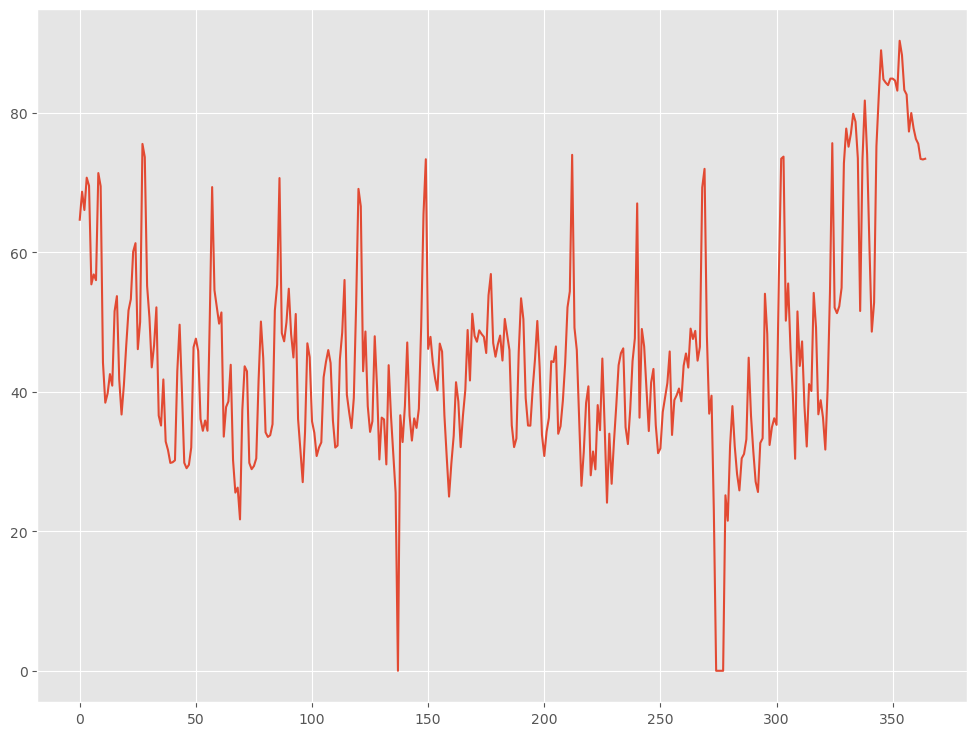

In [17]:
submit = pd.DataFrame({'datetime' : test_data.index, 'pred' : y_test_pred})

print(submit)
for i in test_data2[test_data2['close']==1].index:
    submit['pred'].iloc[i] = 0
    

plt.plot(submit['pred'])

submit.columns = submit.iloc[0]
print(submit)
submit.to_csv('signate_ligthGBM_oputuna_0831.csv', index=False)